In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as f
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm

In [10]:
train_df = pd.read_csv('./n_train.csv')
test_df = pd.read_csv('./n_test.csv')

In [11]:
exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'quarter', 'month', 'week', 'dayofyear', 'season', 'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos', 'quarter_sin', 'quarter_cos']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]
main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

Main features: 240


### Select features based on correlation matrix

In [105]:
train_independent_corr = train_df[main_attrs + temporal_attrs + loc_attrs + embedding_attrs].corr()
train_seleted_corr_columns = np.full((train_independent_corr.shape[0],), True, dtype=bool)
for i in range(train_independent_corr.shape[0]):
    for j in range(i + 1, train_independent_corr.shape[0]):
        if train_independent_corr.iloc[i, j] >= 0.85:
            
            if train_seleted_corr_columns[j]:
                train_seleted_corr_columns[j] = False
train_selected_columns = train_df[main_attrs + temporal_attrs + loc_attrs + embedding_attrs].columns[train_seleted_corr_columns]
print(train_selected_columns.shape)

test_independent_corr = test_df[main_attrs + temporal_attrs + loc_attrs + embedding_attrs].corr()
test_seleted_corr_columns = np.full((test_independent_corr.shape[0],), True, dtype=bool)
for i in range(test_independent_corr.shape[0]):
    for j in range(i + 1, test_independent_corr.shape[0]):
        if test_independent_corr.iloc[i, j] >= 0.85:
            if test_seleted_corr_columns[j]:
                test_seleted_corr_columns[j] = False
test_selected_columns = test_df[main_attrs + temporal_attrs + loc_attrs + embedding_attrs].columns[test_seleted_corr_columns]
print(test_selected_columns.shape)

(173,)
(115,)


In [106]:
out_cols = ['icec-2010-1',
 'icec-2010-2',
 'icec-2010-3',
 'icec-2010-4',
 'icec-2010-5',
 'icec-2010-6',
 'icec-2010-7',
 'icec-2010-8',
 'icec-2010-9',
 'icec-2010-10',
 'year',
 'quarter',
 'month_cos',
 'quarter_sin',
 'quarter_cos']
train_selected_columns = [c for c in train_selected_columns if c not in out_cols]
test_selected_columns = [c for c in test_selected_columns if c not in out_cols]

In [109]:
s = 0
todo_check_cols = []
for c in test_selected_columns:
    if c in train_selected_columns:
        s += 1
    else:
        todo_check_cols.append(c)
print("There are {} cols in selected test columns -> in selected train columns".format(s))
print("TODO CHECK COLS:", todo_check_cols)

There are 98 cols in selected test columns -> in selected train columns
TODO CHECK COLS: ['nmme0-prate-34w__cancm30', 'nmme0-prate-34w__ccsm30', 'nmme0-prate-34w__ccsm40', 'nmme0-prate-34w__gfdlflora0', 'nmme0-prate-34w__gfdl0', 'nmme0-prate-34w__nasa0', 'wind-hgt-100-2010-2']


In [110]:
def backwardElimination(x, Y, sl, columns):
    num_vars = len(x[0])
    for i in tqdm(range(0, num_vars)):
        regressor_OLS = sm.OLS(Y, x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        if max_var > sl:
            for j in tqdm(range(0, num_vars - i)):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    regressor_OLS.summary()
    return x, columns

In [112]:
selected_train = train_df[train_selected_columns].values
y = train_df[target[0]].values

In [ ]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(selected_train, y, SL, train_selected_columns)

 56%|████████████████████████████████████████████▌                                   | 89/160 [3:49:00<4:15:16, 215.72s/it]

In [117]:
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

In [144]:
def out_iqr(df , column):
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return df1.shape[0]+ df2.shape[0], (lower, upper)

In [153]:
selected_test_pvc_df = test_df[data.columns]
selected_train_pvc_df = train_df[list(data.columns) + target]

<AxesSubplot:>

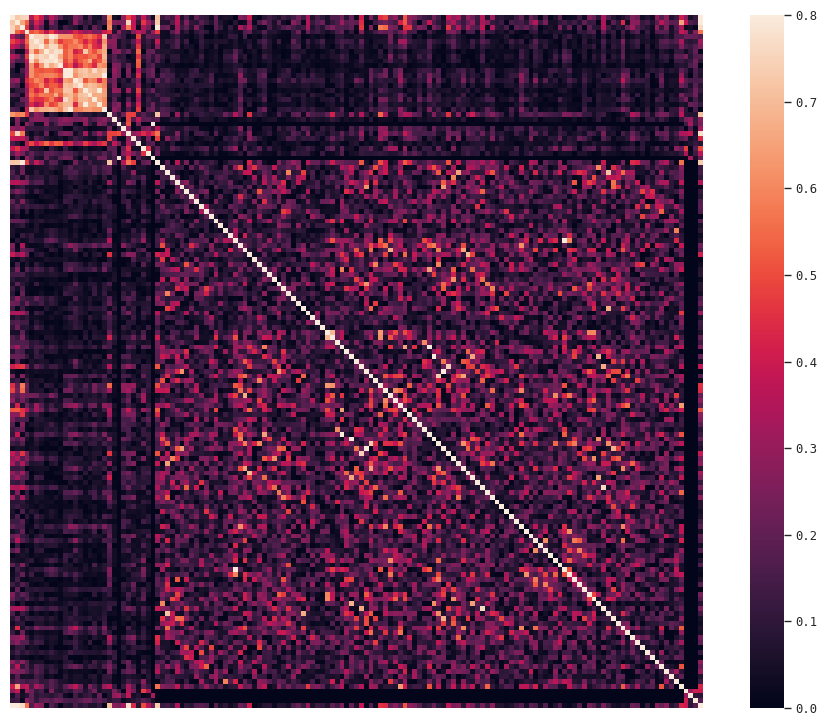

In [154]:
corrmat = selected_train_pvc_df.corr(method='pearson', min_periods=1000)
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

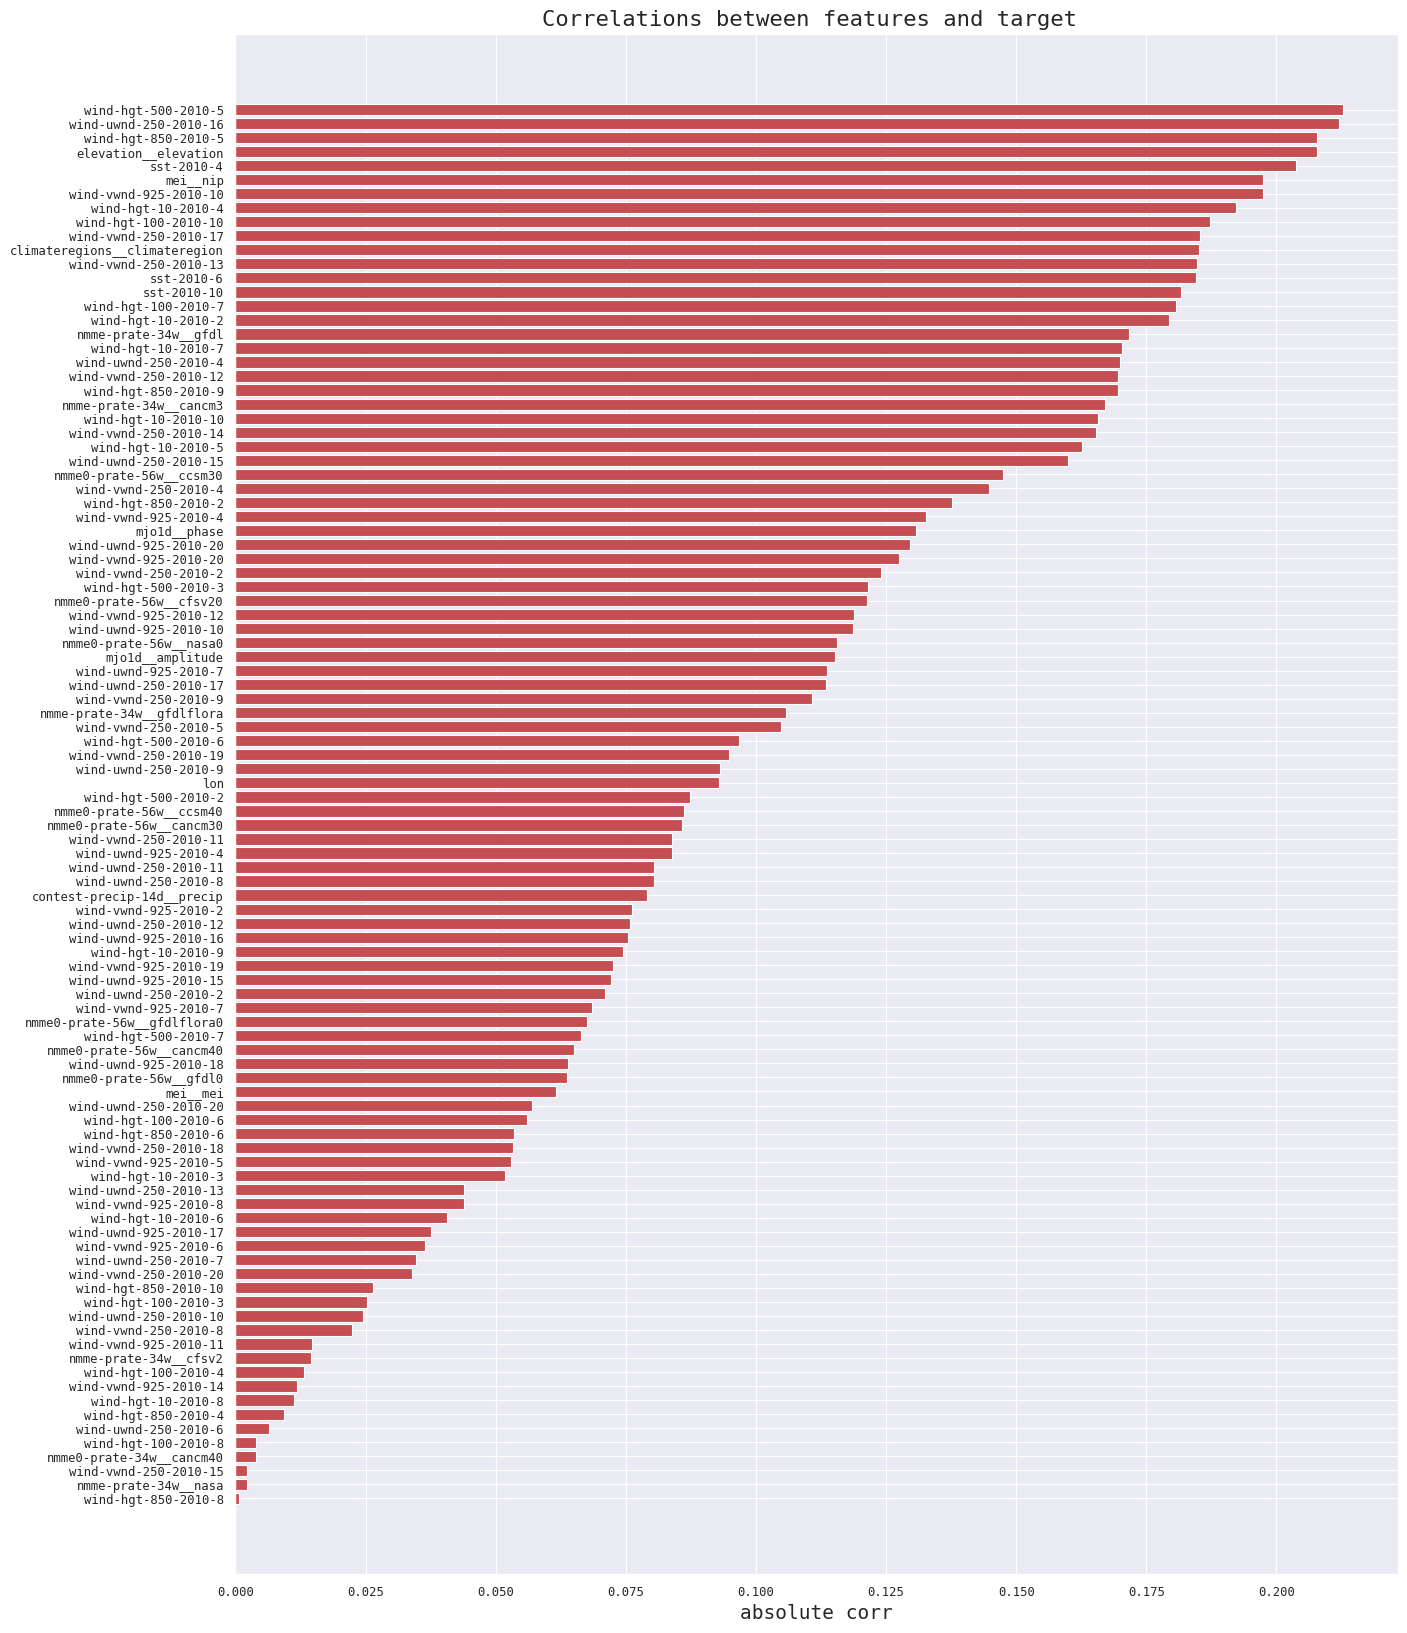

In [155]:
corr_target = corrmat[target[0]].reset_index()[:-1]
corr_target.columns = ['feature','abs_corr']
backup_corr = corr_target
remain_num = 100
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num]
ind = np.arange(corr_target.shape[0])
low_corr_features = corr_target.feature.values
width = 0.9
fig, ax = plt.subplots(figsize=(15,20))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(low_corr_features, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and target ", fontsize = 16)
plt.show()

In [164]:
from scipy.stats import pearsonr
from math import sqrt
class PriorityQueue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append((item, priority))
                break
        else:
            self.queue.append((item, priority))
            
    
    def pop(self):
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

def getMerit(subset, label):
    k = len(subset)
    rcf_all = []
    for feature in subset:
        coeff = pearsonr(train_df[label], train_df[feature])
        rcf_all.append(abs(coeff[0]))
    rcf = np.mean(rcf_all)
    corr = train_df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()
    
    return (k * rcf) / sqrt(k + k * (k - 1) * rff)

def find_best_in_level(features):
    
    best_value = -1
    best_feature = ''

    for feature in (features):
        coeff = pearsonr(train_df[target[0]], train_df[feature])
        abs_coeff = abs(coeff[0])
        if abs_coeff > best_value:
            best_value = abs_coeff
            best_feature = feature

    print("Feature %s with the merit %.4f"%(best_feature, best_value))
    return best_value, best_feature

best_value, best_feature = find_best_in_level(list(data.columns))

queue = PriorityQueue()
print("Feature %s with the merit %.4f"%(best_feature, best_value))
queue.push([best_feature], best_value)
best_value = best_value
best_subset = [best_feature]
visited = []
n_backtrack = 0
max_backtrack = 240
print(queue.isEmpty())

import random
features = data.columns
times = 0
while not queue.isEmpty():
    subset, priority = queue.pop()
    print("time:", times)
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        
        best_subset = subset
        n_backtrack = 0
    print(best_subset, priority, best_value, n_backtrack)
    
    if (n_backtrack == max_backtrack):
        break
    
    for feature in tqdm(features):
        temp_subset = subset + [feature]

        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        else:
            visited.append(temp_subset)
            merit = getMerit(temp_subset, target[0])
            queue.push(temp_subset, merit)
    times += 1

Feature nmme0-tmp2m-34w__cancm30 with the merit 0.8341
Feature nmme0-tmp2m-34w__cancm30 with the merit 0.8341
False
time: 0
['nmme0-tmp2m-34w__cancm30'] 0.8341069644865033 0.8341069644865033 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:08<00:00, 17.63it/s]


time: 1
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr'] 0.8833800417856169 0.8833800417856169 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:10<00:00, 12.98it/s]


time: 2
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr'] 0.9174094775394936 0.9174094775394936 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:14<00:00,  9.83it/s]


time: 3
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp'] 0.9289278213806814 0.9289278213806814 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:19<00:00,  7.23it/s]


time: 4
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10'] 0.929356919228756 0.929356919228756 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:23<00:00,  5.92it/s]


time: 5
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat'] 0.9413133090421263 0.9413133090421263 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:29<00:00,  4.77it/s]


time: 6
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9415454409473527 0.9415454409473527 0


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:34<00:00,  4.08it/s]


time: 7
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.940831241846533 0.9415454409473527 1


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:38<00:00,  3.66it/s]


time: 8
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.940471595056803 0.9415454409473527 2


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:43<00:00,  3.26it/s]


time: 9
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9404344766685266 0.9415454409473527 3


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:43<00:00,  3.25it/s]


time: 10
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9402913043290775 0.9415454409473527 4


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.95it/s]


time: 11
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9394149829895774 0.9415454409473527 5


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.93it/s]


time: 12
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9390084065086155 0.9415454409473527 6


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:46<00:00,  3.03it/s]


time: 13
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.938863025340718 0.9415454409473527 7


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:54<00:00,  2.60it/s]


time: 14
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9381238965857875 0.9415454409473527 8


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:34<00:00,  4.12it/s]


time: 15
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9381078659951133 0.9415454409473527 9


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:42<00:00,  3.32it/s]


time: 16
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9381680885140198 0.9415454409473527 10


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.92it/s]


time: 17
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9380104877587484 0.9415454409473527 11


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.90it/s]


time: 18
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9377143891729414 0.9415454409473527 12


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:54<00:00,  2.61it/s]


time: 19
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9376851558162824 0.9415454409473527 13


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:47<00:00,  3.00it/s]


time: 20
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9376483770710108 0.9415454409473527 14


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:58<00:00,  2.43it/s]


time: 21
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9374996295577667 0.9415454409473527 15


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:00<00:00,  2.34it/s]


time: 22
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9373192569518315 0.9415454409473527 16


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:14<00:00,  1.90it/s]


time: 23
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371694228988707 0.9415454409473527 17


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:24<00:00,  1.68it/s]


time: 24
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371630306805708 0.9415454409473527 18


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:07<00:00,  2.11it/s]


time: 25
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371594084466378 0.9415454409473527 19


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:11<00:00,  1.99it/s]


time: 26
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371474881067449 0.9415454409473527 20


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:49<00:00,  2.90it/s]


time: 27
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371450733859646 0.9415454409473527 21


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:06<00:00,  2.13it/s]


time: 28
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9370692444313552 0.9415454409473527 22


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:13<00:00,  1.93it/s]


time: 29
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9369619501382208 0.9415454409473527 23


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:54<00:00,  1.24it/s]


time: 30
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9368298680718673 0.9415454409473527 24


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:27<00:00,  1.63it/s]


time: 31
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9367740449564783 0.9415454409473527 25


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:05<00:00,  2.18it/s]


time: 32
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9394894417284323 0.9415454409473527 26


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:11<00:00,  1.99it/s]


time: 33
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9398671027054928 0.9415454409473527 27


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:17<00:00,  1.83it/s]


time: 34
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9381063823193436 0.9415454409473527 28


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:25<00:00,  1.65it/s]


time: 35
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9374240076224459 0.9415454409473527 29


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:08<00:00,  1.10it/s]


time: 36
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9373190816914794 0.9415454409473527 30


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:22<00:00,  1.72it/s]


time: 37
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371110051299665 0.9415454409473527 31


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:42<00:00,  1.39it/s]


time: 38
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9369149263233256 0.9415454409473527 32


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.70it/s]


time: 39
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9367559283322824 0.9415454409473527 33


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:18<00:00,  1.82it/s]


time: 40
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.936702230167308 0.9415454409473527 34


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:55<00:00,  2.58it/s]


time: 41
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9366645219887003 0.9415454409473527 35


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:44<00:00,  3.16it/s]


time: 42
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371853238365496 0.9415454409473527 36


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:51<00:00,  2.75it/s]


time: 43
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9376747669343571 0.9415454409473527 37


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:57<00:00,  2.48it/s]


time: 44
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365910007537875 0.9415454409473527 38


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:10<00:00,  2.02it/s]


time: 45
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365620214636934 0.9415454409473527 39


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:55<00:00,  2.54it/s]


time: 46
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365528323247443 0.9415454409473527 40


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.93it/s]


time: 47
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365392964698128 0.9415454409473527 41


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:44<00:00,  3.21it/s]


time: 48
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9364264750547532 0.9415454409473527 42


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:48<00:00,  2.93it/s]


time: 49
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9364198639063703 0.9415454409473527 43


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:09<00:00,  2.06it/s]


time: 50
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9363673232317377 0.9415454409473527 44


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:54<00:00,  2.63it/s]


time: 51
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9363670023426157 0.9415454409473527 45


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:59<00:00,  2.40it/s]


time: 52
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9363669760861845 0.9415454409473527 46


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:44<00:00,  3.18it/s]


time: 53
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362890039984471 0.9415454409473527 47


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:57<00:00,  2.46it/s]


time: 54
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362701433970664 0.9415454409473527 48


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:44<00:00,  3.21it/s]


time: 55
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362555735816561 0.9415454409473527 49


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:53<00:00,  2.67it/s]


time: 56
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362404635797019 0.9415454409473527 50


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:41<00:00,  3.43it/s]


time: 57
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362384732998267 0.9415454409473527 51


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:55<00:00,  2.58it/s]


time: 58
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362154274087515 0.9415454409473527 52


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:00<00:00,  2.36it/s]


time: 59
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.936206012826726 0.9415454409473527 53


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:50<00:00,  2.81it/s]


time: 60
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.936188281343545 0.9415454409473527 54


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:54<00:00,  2.59it/s]


time: 61
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361691358939052 0.9415454409473527 55


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:01<00:00,  2.32it/s]


time: 62
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361585665754382 0.9415454409473527 56


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:00<00:00,  2.36it/s]


time: 63
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361243132481968 0.9415454409473527 57


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:01<00:00,  2.31it/s]


time: 64
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.936112514201219 0.9415454409473527 58


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:12<00:00,  1.95it/s]


time: 65
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9360910397768019 0.9415454409473527 59


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.64it/s]


time: 66
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9360592884445488 0.9415454409473527 60


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:16<00:00,  1.86it/s]


time: 67
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935980266561782 0.9415454409473527 61


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:04<00:00,  2.19it/s]


time: 68
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9359164371845389 0.9415454409473527 62


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:46<00:00,  3.03it/s]


time: 69
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358920311069568 0.9415454409473527 63


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:00<00:00,  2.36it/s]


time: 70
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358844006946573 0.9415454409473527 64


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:08<00:00,  2.07it/s]


time: 71
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358746602482908 0.9415454409473527 65


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:17<00:00,  1.82it/s]


time: 72
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358589563086321 0.9415454409473527 66


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:31<00:00,  1.55it/s]


time: 73
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358294678638186 0.9415454409473527 67


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:45<00:00,  1.35it/s]


time: 74
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357891443875725 0.9415454409473527 68


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:22<00:00,  1.73it/s]


time: 75
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935787030920647 0.9415454409473527 69


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.71it/s]


time: 76
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357798026529535 0.9415454409473527 70


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:32<00:00,  1.53it/s]


time: 77
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357538107222368 0.9415454409473527 71


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:10<00:00,  2.00it/s]


time: 78
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935722618350079 0.9415454409473527 72


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.53it/s]


time: 79
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357070315922523 0.9415454409473527 73


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:19<00:00,  1.80it/s]


time: 80
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356523468835326 0.9415454409473527 74


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:29<00:00,  1.58it/s]


time: 81
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356430425793535 0.9415454409473527 75


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:04<00:00,  1.14it/s]


time: 82
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356181794115673 0.9415454409473527 76


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.65it/s]


time: 83
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356047896466562 0.9415454409473527 77


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [03:14<00:00,  1.37s/it]


time: 84
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356010492297483 0.9415454409473527 78


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:14<00:00,  1.91it/s]


time: 85
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355948448641112 0.9415454409473527 79


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:08<00:00,  2.09it/s]


time: 86
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355904621882771 0.9415454409473527 80


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:17<00:00,  1.84it/s]


time: 87
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356423839995331 0.9415454409473527 81


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:12<00:00,  1.07it/s]


time: 88
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355827198652487 0.9415454409473527 82


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:09<00:00,  2.05it/s]


time: 89
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355716686712751 0.9415454409473527 83


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:53<00:00,  2.65it/s]


time: 90
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355648727838078 0.9415454409473527 84


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:37<00:00,  3.76it/s]


time: 91
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355009123550527 0.9415454409473527 85


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [03:13<00:00,  1.36s/it]


time: 92
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354964034452803 0.9415454409473527 86


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:15<00:00,  1.88it/s]


time: 93
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354870977014517 0.9415454409473527 87


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.60it/s]


time: 94
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354619528480771 0.9415454409473527 88


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:25<00:00,  1.65it/s]


time: 95
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935447516982053 0.9415454409473527 89


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:16<00:00,  1.87it/s]


time: 96
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354394666201686 0.9415454409473527 90


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.63it/s]


time: 97
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354186396797686 0.9415454409473527 91


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:58<00:00,  2.41it/s]


time: 98
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354128929623993 0.9415454409473527 92


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:13<00:00,  1.93it/s]


time: 99
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353841962082549 0.9415454409473527 93


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:12<00:00,  1.95it/s]


time: 100
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353665035598911 0.9415454409473527 94


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:29<00:00,  1.59it/s]


time: 101
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354303192168241 0.9415454409473527 95


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:34<00:00,  1.09s/it]


time: 102
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353418105326655 0.9415454409473527 96


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:01<00:00,  2.30it/s]


time: 103
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353413925735746 0.9415454409473527 97


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:22<00:00,  1.73it/s]


time: 104
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353324453420485 0.9415454409473527 98


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.70it/s]


time: 105
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353224031005529 0.9415454409473527 99


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:47<00:00,  1.32it/s]


time: 106
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353102317579781 0.9415454409473527 100


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:22<00:00,  1.72it/s]


time: 107
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352972287880706 0.9415454409473527 101


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:39<00:00,  1.43it/s]


time: 108
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935295949178046 0.9415454409473527 102


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:49<00:00,  1.30it/s]


time: 109
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935277000564087 0.9415454409473527 103


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:18<00:00,  1.82it/s]


time: 110
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352592506197578 0.9415454409473527 104


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:53<00:00,  1.25it/s]


time: 111
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352367910854914 0.9415454409473527 105


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:48<00:00,  1.31it/s]


time: 112
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352355226332867 0.9415454409473527 106


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:49<00:00,  1.29it/s]


time: 113
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352247048573752 0.9415454409473527 107


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:57<00:00,  1.21it/s]


time: 114
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935219692713731 0.9415454409473527 108


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:01<00:00,  1.17it/s]


time: 115
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351561580563044 0.9415454409473527 109


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:42<00:00,  1.38it/s]


time: 116
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351536851272306 0.9415454409473527 110


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:08<00:00,  2.06it/s]


time: 117
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352965566538145 0.9415454409473527 111


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:20<00:00,  1.76it/s]


time: 118
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9370964815338314 0.9415454409473527 112


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


time: 119
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9384965872258889 0.9415454409473527 113


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:37<00:00,  1.46it/s]


time: 120
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9389194065989566 0.9415454409473527 114


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:47<00:00,  1.33it/s]


time: 121
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9375597105267489 0.9415454409473527 115


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:56<00:00,  1.22it/s]


time: 122
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9375017799693273 0.9415454409473527 116


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:10<00:00,  1.09it/s]


time: 123
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9374416171863238 0.9415454409473527 117


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:27<00:00,  1.04s/it]


time: 124
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9370893470347599 0.9415454409473527 118


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:01<00:00,  1.17it/s]


time: 125
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9383613869547469 0.9415454409473527 119


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:13<00:00,  1.06it/s]


time: 126
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9369835587018682 0.9415454409473527 120


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:27<00:00,  1.04s/it]


time: 127
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.936904439933261 0.9415454409473527 121


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:53<00:00,  1.25it/s]


time: 128
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9366875876355024 0.9415454409473527 122


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:12<00:00,  1.07it/s]


time: 129
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9367235516810972 0.9415454409473527 123


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:59<00:00,  1.19it/s]


time: 130
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9366784037298623 0.9415454409473527 124


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:48<00:00,  1.31it/s]


time: 131
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9366729137991583 0.9415454409473527 125


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:17<00:00,  1.03it/s]


time: 132
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365912481522488 0.9415454409473527 126


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:37<00:00,  1.46it/s]


time: 133
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9366829456769366 0.9415454409473527 127


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:00<00:00,  1.18it/s]


time: 134
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365343038140722 0.9415454409473527 128


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:04<00:00,  1.14it/s]


time: 135
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9365153292014327 0.9415454409473527 129


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.63it/s]


time: 136
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9364375858234864 0.9415454409473527 130


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.70it/s]


time: 137
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9364194081027752 0.9415454409473527 131


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:15<00:00,  1.89it/s]


time: 138
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9371370738124759 0.9415454409473527 132


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:24<00:00,  1.68it/s]


time: 139
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9364055570802674 0.9415454409473527 133


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.65it/s]


time: 140
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9363448738866877 0.9415454409473527 134


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:21<00:00,  1.73it/s]


time: 141
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9362252430698759 0.9415454409473527 135


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.71it/s]


time: 142
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361627143338757 0.9415454409473527 136


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:18<00:00,  1.80it/s]


time: 143
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361493834228946 0.9415454409473527 137


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:20<00:00,  1.76it/s]


time: 144
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9361223803160745 0.9415454409473527 138


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:24<00:00,  1.67it/s]


time: 145
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9360706662859046 0.9415454409473527 139


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:32<00:00,  1.54it/s]


time: 146
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9360277638177315 0.9415454409473527 140


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:32<00:00,  1.54it/s]


time: 147
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9359750957895419 0.9415454409473527 141


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:36<00:00,  1.47it/s]


time: 148
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9359543597987778 0.9415454409473527 142


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:17<00:00,  1.03it/s]


time: 149
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9359051577714861 0.9415454409473527 143


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [03:50<00:00,  1.62s/it]


time: 150
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9358116138094541 0.9415454409473527 144


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:49<00:00,  1.30it/s]


time: 151
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357618168867268 0.9415454409473527 145


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:02<00:00,  1.16it/s]


time: 152
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9357612780428655 0.9415454409473527 146


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:59<00:00,  1.19it/s]


time: 153
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356911670679536 0.9415454409473527 147


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:44<00:00,  1.35it/s]


time: 154
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356395861928097 0.9415454409473527 148


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:25<00:00,  1.03s/it]


time: 155
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9356350277055892 0.9415454409473527 149


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:14<00:00,  1.91it/s]


time: 156
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355777107319841 0.9415454409473527 150


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:52<00:00,  1.26it/s]


time: 157
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935540100782871 0.9415454409473527 151


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:20<00:00,  1.01it/s]


time: 158
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9355145492008008 0.9415454409473527 152


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:19<00:00,  1.02it/s]


time: 159
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.93548370554876 0.9415454409473527 153


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:37<00:00,  1.11s/it]


time: 160
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935429220734371 0.9415454409473527 154


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:42<00:00,  1.15s/it]


time: 161
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9354121210457023 0.9415454409473527 155


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:28<00:00,  1.04s/it]


time: 162
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353834296632251 0.9415454409473527 156


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:13<00:00,  1.06it/s]


time: 163
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353730272426912 0.9415454409473527 157


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:10<00:00,  1.09it/s]


time: 164
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353614469305855 0.9415454409473527 158


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:25<00:00,  1.02s/it]


time: 165
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353555382454278 0.9415454409473527 159


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:37<00:00,  1.11s/it]


time: 166
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9353485270144958 0.9415454409473527 160


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:13<00:00,  1.07it/s]


time: 167
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352476840419321 0.9415454409473527 161


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:52<00:00,  1.26it/s]


time: 168
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9352161263714209 0.9415454409473527 162


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [03:11<00:00,  1.35s/it]


time: 169
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351924955430199 0.9415454409473527 163


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:58<00:00,  1.20it/s]


time: 170
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351862976053066 0.9415454409473527 164


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:59<00:00,  1.19it/s]


time: 171
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.935148346072823 0.9415454409473527 165


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:32<00:00,  1.53it/s]


time: 172
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351347780662997 0.9415454409473527 166


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:37<00:00,  1.45it/s]


time: 173
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351314017943613 0.9415454409473527 167


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:31<00:00,  1.55it/s]


time: 174
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351286150761076 0.9415454409473527 168


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:39<00:00,  1.42it/s]


time: 175
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351251479431395 0.9415454409473527 169


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:23<00:00,  1.71it/s]


time: 176
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351186932686375 0.9415454409473527 170


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:26<00:00,  1.65it/s]


time: 177
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351132018533757 0.9415454409473527 171


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:39<00:00,  1.43it/s]


time: 178
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9351016163296111 0.9415454409473527 172


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:38<00:00,  1.44it/s]


time: 179
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350877374690868 0.9415454409473527 173


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.52it/s]


time: 180
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350732360329649 0.9415454409473527 174


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


time: 181
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350672137184574 0.9415454409473527 175


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:15<00:00,  1.05it/s]


time: 182
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350583815217184 0.9415454409473527 176


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:56<00:00,  2.51it/s]


time: 183
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350497955751856 0.9415454409473527 177


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:58<00:00,  2.44it/s]


time: 184
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350470040469319 0.9415454409473527 178


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:13<00:00,  1.94it/s]


time: 185
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350346906406867 0.9415454409473527 179


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:16<00:00,  1.85it/s]


time: 186
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9350105552196072 0.9415454409473527 180


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:29<00:00,  1.58it/s]


time: 187
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349798460695451 0.9415454409473527 181


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:20<00:00,  1.76it/s]


time: 188
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349785734630478 0.9415454409473527 182


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:21<00:00,  1.73it/s]


time: 189
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349713747421642 0.9415454409473527 183


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:35<00:00,  1.49it/s]


time: 190
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349497452935907 0.9415454409473527 184


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.52it/s]


time: 191
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349415990462732 0.9415454409473527 185


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:22<00:00,  1.73it/s]


time: 192
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.93493176370725 0.9415454409473527 186


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:10<00:00,  2.02it/s]


time: 193
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349312954209201 0.9415454409473527 187


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:38<00:00,  1.44it/s]


time: 194
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9349045708853363 0.9415454409473527 188


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.51it/s]


time: 195
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9348959600462974 0.9415454409473527 189


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:43<00:00,  1.38it/s]


time: 196
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9348778917272099 0.9415454409473527 190


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:00<00:00,  1.18it/s]


time: 197
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9348693100673425 0.9415454409473527 191


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [02:58<00:00,  1.26s/it]


time: 198
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.934866352735727 0.9415454409473527 192


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


time: 199
['nmme0-tmp2m-34w__cancm30', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-prwtr-eatm-14d__prwtr', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'lat', 'sst-2010-5'] 0.9348634097638889 0.9415454409473527 193


 23%|███████████████████▊                                                                 | 33/142 [00:18<01:01,  1.76it/s]


KeyboardInterrupt: 

In [147]:
outlier_cols = []
outlier_lower_list = []
outlier_upper_list = []

for col in tqdm(data.columns):
    print("Checking outliers in column named {}".format(col))
    train_outlier_info = out_iqr(data, col)
    num_out_train = train_outlier_info[0]
    if col != target[0]:
        num_out_test = out_iqr(selected_test_pvc_df, col)[0]
        if (num_out_train > 0 and num_out_test == 0):
            outlier_cols.append(col)
            outlier_lower_list.append(train_outlier_info[1][0])
            outlier_upper_list.append(train_outlier_info[1][1])            

  3%|██▍                                                                                   | 4/142 [00:00<00:03, 39.17it/s]

Checking outliers in column named contest-pevpr-sfc-gauss-14d__pevpr
Checking outliers in column named nmme0-tmp2m-34w__cancm30
Checking outliers in column named contest-wind-h10-14d__wind-hgt-10
Checking outliers in column named contest-rhum-sig995-14d__rhum
Checking outliers in column named nmme-prate-34w__cancm3
Checking outliers in column named nmme-prate-34w__ccsm3
Checking outliers in column named nmme-prate-34w__ccsm4


  8%|███████▏                                                                             | 12/142 [00:00<00:03, 33.71it/s]

Checking outliers in column named nmme-prate-34w__cfsv2
Checking outliers in column named nmme-prate-34w__gfdl
Checking outliers in column named nmme-prate-34w__gfdlflora
Checking outliers in column named nmme-prate-34w__nasa
Checking outliers in column named nmme0-prate-56w__cancm30
Checking outliers in column named nmme0-prate-56w__cancm40
Checking outliers in column named nmme0-prate-56w__ccsm30
Checking outliers in column named nmme0-prate-56w__ccsm40


 14%|███████████▉                                                                         | 20/142 [00:00<00:03, 35.09it/s]

Checking outliers in column named nmme0-prate-56w__cfsv20
Checking outliers in column named nmme0-prate-56w__gfdlflora0
Checking outliers in column named nmme0-prate-56w__gfdl0
Checking outliers in column named nmme0-prate-56w__nasa0
Checking outliers in column named nmme0-prate-34w__cancm40
Checking outliers in column named contest-slp-14d__slp
Checking outliers in column named contest-wind-vwnd-925-14d__wind-vwnd-925
Checking outliers in column named contest-pres-sfc-gauss-14d__pres


 20%|█████████████████▎                                                                   | 29/142 [00:00<00:03, 34.67it/s]

Checking outliers in column named contest-wind-uwnd-250-14d__wind-uwnd-250
Checking outliers in column named contest-prwtr-eatm-14d__prwtr
Checking outliers in column named contest-wind-vwnd-250-14d__wind-vwnd-250
Checking outliers in column named contest-precip-14d__precip
Checking outliers in column named contest-wind-h850-14d__wind-hgt-850
Checking outliers in column named contest-wind-uwnd-925-14d__wind-uwnd-925
Checking outliers in column named elevation__elevation
Checking outliers in column named wind-vwnd-250-2010-1
Checking outliers in column named wind-vwnd-250-2010-2


 30%|█████████████████████████▋                                                           | 43/142 [00:01<00:02, 47.39it/s]

Checking outliers in column named wind-vwnd-250-2010-4
Checking outliers in column named wind-vwnd-250-2010-5
Checking outliers in column named wind-vwnd-250-2010-7
Checking outliers in column named wind-vwnd-250-2010-8
Checking outliers in column named wind-vwnd-250-2010-9
Checking outliers in column named wind-vwnd-250-2010-11
Checking outliers in column named wind-vwnd-250-2010-12
Checking outliers in column named wind-vwnd-250-2010-13
Checking outliers in column named wind-vwnd-250-2010-14
Checking outliers in column named wind-vwnd-250-2010-15
Checking outliers in column named wind-vwnd-250-2010-17
Checking outliers in column named wind-vwnd-250-2010-18


 36%|██████████████████████████████▌                                                      | 51/142 [00:01<00:01, 55.92it/s]

Checking outliers in column named wind-vwnd-250-2010-19
Checking outliers in column named wind-vwnd-250-2010-20
Checking outliers in column named wind-uwnd-250-2010-2
Checking outliers in column named wind-uwnd-250-2010-3
Checking outliers in column named wind-uwnd-250-2010-4
Checking outliers in column named wind-uwnd-250-2010-5
Checking outliers in column named wind-uwnd-250-2010-6
Checking outliers in column named wind-uwnd-250-2010-7
Checking outliers in column named wind-uwnd-250-2010-8
Checking outliers in column named wind-uwnd-250-2010-9
Checking outliers in column named wind-uwnd-250-2010-10
Checking outliers in column named wind-uwnd-250-2010-11
Checking outliers in column named wind-uwnd-250-2010-12


 44%|█████████████████████████████████████▋                                               | 63/142 [00:01<00:01, 54.15it/s]

Checking outliers in column named wind-uwnd-250-2010-13
Checking outliers in column named wind-uwnd-250-2010-15
Checking outliers in column named wind-uwnd-250-2010-16
Checking outliers in column named wind-uwnd-250-2010-17
Checking outliers in column named wind-uwnd-250-2010-18
Checking outliers in column named wind-uwnd-250-2010-20
Checking outliers in column named mjo1d__phase
Checking outliers in column named mjo1d__amplitude
Checking outliers in column named mei__mei
Checking outliers in column named mei__nip


 53%|████████████████████████████████████████████▉                                        | 75/142 [00:09<00:18,  3.60it/s]

Checking outliers in column named wind-hgt-850-2010-2
Checking outliers in column named wind-hgt-850-2010-3
Checking outliers in column named wind-hgt-850-2010-4
Checking outliers in column named wind-hgt-850-2010-5
Checking outliers in column named wind-hgt-850-2010-6
Checking outliers in column named wind-hgt-850-2010-7
Checking outliers in column named wind-hgt-850-2010-8
Checking outliers in column named wind-hgt-850-2010-9
Checking outliers in column named wind-hgt-850-2010-10
Checking outliers in column named sst-2010-2
Checking outliers in column named sst-2010-3
Checking outliers in column named sst-2010-4


 62%|████████████████████████████████████████████████████▋                                | 88/142 [00:09<00:07,  7.21it/s]

Checking outliers in column named sst-2010-5
Checking outliers in column named sst-2010-6
Checking outliers in column named sst-2010-7
Checking outliers in column named sst-2010-8
Checking outliers in column named sst-2010-9
Checking outliers in column named sst-2010-10
Checking outliers in column named wind-hgt-500-2010-2
Checking outliers in column named wind-hgt-500-2010-3
Checking outliers in column named wind-hgt-500-2010-5
Checking outliers in column named wind-hgt-500-2010-6
Checking outliers in column named wind-hgt-500-2010-7
Checking outliers in column named wind-hgt-500-2010-8


 66%|████████████████████████████████████████████████████████▎                            | 94/142 [00:09<00:05,  9.57it/s]

Checking outliers in column named wind-hgt-500-2010-9
Checking outliers in column named wind-hgt-500-2010-10
Checking outliers in column named wind-uwnd-925-2010-4
Checking outliers in column named wind-uwnd-925-2010-5
Checking outliers in column named wind-uwnd-925-2010-6
Checking outliers in column named wind-uwnd-925-2010-7
Checking outliers in column named wind-uwnd-925-2010-8
Checking outliers in column named wind-uwnd-925-2010-10
Checking outliers in column named wind-uwnd-925-2010-14


 75%|███████████████████████████████████████████████████████████████▎                    | 107/142 [00:09<00:02, 16.83it/s]

Checking outliers in column named wind-uwnd-925-2010-15
Checking outliers in column named wind-uwnd-925-2010-16
Checking outliers in column named wind-uwnd-925-2010-17
Checking outliers in column named wind-uwnd-925-2010-18
Checking outliers in column named wind-uwnd-925-2010-20
Checking outliers in column named wind-hgt-10-2010-2
Checking outliers in column named wind-hgt-10-2010-3
Checking outliers in column named wind-hgt-10-2010-4
Checking outliers in column named wind-hgt-10-2010-5
Checking outliers in column named wind-hgt-10-2010-6


 84%|██████████████████████████████████████████████████████████████████████▍             | 119/142 [00:09<00:00, 24.62it/s]

Checking outliers in column named wind-hgt-10-2010-7
Checking outliers in column named wind-hgt-10-2010-8
Checking outliers in column named wind-hgt-10-2010-9
Checking outliers in column named wind-hgt-10-2010-10
Checking outliers in column named wind-hgt-100-2010-3
Checking outliers in column named wind-hgt-100-2010-4
Checking outliers in column named wind-hgt-100-2010-6
Checking outliers in column named wind-hgt-100-2010-7
Checking outliers in column named wind-hgt-100-2010-8
Checking outliers in column named wind-hgt-100-2010-9
Checking outliers in column named wind-hgt-100-2010-10
Checking outliers in column named wind-vwnd-925-2010-2


 93%|██████████████████████████████████████████████████████████████████████████████      | 132/142 [00:10<00:00, 34.60it/s]

Checking outliers in column named wind-vwnd-925-2010-3
Checking outliers in column named wind-vwnd-925-2010-4
Checking outliers in column named wind-vwnd-925-2010-5
Checking outliers in column named wind-vwnd-925-2010-6
Checking outliers in column named wind-vwnd-925-2010-7
Checking outliers in column named wind-vwnd-925-2010-8
Checking outliers in column named wind-vwnd-925-2010-9
Checking outliers in column named wind-vwnd-925-2010-10
Checking outliers in column named wind-vwnd-925-2010-11
Checking outliers in column named wind-vwnd-925-2010-12
Checking outliers in column named wind-vwnd-925-2010-14


100%|████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:10<00:00, 13.72it/s]

Checking outliers in column named wind-vwnd-925-2010-15
Checking outliers in column named wind-vwnd-925-2010-16
Checking outliers in column named wind-vwnd-925-2010-18
Checking outliers in column named wind-vwnd-925-2010-19
Checking outliers in column named wind-vwnd-925-2010-20
Checking outliers in column named season
Checking outliers in column named lat
Checking outliers in column named lon
Checking outliers in column named climateregions__climateregion


50

In [120]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import xgboost as xgb
from scipy.stats import gmean

exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'quarter', 'month', 'week', 'dayofyear', 'season', 'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos', 'quarter_sin', 'quarter_cos']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]
main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

X = data.values
y = train_df[target[0]].values

skf = KFold(n_splits=5, random_state=2048, shuffle=True)
skf.get_n_splits(X, y)

Main features: 240


5

In [121]:
train_index_list = []
test_index_list = []
train_x_list = []
val_x_list = []
train_y_list = []
val_y_list = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_x_list.append(X[train_index, :])
    val_x_list.append(X[test_index, :])
    train_y_list.append(y[train_index])
    val_y_list.append(y[test_index])    

5it [00:02,  2.08it/s]


,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__nasa,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-34w__cancm40,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__nip,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-2010-7,wind-uwnd-925-2010-8,wind-uwnd-925-2010-10,wind-uwnd-925-2010-14,wind-uwnd-925-2010-15,wind-uwnd-925-2010-16,wind-uwnd-925-2010-17,wind-uwnd-925-2010-18,wind-uwnd-925-2010-20,wind-hgt-10-2010-2,wind-hgt-10-2010-3,wind-hgt-10-2010-4,wind-hgt-10-2010-5,wind-hgt-10-2010-6,wind-hgt-10-2010-7,wind-hgt-10-2010-8,wind-hgt-10-2010-9,wind-hgt-10-2010-10,wind-hgt-100-2010-3,wind-hgt-100-2010-4,wind-hgt-100-2010-6,wind-hgt-100-2010-7,wind-hgt-100-2010-8,wind-hgt-100-2010-9,wind-hgt-100-2010-10,wind-vwnd-925-2010-2,wind-vwnd-925-2010-3,wind-vwnd-925-2010-4,wind-vwnd-925-2010-5,wind-vwnd-925-2010-6,wind-vwnd-925-2010-7,wind-vwnd-925-2010-8,wind-vwnd-925-2010-9,wind-vwnd-925-2010-10,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,season,lat,lon,climateregions__climateregion
0,237.00,29.02,31246.63,81.72,25.33,13.59,25.28,38.05,18.06,23.20,16.50,17.41,5.89,14.37,11.60,17.63,1.17,0.32,14.88,17.54,101352.08,4.41,98644.97,-2.56,42.45,-3.52,94.31,1535.52,-5.22,200.0,-111.29,33.66,20.57,-123.14,-125.92,104.95,15.14,7.88,5.91,-208.23,18.67,21.00,43.65,-44.70,-3.70,-65.02,130.79,163.84,80.55,-86.61,83.69,-79.66,99.19,-11.93,21.48,62.06,285.66,-114.96,-109.81,125.75,-71.99,35.85,19.48,4.0,1.23,0.961,4.0,410.10,-2321.02,-1423.47,1064.98,-816.00,77.17,90.35,-160.02,413.91,-22.37,-19.69,13.58,19.29,-12.78,-25.20,7.55,-33.72,23.53,1100.68,-3189.61,1410.84,-1868.95,-1254.45,714.05,1549.20,-602.97,-0.32,124.30,-1.43,-81.98,61.40,17.96,-69.20,-69.16,27.55,-18.55,-54.43,39.02,-16054.10,10487.61,-4560.34,7128.13,-2281.45,-6076.15,-2209.63,3864.18,-3051.21,-1507.91,3391.32,-1585.41,1544.02,944.73,-1267.75,-2402.46,42.55,29.16,-63.35,23.47,45.56,-33.43,-3.89,4.18,69.09,-27.68,-37.21,9.56,-2.03,48.13,-13.50,11.90,4.58,3.0,0.0,0.833333,0.0
1,228.90,29.02,312

In [140]:
def train_catboost(x, y):
    print(x.shape, y.shape)
    
    xgb_models = []
    for i in tqdm(range(1)):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i]
        clf = CatBoostRegressor(iterations=5000, verbose=200)
        clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=True, early_stopping_rounds=100)
        xgb_models.append(clf)
    
    return xgb_models
xgb_models = train_catboost(X, y)

# def train_xgboost(x, y):
#     print(x.shape, y.shape)
    
#     xgb_models = []
#     for i in tqdm(range(5)):
#         train_x, val_x = train_x_list[i], val_x_list[i]
#         train_y, val_y = train_y_list[i], val_y_list[i]
#         clf = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
#                        tree_method = 'gpu_hist',
#                        n_estimators=10000,
#                        early_stopping_rounds=50,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01, gpu_id=0)
#         clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=True, early_stopping_rounds=100)
#         xgb_models.append(clf)
    
#     return xgb_models
# xgb_models = train_xgboost(X, y)

(375734, 142) (375734,)


  0%|                                                                                                | 0/5 [00:00<?, ?it/s]/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
  0%|                                                                                                | 0/5 [00:01<?, ?it/s]


ValueError: 2 different `early_stopping_rounds` are provided.  Use the one in constructor or `set_params` instead.

In [139]:
preds = []
for xgb_model in tqdm(xgb_models):
    preds.append(xgb_model.predict(test_df[data.columns].values))
s = 0
for pred in preds:
    s += pred
s = s/1
df = pd.read_csv('./sample_solution.csv')
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_10000_PVC.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


In [138]:
best_df = pd.read_csv('submission_10000_BFS.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

cos_sim with best submission: 0.9997747318388757


In [126]:
len(bfs_cols)

160

In [127]:
train_x_list[0].shape

(300587, 142)

In [172]:
cols_no_scale = ['mei__mei', 'mei__nip', 'season', 'lon', 'lat', 'climateregions__climateregion']

In [174]:
cols_scale = [c for c in train_selected_columns if c not in cols_no_scale]

In [176]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scaled_X_train = scale.fit_transform(train_df[cols_scale].values)
scale = StandardScaler()
scaled_X_test = scale.fit_transform(test_df[cols_scale].values)

In [182]:
X_train = np.concatenate([scaled_X_train, train_df[cols_no_scale].values], axis=1)
X_test = np.concatenate([scaled_X_test, test_df[cols_no_scale].values], axis=1)
y = train_df[target[0]].values

In [184]:
skf = KFold(n_splits=5, random_state=2048, shuffle=True)
skf.get_n_splits(X, y)

5

In [185]:
train_index_list = []
test_index_list = []
train_x_list = []
val_x_list = []
train_y_list = []
val_y_list = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_x_list.append(X[train_index, :])
    val_x_list.append(X[test_index, :])
    train_y_list.append(y[train_index])
    val_y_list.append(y[test_index])    

5it [00:01,  3.61it/s]


In [186]:
def train_xgboost(x, y):
    print(x.shape, y.shape)
    
    xgb_models = []
    for i in tqdm(range(5)):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i]
        clf = CatBoostRegressor(iterations=4900, verbose=200)
        clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=True, early_stopping_rounds=100)
        xgb_models.append(clf)
    
    return xgb_models
xgb_models = train_xgboost(X, y)


(375734, 142) (375734,)


  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.047306
0:	learn: 9.4766845	test: 9.4559169	best: 9.4559169 (0)	total: 29.6ms	remaining: 2m 25s
1:	learn: 9.1009549	test: 9.0815095	best: 9.0815095 (1)	total: 57.6ms	remaining: 2m 21s
2:	learn: 8.7441478	test: 8.7254272	best: 8.7254272 (2)	total: 83.8ms	remaining: 2m 16s
3:	learn: 8.4037261	test: 8.3858360	best: 8.3858360 (3)	total: 108ms	remaining: 2m 11s
4:	learn: 8.0830682	test: 8.0660952	best: 8.0660952 (4)	total: 133ms	remaining: 2m 9s
5:	learn: 7.7744334	test: 7.7582296	best: 7.7582296 (5)	total: 158ms	remaining: 2m 8s
6:	learn: 7.4850191	test: 7.4697675	best: 7.4697675 (6)	total: 182ms	remaining: 2m 6s
7:	learn: 7.2091931	test: 7.1949229	best: 7.1949229 (7)	total: 205ms	remaining: 2m 5s
8:	learn: 6.9434329	test: 6.9297524	best: 6.9297524 (8)	total: 229ms	remaining: 2m 4s
9:	learn: 6.6938641	test: 6.6812334	best: 6.6812334 (9)	total: 255ms	remaining: 2m 4s
10:	learn: 6.4560518	test: 6.4440006	best: 6.4440006 (10)	total: 282ms	remaining: 2m 5s
11:	learn: 6.23

98:	learn: 1.8821863	test: 1.8811225	best: 1.8811225 (98)	total: 2.43s	remaining: 1m 57s
99:	learn: 1.8775381	test: 1.8764342	best: 1.8764342 (99)	total: 2.45s	remaining: 1m 57s
100:	learn: 1.8709017	test: 1.8696767	best: 1.8696767 (100)	total: 2.48s	remaining: 1m 57s
101:	learn: 1.8657294	test: 1.8644532	best: 1.8644532 (101)	total: 2.5s	remaining: 1m 57s
102:	learn: 1.8609333	test: 1.8595934	best: 1.8595934 (102)	total: 2.52s	remaining: 1m 57s
103:	learn: 1.8551272	test: 1.8537204	best: 1.8537204 (103)	total: 2.55s	remaining: 1m 57s
104:	learn: 1.8505242	test: 1.8492397	best: 1.8492397 (104)	total: 2.57s	remaining: 1m 57s
105:	learn: 1.8441293	test: 1.8428206	best: 1.8428206 (105)	total: 2.59s	remaining: 1m 57s
106:	learn: 1.8398203	test: 1.8384607	best: 1.8384607 (106)	total: 2.61s	remaining: 1m 57s
107:	learn: 1.8331554	test: 1.8318567	best: 1.8318567 (107)	total: 2.64s	remaining: 1m 56s
108:	learn: 1.8248174	test: 1.8235456	best: 1.8235456 (108)	total: 2.66s	remaining: 1m 57s
109:

197:	learn: 1.5123122	test: 1.5118703	best: 1.5118703 (197)	total: 4.71s	remaining: 1m 51s
198:	learn: 1.5104868	test: 1.5101166	best: 1.5101166 (198)	total: 4.73s	remaining: 1m 51s
199:	learn: 1.5089468	test: 1.5085592	best: 1.5085592 (199)	total: 4.75s	remaining: 1m 51s
200:	learn: 1.5070875	test: 1.5066661	best: 1.5066661 (200)	total: 4.77s	remaining: 1m 51s
201:	learn: 1.5055168	test: 1.5051319	best: 1.5051319 (201)	total: 4.79s	remaining: 1m 51s
202:	learn: 1.5028813	test: 1.5024811	best: 1.5024811 (202)	total: 4.82s	remaining: 1m 51s
203:	learn: 1.5005718	test: 1.5002051	best: 1.5002051 (203)	total: 4.84s	remaining: 1m 51s
204:	learn: 1.4972731	test: 1.4968875	best: 1.4968875 (204)	total: 4.86s	remaining: 1m 51s
205:	learn: 1.4951210	test: 1.4947095	best: 1.4947095 (205)	total: 4.89s	remaining: 1m 51s
206:	learn: 1.4927652	test: 1.4923566	best: 1.4923566 (206)	total: 4.91s	remaining: 1m 51s
207:	learn: 1.4899298	test: 1.4896037	best: 1.4896037 (207)	total: 4.93s	remaining: 1m 51s

290:	learn: 1.3306580	test: 1.3327063	best: 1.3327063 (290)	total: 6.8s	remaining: 1m 47s
291:	learn: 1.3294803	test: 1.3315675	best: 1.3315675 (291)	total: 6.82s	remaining: 1m 47s
292:	learn: 1.3279545	test: 1.3301478	best: 1.3301478 (292)	total: 6.85s	remaining: 1m 47s
293:	learn: 1.3266049	test: 1.3288627	best: 1.3288627 (293)	total: 6.87s	remaining: 1m 47s
294:	learn: 1.3254201	test: 1.3277087	best: 1.3277087 (294)	total: 6.89s	remaining: 1m 47s
295:	learn: 1.3237790	test: 1.3260547	best: 1.3260547 (295)	total: 6.91s	remaining: 1m 47s
296:	learn: 1.3223820	test: 1.3246017	best: 1.3246017 (296)	total: 6.94s	remaining: 1m 47s
297:	learn: 1.3208771	test: 1.3232032	best: 1.3232032 (297)	total: 6.96s	remaining: 1m 47s
298:	learn: 1.3195530	test: 1.3218793	best: 1.3218793 (298)	total: 6.98s	remaining: 1m 47s
299:	learn: 1.3179283	test: 1.3202778	best: 1.3202778 (299)	total: 7.01s	remaining: 1m 47s
300:	learn: 1.3161366	test: 1.3184322	best: 1.3184322 (300)	total: 7.02s	remaining: 1m 47s


389:	learn: 1.1950735	test: 1.1989132	best: 1.1989132 (389)	total: 9.16s	remaining: 1m 45s
390:	learn: 1.1929100	test: 1.1967638	best: 1.1967638 (390)	total: 9.18s	remaining: 1m 45s
391:	learn: 1.1919394	test: 1.1957725	best: 1.1957725 (391)	total: 9.2s	remaining: 1m 45s
392:	learn: 1.1908893	test: 1.1947069	best: 1.1947069 (392)	total: 9.22s	remaining: 1m 45s
393:	learn: 1.1902616	test: 1.1941106	best: 1.1941106 (393)	total: 9.26s	remaining: 1m 45s
394:	learn: 1.1893295	test: 1.1931794	best: 1.1931794 (394)	total: 9.28s	remaining: 1m 45s
395:	learn: 1.1882592	test: 1.1921424	best: 1.1921424 (395)	total: 9.31s	remaining: 1m 45s
396:	learn: 1.1870934	test: 1.1909949	best: 1.1909949 (396)	total: 9.33s	remaining: 1m 45s
397:	learn: 1.1864465	test: 1.1903535	best: 1.1903535 (397)	total: 9.35s	remaining: 1m 45s
398:	learn: 1.1853618	test: 1.1892881	best: 1.1892881 (398)	total: 9.37s	remaining: 1m 45s
399:	learn: 1.1832641	test: 1.1873935	best: 1.1873935 (399)	total: 9.39s	remaining: 1m 45s


481:	learn: 1.1021081	test: 1.1078497	best: 1.1078497 (481)	total: 11.8s	remaining: 1m 48s
482:	learn: 1.1015450	test: 1.1072809	best: 1.1072809 (482)	total: 11.9s	remaining: 1m 48s
483:	learn: 1.0997196	test: 1.1054132	best: 1.1054132 (483)	total: 11.9s	remaining: 1m 48s
484:	learn: 1.0991221	test: 1.1048135	best: 1.1048135 (484)	total: 11.9s	remaining: 1m 48s
485:	learn: 1.0983362	test: 1.1040402	best: 1.1040402 (485)	total: 12s	remaining: 1m 48s
486:	learn: 1.0976317	test: 1.1033410	best: 1.1033410 (486)	total: 12s	remaining: 1m 48s
487:	learn: 1.0969624	test: 1.1027155	best: 1.1027155 (487)	total: 12.1s	remaining: 1m 49s
488:	learn: 1.0961457	test: 1.1019447	best: 1.1019447 (488)	total: 12.1s	remaining: 1m 49s
489:	learn: 1.0954690	test: 1.1013010	best: 1.1013010 (489)	total: 12.1s	remaining: 1m 49s
490:	learn: 1.0948010	test: 1.1006460	best: 1.1006460 (490)	total: 12.2s	remaining: 1m 49s
491:	learn: 1.0935467	test: 1.0993268	best: 1.0993268 (491)	total: 12.2s	remaining: 1m 49s
492

575:	learn: 1.0195295	test: 1.0269542	best: 1.0269542 (575)	total: 15.5s	remaining: 1m 56s
576:	learn: 1.0186733	test: 1.0260554	best: 1.0260554 (576)	total: 15.5s	remaining: 1m 56s
577:	learn: 1.0179959	test: 1.0254187	best: 1.0254187 (577)	total: 15.5s	remaining: 1m 56s
578:	learn: 1.0174620	test: 1.0248645	best: 1.0248645 (578)	total: 15.6s	remaining: 1m 56s
579:	learn: 1.0162142	test: 1.0235987	best: 1.0235987 (579)	total: 15.6s	remaining: 1m 56s
580:	learn: 1.0157066	test: 1.0231424	best: 1.0231424 (580)	total: 15.6s	remaining: 1m 56s
581:	learn: 1.0152758	test: 1.0227028	best: 1.0227028 (581)	total: 15.7s	remaining: 1m 56s
582:	learn: 1.0145522	test: 1.0220413	best: 1.0220413 (582)	total: 15.8s	remaining: 1m 56s
583:	learn: 1.0137452	test: 1.0212664	best: 1.0212664 (583)	total: 15.8s	remaining: 1m 56s
584:	learn: 1.0132488	test: 1.0208054	best: 1.0208054 (584)	total: 15.8s	remaining: 1m 56s
585:	learn: 1.0124810	test: 1.0200298	best: 1.0200298 (585)	total: 15.9s	remaining: 1m 56s

669:	learn: 0.9598372	test: 0.9680753	best: 0.9680753 (669)	total: 19.2s	remaining: 2m 1s
670:	learn: 0.9595108	test: 0.9677691	best: 0.9677691 (670)	total: 19.3s	remaining: 2m 1s
671:	learn: 0.9587199	test: 0.9670171	best: 0.9670171 (671)	total: 19.3s	remaining: 2m 1s
672:	learn: 0.9582332	test: 0.9665583	best: 0.9665583 (672)	total: 19.3s	remaining: 2m 1s
673:	learn: 0.9577589	test: 0.9661084	best: 0.9661084 (673)	total: 19.4s	remaining: 2m 1s
674:	learn: 0.9573152	test: 0.9656129	best: 0.9656129 (674)	total: 19.4s	remaining: 2m 1s
675:	learn: 0.9562763	test: 0.9645352	best: 0.9645352 (675)	total: 19.4s	remaining: 2m 1s
676:	learn: 0.9557614	test: 0.9640361	best: 0.9640361 (676)	total: 19.5s	remaining: 2m 1s
677:	learn: 0.9550798	test: 0.9633682	best: 0.9633682 (677)	total: 19.5s	remaining: 2m 1s
678:	learn: 0.9546983	test: 0.9629677	best: 0.9629677 (678)	total: 19.5s	remaining: 2m 1s
679:	learn: 0.9542511	test: 0.9625358	best: 0.9625358 (679)	total: 19.6s	remaining: 2m 1s
680:	learn

765:	learn: 0.9106643	test: 0.9202106	best: 0.9202106 (765)	total: 22.5s	remaining: 2m 1s
766:	learn: 0.9098508	test: 0.9194064	best: 0.9194064 (766)	total: 22.6s	remaining: 2m 1s
767:	learn: 0.9093057	test: 0.9188711	best: 0.9188711 (767)	total: 22.6s	remaining: 2m 1s
768:	learn: 0.9086972	test: 0.9182433	best: 0.9182433 (768)	total: 22.7s	remaining: 2m 1s
769:	learn: 0.9082692	test: 0.9178231	best: 0.9178231 (769)	total: 22.7s	remaining: 2m 1s
770:	learn: 0.9076971	test: 0.9172964	best: 0.9172964 (770)	total: 22.8s	remaining: 2m 1s
771:	learn: 0.9068282	test: 0.9165162	best: 0.9165162 (771)	total: 22.8s	remaining: 2m 1s
772:	learn: 0.9063830	test: 0.9160731	best: 0.9160731 (772)	total: 22.8s	remaining: 2m 1s
773:	learn: 0.9061032	test: 0.9158212	best: 0.9158212 (773)	total: 22.9s	remaining: 2m 1s
774:	learn: 0.9056936	test: 0.9154720	best: 0.9154720 (774)	total: 22.9s	remaining: 2m 1s
775:	learn: 0.9051860	test: 0.9149581	best: 0.9149581 (775)	total: 22.9s	remaining: 2m 1s
776:	learn

858:	learn: 0.8668992	test: 0.8771112	best: 0.8771112 (858)	total: 26s	remaining: 2m 2s
859:	learn: 0.8665836	test: 0.8768247	best: 0.8768247 (859)	total: 26s	remaining: 2m 2s
860:	learn: 0.8663646	test: 0.8766053	best: 0.8766053 (860)	total: 26.1s	remaining: 2m 2s
861:	learn: 0.8661087	test: 0.8763925	best: 0.8763925 (861)	total: 26.1s	remaining: 2m 2s
862:	learn: 0.8656897	test: 0.8759901	best: 0.8759901 (862)	total: 26.1s	remaining: 2m 2s
863:	learn: 0.8653835	test: 0.8756826	best: 0.8756826 (863)	total: 26.2s	remaining: 2m 2s
864:	learn: 0.8649841	test: 0.8752822	best: 0.8752822 (864)	total: 26.2s	remaining: 2m 2s
865:	learn: 0.8645907	test: 0.8748795	best: 0.8748795 (865)	total: 26.2s	remaining: 2m 2s
866:	learn: 0.8642482	test: 0.8745952	best: 0.8745952 (866)	total: 26.2s	remaining: 2m 2s
867:	learn: 0.8639452	test: 0.8743009	best: 0.8743009 (867)	total: 26.3s	remaining: 2m 2s
868:	learn: 0.8636694	test: 0.8740318	best: 0.8740318 (868)	total: 26.3s	remaining: 2m 2s
869:	learn: 0.

951:	learn: 0.8303323	test: 0.8415417	best: 0.8415417 (951)	total: 29.1s	remaining: 2m
952:	learn: 0.8298835	test: 0.8411005	best: 0.8411005 (952)	total: 29.1s	remaining: 2m
953:	learn: 0.8292677	test: 0.8404552	best: 0.8404552 (953)	total: 29.1s	remaining: 2m
954:	learn: 0.8286172	test: 0.8398000	best: 0.8398000 (954)	total: 29.1s	remaining: 2m
955:	learn: 0.8282930	test: 0.8394752	best: 0.8394752 (955)	total: 29.2s	remaining: 2m
956:	learn: 0.8280093	test: 0.8392023	best: 0.8392023 (956)	total: 29.2s	remaining: 2m
957:	learn: 0.8277450	test: 0.8389501	best: 0.8389501 (957)	total: 29.3s	remaining: 2m
958:	learn: 0.8274702	test: 0.8386525	best: 0.8386525 (958)	total: 29.3s	remaining: 2m
959:	learn: 0.8272263	test: 0.8384042	best: 0.8384042 (959)	total: 29.3s	remaining: 2m
960:	learn: 0.8270269	test: 0.8382232	best: 0.8382232 (960)	total: 29.4s	remaining: 2m
961:	learn: 0.8265798	test: 0.8377777	best: 0.8377777 (961)	total: 29.4s	remaining: 2m
962:	learn: 0.8263191	test: 0.8375460	best:

1049:	learn: 0.7969309	test: 0.8088648	best: 0.8088648 (1049)	total: 32.6s	remaining: 1m 59s
1050:	learn: 0.7965479	test: 0.8085005	best: 0.8085005 (1050)	total: 32.6s	remaining: 1m 59s
1051:	learn: 0.7962584	test: 0.8082290	best: 0.8082290 (1051)	total: 32.6s	remaining: 1m 59s
1052:	learn: 0.7959193	test: 0.8078904	best: 0.8078904 (1052)	total: 32.7s	remaining: 1m 59s
1053:	learn: 0.7956586	test: 0.8076219	best: 0.8076219 (1053)	total: 32.7s	remaining: 1m 59s
1054:	learn: 0.7954589	test: 0.8074345	best: 0.8074345 (1054)	total: 32.7s	remaining: 1m 59s
1055:	learn: 0.7951215	test: 0.8070763	best: 0.8070763 (1055)	total: 32.8s	remaining: 1m 59s
1056:	learn: 0.7948684	test: 0.8068364	best: 0.8068364 (1056)	total: 32.8s	remaining: 1m 59s
1057:	learn: 0.7945895	test: 0.8065540	best: 0.8065540 (1057)	total: 32.8s	remaining: 1m 59s
1058:	learn: 0.7942685	test: 0.8062640	best: 0.8062640 (1058)	total: 32.9s	remaining: 1m 59s
1059:	learn: 0.7937339	test: 0.8057209	best: 0.8057209 (1059)	total: 3

1142:	learn: 0.7673484	test: 0.7799902	best: 0.7799902 (1142)	total: 36.3s	remaining: 1m 59s
1143:	learn: 0.7670732	test: 0.7797412	best: 0.7797412 (1143)	total: 36.3s	remaining: 1m 59s
1144:	learn: 0.7667177	test: 0.7793743	best: 0.7793743 (1144)	total: 36.4s	remaining: 1m 59s
1145:	learn: 0.7663409	test: 0.7789956	best: 0.7789956 (1145)	total: 36.4s	remaining: 1m 59s
1146:	learn: 0.7659827	test: 0.7786327	best: 0.7786327 (1146)	total: 36.4s	remaining: 1m 59s
1147:	learn: 0.7657219	test: 0.7783938	best: 0.7783938 (1147)	total: 36.4s	remaining: 1m 59s
1148:	learn: 0.7654603	test: 0.7781250	best: 0.7781250 (1148)	total: 36.5s	remaining: 1m 59s
1149:	learn: 0.7652227	test: 0.7779139	best: 0.7779139 (1149)	total: 36.5s	remaining: 1m 59s
1150:	learn: 0.7650047	test: 0.7777094	best: 0.7777094 (1150)	total: 36.6s	remaining: 1m 59s
1151:	learn: 0.7643608	test: 0.7770797	best: 0.7770797 (1151)	total: 36.6s	remaining: 1m 59s
1152:	learn: 0.7640377	test: 0.7767751	best: 0.7767751 (1152)	total: 3

1233:	learn: 0.7418394	test: 0.7550974	best: 0.7550974 (1233)	total: 39.8s	remaining: 1m 58s
1234:	learn: 0.7416243	test: 0.7548782	best: 0.7548782 (1234)	total: 39.8s	remaining: 1m 58s
1235:	learn: 0.7414791	test: 0.7547315	best: 0.7547315 (1235)	total: 39.8s	remaining: 1m 58s
1236:	learn: 0.7413175	test: 0.7545689	best: 0.7545689 (1236)	total: 39.9s	remaining: 1m 58s
1237:	learn: 0.7408441	test: 0.7541000	best: 0.7541000 (1237)	total: 39.9s	remaining: 1m 58s
1238:	learn: 0.7406533	test: 0.7539089	best: 0.7539089 (1238)	total: 40s	remaining: 1m 58s
1239:	learn: 0.7405018	test: 0.7537741	best: 0.7537741 (1239)	total: 40s	remaining: 1m 58s
1240:	learn: 0.7402970	test: 0.7535723	best: 0.7535723 (1240)	total: 40s	remaining: 1m 58s
1241:	learn: 0.7400368	test: 0.7533209	best: 0.7533209 (1241)	total: 40.1s	remaining: 1m 58s
1242:	learn: 0.7398239	test: 0.7531146	best: 0.7531146 (1242)	total: 40.1s	remaining: 1m 58s
1243:	learn: 0.7396538	test: 0.7529605	best: 0.7529605 (1243)	total: 40.2s	r

1326:	learn: 0.7191493	test: 0.7329033	best: 0.7329033 (1326)	total: 43.1s	remaining: 1m 55s
1327:	learn: 0.7189408	test: 0.7326956	best: 0.7326956 (1327)	total: 43.1s	remaining: 1m 55s
1328:	learn: 0.7184729	test: 0.7322336	best: 0.7322336 (1328)	total: 43.1s	remaining: 1m 55s
1329:	learn: 0.7180665	test: 0.7318259	best: 0.7318259 (1329)	total: 43.2s	remaining: 1m 55s
1330:	learn: 0.7174150	test: 0.7311750	best: 0.7311750 (1330)	total: 43.2s	remaining: 1m 55s
1331:	learn: 0.7171534	test: 0.7309488	best: 0.7309488 (1331)	total: 43.3s	remaining: 1m 55s
1332:	learn: 0.7169678	test: 0.7307478	best: 0.7307478 (1332)	total: 43.3s	remaining: 1m 55s
1333:	learn: 0.7168309	test: 0.7306067	best: 0.7306067 (1333)	total: 43.3s	remaining: 1m 55s
1334:	learn: 0.7166543	test: 0.7304437	best: 0.7304437 (1334)	total: 43.4s	remaining: 1m 55s
1335:	learn: 0.7164213	test: 0.7302035	best: 0.7302035 (1335)	total: 43.4s	remaining: 1m 55s
1336:	learn: 0.7159471	test: 0.7297211	best: 0.7297211 (1336)	total: 4

1417:	learn: 0.6980626	test: 0.7124035	best: 0.7124035 (1417)	total: 46.3s	remaining: 1m 53s
1418:	learn: 0.6978885	test: 0.7122666	best: 0.7122666 (1418)	total: 46.4s	remaining: 1m 53s
1419:	learn: 0.6977188	test: 0.7120895	best: 0.7120895 (1419)	total: 46.4s	remaining: 1m 53s
1420:	learn: 0.6975602	test: 0.7119396	best: 0.7119396 (1420)	total: 46.4s	remaining: 1m 53s
1421:	learn: 0.6974129	test: 0.7117849	best: 0.7117849 (1421)	total: 46.5s	remaining: 1m 53s
1422:	learn: 0.6972713	test: 0.7116511	best: 0.7116511 (1422)	total: 46.5s	remaining: 1m 53s
1423:	learn: 0.6970157	test: 0.7113818	best: 0.7113818 (1423)	total: 46.5s	remaining: 1m 53s
1424:	learn: 0.6969243	test: 0.7112904	best: 0.7112904 (1424)	total: 46.6s	remaining: 1m 53s
1425:	learn: 0.6966987	test: 0.7110375	best: 0.7110375 (1425)	total: 46.6s	remaining: 1m 53s
1426:	learn: 0.6961325	test: 0.7104715	best: 0.7104715 (1426)	total: 46.6s	remaining: 1m 53s
1427:	learn: 0.6959701	test: 0.7103304	best: 0.7103304 (1427)	total: 4

1508:	learn: 0.6808767	test: 0.6955237	best: 0.6955237 (1508)	total: 49.6s	remaining: 1m 51s
1509:	learn: 0.6805480	test: 0.6951935	best: 0.6951935 (1509)	total: 49.7s	remaining: 1m 51s
1510:	learn: 0.6802564	test: 0.6949297	best: 0.6949297 (1510)	total: 49.7s	remaining: 1m 51s
1511:	learn: 0.6801208	test: 0.6948028	best: 0.6948028 (1511)	total: 49.7s	remaining: 1m 51s
1512:	learn: 0.6795665	test: 0.6942410	best: 0.6942410 (1512)	total: 49.8s	remaining: 1m 51s
1513:	learn: 0.6794210	test: 0.6941018	best: 0.6941018 (1513)	total: 49.8s	remaining: 1m 51s
1514:	learn: 0.6792395	test: 0.6939409	best: 0.6939409 (1514)	total: 49.8s	remaining: 1m 51s
1515:	learn: 0.6790551	test: 0.6937578	best: 0.6937578 (1515)	total: 49.8s	remaining: 1m 51s
1516:	learn: 0.6789360	test: 0.6936341	best: 0.6936341 (1516)	total: 49.9s	remaining: 1m 51s
1517:	learn: 0.6787614	test: 0.6934749	best: 0.6934749 (1517)	total: 49.9s	remaining: 1m 51s
1518:	learn: 0.6785737	test: 0.6932834	best: 0.6932834 (1518)	total: 4

1598:	learn: 0.6635229	test: 0.6785449	best: 0.6785449 (1598)	total: 52.4s	remaining: 1m 48s
1599:	learn: 0.6633099	test: 0.6783531	best: 0.6783531 (1599)	total: 52.5s	remaining: 1m 48s
1600:	learn: 0.6631750	test: 0.6782146	best: 0.6782146 (1600)	total: 52.5s	remaining: 1m 48s
1601:	learn: 0.6629344	test: 0.6779859	best: 0.6779859 (1601)	total: 52.5s	remaining: 1m 48s
1602:	learn: 0.6627646	test: 0.6778139	best: 0.6778139 (1602)	total: 52.6s	remaining: 1m 48s
1603:	learn: 0.6626153	test: 0.6776650	best: 0.6776650 (1603)	total: 52.6s	remaining: 1m 48s
1604:	learn: 0.6624651	test: 0.6775065	best: 0.6775065 (1604)	total: 52.6s	remaining: 1m 48s
1605:	learn: 0.6619968	test: 0.6770268	best: 0.6770268 (1605)	total: 52.7s	remaining: 1m 48s
1606:	learn: 0.6618432	test: 0.6768622	best: 0.6768622 (1606)	total: 52.7s	remaining: 1m 47s
1607:	learn: 0.6617305	test: 0.6767561	best: 0.6767561 (1607)	total: 52.7s	remaining: 1m 47s
1608:	learn: 0.6615666	test: 0.6765900	best: 0.6765900 (1608)	total: 5

1689:	learn: 0.6467539	test: 0.6621692	best: 0.6621692 (1689)	total: 55.7s	remaining: 1m 45s
1690:	learn: 0.6465508	test: 0.6619722	best: 0.6619722 (1690)	total: 55.7s	remaining: 1m 45s
1691:	learn: 0.6464408	test: 0.6618542	best: 0.6618542 (1691)	total: 55.7s	remaining: 1m 45s
1692:	learn: 0.6463043	test: 0.6617399	best: 0.6617399 (1692)	total: 55.8s	remaining: 1m 45s
1693:	learn: 0.6461400	test: 0.6615814	best: 0.6615814 (1693)	total: 55.8s	remaining: 1m 45s
1694:	learn: 0.6459721	test: 0.6613989	best: 0.6613989 (1694)	total: 55.8s	remaining: 1m 45s
1695:	learn: 0.6455681	test: 0.6609882	best: 0.6609882 (1695)	total: 55.8s	remaining: 1m 45s
1696:	learn: 0.6453983	test: 0.6608290	best: 0.6608290 (1696)	total: 55.9s	remaining: 1m 45s
1697:	learn: 0.6452590	test: 0.6606951	best: 0.6606951 (1697)	total: 55.9s	remaining: 1m 45s
1698:	learn: 0.6451369	test: 0.6605693	best: 0.6605693 (1698)	total: 55.9s	remaining: 1m 45s
1699:	learn: 0.6449940	test: 0.6604243	best: 0.6604243 (1699)	total: 5

1786:	learn: 0.6307074	test: 0.6464804	best: 0.6464804 (1786)	total: 58s	remaining: 1m 41s
1787:	learn: 0.6305151	test: 0.6463023	best: 0.6463023 (1787)	total: 58s	remaining: 1m 41s
1788:	learn: 0.6303420	test: 0.6461298	best: 0.6461298 (1788)	total: 58.1s	remaining: 1m 40s
1789:	learn: 0.6302447	test: 0.6460333	best: 0.6460333 (1789)	total: 58.1s	remaining: 1m 40s
1790:	learn: 0.6301375	test: 0.6459286	best: 0.6459286 (1790)	total: 58.1s	remaining: 1m 40s
1791:	learn: 0.6299992	test: 0.6457848	best: 0.6457848 (1791)	total: 58.1s	remaining: 1m 40s
1792:	learn: 0.6297033	test: 0.6454941	best: 0.6454941 (1792)	total: 58.2s	remaining: 1m 40s
1793:	learn: 0.6295865	test: 0.6453961	best: 0.6453961 (1793)	total: 58.2s	remaining: 1m 40s
1794:	learn: 0.6294870	test: 0.6452969	best: 0.6452969 (1794)	total: 58.2s	remaining: 1m 40s
1795:	learn: 0.6294018	test: 0.6452102	best: 0.6452102 (1795)	total: 58.2s	remaining: 1m 40s
1796:	learn: 0.6291907	test: 0.6450135	best: 0.6450135 (1796)	total: 58.3s

1875:	learn: 0.6177103	test: 0.6339928	best: 0.6339928 (1875)	total: 1m	remaining: 1m 36s
1876:	learn: 0.6175569	test: 0.6338337	best: 0.6338337 (1876)	total: 1m	remaining: 1m 36s
1877:	learn: 0.6174389	test: 0.6337354	best: 0.6337354 (1877)	total: 1m	remaining: 1m 36s
1878:	learn: 0.6173171	test: 0.6336207	best: 0.6336207 (1878)	total: 1m	remaining: 1m 36s
1879:	learn: 0.6172130	test: 0.6335232	best: 0.6335232 (1879)	total: 1m	remaining: 1m 36s
1880:	learn: 0.6170371	test: 0.6333466	best: 0.6333466 (1880)	total: 1m	remaining: 1m 36s
1881:	learn: 0.6168929	test: 0.6332034	best: 0.6332034 (1881)	total: 1m	remaining: 1m 36s
1882:	learn: 0.6167755	test: 0.6330905	best: 0.6330905 (1882)	total: 1m	remaining: 1m 36s
1883:	learn: 0.6166321	test: 0.6329479	best: 0.6329479 (1883)	total: 1m	remaining: 1m 36s
1884:	learn: 0.6165447	test: 0.6328756	best: 0.6328756 (1884)	total: 1m	remaining: 1m 36s
1885:	learn: 0.6164218	test: 0.6327605	best: 0.6327605 (1885)	total: 1m	remaining: 1m 36s
1886:	lear

1973:	learn: 0.6037251	test: 0.6204637	best: 0.6204637 (1973)	total: 1m 2s	remaining: 1m 32s
1974:	learn: 0.6036545	test: 0.6204029	best: 0.6204029 (1974)	total: 1m 2s	remaining: 1m 32s
1975:	learn: 0.6035493	test: 0.6202949	best: 0.6202949 (1975)	total: 1m 2s	remaining: 1m 32s
1976:	learn: 0.6034219	test: 0.6201660	best: 0.6201660 (1976)	total: 1m 2s	remaining: 1m 32s
1977:	learn: 0.6033198	test: 0.6200605	best: 0.6200605 (1977)	total: 1m 2s	remaining: 1m 32s
1978:	learn: 0.6032226	test: 0.6199714	best: 0.6199714 (1978)	total: 1m 2s	remaining: 1m 32s
1979:	learn: 0.6031205	test: 0.6198796	best: 0.6198796 (1979)	total: 1m 2s	remaining: 1m 32s
1980:	learn: 0.6029798	test: 0.6197471	best: 0.6197471 (1980)	total: 1m 2s	remaining: 1m 32s
1981:	learn: 0.6028618	test: 0.6196292	best: 0.6196292 (1981)	total: 1m 2s	remaining: 1m 32s
1982:	learn: 0.6027074	test: 0.6194520	best: 0.6194520 (1982)	total: 1m 2s	remaining: 1m 32s
1983:	learn: 0.6026125	test: 0.6193687	best: 0.6193687 (1983)	total: 1

2065:	learn: 0.5919961	test: 0.6091114	best: 0.6091114 (2065)	total: 1m 4s	remaining: 1m 28s
2066:	learn: 0.5918852	test: 0.6089949	best: 0.6089949 (2066)	total: 1m 4s	remaining: 1m 28s
2067:	learn: 0.5918239	test: 0.6089382	best: 0.6089382 (2067)	total: 1m 4s	remaining: 1m 28s
2068:	learn: 0.5916909	test: 0.6087988	best: 0.6087988 (2068)	total: 1m 4s	remaining: 1m 28s
2069:	learn: 0.5915961	test: 0.6087038	best: 0.6087038 (2069)	total: 1m 4s	remaining: 1m 28s
2070:	learn: 0.5914680	test: 0.6085804	best: 0.6085804 (2070)	total: 1m 4s	remaining: 1m 28s
2071:	learn: 0.5913175	test: 0.6084287	best: 0.6084287 (2071)	total: 1m 4s	remaining: 1m 28s
2072:	learn: 0.5911840	test: 0.6082980	best: 0.6082980 (2072)	total: 1m 4s	remaining: 1m 28s
2073:	learn: 0.5911037	test: 0.6082208	best: 0.6082208 (2073)	total: 1m 4s	remaining: 1m 28s
2074:	learn: 0.5909888	test: 0.6081094	best: 0.6081094 (2074)	total: 1m 4s	remaining: 1m 28s
2075:	learn: 0.5908971	test: 0.6080363	best: 0.6080363 (2075)	total: 1

2156:	learn: 0.5812409	test: 0.5986605	best: 0.5986605 (2156)	total: 1m 6s	remaining: 1m 24s
2157:	learn: 0.5810117	test: 0.5984468	best: 0.5984468 (2157)	total: 1m 6s	remaining: 1m 24s
2158:	learn: 0.5809002	test: 0.5983509	best: 0.5983509 (2158)	total: 1m 6s	remaining: 1m 24s
2159:	learn: 0.5808098	test: 0.5982698	best: 0.5982698 (2159)	total: 1m 6s	remaining: 1m 24s
2160:	learn: 0.5807338	test: 0.5982051	best: 0.5982051 (2160)	total: 1m 6s	remaining: 1m 24s
2161:	learn: 0.5806169	test: 0.5981050	best: 0.5981050 (2161)	total: 1m 6s	remaining: 1m 24s
2162:	learn: 0.5804741	test: 0.5979724	best: 0.5979724 (2162)	total: 1m 6s	remaining: 1m 24s
2163:	learn: 0.5803803	test: 0.5978834	best: 0.5978834 (2163)	total: 1m 6s	remaining: 1m 24s
2164:	learn: 0.5803082	test: 0.5978209	best: 0.5978209 (2164)	total: 1m 6s	remaining: 1m 24s
2165:	learn: 0.5801974	test: 0.5977051	best: 0.5977051 (2165)	total: 1m 6s	remaining: 1m 24s
2166:	learn: 0.5801078	test: 0.5976246	best: 0.5976246 (2166)	total: 1

2253:	learn: 0.5700921	test: 0.5879174	best: 0.5879174 (2253)	total: 1m 9s	remaining: 1m 21s
2254:	learn: 0.5699760	test: 0.5878045	best: 0.5878045 (2254)	total: 1m 9s	remaining: 1m 21s
2255:	learn: 0.5698794	test: 0.5877056	best: 0.5877056 (2255)	total: 1m 9s	remaining: 1m 20s
2256:	learn: 0.5697733	test: 0.5876000	best: 0.5876000 (2256)	total: 1m 9s	remaining: 1m 20s
2257:	learn: 0.5696906	test: 0.5875171	best: 0.5875171 (2257)	total: 1m 9s	remaining: 1m 20s
2258:	learn: 0.5696147	test: 0.5874472	best: 0.5874472 (2258)	total: 1m 9s	remaining: 1m 20s
2259:	learn: 0.5694969	test: 0.5873367	best: 0.5873367 (2259)	total: 1m 9s	remaining: 1m 20s
2260:	learn: 0.5693543	test: 0.5872080	best: 0.5872080 (2260)	total: 1m 9s	remaining: 1m 20s
2261:	learn: 0.5692833	test: 0.5871321	best: 0.5871321 (2261)	total: 1m 9s	remaining: 1m 20s
2262:	learn: 0.5691583	test: 0.5870079	best: 0.5870079 (2262)	total: 1m 9s	remaining: 1m 20s
2263:	learn: 0.5690129	test: 0.5868705	best: 0.5868705 (2263)	total: 1

2342:	learn: 0.5601508	test: 0.5783484	best: 0.5783484 (2342)	total: 1m 11s	remaining: 1m 17s
2343:	learn: 0.5600559	test: 0.5782608	best: 0.5782608 (2343)	total: 1m 11s	remaining: 1m 17s
2344:	learn: 0.5599489	test: 0.5781344	best: 0.5781344 (2344)	total: 1m 11s	remaining: 1m 17s
2345:	learn: 0.5598545	test: 0.5780567	best: 0.5780567 (2345)	total: 1m 11s	remaining: 1m 17s
2346:	learn: 0.5597595	test: 0.5779675	best: 0.5779675 (2346)	total: 1m 11s	remaining: 1m 17s
2347:	learn: 0.5596806	test: 0.5778972	best: 0.5778972 (2347)	total: 1m 11s	remaining: 1m 17s
2348:	learn: 0.5595614	test: 0.5777953	best: 0.5777953 (2348)	total: 1m 11s	remaining: 1m 17s
2349:	learn: 0.5595092	test: 0.5777453	best: 0.5777453 (2349)	total: 1m 11s	remaining: 1m 17s
2350:	learn: 0.5594153	test: 0.5776573	best: 0.5776573 (2350)	total: 1m 11s	remaining: 1m 17s
2351:	learn: 0.5593078	test: 0.5775572	best: 0.5775572 (2351)	total: 1m 11s	remaining: 1m 17s
2352:	learn: 0.5592312	test: 0.5774820	best: 0.5774820 (2352

2432:	learn: 0.5513136	test: 0.5697885	best: 0.5697885 (2432)	total: 1m 13s	remaining: 1m 14s
2433:	learn: 0.5512495	test: 0.5697245	best: 0.5697245 (2433)	total: 1m 13s	remaining: 1m 14s
2434:	learn: 0.5511275	test: 0.5695945	best: 0.5695945 (2434)	total: 1m 13s	remaining: 1m 14s
2435:	learn: 0.5510270	test: 0.5695009	best: 0.5695009 (2435)	total: 1m 13s	remaining: 1m 14s
2436:	learn: 0.5509358	test: 0.5694107	best: 0.5694107 (2436)	total: 1m 13s	remaining: 1m 14s
2437:	learn: 0.5508630	test: 0.5693305	best: 0.5693305 (2437)	total: 1m 13s	remaining: 1m 14s
2438:	learn: 0.5507051	test: 0.5691564	best: 0.5691564 (2438)	total: 1m 13s	remaining: 1m 14s
2439:	learn: 0.5506396	test: 0.5690932	best: 0.5690932 (2439)	total: 1m 13s	remaining: 1m 14s
2440:	learn: 0.5505725	test: 0.5690259	best: 0.5690259 (2440)	total: 1m 13s	remaining: 1m 13s
2441:	learn: 0.5504979	test: 0.5689595	best: 0.5689595 (2441)	total: 1m 13s	remaining: 1m 13s
2442:	learn: 0.5504192	test: 0.5688969	best: 0.5688969 (2442

2523:	learn: 0.5426417	test: 0.5614469	best: 0.5614469 (2523)	total: 1m 15s	remaining: 1m 10s
2524:	learn: 0.5425535	test: 0.5613593	best: 0.5613593 (2524)	total: 1m 15s	remaining: 1m 10s
2525:	learn: 0.5424394	test: 0.5612496	best: 0.5612496 (2525)	total: 1m 15s	remaining: 1m 10s
2526:	learn: 0.5423576	test: 0.5611579	best: 0.5611579 (2526)	total: 1m 15s	remaining: 1m 10s
2527:	learn: 0.5422765	test: 0.5610771	best: 0.5610771 (2527)	total: 1m 15s	remaining: 1m 10s
2528:	learn: 0.5421961	test: 0.5610007	best: 0.5610007 (2528)	total: 1m 15s	remaining: 1m 10s
2529:	learn: 0.5421044	test: 0.5609166	best: 0.5609166 (2529)	total: 1m 15s	remaining: 1m 10s
2530:	learn: 0.5420225	test: 0.5608326	best: 0.5608326 (2530)	total: 1m 15s	remaining: 1m 10s
2531:	learn: 0.5419485	test: 0.5607668	best: 0.5607668 (2531)	total: 1m 15s	remaining: 1m 10s
2532:	learn: 0.5418253	test: 0.5606526	best: 0.5606526 (2532)	total: 1m 15s	remaining: 1m 10s
2533:	learn: 0.5417332	test: 0.5605608	best: 0.5605608 (2533

2613:	learn: 0.5345324	test: 0.5537001	best: 0.5537001 (2613)	total: 1m 17s	remaining: 1m 7s
2614:	learn: 0.5344476	test: 0.5536237	best: 0.5536237 (2614)	total: 1m 17s	remaining: 1m 7s
2615:	learn: 0.5343504	test: 0.5535347	best: 0.5535347 (2615)	total: 1m 17s	remaining: 1m 7s
2616:	learn: 0.5342208	test: 0.5534130	best: 0.5534130 (2616)	total: 1m 17s	remaining: 1m 7s
2617:	learn: 0.5341404	test: 0.5533350	best: 0.5533350 (2617)	total: 1m 17s	remaining: 1m 7s
2618:	learn: 0.5340511	test: 0.5532490	best: 0.5532490 (2618)	total: 1m 17s	remaining: 1m 7s
2619:	learn: 0.5339631	test: 0.5531605	best: 0.5531605 (2619)	total: 1m 17s	remaining: 1m 7s
2620:	learn: 0.5338874	test: 0.5530912	best: 0.5530912 (2620)	total: 1m 17s	remaining: 1m 7s
2621:	learn: 0.5337583	test: 0.5529649	best: 0.5529649 (2621)	total: 1m 17s	remaining: 1m 7s
2622:	learn: 0.5336475	test: 0.5528519	best: 0.5528519 (2622)	total: 1m 17s	remaining: 1m 7s
2623:	learn: 0.5335632	test: 0.5527796	best: 0.5527796 (2623)	total: 1

2705:	learn: 0.5259860	test: 0.5454440	best: 0.5454440 (2705)	total: 1m 19s	remaining: 1m 4s
2706:	learn: 0.5259207	test: 0.5453871	best: 0.5453871 (2706)	total: 1m 19s	remaining: 1m 4s
2707:	learn: 0.5258338	test: 0.5453040	best: 0.5453040 (2707)	total: 1m 19s	remaining: 1m 4s
2708:	learn: 0.5256484	test: 0.5451180	best: 0.5451180 (2708)	total: 1m 19s	remaining: 1m 4s
2709:	learn: 0.5255629	test: 0.5450442	best: 0.5450442 (2709)	total: 1m 19s	remaining: 1m 4s
2710:	learn: 0.5254782	test: 0.5449630	best: 0.5449630 (2710)	total: 1m 19s	remaining: 1m 4s
2711:	learn: 0.5254176	test: 0.5449108	best: 0.5449108 (2711)	total: 1m 19s	remaining: 1m 4s
2712:	learn: 0.5253213	test: 0.5448138	best: 0.5448138 (2712)	total: 1m 19s	remaining: 1m 4s
2713:	learn: 0.5251935	test: 0.5446685	best: 0.5446685 (2713)	total: 1m 19s	remaining: 1m 4s
2714:	learn: 0.5251217	test: 0.5445898	best: 0.5445898 (2714)	total: 1m 19s	remaining: 1m 4s
2715:	learn: 0.5250648	test: 0.5445497	best: 0.5445497 (2715)	total: 1

2797:	learn: 0.5184900	test: 0.5382967	best: 0.5382967 (2797)	total: 1m 21s	remaining: 1m 1s
2798:	learn: 0.5184037	test: 0.5382126	best: 0.5382126 (2798)	total: 1m 21s	remaining: 1m 1s
2799:	learn: 0.5183204	test: 0.5381343	best: 0.5381343 (2799)	total: 1m 21s	remaining: 1m 1s
2800:	learn: 0.5182471	test: 0.5380710	best: 0.5380710 (2800)	total: 1m 21s	remaining: 1m 1s
2801:	learn: 0.5181541	test: 0.5379861	best: 0.5379861 (2801)	total: 1m 21s	remaining: 1m 1s
2802:	learn: 0.5180989	test: 0.5379272	best: 0.5379272 (2802)	total: 1m 21s	remaining: 1m 1s
2803:	learn: 0.5179668	test: 0.5377859	best: 0.5377859 (2803)	total: 1m 21s	remaining: 1m 1s
2804:	learn: 0.5177832	test: 0.5376199	best: 0.5376199 (2804)	total: 1m 21s	remaining: 1m 1s
2805:	learn: 0.5177163	test: 0.5375480	best: 0.5375480 (2805)	total: 1m 21s	remaining: 1m 1s
2806:	learn: 0.5176445	test: 0.5374881	best: 0.5374881 (2806)	total: 1m 21s	remaining: 1m 1s
2807:	learn: 0.5175427	test: 0.5373743	best: 0.5373743 (2807)	total: 1

2889:	learn: 0.5107081	test: 0.5307712	best: 0.5307712 (2889)	total: 1m 23s	remaining: 58.3s
2890:	learn: 0.5106532	test: 0.5307164	best: 0.5307164 (2890)	total: 1m 23s	remaining: 58.3s
2891:	learn: 0.5106029	test: 0.5306656	best: 0.5306656 (2891)	total: 1m 23s	remaining: 58.3s
2892:	learn: 0.5105519	test: 0.5306142	best: 0.5306142 (2892)	total: 1m 23s	remaining: 58.2s
2893:	learn: 0.5104755	test: 0.5305405	best: 0.5305405 (2893)	total: 1m 23s	remaining: 58.2s
2894:	learn: 0.5104184	test: 0.5304978	best: 0.5304978 (2894)	total: 1m 23s	remaining: 58.2s
2895:	learn: 0.5103422	test: 0.5304230	best: 0.5304230 (2895)	total: 1m 24s	remaining: 58.1s
2896:	learn: 0.5102882	test: 0.5303682	best: 0.5303682 (2896)	total: 1m 24s	remaining: 58.1s
2897:	learn: 0.5102226	test: 0.5303045	best: 0.5303045 (2897)	total: 1m 24s	remaining: 58.1s
2898:	learn: 0.5101324	test: 0.5302155	best: 0.5302155 (2898)	total: 1m 24s	remaining: 58s
2899:	learn: 0.5100556	test: 0.5301543	best: 0.5301543 (2899)	total: 1m 

2982:	learn: 0.5038307	test: 0.5242307	best: 0.5242307 (2982)	total: 1m 26s	remaining: 55.3s
2983:	learn: 0.5036718	test: 0.5240556	best: 0.5240556 (2983)	total: 1m 26s	remaining: 55.2s
2984:	learn: 0.5036279	test: 0.5240097	best: 0.5240097 (2984)	total: 1m 26s	remaining: 55.2s
2985:	learn: 0.5035777	test: 0.5239676	best: 0.5239676 (2985)	total: 1m 26s	remaining: 55.2s
2986:	learn: 0.5034497	test: 0.5238524	best: 0.5238524 (2986)	total: 1m 26s	remaining: 55.1s
2987:	learn: 0.5033920	test: 0.5238016	best: 0.5238016 (2987)	total: 1m 26s	remaining: 55.1s
2988:	learn: 0.5033203	test: 0.5237275	best: 0.5237275 (2988)	total: 1m 26s	remaining: 55.1s
2989:	learn: 0.5032576	test: 0.5236616	best: 0.5236616 (2989)	total: 1m 26s	remaining: 55s
2990:	learn: 0.5031708	test: 0.5235708	best: 0.5235708 (2990)	total: 1m 26s	remaining: 55s
2991:	learn: 0.5030395	test: 0.5234287	best: 0.5234287 (2991)	total: 1m 26s	remaining: 55s
2992:	learn: 0.5029761	test: 0.5233582	best: 0.5233582 (2992)	total: 1m 26s	

3073:	learn: 0.4965417	test: 0.5172597	best: 0.5172597 (3073)	total: 1m 28s	remaining: 52.4s
3074:	learn: 0.4964257	test: 0.5171595	best: 0.5171595 (3074)	total: 1m 28s	remaining: 52.3s
3075:	learn: 0.4963560	test: 0.5170959	best: 0.5170959 (3075)	total: 1m 28s	remaining: 52.3s
3076:	learn: 0.4962789	test: 0.5170327	best: 0.5170327 (3076)	total: 1m 28s	remaining: 52.3s
3077:	learn: 0.4962360	test: 0.5169917	best: 0.5169917 (3077)	total: 1m 28s	remaining: 52.3s
3078:	learn: 0.4961822	test: 0.5169383	best: 0.5169383 (3078)	total: 1m 28s	remaining: 52.2s
3079:	learn: 0.4960991	test: 0.5168581	best: 0.5168581 (3079)	total: 1m 28s	remaining: 52.2s
3080:	learn: 0.4960515	test: 0.5168132	best: 0.5168132 (3080)	total: 1m 28s	remaining: 52.2s
3081:	learn: 0.4959079	test: 0.5166708	best: 0.5166708 (3081)	total: 1m 28s	remaining: 52.1s
3082:	learn: 0.4958609	test: 0.5166213	best: 0.5166213 (3082)	total: 1m 28s	remaining: 52.1s
3083:	learn: 0.4958164	test: 0.5165789	best: 0.5165789 (3083)	total: 1

3163:	learn: 0.4900372	test: 0.5110490	best: 0.5110490 (3163)	total: 1m 30s	remaining: 49.5s
3164:	learn: 0.4899749	test: 0.5109983	best: 0.5109983 (3164)	total: 1m 30s	remaining: 49.5s
3165:	learn: 0.4898931	test: 0.5109208	best: 0.5109208 (3165)	total: 1m 30s	remaining: 49.5s
3166:	learn: 0.4898115	test: 0.5108419	best: 0.5108419 (3166)	total: 1m 30s	remaining: 49.5s
3167:	learn: 0.4897589	test: 0.5107951	best: 0.5107951 (3167)	total: 1m 30s	remaining: 49.4s
3168:	learn: 0.4896946	test: 0.5107271	best: 0.5107271 (3168)	total: 1m 30s	remaining: 49.4s
3169:	learn: 0.4896203	test: 0.5106543	best: 0.5106543 (3169)	total: 1m 30s	remaining: 49.4s
3170:	learn: 0.4895286	test: 0.5105634	best: 0.5105634 (3170)	total: 1m 30s	remaining: 49.3s
3171:	learn: 0.4894771	test: 0.5105185	best: 0.5105185 (3171)	total: 1m 30s	remaining: 49.3s
3172:	learn: 0.4892451	test: 0.5102793	best: 0.5102793 (3172)	total: 1m 30s	remaining: 49.3s
3173:	learn: 0.4892144	test: 0.5102506	best: 0.5102506 (3173)	total: 1

3254:	learn: 0.4833156	test: 0.5046087	best: 0.5046087 (3254)	total: 1m 32s	remaining: 46.7s
3255:	learn: 0.4832167	test: 0.5045010	best: 0.5045010 (3255)	total: 1m 32s	remaining: 46.7s
3256:	learn: 0.4831613	test: 0.5044478	best: 0.5044478 (3256)	total: 1m 32s	remaining: 46.6s
3257:	learn: 0.4830701	test: 0.5043502	best: 0.5043502 (3257)	total: 1m 32s	remaining: 46.6s
3258:	learn: 0.4830027	test: 0.5042792	best: 0.5042792 (3258)	total: 1m 32s	remaining: 46.6s
3259:	learn: 0.4829463	test: 0.5042332	best: 0.5042332 (3259)	total: 1m 32s	remaining: 46.5s
3260:	learn: 0.4829062	test: 0.5041932	best: 0.5041932 (3260)	total: 1m 32s	remaining: 46.5s
3261:	learn: 0.4828610	test: 0.5041477	best: 0.5041477 (3261)	total: 1m 32s	remaining: 46.5s
3262:	learn: 0.4828253	test: 0.5041109	best: 0.5041109 (3262)	total: 1m 32s	remaining: 46.5s
3263:	learn: 0.4827555	test: 0.5040311	best: 0.5040311 (3263)	total: 1m 32s	remaining: 46.4s
3264:	learn: 0.4826897	test: 0.5039684	best: 0.5039684 (3264)	total: 1

3344:	learn: 0.4774545	test: 0.4989151	best: 0.4989151 (3344)	total: 1m 34s	remaining: 43.9s
3345:	learn: 0.4774066	test: 0.4988745	best: 0.4988745 (3345)	total: 1m 34s	remaining: 43.9s
3346:	learn: 0.4773541	test: 0.4988259	best: 0.4988259 (3346)	total: 1m 34s	remaining: 43.9s
3347:	learn: 0.4772921	test: 0.4987623	best: 0.4987623 (3347)	total: 1m 34s	remaining: 43.8s
3348:	learn: 0.4772307	test: 0.4987011	best: 0.4987011 (3348)	total: 1m 34s	remaining: 43.8s
3349:	learn: 0.4771829	test: 0.4986495	best: 0.4986495 (3349)	total: 1m 34s	remaining: 43.8s
3350:	learn: 0.4771083	test: 0.4985684	best: 0.4985684 (3350)	total: 1m 34s	remaining: 43.7s
3351:	learn: 0.4768848	test: 0.4983531	best: 0.4983531 (3351)	total: 1m 34s	remaining: 43.7s
3352:	learn: 0.4768288	test: 0.4982953	best: 0.4982953 (3352)	total: 1m 34s	remaining: 43.7s
3353:	learn: 0.4767656	test: 0.4982374	best: 0.4982374 (3353)	total: 1m 34s	remaining: 43.7s
3354:	learn: 0.4767288	test: 0.4982096	best: 0.4982096 (3354)	total: 1

3434:	learn: 0.4716152	test: 0.4934073	best: 0.4934073 (3434)	total: 1m 36s	remaining: 41.2s
3435:	learn: 0.4715227	test: 0.4933151	best: 0.4933151 (3435)	total: 1m 36s	remaining: 41.2s
3436:	learn: 0.4714553	test: 0.4932574	best: 0.4932574 (3436)	total: 1m 36s	remaining: 41.1s
3437:	learn: 0.4714020	test: 0.4932046	best: 0.4932046 (3437)	total: 1m 36s	remaining: 41.1s
3438:	learn: 0.4713486	test: 0.4931571	best: 0.4931571 (3438)	total: 1m 36s	remaining: 41.1s
3439:	learn: 0.4712808	test: 0.4930881	best: 0.4930881 (3439)	total: 1m 36s	remaining: 41s
3440:	learn: 0.4711509	test: 0.4929686	best: 0.4929686 (3440)	total: 1m 36s	remaining: 41s
3441:	learn: 0.4711094	test: 0.4929358	best: 0.4929358 (3441)	total: 1m 36s	remaining: 41s
3442:	learn: 0.4710612	test: 0.4928967	best: 0.4928967 (3442)	total: 1m 36s	remaining: 41s
3443:	learn: 0.4709840	test: 0.4928299	best: 0.4928299 (3443)	total: 1m 36s	remaining: 40.9s
3444:	learn: 0.4709412	test: 0.4927931	best: 0.4927931 (3444)	total: 1m 36s	re

3524:	learn: 0.4664752	test: 0.4886534	best: 0.4886534 (3524)	total: 1m 38s	remaining: 38.5s
3525:	learn: 0.4664311	test: 0.4886084	best: 0.4886084 (3525)	total: 1m 38s	remaining: 38.5s
3526:	learn: 0.4663764	test: 0.4885530	best: 0.4885530 (3526)	total: 1m 38s	remaining: 38.4s
3527:	learn: 0.4663272	test: 0.4885076	best: 0.4885076 (3527)	total: 1m 38s	remaining: 38.4s
3528:	learn: 0.4662502	test: 0.4884319	best: 0.4884319 (3528)	total: 1m 38s	remaining: 38.4s
3529:	learn: 0.4661831	test: 0.4883599	best: 0.4883599 (3529)	total: 1m 38s	remaining: 38.4s
3530:	learn: 0.4661363	test: 0.4883178	best: 0.4883178 (3530)	total: 1m 38s	remaining: 38.3s
3531:	learn: 0.4660734	test: 0.4882580	best: 0.4882580 (3531)	total: 1m 38s	remaining: 38.3s
3532:	learn: 0.4660115	test: 0.4882029	best: 0.4882029 (3532)	total: 1m 38s	remaining: 38.3s
3533:	learn: 0.4659628	test: 0.4881596	best: 0.4881596 (3533)	total: 1m 38s	remaining: 38.2s
3534:	learn: 0.4659065	test: 0.4881091	best: 0.4881091 (3534)	total: 1

3621:	learn: 0.4609223	test: 0.4833607	best: 0.4833607 (3621)	total: 1m 40s	remaining: 35.6s
3622:	learn: 0.4608777	test: 0.4833156	best: 0.4833156 (3622)	total: 1m 41s	remaining: 35.6s
3623:	learn: 0.4608203	test: 0.4832543	best: 0.4832543 (3623)	total: 1m 41s	remaining: 35.6s
3624:	learn: 0.4607862	test: 0.4832226	best: 0.4832226 (3624)	total: 1m 41s	remaining: 35.5s
3625:	learn: 0.4607322	test: 0.4831699	best: 0.4831699 (3625)	total: 1m 41s	remaining: 35.5s
3626:	learn: 0.4606679	test: 0.4831136	best: 0.4831136 (3626)	total: 1m 41s	remaining: 35.5s
3627:	learn: 0.4606274	test: 0.4830770	best: 0.4830770 (3627)	total: 1m 41s	remaining: 35.5s
3628:	learn: 0.4605714	test: 0.4830191	best: 0.4830191 (3628)	total: 1m 41s	remaining: 35.4s
3629:	learn: 0.4605061	test: 0.4829562	best: 0.4829562 (3629)	total: 1m 41s	remaining: 35.4s
3630:	learn: 0.4604460	test: 0.4828970	best: 0.4828970 (3630)	total: 1m 41s	remaining: 35.4s
3631:	learn: 0.4603880	test: 0.4828416	best: 0.4828416 (3631)	total: 1

3711:	learn: 0.4556170	test: 0.4782110	best: 0.4782110 (3711)	total: 1m 43s	remaining: 33s
3712:	learn: 0.4555682	test: 0.4781567	best: 0.4781567 (3712)	total: 1m 43s	remaining: 33s
3713:	learn: 0.4555248	test: 0.4781142	best: 0.4781142 (3713)	total: 1m 43s	remaining: 32.9s
3714:	learn: 0.4554782	test: 0.4780702	best: 0.4780702 (3714)	total: 1m 43s	remaining: 32.9s
3715:	learn: 0.4554419	test: 0.4780369	best: 0.4780369 (3715)	total: 1m 43s	remaining: 32.9s
3716:	learn: 0.4553848	test: 0.4779797	best: 0.4779797 (3716)	total: 1m 43s	remaining: 32.9s
3717:	learn: 0.4553312	test: 0.4779281	best: 0.4779281 (3717)	total: 1m 43s	remaining: 32.8s
3718:	learn: 0.4552226	test: 0.4778232	best: 0.4778232 (3718)	total: 1m 43s	remaining: 32.8s
3719:	learn: 0.4551594	test: 0.4777646	best: 0.4777646 (3719)	total: 1m 43s	remaining: 32.8s
3720:	learn: 0.4551242	test: 0.4777265	best: 0.4777265 (3720)	total: 1m 43s	remaining: 32.7s
3721:	learn: 0.4550790	test: 0.4776780	best: 0.4776780 (3721)	total: 1m 43

3801:	learn: 0.4506957	test: 0.4734286	best: 0.4734286 (3801)	total: 1m 45s	remaining: 30.4s
3802:	learn: 0.4505586	test: 0.4732851	best: 0.4732851 (3802)	total: 1m 45s	remaining: 30.4s
3803:	learn: 0.4505098	test: 0.4732411	best: 0.4732411 (3803)	total: 1m 45s	remaining: 30.3s
3804:	learn: 0.4504431	test: 0.4731867	best: 0.4731867 (3804)	total: 1m 45s	remaining: 30.3s
3805:	learn: 0.4503711	test: 0.4731121	best: 0.4731121 (3805)	total: 1m 45s	remaining: 30.3s
3806:	learn: 0.4503227	test: 0.4730683	best: 0.4730683 (3806)	total: 1m 45s	remaining: 30.2s
3807:	learn: 0.4502699	test: 0.4730066	best: 0.4730066 (3807)	total: 1m 45s	remaining: 30.2s
3808:	learn: 0.4502165	test: 0.4729494	best: 0.4729494 (3808)	total: 1m 45s	remaining: 30.2s
3809:	learn: 0.4501825	test: 0.4729185	best: 0.4729185 (3809)	total: 1m 45s	remaining: 30.2s
3810:	learn: 0.4501392	test: 0.4728812	best: 0.4728812 (3810)	total: 1m 45s	remaining: 30.1s
3811:	learn: 0.4500931	test: 0.4728378	best: 0.4728378 (3811)	total: 1

3892:	learn: 0.4459716	test: 0.4690070	best: 0.4690070 (3892)	total: 1m 47s	remaining: 27.8s
3893:	learn: 0.4459054	test: 0.4689485	best: 0.4689485 (3893)	total: 1m 47s	remaining: 27.7s
3894:	learn: 0.4458498	test: 0.4688905	best: 0.4688905 (3894)	total: 1m 47s	remaining: 27.7s
3895:	learn: 0.4458015	test: 0.4688388	best: 0.4688388 (3895)	total: 1m 47s	remaining: 27.7s
3896:	learn: 0.4457492	test: 0.4687889	best: 0.4687889 (3896)	total: 1m 47s	remaining: 27.6s
3897:	learn: 0.4456739	test: 0.4687227	best: 0.4687227 (3897)	total: 1m 47s	remaining: 27.6s
3898:	learn: 0.4456223	test: 0.4686771	best: 0.4686771 (3898)	total: 1m 47s	remaining: 27.6s
3899:	learn: 0.4455959	test: 0.4686532	best: 0.4686532 (3899)	total: 1m 47s	remaining: 27.6s
3900:	learn: 0.4455179	test: 0.4685870	best: 0.4685870 (3900)	total: 1m 47s	remaining: 27.5s
3901:	learn: 0.4454762	test: 0.4685419	best: 0.4685419 (3901)	total: 1m 47s	remaining: 27.5s
3902:	learn: 0.4454453	test: 0.4685118	best: 0.4685118 (3902)	total: 1

3983:	learn: 0.4412841	test: 0.4646123	best: 0.4646123 (3983)	total: 1m 49s	remaining: 25.2s
3984:	learn: 0.4412232	test: 0.4645604	best: 0.4645604 (3984)	total: 1m 49s	remaining: 25.1s
3985:	learn: 0.4411888	test: 0.4645243	best: 0.4645243 (3985)	total: 1m 49s	remaining: 25.1s
3986:	learn: 0.4411508	test: 0.4644869	best: 0.4644869 (3986)	total: 1m 49s	remaining: 25.1s
3987:	learn: 0.4411015	test: 0.4644473	best: 0.4644473 (3987)	total: 1m 49s	remaining: 25s
3988:	learn: 0.4410566	test: 0.4644073	best: 0.4644073 (3988)	total: 1m 49s	remaining: 25s
3989:	learn: 0.4409924	test: 0.4643390	best: 0.4643390 (3989)	total: 1m 49s	remaining: 25s
3990:	learn: 0.4409525	test: 0.4643051	best: 0.4643051 (3990)	total: 1m 49s	remaining: 25s
3991:	learn: 0.4409158	test: 0.4642723	best: 0.4642723 (3991)	total: 1m 49s	remaining: 24.9s
3992:	learn: 0.4408855	test: 0.4642415	best: 0.4642415 (3992)	total: 1m 49s	remaining: 24.9s
3993:	learn: 0.4408626	test: 0.4642163	best: 0.4642163 (3993)	total: 1m 49s	re

4075:	learn: 0.4365595	test: 0.4601075	best: 0.4601075 (4075)	total: 1m 51s	remaining: 22.6s
4076:	learn: 0.4365214	test: 0.4600689	best: 0.4600689 (4076)	total: 1m 51s	remaining: 22.5s
4077:	learn: 0.4364589	test: 0.4600128	best: 0.4600128 (4077)	total: 1m 51s	remaining: 22.5s
4078:	learn: 0.4364194	test: 0.4599797	best: 0.4599797 (4078)	total: 1m 51s	remaining: 22.5s
4079:	learn: 0.4363772	test: 0.4599392	best: 0.4599392 (4079)	total: 1m 51s	remaining: 22.4s
4080:	learn: 0.4363325	test: 0.4598930	best: 0.4598930 (4080)	total: 1m 51s	remaining: 22.4s
4081:	learn: 0.4362790	test: 0.4598433	best: 0.4598433 (4081)	total: 1m 51s	remaining: 22.4s
4082:	learn: 0.4362007	test: 0.4597560	best: 0.4597560 (4082)	total: 1m 51s	remaining: 22.4s
4083:	learn: 0.4361318	test: 0.4596928	best: 0.4596928 (4083)	total: 1m 51s	remaining: 22.3s
4084:	learn: 0.4360963	test: 0.4596616	best: 0.4596616 (4084)	total: 1m 51s	remaining: 22.3s
4085:	learn: 0.4360585	test: 0.4596233	best: 0.4596233 (4085)	total: 1

4167:	learn: 0.4320095	test: 0.4558605	best: 0.4558605 (4167)	total: 1m 53s	remaining: 20s
4168:	learn: 0.4319684	test: 0.4558184	best: 0.4558184 (4168)	total: 1m 53s	remaining: 19.9s
4169:	learn: 0.4319371	test: 0.4557876	best: 0.4557876 (4169)	total: 1m 53s	remaining: 19.9s
4170:	learn: 0.4319097	test: 0.4557577	best: 0.4557577 (4170)	total: 1m 53s	remaining: 19.9s
4171:	learn: 0.4318608	test: 0.4557178	best: 0.4557178 (4171)	total: 1m 53s	remaining: 19.9s
4172:	learn: 0.4318205	test: 0.4556875	best: 0.4556875 (4172)	total: 1m 53s	remaining: 19.8s
4173:	learn: 0.4317822	test: 0.4556585	best: 0.4556585 (4173)	total: 1m 53s	remaining: 19.8s
4174:	learn: 0.4317406	test: 0.4556143	best: 0.4556143 (4174)	total: 1m 53s	remaining: 19.8s
4175:	learn: 0.4317127	test: 0.4555891	best: 0.4555891 (4175)	total: 1m 53s	remaining: 19.8s
4176:	learn: 0.4316603	test: 0.4555397	best: 0.4555397 (4176)	total: 1m 53s	remaining: 19.7s
4177:	learn: 0.4316191	test: 0.4554906	best: 0.4554906 (4177)	total: 1m 

4256:	learn: 0.4280669	test: 0.4521486	best: 0.4521486 (4256)	total: 1m 55s	remaining: 17.5s
4257:	learn: 0.4279933	test: 0.4520737	best: 0.4520737 (4257)	total: 1m 55s	remaining: 17.5s
4258:	learn: 0.4279452	test: 0.4520308	best: 0.4520308 (4258)	total: 1m 55s	remaining: 17.4s
4259:	learn: 0.4279095	test: 0.4519925	best: 0.4519925 (4259)	total: 1m 55s	remaining: 17.4s
4260:	learn: 0.4278583	test: 0.4519541	best: 0.4519541 (4260)	total: 1m 55s	remaining: 17.4s
4261:	learn: 0.4277842	test: 0.4518929	best: 0.4518929 (4261)	total: 1m 55s	remaining: 17.4s
4262:	learn: 0.4277416	test: 0.4518518	best: 0.4518518 (4262)	total: 1m 55s	remaining: 17.3s
4263:	learn: 0.4276540	test: 0.4517756	best: 0.4517756 (4263)	total: 1m 55s	remaining: 17.3s
4264:	learn: 0.4276084	test: 0.4517319	best: 0.4517319 (4264)	total: 1m 55s	remaining: 17.3s
4265:	learn: 0.4275653	test: 0.4516914	best: 0.4516914 (4265)	total: 1m 56s	remaining: 17.2s
4266:	learn: 0.4275279	test: 0.4516517	best: 0.4516517 (4266)	total: 1

4346:	learn: 0.4241318	test: 0.4484196	best: 0.4484196 (4346)	total: 1m 57s	remaining: 15s
4347:	learn: 0.4240972	test: 0.4483916	best: 0.4483916 (4347)	total: 1m 57s	remaining: 15s
4348:	learn: 0.4240446	test: 0.4483433	best: 0.4483433 (4348)	total: 1m 57s	remaining: 14.9s
4349:	learn: 0.4239621	test: 0.4482726	best: 0.4482726 (4349)	total: 1m 57s	remaining: 14.9s
4350:	learn: 0.4239009	test: 0.4482210	best: 0.4482210 (4350)	total: 1m 58s	remaining: 14.9s
4351:	learn: 0.4238555	test: 0.4481791	best: 0.4481791 (4351)	total: 1m 58s	remaining: 14.9s
4352:	learn: 0.4238087	test: 0.4481343	best: 0.4481343 (4352)	total: 1m 58s	remaining: 14.8s
4353:	learn: 0.4237687	test: 0.4481024	best: 0.4481024 (4353)	total: 1m 58s	remaining: 14.8s
4354:	learn: 0.4237326	test: 0.4480711	best: 0.4480711 (4354)	total: 1m 58s	remaining: 14.8s
4355:	learn: 0.4236940	test: 0.4480386	best: 0.4480386 (4355)	total: 1m 58s	remaining: 14.8s
4356:	learn: 0.4236644	test: 0.4480154	best: 0.4480154 (4356)	total: 1m 58

4436:	learn: 0.4201796	test: 0.4446957	best: 0.4446957 (4436)	total: 1m 59s	remaining: 12.5s
4437:	learn: 0.4201412	test: 0.4446675	best: 0.4446675 (4437)	total: 2m	remaining: 12.5s
4438:	learn: 0.4200837	test: 0.4446149	best: 0.4446149 (4438)	total: 2m	remaining: 12.5s
4439:	learn: 0.4199913	test: 0.4445264	best: 0.4445264 (4439)	total: 2m	remaining: 12.4s
4440:	learn: 0.4199379	test: 0.4444834	best: 0.4444834 (4440)	total: 2m	remaining: 12.4s
4441:	learn: 0.4198917	test: 0.4444411	best: 0.4444411 (4441)	total: 2m	remaining: 12.4s
4442:	learn: 0.4198605	test: 0.4444210	best: 0.4444210 (4442)	total: 2m	remaining: 12.4s
4443:	learn: 0.4198209	test: 0.4443873	best: 0.4443873 (4443)	total: 2m	remaining: 12.3s
4444:	learn: 0.4197710	test: 0.4443419	best: 0.4443419 (4444)	total: 2m	remaining: 12.3s
4445:	learn: 0.4197386	test: 0.4443152	best: 0.4443152 (4445)	total: 2m	remaining: 12.3s
4446:	learn: 0.4196967	test: 0.4442772	best: 0.4442772 (4446)	total: 2m	remaining: 12.2s
4447:	learn: 0.41

4534:	learn: 0.4158075	test: 0.4406574	best: 0.4406574 (4534)	total: 2m 2s	remaining: 9.84s
4535:	learn: 0.4157763	test: 0.4406328	best: 0.4406328 (4535)	total: 2m 2s	remaining: 9.81s
4536:	learn: 0.4157282	test: 0.4405907	best: 0.4405907 (4536)	total: 2m 2s	remaining: 9.79s
4537:	learn: 0.4156735	test: 0.4405501	best: 0.4405501 (4537)	total: 2m 2s	remaining: 9.76s
4538:	learn: 0.4156335	test: 0.4405124	best: 0.4405124 (4538)	total: 2m 2s	remaining: 9.73s
4539:	learn: 0.4155809	test: 0.4404627	best: 0.4404627 (4539)	total: 2m 2s	remaining: 9.71s
4540:	learn: 0.4155520	test: 0.4404341	best: 0.4404341 (4540)	total: 2m 2s	remaining: 9.68s
4541:	learn: 0.4155058	test: 0.4403884	best: 0.4403884 (4541)	total: 2m 2s	remaining: 9.65s
4542:	learn: 0.4154648	test: 0.4403526	best: 0.4403526 (4542)	total: 2m 2s	remaining: 9.63s
4543:	learn: 0.4154107	test: 0.4402993	best: 0.4402993 (4543)	total: 2m 2s	remaining: 9.6s
4544:	learn: 0.4153772	test: 0.4402722	best: 0.4402722 (4544)	total: 2m 2s	remain

4629:	learn: 0.4118772	test: 0.4369842	best: 0.4369842 (4629)	total: 2m 4s	remaining: 7.26s
4630:	learn: 0.4118321	test: 0.4369531	best: 0.4369531 (4630)	total: 2m 4s	remaining: 7.24s
4631:	learn: 0.4118059	test: 0.4369299	best: 0.4369299 (4631)	total: 2m 4s	remaining: 7.21s
4632:	learn: 0.4117670	test: 0.4368930	best: 0.4368930 (4632)	total: 2m 4s	remaining: 7.18s
4633:	learn: 0.4117426	test: 0.4368699	best: 0.4368699 (4633)	total: 2m 4s	remaining: 7.16s
4634:	learn: 0.4116948	test: 0.4368217	best: 0.4368217 (4634)	total: 2m 4s	remaining: 7.13s
4635:	learn: 0.4116539	test: 0.4367890	best: 0.4367890 (4635)	total: 2m 4s	remaining: 7.1s
4636:	learn: 0.4116082	test: 0.4367413	best: 0.4367413 (4636)	total: 2m 4s	remaining: 7.07s
4637:	learn: 0.4115580	test: 0.4366920	best: 0.4366920 (4637)	total: 2m 4s	remaining: 7.05s
4638:	learn: 0.4115259	test: 0.4366722	best: 0.4366722 (4638)	total: 2m 4s	remaining: 7.02s
4639:	learn: 0.4114662	test: 0.4366151	best: 0.4366151 (4639)	total: 2m 4s	remain

4720:	learn: 0.4081236	test: 0.4334351	best: 0.4334351 (4720)	total: 2m 6s	remaining: 4.8s
4721:	learn: 0.4081008	test: 0.4334125	best: 0.4334125 (4721)	total: 2m 6s	remaining: 4.78s
4722:	learn: 0.4080645	test: 0.4333769	best: 0.4333769 (4722)	total: 2m 6s	remaining: 4.75s
4723:	learn: 0.4080183	test: 0.4333349	best: 0.4333349 (4723)	total: 2m 6s	remaining: 4.72s
4724:	learn: 0.4079849	test: 0.4333024	best: 0.4333024 (4724)	total: 2m 6s	remaining: 4.69s
4725:	learn: 0.4079405	test: 0.4332612	best: 0.4332612 (4725)	total: 2m 6s	remaining: 4.67s
4726:	learn: 0.4078962	test: 0.4332164	best: 0.4332164 (4726)	total: 2m 6s	remaining: 4.64s
4727:	learn: 0.4078485	test: 0.4331680	best: 0.4331680 (4727)	total: 2m 6s	remaining: 4.61s
4728:	learn: 0.4078153	test: 0.4331350	best: 0.4331350 (4728)	total: 2m 6s	remaining: 4.59s
4729:	learn: 0.4076997	test: 0.4330174	best: 0.4330174 (4729)	total: 2m 6s	remaining: 4.56s
4730:	learn: 0.4076691	test: 0.4329880	best: 0.4329880 (4730)	total: 2m 6s	remain

4811:	learn: 0.4043220	test: 0.4298303	best: 0.4298303 (4811)	total: 2m 8s	remaining: 2.35s
4812:	learn: 0.4042950	test: 0.4298049	best: 0.4298049 (4812)	total: 2m 8s	remaining: 2.33s
4813:	learn: 0.4042493	test: 0.4297571	best: 0.4297571 (4813)	total: 2m 8s	remaining: 2.3s
4814:	learn: 0.4042177	test: 0.4297273	best: 0.4297273 (4814)	total: 2m 8s	remaining: 2.27s
4815:	learn: 0.4041548	test: 0.4296725	best: 0.4296725 (4815)	total: 2m 8s	remaining: 2.25s
4816:	learn: 0.4041040	test: 0.4296268	best: 0.4296268 (4816)	total: 2m 8s	remaining: 2.22s
4817:	learn: 0.4040583	test: 0.4295843	best: 0.4295843 (4817)	total: 2m 8s	remaining: 2.19s
4818:	learn: 0.4040221	test: 0.4295531	best: 0.4295531 (4818)	total: 2m 8s	remaining: 2.17s
4819:	learn: 0.4039884	test: 0.4295189	best: 0.4295189 (4819)	total: 2m 8s	remaining: 2.14s
4820:	learn: 0.4039193	test: 0.4294525	best: 0.4294525 (4820)	total: 2m 8s	remaining: 2.11s
4821:	learn: 0.4038942	test: 0.4294309	best: 0.4294309 (4821)	total: 2m 8s	remain

 20%|█████████████████▍                                                                     | 1/5 [02:26<09:44, 146.11s/it]

Learning rate set to 0.047306
0:	learn: 9.4691924	test: 9.4859536	best: 9.4859536 (0)	total: 27.8ms	remaining: 2m 16s
1:	learn: 9.0940278	test: 9.1091928	best: 9.1091928 (1)	total: 53.9ms	remaining: 2m 11s
2:	learn: 8.7382904	test: 8.7520258	best: 8.7520258 (2)	total: 80.7ms	remaining: 2m 11s
3:	learn: 8.3984916	test: 8.4110928	best: 8.4110928 (3)	total: 105ms	remaining: 2m 8s
4:	learn: 8.0759728	test: 8.0874794	best: 8.0874794 (4)	total: 131ms	remaining: 2m 8s
5:	learn: 7.7685441	test: 7.7787943	best: 7.7787943 (5)	total: 157ms	remaining: 2m 8s
6:	learn: 7.4783703	test: 7.4876466	best: 7.4876466 (6)	total: 181ms	remaining: 2m 6s
7:	learn: 7.2047567	test: 7.2129690	best: 7.2129690 (7)	total: 209ms	remaining: 2m 8s
8:	learn: 6.9415637	test: 6.9488690	best: 6.9488690 (8)	total: 234ms	remaining: 2m 7s
9:	learn: 6.6938162	test: 6.6995817	best: 6.6995817 (9)	total: 259ms	remaining: 2m 6s
10:	learn: 6.4573544	test: 6.4624720	best: 6.4624720 (10)	total: 286ms	remaining: 2m 7s
11:	learn: 6.231

99:	learn: 1.8680222	test: 1.8662243	best: 1.8662243 (99)	total: 2.42s	remaining: 1m 56s
100:	learn: 1.8628398	test: 1.8610997	best: 1.8610997 (100)	total: 2.44s	remaining: 1m 56s
101:	learn: 1.8572742	test: 1.8557508	best: 1.8557508 (101)	total: 2.47s	remaining: 1m 56s
102:	learn: 1.8520821	test: 1.8506715	best: 1.8506715 (102)	total: 2.49s	remaining: 1m 55s
103:	learn: 1.8481778	test: 1.8467811	best: 1.8467811 (103)	total: 2.51s	remaining: 1m 55s
104:	learn: 1.8422090	test: 1.8408361	best: 1.8408361 (104)	total: 2.53s	remaining: 1m 55s
105:	learn: 1.8376617	test: 1.8363937	best: 1.8363937 (105)	total: 2.55s	remaining: 1m 55s
106:	learn: 1.8319473	test: 1.8308019	best: 1.8308019 (106)	total: 2.57s	remaining: 1m 55s
107:	learn: 1.8246088	test: 1.8233268	best: 1.8233268 (107)	total: 2.6s	remaining: 1m 55s
108:	learn: 1.8199542	test: 1.8188961	best: 1.8188961 (108)	total: 2.62s	remaining: 1m 55s
109:	learn: 1.8145477	test: 1.8135818	best: 1.8135818 (109)	total: 2.64s	remaining: 1m 55s
11

198:	learn: 1.5008775	test: 1.5017340	best: 1.5017340 (198)	total: 4.71s	remaining: 1m 51s
199:	learn: 1.4988186	test: 1.4997170	best: 1.4997170 (199)	total: 4.74s	remaining: 1m 51s
200:	learn: 1.4975594	test: 1.4984369	best: 1.4984369 (200)	total: 4.76s	remaining: 1m 51s
201:	learn: 1.4956958	test: 1.4966440	best: 1.4966440 (201)	total: 4.78s	remaining: 1m 51s
202:	learn: 1.4936550	test: 1.4946800	best: 1.4946800 (202)	total: 4.8s	remaining: 1m 51s
203:	learn: 1.4917074	test: 1.4927314	best: 1.4927314 (203)	total: 4.83s	remaining: 1m 51s
204:	learn: 1.4898421	test: 1.4907992	best: 1.4907992 (204)	total: 4.85s	remaining: 1m 51s
205:	learn: 1.4876353	test: 1.4886490	best: 1.4886490 (205)	total: 4.88s	remaining: 1m 51s
206:	learn: 1.4851801	test: 1.4862369	best: 1.4862369 (206)	total: 4.9s	remaining: 1m 51s
207:	learn: 1.4837991	test: 1.4848852	best: 1.4848852 (207)	total: 4.92s	remaining: 1m 50s
208:	learn: 1.4792336	test: 1.4803094	best: 1.4803094 (208)	total: 4.95s	remaining: 1m 50s
2

289:	learn: 1.3183744	test: 1.3193722	best: 1.3193722 (289)	total: 6.8s	remaining: 1m 48s
290:	learn: 1.3161773	test: 1.3170623	best: 1.3170623 (290)	total: 6.83s	remaining: 1m 48s
291:	learn: 1.3147325	test: 1.3155857	best: 1.3155857 (291)	total: 6.85s	remaining: 1m 48s
292:	learn: 1.3116800	test: 1.3126319	best: 1.3126319 (292)	total: 6.87s	remaining: 1m 48s
293:	learn: 1.3105221	test: 1.3114701	best: 1.3114701 (293)	total: 6.89s	remaining: 1m 48s
294:	learn: 1.3082177	test: 1.3092364	best: 1.3092364 (294)	total: 6.91s	remaining: 1m 47s
295:	learn: 1.3067377	test: 1.3078024	best: 1.3078024 (295)	total: 6.94s	remaining: 1m 47s
296:	learn: 1.3054650	test: 1.3065141	best: 1.3065141 (296)	total: 6.96s	remaining: 1m 47s
297:	learn: 1.3043753	test: 1.3054443	best: 1.3054443 (297)	total: 6.98s	remaining: 1m 47s
298:	learn: 1.3032065	test: 1.3042862	best: 1.3042862 (298)	total: 7s	remaining: 1m 47s
299:	learn: 1.3020541	test: 1.3031498	best: 1.3031498 (299)	total: 7.03s	remaining: 1m 47s
300

382:	learn: 1.1920323	test: 1.1936922	best: 1.1936922 (382)	total: 8.94s	remaining: 1m 45s
383:	learn: 1.1909897	test: 1.1926613	best: 1.1926613 (383)	total: 8.96s	remaining: 1m 45s
384:	learn: 1.1900108	test: 1.1916982	best: 1.1916982 (384)	total: 8.99s	remaining: 1m 45s
385:	learn: 1.1888858	test: 1.1905952	best: 1.1905952 (385)	total: 9.01s	remaining: 1m 45s
386:	learn: 1.1873917	test: 1.1891193	best: 1.1891193 (386)	total: 9.03s	remaining: 1m 45s
387:	learn: 1.1865388	test: 1.1882647	best: 1.1882647 (387)	total: 9.05s	remaining: 1m 45s
388:	learn: 1.1854592	test: 1.1871883	best: 1.1871883 (388)	total: 9.07s	remaining: 1m 45s
389:	learn: 1.1845522	test: 1.1862270	best: 1.1862270 (389)	total: 9.09s	remaining: 1m 45s
390:	learn: 1.1826535	test: 1.1843655	best: 1.1843655 (390)	total: 9.12s	remaining: 1m 45s
391:	learn: 1.1819398	test: 1.1836471	best: 1.1836471 (391)	total: 9.14s	remaining: 1m 45s
392:	learn: 1.1812459	test: 1.1829708	best: 1.1829708 (392)	total: 9.16s	remaining: 1m 45s

473:	learn: 1.1005068	test: 1.1033969	best: 1.1033969 (473)	total: 11s	remaining: 1m 43s
474:	learn: 1.0998941	test: 1.1027747	best: 1.1027747 (474)	total: 11.1s	remaining: 1m 43s
475:	learn: 1.0989815	test: 1.1018802	best: 1.1018802 (475)	total: 11.1s	remaining: 1m 43s
476:	learn: 1.0981027	test: 1.1009911	best: 1.1009911 (476)	total: 11.1s	remaining: 1m 42s
477:	learn: 1.0973251	test: 1.1001805	best: 1.1001805 (477)	total: 11.1s	remaining: 1m 42s
478:	learn: 1.0964971	test: 1.0993693	best: 1.0993693 (478)	total: 11.2s	remaining: 1m 42s
479:	learn: 1.0953930	test: 1.0982806	best: 1.0982806 (479)	total: 11.2s	remaining: 1m 42s
480:	learn: 1.0947434	test: 1.0976147	best: 1.0976147 (480)	total: 11.2s	remaining: 1m 42s
481:	learn: 1.0935344	test: 1.0964517	best: 1.0964517 (481)	total: 11.2s	remaining: 1m 43s
482:	learn: 1.0927293	test: 1.0956661	best: 1.0956661 (482)	total: 11.3s	remaining: 1m 43s
483:	learn: 1.0920542	test: 1.0950084	best: 1.0950084 (483)	total: 11.3s	remaining: 1m 43s
4

565:	learn: 1.0226159	test: 1.0265625	best: 1.0265625 (565)	total: 13.2s	remaining: 1m 40s
566:	learn: 1.0221550	test: 1.0260881	best: 1.0260881 (566)	total: 13.2s	remaining: 1m 40s
567:	learn: 1.0210492	test: 1.0249899	best: 1.0249899 (567)	total: 13.2s	remaining: 1m 40s
568:	learn: 1.0203726	test: 1.0242756	best: 1.0242756 (568)	total: 13.2s	remaining: 1m 40s
569:	learn: 1.0197814	test: 1.0236855	best: 1.0236855 (569)	total: 13.2s	remaining: 1m 40s
570:	learn: 1.0194024	test: 1.0232748	best: 1.0232748 (570)	total: 13.3s	remaining: 1m 40s
571:	learn: 1.0188545	test: 1.0227494	best: 1.0227494 (571)	total: 13.3s	remaining: 1m 40s
572:	learn: 1.0178234	test: 1.0218158	best: 1.0218158 (572)	total: 13.3s	remaining: 1m 40s
573:	learn: 1.0172597	test: 1.0212966	best: 1.0212966 (573)	total: 13.3s	remaining: 1m 40s
574:	learn: 1.0167217	test: 1.0207300	best: 1.0207300 (574)	total: 13.4s	remaining: 1m 40s
575:	learn: 1.0159519	test: 1.0199422	best: 1.0199422 (575)	total: 13.4s	remaining: 1m 40s

656:	learn: 0.9641509	test: 0.9686991	best: 0.9686991 (656)	total: 15.3s	remaining: 1m 38s
657:	learn: 0.9631083	test: 0.9676647	best: 0.9676647 (657)	total: 15.3s	remaining: 1m 38s
658:	learn: 0.9624374	test: 0.9670244	best: 0.9670244 (658)	total: 15.3s	remaining: 1m 38s
659:	learn: 0.9619145	test: 0.9665323	best: 0.9665323 (659)	total: 15.3s	remaining: 1m 38s
660:	learn: 0.9606390	test: 0.9652844	best: 0.9652844 (660)	total: 15.3s	remaining: 1m 38s
661:	learn: 0.9601759	test: 0.9647916	best: 0.9647916 (661)	total: 15.4s	remaining: 1m 38s
662:	learn: 0.9596678	test: 0.9642832	best: 0.9642832 (662)	total: 15.4s	remaining: 1m 38s
663:	learn: 0.9591164	test: 0.9637498	best: 0.9637498 (663)	total: 15.4s	remaining: 1m 38s
664:	learn: 0.9586413	test: 0.9632752	best: 0.9632752 (664)	total: 15.4s	remaining: 1m 38s
665:	learn: 0.9581510	test: 0.9627759	best: 0.9627759 (665)	total: 15.5s	remaining: 1m 38s
666:	learn: 0.9576267	test: 0.9622111	best: 0.9622111 (666)	total: 15.5s	remaining: 1m 38s

748:	learn: 0.9126849	test: 0.9181837	best: 0.9181837 (748)	total: 17.4s	remaining: 1m 36s
749:	learn: 0.9123390	test: 0.9178310	best: 0.9178310 (749)	total: 17.4s	remaining: 1m 36s
750:	learn: 0.9119190	test: 0.9174438	best: 0.9174438 (750)	total: 17.4s	remaining: 1m 36s
751:	learn: 0.9113307	test: 0.9168342	best: 0.9168342 (751)	total: 17.4s	remaining: 1m 36s
752:	learn: 0.9110064	test: 0.9165206	best: 0.9165206 (752)	total: 17.5s	remaining: 1m 36s
753:	learn: 0.9106127	test: 0.9161213	best: 0.9161213 (753)	total: 17.5s	remaining: 1m 36s
754:	learn: 0.9101994	test: 0.9157213	best: 0.9157213 (754)	total: 17.5s	remaining: 1m 36s
755:	learn: 0.9096419	test: 0.9152175	best: 0.9152175 (755)	total: 17.5s	remaining: 1m 36s
756:	learn: 0.9090274	test: 0.9146245	best: 0.9146245 (756)	total: 17.5s	remaining: 1m 36s
757:	learn: 0.9083996	test: 0.9139839	best: 0.9139839 (757)	total: 17.6s	remaining: 1m 36s
758:	learn: 0.9080692	test: 0.9136639	best: 0.9136639 (758)	total: 17.6s	remaining: 1m 35s

839:	learn: 0.8689384	test: 0.8754266	best: 0.8754266 (839)	total: 19.5s	remaining: 1m 34s
840:	learn: 0.8685155	test: 0.8750366	best: 0.8750366 (840)	total: 19.5s	remaining: 1m 34s
841:	learn: 0.8678485	test: 0.8743654	best: 0.8743654 (841)	total: 19.5s	remaining: 1m 34s
842:	learn: 0.8673969	test: 0.8739388	best: 0.8739388 (842)	total: 19.5s	remaining: 1m 34s
843:	learn: 0.8670599	test: 0.8736155	best: 0.8736155 (843)	total: 19.6s	remaining: 1m 34s
844:	learn: 0.8666671	test: 0.8732485	best: 0.8732485 (844)	total: 19.6s	remaining: 1m 34s
845:	learn: 0.8664082	test: 0.8730081	best: 0.8730081 (845)	total: 19.6s	remaining: 1m 33s
846:	learn: 0.8660908	test: 0.8727081	best: 0.8727081 (846)	total: 19.6s	remaining: 1m 33s
847:	learn: 0.8653044	test: 0.8718840	best: 0.8718840 (847)	total: 19.7s	remaining: 1m 33s
848:	learn: 0.8650063	test: 0.8715861	best: 0.8715861 (848)	total: 19.7s	remaining: 1m 33s
849:	learn: 0.8646520	test: 0.8712232	best: 0.8712232 (849)	total: 19.7s	remaining: 1m 33s

939:	learn: 0.8275900	test: 0.8348486	best: 0.8348486 (939)	total: 21.8s	remaining: 1m 31s
940:	learn: 0.8272525	test: 0.8345318	best: 0.8345318 (940)	total: 21.8s	remaining: 1m 31s
941:	learn: 0.8270498	test: 0.8343511	best: 0.8343511 (941)	total: 21.8s	remaining: 1m 31s
942:	learn: 0.8258541	test: 0.8331460	best: 0.8331460 (942)	total: 21.8s	remaining: 1m 31s
943:	learn: 0.8255132	test: 0.8328205	best: 0.8328205 (943)	total: 21.9s	remaining: 1m 31s
944:	learn: 0.8251771	test: 0.8324963	best: 0.8324963 (944)	total: 21.9s	remaining: 1m 31s
945:	learn: 0.8246663	test: 0.8320020	best: 0.8320020 (945)	total: 21.9s	remaining: 1m 31s
946:	learn: 0.8244538	test: 0.8317556	best: 0.8317556 (946)	total: 21.9s	remaining: 1m 31s
947:	learn: 0.8238311	test: 0.8311294	best: 0.8311294 (947)	total: 22s	remaining: 1m 31s
948:	learn: 0.8235550	test: 0.8308654	best: 0.8308654 (948)	total: 22s	remaining: 1m 31s
949:	learn: 0.8231106	test: 0.8304705	best: 0.8304705 (949)	total: 22s	remaining: 1m 31s
950:	

1030:	learn: 0.7932020	test: 0.8012743	best: 0.8012743 (1030)	total: 23.9s	remaining: 1m 29s
1031:	learn: 0.7929456	test: 0.8010261	best: 0.8010261 (1031)	total: 23.9s	remaining: 1m 29s
1032:	learn: 0.7925866	test: 0.8006983	best: 0.8006983 (1032)	total: 24s	remaining: 1m 29s
1033:	learn: 0.7923884	test: 0.8005094	best: 0.8005094 (1033)	total: 24s	remaining: 1m 29s
1034:	learn: 0.7921338	test: 0.8002731	best: 0.8002731 (1034)	total: 24s	remaining: 1m 29s
1035:	learn: 0.7918542	test: 0.7999546	best: 0.7999546 (1035)	total: 24s	remaining: 1m 29s
1036:	learn: 0.7916021	test: 0.7996981	best: 0.7996981 (1036)	total: 24.1s	remaining: 1m 29s
1037:	learn: 0.7913338	test: 0.7994229	best: 0.7994229 (1037)	total: 24.1s	remaining: 1m 29s
1038:	learn: 0.7909679	test: 0.7990991	best: 0.7990991 (1038)	total: 24.1s	remaining: 1m 29s
1039:	learn: 0.7907179	test: 0.7988398	best: 0.7988398 (1039)	total: 24.1s	remaining: 1m 29s
1040:	learn: 0.7903666	test: 0.7984745	best: 0.7984745 (1040)	total: 24.2s	rem

1119:	learn: 0.7645338	test: 0.7734920	best: 0.7734920 (1119)	total: 26s	remaining: 1m 27s
1120:	learn: 0.7643544	test: 0.7733283	best: 0.7733283 (1120)	total: 26s	remaining: 1m 27s
1121:	learn: 0.7641337	test: 0.7731024	best: 0.7731024 (1121)	total: 26s	remaining: 1m 27s
1122:	learn: 0.7638677	test: 0.7728467	best: 0.7728467 (1122)	total: 26.1s	remaining: 1m 27s
1123:	learn: 0.7635832	test: 0.7725704	best: 0.7725704 (1123)	total: 26.1s	remaining: 1m 27s
1124:	learn: 0.7633751	test: 0.7723787	best: 0.7723787 (1124)	total: 26.1s	remaining: 1m 27s
1125:	learn: 0.7631468	test: 0.7721565	best: 0.7721565 (1125)	total: 26.1s	remaining: 1m 27s
1126:	learn: 0.7629555	test: 0.7719251	best: 0.7719251 (1126)	total: 26.2s	remaining: 1m 27s
1127:	learn: 0.7627122	test: 0.7716743	best: 0.7716743 (1127)	total: 26.2s	remaining: 1m 27s
1128:	learn: 0.7624153	test: 0.7713614	best: 0.7713614 (1128)	total: 26.2s	remaining: 1m 27s
1129:	learn: 0.7622200	test: 0.7711758	best: 0.7711758 (1129)	total: 26.2s	r

1209:	learn: 0.7409903	test: 0.7507482	best: 0.7507482 (1209)	total: 28.1s	remaining: 1m 25s
1210:	learn: 0.7407677	test: 0.7505374	best: 0.7505374 (1210)	total: 28.1s	remaining: 1m 25s
1211:	learn: 0.7405677	test: 0.7503337	best: 0.7503337 (1211)	total: 28.1s	remaining: 1m 25s
1212:	learn: 0.7402191	test: 0.7500128	best: 0.7500128 (1212)	total: 28.2s	remaining: 1m 25s
1213:	learn: 0.7399410	test: 0.7497370	best: 0.7497370 (1213)	total: 28.2s	remaining: 1m 25s
1214:	learn: 0.7397305	test: 0.7495458	best: 0.7495458 (1214)	total: 28.2s	remaining: 1m 25s
1215:	learn: 0.7394951	test: 0.7493236	best: 0.7493236 (1215)	total: 28.2s	remaining: 1m 25s
1216:	learn: 0.7392618	test: 0.7491367	best: 0.7491367 (1216)	total: 28.3s	remaining: 1m 25s
1217:	learn: 0.7390538	test: 0.7489183	best: 0.7489183 (1217)	total: 28.3s	remaining: 1m 25s
1218:	learn: 0.7388644	test: 0.7487309	best: 0.7487309 (1218)	total: 28.3s	remaining: 1m 25s
1219:	learn: 0.7384548	test: 0.7483405	best: 0.7483405 (1219)	total: 2

1301:	learn: 0.7189737	test: 0.7295242	best: 0.7295242 (1301)	total: 30.3s	remaining: 1m 23s
1302:	learn: 0.7187083	test: 0.7292763	best: 0.7292763 (1302)	total: 30.3s	remaining: 1m 23s
1303:	learn: 0.7185343	test: 0.7291446	best: 0.7291446 (1303)	total: 30.3s	remaining: 1m 23s
1304:	learn: 0.7183100	test: 0.7289542	best: 0.7289542 (1304)	total: 30.3s	remaining: 1m 23s
1305:	learn: 0.7180591	test: 0.7287109	best: 0.7287109 (1305)	total: 30.4s	remaining: 1m 23s
1306:	learn: 0.7177290	test: 0.7283385	best: 0.7283385 (1306)	total: 30.4s	remaining: 1m 23s
1307:	learn: 0.7174730	test: 0.7280864	best: 0.7280864 (1307)	total: 30.4s	remaining: 1m 23s
1308:	learn: 0.7172057	test: 0.7278294	best: 0.7278294 (1308)	total: 30.4s	remaining: 1m 23s
1309:	learn: 0.7167864	test: 0.7273782	best: 0.7273782 (1309)	total: 30.5s	remaining: 1m 23s
1310:	learn: 0.7166427	test: 0.7272528	best: 0.7272528 (1310)	total: 30.5s	remaining: 1m 23s
1311:	learn: 0.7164378	test: 0.7270610	best: 0.7270610 (1311)	total: 3

1398:	learn: 0.6978621	test: 0.7091182	best: 0.7091182 (1398)	total: 32.6s	remaining: 1m 21s
1399:	learn: 0.6976512	test: 0.7089117	best: 0.7089117 (1399)	total: 32.6s	remaining: 1m 21s
1400:	learn: 0.6974723	test: 0.7087359	best: 0.7087359 (1400)	total: 32.6s	remaining: 1m 21s
1401:	learn: 0.6973140	test: 0.7085610	best: 0.7085610 (1401)	total: 32.6s	remaining: 1m 21s
1402:	learn: 0.6971228	test: 0.7084098	best: 0.7084098 (1402)	total: 32.7s	remaining: 1m 21s
1403:	learn: 0.6969265	test: 0.7082191	best: 0.7082191 (1403)	total: 32.7s	remaining: 1m 21s
1404:	learn: 0.6967560	test: 0.7080771	best: 0.7080771 (1404)	total: 32.7s	remaining: 1m 21s
1405:	learn: 0.6965184	test: 0.7078577	best: 0.7078577 (1405)	total: 32.7s	remaining: 1m 21s
1406:	learn: 0.6964242	test: 0.7077674	best: 0.7077674 (1406)	total: 32.8s	remaining: 1m 21s
1407:	learn: 0.6961772	test: 0.7075434	best: 0.7075434 (1407)	total: 32.8s	remaining: 1m 21s
1408:	learn: 0.6959665	test: 0.7073515	best: 0.7073515 (1408)	total: 3

1488:	learn: 0.6796302	test: 0.6915258	best: 0.6915258 (1488)	total: 34.7s	remaining: 1m 19s
1489:	learn: 0.6794895	test: 0.6913830	best: 0.6913830 (1489)	total: 34.7s	remaining: 1m 19s
1490:	learn: 0.6793864	test: 0.6912864	best: 0.6912864 (1490)	total: 34.7s	remaining: 1m 19s
1491:	learn: 0.6791575	test: 0.6910556	best: 0.6910556 (1491)	total: 34.8s	remaining: 1m 19s
1492:	learn: 0.6790154	test: 0.6909169	best: 0.6909169 (1492)	total: 34.8s	remaining: 1m 19s
1493:	learn: 0.6788204	test: 0.6907099	best: 0.6907099 (1493)	total: 34.8s	remaining: 1m 19s
1494:	learn: 0.6785051	test: 0.6903779	best: 0.6903779 (1494)	total: 34.8s	remaining: 1m 19s
1495:	learn: 0.6782954	test: 0.6901603	best: 0.6901603 (1495)	total: 34.8s	remaining: 1m 19s
1496:	learn: 0.6781371	test: 0.6900094	best: 0.6900094 (1496)	total: 34.9s	remaining: 1m 19s
1497:	learn: 0.6779826	test: 0.6898516	best: 0.6898516 (1497)	total: 34.9s	remaining: 1m 19s
1498:	learn: 0.6777768	test: 0.6896466	best: 0.6896466 (1498)	total: 3

1578:	learn: 0.6616798	test: 0.6739037	best: 0.6739037 (1578)	total: 36.8s	remaining: 1m 17s
1579:	learn: 0.6615489	test: 0.6737650	best: 0.6737650 (1579)	total: 36.8s	remaining: 1m 17s
1580:	learn: 0.6613631	test: 0.6735603	best: 0.6735603 (1580)	total: 36.8s	remaining: 1m 17s
1581:	learn: 0.6611981	test: 0.6734062	best: 0.6734062 (1581)	total: 36.9s	remaining: 1m 17s
1582:	learn: 0.6608895	test: 0.6731047	best: 0.6731047 (1582)	total: 36.9s	remaining: 1m 17s
1583:	learn: 0.6607576	test: 0.6730034	best: 0.6730034 (1583)	total: 36.9s	remaining: 1m 17s
1584:	learn: 0.6606075	test: 0.6728561	best: 0.6728561 (1584)	total: 36.9s	remaining: 1m 17s
1585:	learn: 0.6604335	test: 0.6726963	best: 0.6726963 (1585)	total: 37s	remaining: 1m 17s
1586:	learn: 0.6602722	test: 0.6725344	best: 0.6725344 (1586)	total: 37s	remaining: 1m 17s
1587:	learn: 0.6600992	test: 0.6723772	best: 0.6723772 (1587)	total: 37s	remaining: 1m 17s
1588:	learn: 0.6597907	test: 0.6720851	best: 0.6720851 (1588)	total: 37s	rem

1668:	learn: 0.6456620	test: 0.6584294	best: 0.6584294 (1668)	total: 38.9s	remaining: 1m 15s
1669:	learn: 0.6454851	test: 0.6582622	best: 0.6582622 (1669)	total: 38.9s	remaining: 1m 15s
1670:	learn: 0.6453291	test: 0.6581036	best: 0.6581036 (1670)	total: 39s	remaining: 1m 15s
1671:	learn: 0.6451104	test: 0.6579083	best: 0.6579083 (1671)	total: 39s	remaining: 1m 15s
1672:	learn: 0.6449126	test: 0.6577114	best: 0.6577114 (1672)	total: 39s	remaining: 1m 15s
1673:	learn: 0.6447946	test: 0.6575993	best: 0.6575993 (1673)	total: 39s	remaining: 1m 15s
1674:	learn: 0.6446107	test: 0.6574045	best: 0.6574045 (1674)	total: 39.1s	remaining: 1m 15s
1675:	learn: 0.6444082	test: 0.6572021	best: 0.6572021 (1675)	total: 39.1s	remaining: 1m 15s
1676:	learn: 0.6441073	test: 0.6568961	best: 0.6568961 (1676)	total: 39.1s	remaining: 1m 15s
1677:	learn: 0.6439186	test: 0.6567172	best: 0.6567172 (1677)	total: 39.1s	remaining: 1m 15s
1678:	learn: 0.6437864	test: 0.6565739	best: 0.6565739 (1678)	total: 39.1s	rem

1758:	learn: 0.6302478	test: 0.6435929	best: 0.6435929 (1758)	total: 41s	remaining: 1m 13s
1759:	learn: 0.6299800	test: 0.6433186	best: 0.6433186 (1759)	total: 41.1s	remaining: 1m 13s
1760:	learn: 0.6297639	test: 0.6431100	best: 0.6431100 (1760)	total: 41.1s	remaining: 1m 13s
1761:	learn: 0.6296556	test: 0.6430083	best: 0.6430083 (1761)	total: 41.1s	remaining: 1m 13s
1762:	learn: 0.6294977	test: 0.6428652	best: 0.6428652 (1762)	total: 41.1s	remaining: 1m 13s
1763:	learn: 0.6293510	test: 0.6427141	best: 0.6427141 (1763)	total: 41.1s	remaining: 1m 13s
1764:	learn: 0.6291797	test: 0.6425521	best: 0.6425521 (1764)	total: 41.2s	remaining: 1m 13s
1765:	learn: 0.6290432	test: 0.6424078	best: 0.6424078 (1765)	total: 41.2s	remaining: 1m 13s
1766:	learn: 0.6287538	test: 0.6421082	best: 0.6421082 (1766)	total: 41.2s	remaining: 1m 13s
1767:	learn: 0.6286322	test: 0.6419819	best: 0.6419819 (1767)	total: 41.2s	remaining: 1m 13s
1768:	learn: 0.6285117	test: 0.6418775	best: 0.6418775 (1768)	total: 41.

1853:	learn: 0.6159549	test: 0.6297273	best: 0.6297273 (1853)	total: 43.4s	remaining: 1m 11s
1854:	learn: 0.6158442	test: 0.6296022	best: 0.6296022 (1854)	total: 43.4s	remaining: 1m 11s
1855:	learn: 0.6156947	test: 0.6294692	best: 0.6294692 (1855)	total: 43.4s	remaining: 1m 11s
1856:	learn: 0.6155423	test: 0.6293289	best: 0.6293289 (1856)	total: 43.4s	remaining: 1m 11s
1857:	learn: 0.6154347	test: 0.6292324	best: 0.6292324 (1857)	total: 43.5s	remaining: 1m 11s
1858:	learn: 0.6153200	test: 0.6291262	best: 0.6291262 (1858)	total: 43.5s	remaining: 1m 11s
1859:	learn: 0.6152176	test: 0.6290301	best: 0.6290301 (1859)	total: 43.5s	remaining: 1m 11s
1860:	learn: 0.6151297	test: 0.6289471	best: 0.6289471 (1860)	total: 43.5s	remaining: 1m 11s
1861:	learn: 0.6149122	test: 0.6287432	best: 0.6287432 (1861)	total: 43.5s	remaining: 1m 11s
1862:	learn: 0.6147963	test: 0.6286394	best: 0.6286394 (1862)	total: 43.6s	remaining: 1m 11s
1863:	learn: 0.6146977	test: 0.6285575	best: 0.6285575 (1863)	total: 4

1943:	learn: 0.6034713	test: 0.6177316	best: 0.6177316 (1943)	total: 45.5s	remaining: 1m 9s
1944:	learn: 0.6033603	test: 0.6176024	best: 0.6176024 (1944)	total: 45.5s	remaining: 1m 9s
1945:	learn: 0.6031545	test: 0.6174172	best: 0.6174172 (1945)	total: 45.6s	remaining: 1m 9s
1946:	learn: 0.6029990	test: 0.6172724	best: 0.6172724 (1946)	total: 45.6s	remaining: 1m 9s
1947:	learn: 0.6028793	test: 0.6171571	best: 0.6171571 (1947)	total: 45.6s	remaining: 1m 9s
1948:	learn: 0.6026179	test: 0.6169167	best: 0.6169167 (1948)	total: 45.6s	remaining: 1m 9s
1949:	learn: 0.6024481	test: 0.6167541	best: 0.6167541 (1949)	total: 45.7s	remaining: 1m 9s
1950:	learn: 0.6023098	test: 0.6166117	best: 0.6166117 (1950)	total: 45.7s	remaining: 1m 9s
1951:	learn: 0.6019673	test: 0.6162798	best: 0.6162798 (1951)	total: 45.7s	remaining: 1m 9s
1952:	learn: 0.6018797	test: 0.6162112	best: 0.6162112 (1952)	total: 45.7s	remaining: 1m 9s
1953:	learn: 0.6016048	test: 0.6159563	best: 0.6159563 (1953)	total: 45.8s	remai

2033:	learn: 0.5918794	test: 0.6065369	best: 0.6065369 (2033)	total: 47.6s	remaining: 1m 7s
2034:	learn: 0.5917820	test: 0.6064485	best: 0.6064485 (2034)	total: 47.6s	remaining: 1m 7s
2035:	learn: 0.5916815	test: 0.6063613	best: 0.6063613 (2035)	total: 47.7s	remaining: 1m 7s
2036:	learn: 0.5915425	test: 0.6062358	best: 0.6062358 (2036)	total: 47.7s	remaining: 1m 7s
2037:	learn: 0.5914233	test: 0.6061224	best: 0.6061224 (2037)	total: 47.7s	remaining: 1m 7s
2038:	learn: 0.5912960	test: 0.6059976	best: 0.6059976 (2038)	total: 47.7s	remaining: 1m 6s
2039:	learn: 0.5911873	test: 0.6058897	best: 0.6058897 (2039)	total: 47.8s	remaining: 1m 6s
2040:	learn: 0.5909853	test: 0.6056718	best: 0.6056718 (2040)	total: 47.8s	remaining: 1m 6s
2041:	learn: 0.5908473	test: 0.6055361	best: 0.6055361 (2041)	total: 47.8s	remaining: 1m 6s
2042:	learn: 0.5907267	test: 0.6054250	best: 0.6054250 (2042)	total: 47.8s	remaining: 1m 6s
2043:	learn: 0.5905926	test: 0.6052920	best: 0.6052920 (2043)	total: 47.9s	remai

2126:	learn: 0.5805257	test: 0.5955318	best: 0.5955318 (2126)	total: 49.8s	remaining: 1m 4s
2127:	learn: 0.5804227	test: 0.5954412	best: 0.5954412 (2127)	total: 49.8s	remaining: 1m 4s
2128:	learn: 0.5802489	test: 0.5952720	best: 0.5952720 (2128)	total: 49.8s	remaining: 1m 4s
2129:	learn: 0.5801232	test: 0.5951459	best: 0.5951459 (2129)	total: 49.9s	remaining: 1m 4s
2130:	learn: 0.5799932	test: 0.5950291	best: 0.5950291 (2130)	total: 49.9s	remaining: 1m 4s
2131:	learn: 0.5799090	test: 0.5949625	best: 0.5949625 (2131)	total: 49.9s	remaining: 1m 4s
2132:	learn: 0.5797628	test: 0.5948271	best: 0.5948271 (2132)	total: 49.9s	remaining: 1m 4s
2133:	learn: 0.5797113	test: 0.5947827	best: 0.5947827 (2133)	total: 50s	remaining: 1m 4s
2134:	learn: 0.5795566	test: 0.5946288	best: 0.5946288 (2134)	total: 50s	remaining: 1m 4s
2135:	learn: 0.5794429	test: 0.5945249	best: 0.5945249 (2135)	total: 50s	remaining: 1m 4s
2136:	learn: 0.5793445	test: 0.5944415	best: 0.5944415 (2136)	total: 50s	remaining: 1m

2216:	learn: 0.5702765	test: 0.5856642	best: 0.5856642 (2216)	total: 51.9s	remaining: 1m 2s
2217:	learn: 0.5700222	test: 0.5854163	best: 0.5854163 (2217)	total: 51.9s	remaining: 1m 2s
2218:	learn: 0.5699301	test: 0.5853358	best: 0.5853358 (2218)	total: 52s	remaining: 1m 2s
2219:	learn: 0.5698646	test: 0.5852727	best: 0.5852727 (2219)	total: 52s	remaining: 1m 2s
2220:	learn: 0.5697542	test: 0.5851616	best: 0.5851616 (2220)	total: 52s	remaining: 1m 2s
2221:	learn: 0.5696938	test: 0.5850983	best: 0.5850983 (2221)	total: 52s	remaining: 1m 2s
2222:	learn: 0.5696182	test: 0.5850249	best: 0.5850249 (2222)	total: 52.1s	remaining: 1m 2s
2223:	learn: 0.5695041	test: 0.5849125	best: 0.5849125 (2223)	total: 52.1s	remaining: 1m 2s
2224:	learn: 0.5694452	test: 0.5848501	best: 0.5848501 (2224)	total: 52.1s	remaining: 1m 2s
2225:	learn: 0.5692861	test: 0.5847037	best: 0.5847037 (2225)	total: 52.1s	remaining: 1m 2s
2226:	learn: 0.5691407	test: 0.5845508	best: 0.5845508 (2226)	total: 52.2s	remaining: 1m

2314:	learn: 0.5594106	test: 0.5753504	best: 0.5753504 (2314)	total: 54.2s	remaining: 1m
2315:	learn: 0.5592981	test: 0.5752348	best: 0.5752348 (2315)	total: 54.2s	remaining: 1m
2316:	learn: 0.5592322	test: 0.5751717	best: 0.5751717 (2316)	total: 54.3s	remaining: 1m
2317:	learn: 0.5590880	test: 0.5750466	best: 0.5750466 (2317)	total: 54.3s	remaining: 1m
2318:	learn: 0.5590328	test: 0.5749962	best: 0.5749962 (2318)	total: 54.3s	remaining: 1m
2319:	learn: 0.5588274	test: 0.5747946	best: 0.5747946 (2319)	total: 54.3s	remaining: 1m
2320:	learn: 0.5586895	test: 0.5746446	best: 0.5746446 (2320)	total: 54.4s	remaining: 1m
2321:	learn: 0.5585947	test: 0.5745449	best: 0.5745449 (2321)	total: 54.4s	remaining: 1m
2322:	learn: 0.5585150	test: 0.5744639	best: 0.5744639 (2322)	total: 54.4s	remaining: 1m
2323:	learn: 0.5584336	test: 0.5743678	best: 0.5743678 (2323)	total: 54.4s	remaining: 1m
2324:	learn: 0.5582096	test: 0.5741465	best: 0.5741465 (2324)	total: 54.4s	remaining: 1m
2325:	learn: 0.558117

2405:	learn: 0.5497147	test: 0.5658505	best: 0.5658505 (2405)	total: 56.3s	remaining: 58.4s
2406:	learn: 0.5496357	test: 0.5657687	best: 0.5657687 (2406)	total: 56.4s	remaining: 58.4s
2407:	learn: 0.5495330	test: 0.5656663	best: 0.5656663 (2407)	total: 56.4s	remaining: 58.3s
2408:	learn: 0.5493274	test: 0.5654766	best: 0.5654766 (2408)	total: 56.4s	remaining: 58.3s
2409:	learn: 0.5492305	test: 0.5653957	best: 0.5653957 (2409)	total: 56.4s	remaining: 58.3s
2410:	learn: 0.5491750	test: 0.5653472	best: 0.5653472 (2410)	total: 56.4s	remaining: 58.3s
2411:	learn: 0.5490669	test: 0.5652295	best: 0.5652295 (2411)	total: 56.5s	remaining: 58.2s
2412:	learn: 0.5489657	test: 0.5651327	best: 0.5651327 (2412)	total: 56.5s	remaining: 58.2s
2413:	learn: 0.5488794	test: 0.5650550	best: 0.5650550 (2413)	total: 56.5s	remaining: 58.2s
2414:	learn: 0.5487871	test: 0.5649727	best: 0.5649727 (2414)	total: 56.5s	remaining: 58.2s
2415:	learn: 0.5486809	test: 0.5648491	best: 0.5648491 (2415)	total: 56.6s	remai

2497:	learn: 0.5409353	test: 0.5574267	best: 0.5574267 (2497)	total: 58.4s	remaining: 56.2s
2498:	learn: 0.5408705	test: 0.5573670	best: 0.5573670 (2498)	total: 58.4s	remaining: 56.1s
2499:	learn: 0.5407756	test: 0.5572669	best: 0.5572669 (2499)	total: 58.5s	remaining: 56.1s
2500:	learn: 0.5406948	test: 0.5571956	best: 0.5571956 (2500)	total: 58.5s	remaining: 56.1s
2501:	learn: 0.5406002	test: 0.5571091	best: 0.5571091 (2501)	total: 58.5s	remaining: 56.1s
2502:	learn: 0.5405326	test: 0.5570466	best: 0.5570466 (2502)	total: 58.5s	remaining: 56.1s
2503:	learn: 0.5404541	test: 0.5569751	best: 0.5569751 (2503)	total: 58.6s	remaining: 56s
2504:	learn: 0.5403829	test: 0.5569081	best: 0.5569081 (2504)	total: 58.6s	remaining: 56s
2505:	learn: 0.5402804	test: 0.5568275	best: 0.5568275 (2505)	total: 58.6s	remaining: 56s
2506:	learn: 0.5401541	test: 0.5567081	best: 0.5567081 (2506)	total: 58.6s	remaining: 56s
2507:	learn: 0.5400840	test: 0.5566426	best: 0.5566426 (2507)	total: 58.7s	remaining: 55

2588:	learn: 0.5329900	test: 0.5498241	best: 0.5498241 (2588)	total: 1m	remaining: 54s
2589:	learn: 0.5329291	test: 0.5497686	best: 0.5497686 (2589)	total: 1m	remaining: 54s
2590:	learn: 0.5328506	test: 0.5496867	best: 0.5496867 (2590)	total: 1m	remaining: 54s
2591:	learn: 0.5327711	test: 0.5496161	best: 0.5496161 (2591)	total: 1m	remaining: 54s
2592:	learn: 0.5326847	test: 0.5495322	best: 0.5495322 (2592)	total: 1m	remaining: 53.9s
2593:	learn: 0.5325919	test: 0.5494589	best: 0.5494589 (2593)	total: 1m	remaining: 53.9s
2594:	learn: 0.5325330	test: 0.5493925	best: 0.5493925 (2594)	total: 1m	remaining: 53.9s
2595:	learn: 0.5324236	test: 0.5492765	best: 0.5492765 (2595)	total: 1m	remaining: 53.9s
2596:	learn: 0.5323541	test: 0.5492199	best: 0.5492199 (2596)	total: 1m	remaining: 53.8s
2597:	learn: 0.5322846	test: 0.5491551	best: 0.5491551 (2597)	total: 1m	remaining: 53.8s
2598:	learn: 0.5322204	test: 0.5490964	best: 0.5490964 (2598)	total: 1m	remaining: 53.8s
2599:	learn: 0.5321018	test: 

2681:	learn: 0.5249905	test: 0.5421805	best: 0.5421805 (2681)	total: 1m 2s	remaining: 51.8s
2682:	learn: 0.5248828	test: 0.5420677	best: 0.5420677 (2682)	total: 1m 2s	remaining: 51.8s
2683:	learn: 0.5247942	test: 0.5419799	best: 0.5419799 (2683)	total: 1m 2s	remaining: 51.8s
2684:	learn: 0.5247126	test: 0.5419094	best: 0.5419094 (2684)	total: 1m 2s	remaining: 51.7s
2685:	learn: 0.5245791	test: 0.5417716	best: 0.5417716 (2685)	total: 1m 2s	remaining: 51.7s
2686:	learn: 0.5244992	test: 0.5416925	best: 0.5416925 (2686)	total: 1m 2s	remaining: 51.7s
2687:	learn: 0.5244072	test: 0.5415928	best: 0.5415928 (2687)	total: 1m 2s	remaining: 51.7s
2688:	learn: 0.5243370	test: 0.5415313	best: 0.5415313 (2688)	total: 1m 2s	remaining: 51.6s
2689:	learn: 0.5242690	test: 0.5414726	best: 0.5414726 (2689)	total: 1m 2s	remaining: 51.6s
2690:	learn: 0.5241857	test: 0.5413880	best: 0.5413880 (2690)	total: 1m 2s	remaining: 51.6s
2691:	learn: 0.5241116	test: 0.5413163	best: 0.5413163 (2691)	total: 1m 2s	remai

2776:	learn: 0.5166830	test: 0.5343219	best: 0.5343219 (2776)	total: 1m 4s	remaining: 49.5s
2777:	learn: 0.5166157	test: 0.5342629	best: 0.5342629 (2777)	total: 1m 4s	remaining: 49.5s
2778:	learn: 0.5164947	test: 0.5341371	best: 0.5341371 (2778)	total: 1m 4s	remaining: 49.5s
2779:	learn: 0.5164194	test: 0.5340647	best: 0.5340647 (2779)	total: 1m 4s	remaining: 49.4s
2780:	learn: 0.5163321	test: 0.5339871	best: 0.5339871 (2780)	total: 1m 4s	remaining: 49.4s
2781:	learn: 0.5162592	test: 0.5339132	best: 0.5339132 (2781)	total: 1m 4s	remaining: 49.4s
2782:	learn: 0.5161908	test: 0.5338479	best: 0.5338479 (2782)	total: 1m 4s	remaining: 49.4s
2783:	learn: 0.5161298	test: 0.5337939	best: 0.5337939 (2783)	total: 1m 4s	remaining: 49.3s
2784:	learn: 0.5160245	test: 0.5337024	best: 0.5337024 (2784)	total: 1m 4s	remaining: 49.3s
2785:	learn: 0.5159496	test: 0.5336357	best: 0.5336357 (2785)	total: 1m 4s	remaining: 49.3s
2786:	learn: 0.5158864	test: 0.5335826	best: 0.5335826 (2786)	total: 1m 4s	remai

2869:	learn: 0.5093320	test: 0.5272506	best: 0.5272506 (2869)	total: 1m 6s	remaining: 47.3s
2870:	learn: 0.5091382	test: 0.5270725	best: 0.5270725 (2870)	total: 1m 6s	remaining: 47.3s
2871:	learn: 0.5090567	test: 0.5269986	best: 0.5269986 (2871)	total: 1m 6s	remaining: 47.2s
2872:	learn: 0.5089200	test: 0.5268636	best: 0.5268636 (2872)	total: 1m 6s	remaining: 47.2s
2873:	learn: 0.5088777	test: 0.5268256	best: 0.5268256 (2873)	total: 1m 6s	remaining: 47.2s
2874:	learn: 0.5088050	test: 0.5267555	best: 0.5267555 (2874)	total: 1m 6s	remaining: 47.2s
2875:	learn: 0.5087390	test: 0.5266955	best: 0.5266955 (2875)	total: 1m 6s	remaining: 47.1s
2876:	learn: 0.5086610	test: 0.5266148	best: 0.5266148 (2876)	total: 1m 7s	remaining: 47.1s
2877:	learn: 0.5085787	test: 0.5265328	best: 0.5265328 (2877)	total: 1m 7s	remaining: 47.1s
2878:	learn: 0.5085012	test: 0.5264633	best: 0.5264633 (2878)	total: 1m 7s	remaining: 47.1s
2879:	learn: 0.5083932	test: 0.5263508	best: 0.5263508 (2879)	total: 1m 7s	remai

2962:	learn: 0.5024210	test: 0.5205328	best: 0.5205328 (2962)	total: 1m 8s	remaining: 45.1s
2963:	learn: 0.5023670	test: 0.5204902	best: 0.5204902 (2963)	total: 1m 8s	remaining: 45.1s
2964:	learn: 0.5023326	test: 0.5204552	best: 0.5204552 (2964)	total: 1m 9s	remaining: 45s
2965:	learn: 0.5022725	test: 0.5204021	best: 0.5204021 (2965)	total: 1m 9s	remaining: 45s
2966:	learn: 0.5022241	test: 0.5203602	best: 0.5203602 (2966)	total: 1m 9s	remaining: 45s
2967:	learn: 0.5021755	test: 0.5203154	best: 0.5203154 (2967)	total: 1m 9s	remaining: 45s
2968:	learn: 0.5021343	test: 0.5202729	best: 0.5202729 (2968)	total: 1m 9s	remaining: 44.9s
2969:	learn: 0.5020711	test: 0.5202046	best: 0.5202046 (2969)	total: 1m 9s	remaining: 44.9s
2970:	learn: 0.5020228	test: 0.5201584	best: 0.5201584 (2970)	total: 1m 9s	remaining: 44.9s
2971:	learn: 0.5018596	test: 0.5200023	best: 0.5200023 (2971)	total: 1m 9s	remaining: 44.9s
2972:	learn: 0.5017919	test: 0.5199398	best: 0.5199398 (2972)	total: 1m 9s	remaining: 44

3055:	learn: 0.4954511	test: 0.5139359	best: 0.5139359 (3055)	total: 1m 11s	remaining: 42.9s
3056:	learn: 0.4953860	test: 0.5138755	best: 0.5138755 (3056)	total: 1m 11s	remaining: 42.9s
3057:	learn: 0.4953172	test: 0.5138153	best: 0.5138153 (3057)	total: 1m 11s	remaining: 42.8s
3058:	learn: 0.4952664	test: 0.5137769	best: 0.5137769 (3058)	total: 1m 11s	remaining: 42.8s
3059:	learn: 0.4952015	test: 0.5137173	best: 0.5137173 (3059)	total: 1m 11s	remaining: 42.8s
3060:	learn: 0.4951371	test: 0.5136460	best: 0.5136460 (3060)	total: 1m 11s	remaining: 42.8s
3061:	learn: 0.4950334	test: 0.5135579	best: 0.5135579 (3061)	total: 1m 11s	remaining: 42.7s
3062:	learn: 0.4949921	test: 0.5135207	best: 0.5135207 (3062)	total: 1m 11s	remaining: 42.7s
3063:	learn: 0.4949390	test: 0.5134729	best: 0.5134729 (3063)	total: 1m 11s	remaining: 42.7s
3064:	learn: 0.4948809	test: 0.5134152	best: 0.5134152 (3064)	total: 1m 11s	remaining: 42.7s
3065:	learn: 0.4948233	test: 0.5133698	best: 0.5133698 (3065)	total: 1

3147:	learn: 0.4892897	test: 0.5080902	best: 0.5080902 (3147)	total: 1m 13s	remaining: 40.7s
3148:	learn: 0.4892140	test: 0.5080222	best: 0.5080222 (3148)	total: 1m 13s	remaining: 40.7s
3149:	learn: 0.4891077	test: 0.5079183	best: 0.5079183 (3149)	total: 1m 13s	remaining: 40.7s
3150:	learn: 0.4890122	test: 0.5078166	best: 0.5078166 (3150)	total: 1m 13s	remaining: 40.6s
3151:	learn: 0.4889550	test: 0.5077671	best: 0.5077671 (3151)	total: 1m 13s	remaining: 40.6s
3152:	learn: 0.4888728	test: 0.5076886	best: 0.5076886 (3152)	total: 1m 13s	remaining: 40.6s
3153:	learn: 0.4887667	test: 0.5075808	best: 0.5075808 (3153)	total: 1m 13s	remaining: 40.6s
3154:	learn: 0.4886886	test: 0.5074980	best: 0.5074980 (3154)	total: 1m 13s	remaining: 40.6s
3155:	learn: 0.4886404	test: 0.5074457	best: 0.5074457 (3155)	total: 1m 13s	remaining: 40.5s
3156:	learn: 0.4885695	test: 0.5073743	best: 0.5073743 (3156)	total: 1m 13s	remaining: 40.5s
3157:	learn: 0.4885201	test: 0.5073273	best: 0.5073273 (3157)	total: 1

3240:	learn: 0.4827821	test: 0.5017895	best: 0.5017895 (3240)	total: 1m 15s	remaining: 38.5s
3241:	learn: 0.4827174	test: 0.5017364	best: 0.5017364 (3241)	total: 1m 15s	remaining: 38.5s
3242:	learn: 0.4826510	test: 0.5016737	best: 0.5016737 (3242)	total: 1m 15s	remaining: 38.5s
3243:	learn: 0.4825774	test: 0.5016040	best: 0.5016040 (3243)	total: 1m 15s	remaining: 38.5s
3244:	learn: 0.4825303	test: 0.5015446	best: 0.5015446 (3244)	total: 1m 15s	remaining: 38.4s
3245:	learn: 0.4824571	test: 0.5014792	best: 0.5014792 (3245)	total: 1m 15s	remaining: 38.4s
3246:	learn: 0.4824105	test: 0.5014284	best: 0.5014284 (3246)	total: 1m 15s	remaining: 38.4s
3247:	learn: 0.4823457	test: 0.5013753	best: 0.5013753 (3247)	total: 1m 15s	remaining: 38.4s
3248:	learn: 0.4822705	test: 0.5013066	best: 0.5013066 (3248)	total: 1m 15s	remaining: 38.3s
3249:	learn: 0.4822257	test: 0.5012688	best: 0.5012688 (3249)	total: 1m 15s	remaining: 38.3s
3250:	learn: 0.4821546	test: 0.5012030	best: 0.5012030 (3250)	total: 1

3330:	learn: 0.4770430	test: 0.4963985	best: 0.4963985 (3330)	total: 1m 17s	remaining: 36.4s
3331:	learn: 0.4769808	test: 0.4963396	best: 0.4963396 (3331)	total: 1m 17s	remaining: 36.4s
3332:	learn: 0.4769189	test: 0.4962767	best: 0.4962767 (3332)	total: 1m 17s	remaining: 36.4s
3333:	learn: 0.4768565	test: 0.4962148	best: 0.4962148 (3333)	total: 1m 17s	remaining: 36.4s
3334:	learn: 0.4767473	test: 0.4961065	best: 0.4961065 (3334)	total: 1m 17s	remaining: 36.3s
3335:	learn: 0.4766990	test: 0.4960636	best: 0.4960636 (3335)	total: 1m 17s	remaining: 36.3s
3336:	learn: 0.4766493	test: 0.4960130	best: 0.4960130 (3336)	total: 1m 17s	remaining: 36.3s
3337:	learn: 0.4765966	test: 0.4959647	best: 0.4959647 (3337)	total: 1m 17s	remaining: 36.3s
3338:	learn: 0.4765057	test: 0.4958925	best: 0.4958925 (3338)	total: 1m 17s	remaining: 36.2s
3339:	learn: 0.4764477	test: 0.4958360	best: 0.4958360 (3339)	total: 1m 17s	remaining: 36.2s
3340:	learn: 0.4763975	test: 0.4957891	best: 0.4957891 (3340)	total: 1

3424:	learn: 0.4713807	test: 0.4910329	best: 0.4910329 (3424)	total: 1m 19s	remaining: 34.2s
3425:	learn: 0.4713378	test: 0.4909959	best: 0.4909959 (3425)	total: 1m 19s	remaining: 34.2s
3426:	learn: 0.4712828	test: 0.4909430	best: 0.4909430 (3426)	total: 1m 19s	remaining: 34.2s
3427:	learn: 0.4711637	test: 0.4908253	best: 0.4908253 (3427)	total: 1m 19s	remaining: 34.2s
3428:	learn: 0.4711076	test: 0.4907689	best: 0.4907689 (3428)	total: 1m 19s	remaining: 34.1s
3429:	learn: 0.4710612	test: 0.4907203	best: 0.4907203 (3429)	total: 1m 19s	remaining: 34.1s
3430:	learn: 0.4709812	test: 0.4906522	best: 0.4906522 (3430)	total: 1m 19s	remaining: 34.1s
3431:	learn: 0.4709237	test: 0.4906036	best: 0.4906036 (3431)	total: 1m 19s	remaining: 34.1s
3432:	learn: 0.4708850	test: 0.4905668	best: 0.4905668 (3432)	total: 1m 19s	remaining: 34.1s
3433:	learn: 0.4708270	test: 0.4905084	best: 0.4905084 (3433)	total: 1m 19s	remaining: 34s
3434:	learn: 0.4707616	test: 0.4904502	best: 0.4904502 (3434)	total: 1m 

3515:	learn: 0.4654357	test: 0.4854707	best: 0.4854707 (3515)	total: 1m 21s	remaining: 32.1s
3516:	learn: 0.4653867	test: 0.4854208	best: 0.4854208 (3516)	total: 1m 21s	remaining: 32.1s
3517:	learn: 0.4653273	test: 0.4853608	best: 0.4853608 (3517)	total: 1m 21s	remaining: 32.1s
3518:	learn: 0.4653025	test: 0.4853383	best: 0.4853383 (3518)	total: 1m 21s	remaining: 32s
3519:	learn: 0.4652741	test: 0.4853106	best: 0.4853106 (3519)	total: 1m 21s	remaining: 32s
3520:	learn: 0.4652228	test: 0.4852611	best: 0.4852611 (3520)	total: 1m 21s	remaining: 32s
3521:	learn: 0.4651190	test: 0.4851686	best: 0.4851686 (3521)	total: 1m 21s	remaining: 32s
3522:	learn: 0.4650593	test: 0.4851113	best: 0.4851113 (3522)	total: 1m 21s	remaining: 31.9s
3523:	learn: 0.4649285	test: 0.4849840	best: 0.4849840 (3523)	total: 1m 21s	remaining: 31.9s
3524:	learn: 0.4648590	test: 0.4849202	best: 0.4849202 (3524)	total: 1m 21s	remaining: 31.9s
3525:	learn: 0.4647713	test: 0.4848434	best: 0.4848434 (3525)	total: 1m 21s	re

3607:	learn: 0.4597048	test: 0.4800415	best: 0.4800415 (3607)	total: 1m 23s	remaining: 30s
3608:	learn: 0.4596609	test: 0.4799996	best: 0.4799996 (3608)	total: 1m 23s	remaining: 29.9s
3609:	learn: 0.4595926	test: 0.4799420	best: 0.4799420 (3609)	total: 1m 23s	remaining: 29.9s
3610:	learn: 0.4595508	test: 0.4799058	best: 0.4799058 (3610)	total: 1m 23s	remaining: 29.9s
3611:	learn: 0.4595143	test: 0.4798681	best: 0.4798681 (3611)	total: 1m 23s	remaining: 29.9s
3612:	learn: 0.4594535	test: 0.4798072	best: 0.4798072 (3612)	total: 1m 23s	remaining: 29.9s
3613:	learn: 0.4593888	test: 0.4797419	best: 0.4797419 (3613)	total: 1m 23s	remaining: 29.8s
3614:	learn: 0.4593367	test: 0.4796924	best: 0.4796924 (3614)	total: 1m 23s	remaining: 29.8s
3615:	learn: 0.4592813	test: 0.4796471	best: 0.4796471 (3615)	total: 1m 23s	remaining: 29.8s
3616:	learn: 0.4592194	test: 0.4795839	best: 0.4795839 (3616)	total: 1m 23s	remaining: 29.8s
3617:	learn: 0.4591823	test: 0.4795528	best: 0.4795528 (3617)	total: 1m 

3701:	learn: 0.4546407	test: 0.4752689	best: 0.4752689 (3701)	total: 1m 25s	remaining: 27.8s
3702:	learn: 0.4546055	test: 0.4752408	best: 0.4752408 (3702)	total: 1m 25s	remaining: 27.7s
3703:	learn: 0.4545532	test: 0.4751884	best: 0.4751884 (3703)	total: 1m 25s	remaining: 27.7s
3704:	learn: 0.4545152	test: 0.4751558	best: 0.4751558 (3704)	total: 1m 25s	remaining: 27.7s
3705:	learn: 0.4544721	test: 0.4751131	best: 0.4751131 (3705)	total: 1m 25s	remaining: 27.7s
3706:	learn: 0.4544141	test: 0.4750565	best: 0.4750565 (3706)	total: 1m 25s	remaining: 27.7s
3707:	learn: 0.4543710	test: 0.4750117	best: 0.4750117 (3707)	total: 1m 25s	remaining: 27.6s
3708:	learn: 0.4543172	test: 0.4749644	best: 0.4749644 (3708)	total: 1m 25s	remaining: 27.6s
3709:	learn: 0.4542469	test: 0.4748942	best: 0.4748942 (3709)	total: 1m 25s	remaining: 27.6s
3710:	learn: 0.4542144	test: 0.4748647	best: 0.4748647 (3710)	total: 1m 26s	remaining: 27.6s
3711:	learn: 0.4541668	test: 0.4748265	best: 0.4748265 (3711)	total: 1

3794:	learn: 0.4493509	test: 0.4702522	best: 0.4702522 (3794)	total: 1m 27s	remaining: 25.6s
3795:	learn: 0.4492836	test: 0.4701911	best: 0.4701911 (3795)	total: 1m 27s	remaining: 25.6s
3796:	learn: 0.4492206	test: 0.4701342	best: 0.4701342 (3796)	total: 1m 27s	remaining: 25.6s
3797:	learn: 0.4491567	test: 0.4700775	best: 0.4700775 (3797)	total: 1m 28s	remaining: 25.5s
3798:	learn: 0.4491137	test: 0.4700397	best: 0.4700397 (3798)	total: 1m 28s	remaining: 25.5s
3799:	learn: 0.4490585	test: 0.4699840	best: 0.4699840 (3799)	total: 1m 28s	remaining: 25.5s
3800:	learn: 0.4490216	test: 0.4699529	best: 0.4699529 (3800)	total: 1m 28s	remaining: 25.5s
3801:	learn: 0.4489770	test: 0.4699115	best: 0.4699115 (3801)	total: 1m 28s	remaining: 25.4s
3802:	learn: 0.4489274	test: 0.4698751	best: 0.4698751 (3802)	total: 1m 28s	remaining: 25.4s
3803:	learn: 0.4488645	test: 0.4698213	best: 0.4698213 (3803)	total: 1m 28s	remaining: 25.4s
3804:	learn: 0.4487962	test: 0.4697553	best: 0.4697553 (3804)	total: 1

3885:	learn: 0.4444751	test: 0.4656382	best: 0.4656382 (3885)	total: 1m 30s	remaining: 23.5s
3886:	learn: 0.4444348	test: 0.4656072	best: 0.4656072 (3886)	total: 1m 30s	remaining: 23.5s
3887:	learn: 0.4443624	test: 0.4655494	best: 0.4655494 (3887)	total: 1m 30s	remaining: 23.4s
3888:	learn: 0.4443109	test: 0.4655120	best: 0.4655120 (3888)	total: 1m 30s	remaining: 23.4s
3889:	learn: 0.4442743	test: 0.4654807	best: 0.4654807 (3889)	total: 1m 30s	remaining: 23.4s
3890:	learn: 0.4442380	test: 0.4654480	best: 0.4654480 (3890)	total: 1m 30s	remaining: 23.4s
3891:	learn: 0.4441679	test: 0.4653785	best: 0.4653785 (3891)	total: 1m 30s	remaining: 23.3s
3892:	learn: 0.4441106	test: 0.4653299	best: 0.4653299 (3892)	total: 1m 30s	remaining: 23.3s
3893:	learn: 0.4440739	test: 0.4652902	best: 0.4652902 (3893)	total: 1m 30s	remaining: 23.3s
3894:	learn: 0.4440364	test: 0.4652542	best: 0.4652542 (3894)	total: 1m 30s	remaining: 23.3s
3895:	learn: 0.4439840	test: 0.4652097	best: 0.4652097 (3895)	total: 1

3978:	learn: 0.4394814	test: 0.4609043	best: 0.4609043 (3978)	total: 1m 32s	remaining: 21.3s
3979:	learn: 0.4394306	test: 0.4608602	best: 0.4608602 (3979)	total: 1m 32s	remaining: 21.3s
3980:	learn: 0.4393888	test: 0.4608218	best: 0.4608218 (3980)	total: 1m 32s	remaining: 21.3s
3981:	learn: 0.4393456	test: 0.4607800	best: 0.4607800 (3981)	total: 1m 32s	remaining: 21.3s
3982:	learn: 0.4392960	test: 0.4607320	best: 0.4607320 (3982)	total: 1m 32s	remaining: 21.2s
3983:	learn: 0.4392426	test: 0.4606856	best: 0.4606856 (3983)	total: 1m 32s	remaining: 21.2s
3984:	learn: 0.4392019	test: 0.4606544	best: 0.4606544 (3984)	total: 1m 32s	remaining: 21.2s
3985:	learn: 0.4391458	test: 0.4606094	best: 0.4606094 (3985)	total: 1m 32s	remaining: 21.2s
3986:	learn: 0.4390993	test: 0.4605689	best: 0.4605689 (3986)	total: 1m 32s	remaining: 21.1s
3987:	learn: 0.4390705	test: 0.4605486	best: 0.4605486 (3987)	total: 1m 32s	remaining: 21.1s
3988:	learn: 0.4390349	test: 0.4605202	best: 0.4605202 (3988)	total: 1

4068:	learn: 0.4346837	test: 0.4563795	best: 0.4563795 (4068)	total: 1m 34s	remaining: 19.2s
4069:	learn: 0.4346153	test: 0.4563165	best: 0.4563165 (4069)	total: 1m 34s	remaining: 19.2s
4070:	learn: 0.4345859	test: 0.4562916	best: 0.4562916 (4070)	total: 1m 34s	remaining: 19.2s
4071:	learn: 0.4345469	test: 0.4562447	best: 0.4562447 (4071)	total: 1m 34s	remaining: 19.2s
4072:	learn: 0.4344805	test: 0.4561792	best: 0.4561792 (4072)	total: 1m 34s	remaining: 19.1s
4073:	learn: 0.4344470	test: 0.4561526	best: 0.4561526 (4073)	total: 1m 34s	remaining: 19.1s
4074:	learn: 0.4344001	test: 0.4561201	best: 0.4561201 (4074)	total: 1m 34s	remaining: 19.1s
4075:	learn: 0.4343736	test: 0.4560980	best: 0.4560980 (4075)	total: 1m 34s	remaining: 19.1s
4076:	learn: 0.4343260	test: 0.4560534	best: 0.4560534 (4076)	total: 1m 34s	remaining: 19.1s
4077:	learn: 0.4342751	test: 0.4560093	best: 0.4560093 (4077)	total: 1m 34s	remaining: 19s
4078:	learn: 0.4342419	test: 0.4559832	best: 0.4559832 (4078)	total: 1m 

4159:	learn: 0.4304202	test: 0.4524111	best: 0.4524111 (4159)	total: 1m 36s	remaining: 17.1s
4160:	learn: 0.4303795	test: 0.4523706	best: 0.4523706 (4160)	total: 1m 36s	remaining: 17.1s
4161:	learn: 0.4303309	test: 0.4523305	best: 0.4523305 (4161)	total: 1m 36s	remaining: 17.1s
4162:	learn: 0.4302742	test: 0.4522778	best: 0.4522778 (4162)	total: 1m 36s	remaining: 17.1s
4163:	learn: 0.4302300	test: 0.4522265	best: 0.4522265 (4163)	total: 1m 36s	remaining: 17s
4164:	learn: 0.4302021	test: 0.4521982	best: 0.4521982 (4164)	total: 1m 36s	remaining: 17s
4165:	learn: 0.4301612	test: 0.4521641	best: 0.4521641 (4165)	total: 1m 36s	remaining: 17s
4166:	learn: 0.4301187	test: 0.4521254	best: 0.4521254 (4166)	total: 1m 36s	remaining: 17s
4167:	learn: 0.4300209	test: 0.4520331	best: 0.4520331 (4167)	total: 1m 36s	remaining: 16.9s
4168:	learn: 0.4299660	test: 0.4519809	best: 0.4519809 (4168)	total: 1m 36s	remaining: 16.9s
4169:	learn: 0.4299224	test: 0.4519345	best: 0.4519345 (4169)	total: 1m 36s	re

4251:	learn: 0.4260640	test: 0.4482894	best: 0.4482894 (4251)	total: 1m 38s	remaining: 15s
4252:	learn: 0.4260289	test: 0.4482570	best: 0.4482570 (4252)	total: 1m 38s	remaining: 15s
4253:	learn: 0.4259876	test: 0.4482276	best: 0.4482276 (4253)	total: 1m 38s	remaining: 14.9s
4254:	learn: 0.4259519	test: 0.4481972	best: 0.4481972 (4254)	total: 1m 38s	remaining: 14.9s
4255:	learn: 0.4259148	test: 0.4481623	best: 0.4481623 (4255)	total: 1m 38s	remaining: 14.9s
4256:	learn: 0.4258709	test: 0.4481242	best: 0.4481242 (4256)	total: 1m 38s	remaining: 14.9s
4257:	learn: 0.4258305	test: 0.4480910	best: 0.4480910 (4257)	total: 1m 38s	remaining: 14.9s
4258:	learn: 0.4257872	test: 0.4480536	best: 0.4480536 (4258)	total: 1m 38s	remaining: 14.8s
4259:	learn: 0.4257492	test: 0.4480181	best: 0.4480181 (4259)	total: 1m 38s	remaining: 14.8s
4260:	learn: 0.4257167	test: 0.4479845	best: 0.4479845 (4260)	total: 1m 38s	remaining: 14.8s
4261:	learn: 0.4256805	test: 0.4479518	best: 0.4479518 (4261)	total: 1m 38

4342:	learn: 0.4220178	test: 0.4444730	best: 0.4444730 (4342)	total: 1m 40s	remaining: 12.9s
4343:	learn: 0.4219766	test: 0.4444337	best: 0.4444337 (4343)	total: 1m 40s	remaining: 12.9s
4344:	learn: 0.4219508	test: 0.4444062	best: 0.4444062 (4344)	total: 1m 40s	remaining: 12.8s
4345:	learn: 0.4219081	test: 0.4443649	best: 0.4443649 (4345)	total: 1m 40s	remaining: 12.8s
4346:	learn: 0.4218680	test: 0.4443289	best: 0.4443289 (4346)	total: 1m 40s	remaining: 12.8s
4347:	learn: 0.4218223	test: 0.4442923	best: 0.4442923 (4347)	total: 1m 40s	remaining: 12.8s
4348:	learn: 0.4217735	test: 0.4442501	best: 0.4442501 (4348)	total: 1m 40s	remaining: 12.7s
4349:	learn: 0.4217318	test: 0.4442129	best: 0.4442129 (4349)	total: 1m 40s	remaining: 12.7s
4350:	learn: 0.4216773	test: 0.4441607	best: 0.4441607 (4350)	total: 1m 40s	remaining: 12.7s
4351:	learn: 0.4216428	test: 0.4441257	best: 0.4441257 (4351)	total: 1m 40s	remaining: 12.7s
4352:	learn: 0.4215542	test: 0.4440379	best: 0.4440379 (4352)	total: 1

4435:	learn: 0.4177578	test: 0.4404273	best: 0.4404273 (4435)	total: 1m 42s	remaining: 10.7s
4436:	learn: 0.4177119	test: 0.4403808	best: 0.4403808 (4436)	total: 1m 42s	remaining: 10.7s
4437:	learn: 0.4176803	test: 0.4403483	best: 0.4403483 (4437)	total: 1m 42s	remaining: 10.7s
4438:	learn: 0.4176435	test: 0.4403152	best: 0.4403152 (4438)	total: 1m 42s	remaining: 10.7s
4439:	learn: 0.4175958	test: 0.4402773	best: 0.4402773 (4439)	total: 1m 42s	remaining: 10.6s
4440:	learn: 0.4175458	test: 0.4402331	best: 0.4402331 (4440)	total: 1m 42s	remaining: 10.6s
4441:	learn: 0.4175020	test: 0.4401981	best: 0.4401981 (4441)	total: 1m 42s	remaining: 10.6s
4442:	learn: 0.4174707	test: 0.4401741	best: 0.4401741 (4442)	total: 1m 42s	remaining: 10.6s
4443:	learn: 0.4174314	test: 0.4401380	best: 0.4401380 (4443)	total: 1m 42s	remaining: 10.5s
4444:	learn: 0.4173537	test: 0.4400655	best: 0.4400655 (4444)	total: 1m 42s	remaining: 10.5s
4445:	learn: 0.4173086	test: 0.4400269	best: 0.4400269 (4445)	total: 1

4525:	learn: 0.4140008	test: 0.4368673	best: 0.4368673 (4525)	total: 1m 44s	remaining: 8.64s
4526:	learn: 0.4139763	test: 0.4368475	best: 0.4368475 (4526)	total: 1m 44s	remaining: 8.62s
4527:	learn: 0.4139243	test: 0.4367946	best: 0.4367946 (4527)	total: 1m 44s	remaining: 8.6s
4528:	learn: 0.4138812	test: 0.4367490	best: 0.4367490 (4528)	total: 1m 44s	remaining: 8.57s
4529:	learn: 0.4138376	test: 0.4367153	best: 0.4367153 (4529)	total: 1m 44s	remaining: 8.55s
4530:	learn: 0.4138068	test: 0.4366818	best: 0.4366818 (4530)	total: 1m 44s	remaining: 8.53s
4531:	learn: 0.4137608	test: 0.4366293	best: 0.4366293 (4531)	total: 1m 44s	remaining: 8.51s
4532:	learn: 0.4137153	test: 0.4365858	best: 0.4365858 (4532)	total: 1m 44s	remaining: 8.48s
4533:	learn: 0.4136666	test: 0.4365423	best: 0.4365423 (4533)	total: 1m 44s	remaining: 8.46s
4534:	learn: 0.4136311	test: 0.4365160	best: 0.4365160 (4534)	total: 1m 44s	remaining: 8.44s
4535:	learn: 0.4135903	test: 0.4364819	best: 0.4364819 (4535)	total: 1m

4616:	learn: 0.4101110	test: 0.4332633	best: 0.4332633 (4616)	total: 1m 46s	remaining: 6.54s
4617:	learn: 0.4100450	test: 0.4331956	best: 0.4331956 (4617)	total: 1m 46s	remaining: 6.52s
4618:	learn: 0.4100063	test: 0.4331661	best: 0.4331661 (4618)	total: 1m 46s	remaining: 6.49s
4619:	learn: 0.4099675	test: 0.4331261	best: 0.4331261 (4619)	total: 1m 46s	remaining: 6.47s
4620:	learn: 0.4099303	test: 0.4330834	best: 0.4330834 (4620)	total: 1m 46s	remaining: 6.45s
4621:	learn: 0.4099041	test: 0.4330611	best: 0.4330611 (4621)	total: 1m 46s	remaining: 6.42s
4622:	learn: 0.4098676	test: 0.4330280	best: 0.4330280 (4622)	total: 1m 46s	remaining: 6.4s
4623:	learn: 0.4098215	test: 0.4329902	best: 0.4329902 (4623)	total: 1m 46s	remaining: 6.38s
4624:	learn: 0.4097891	test: 0.4329636	best: 0.4329636 (4624)	total: 1m 46s	remaining: 6.35s
4625:	learn: 0.4097625	test: 0.4329403	best: 0.4329403 (4625)	total: 1m 46s	remaining: 6.33s
4626:	learn: 0.4097177	test: 0.4328948	best: 0.4328948 (4626)	total: 1m

4708:	learn: 0.4065168	test: 0.4299392	best: 0.4299392 (4708)	total: 1m 48s	remaining: 4.41s
4709:	learn: 0.4064776	test: 0.4299021	best: 0.4299021 (4709)	total: 1m 48s	remaining: 4.39s
4710:	learn: 0.4064436	test: 0.4298731	best: 0.4298731 (4710)	total: 1m 48s	remaining: 4.37s
4711:	learn: 0.4064075	test: 0.4298393	best: 0.4298393 (4711)	total: 1m 48s	remaining: 4.34s
4712:	learn: 0.4063682	test: 0.4298033	best: 0.4298033 (4712)	total: 1m 48s	remaining: 4.32s
4713:	learn: 0.4063405	test: 0.4297742	best: 0.4297742 (4713)	total: 1m 48s	remaining: 4.3s
4714:	learn: 0.4063036	test: 0.4297428	best: 0.4297428 (4714)	total: 1m 48s	remaining: 4.27s
4715:	learn: 0.4062797	test: 0.4297193	best: 0.4297193 (4715)	total: 1m 48s	remaining: 4.25s
4716:	learn: 0.4062419	test: 0.4296881	best: 0.4296881 (4716)	total: 1m 48s	remaining: 4.23s
4717:	learn: 0.4061812	test: 0.4296320	best: 0.4296320 (4717)	total: 1m 49s	remaining: 4.2s
4718:	learn: 0.4061322	test: 0.4295854	best: 0.4295854 (4718)	total: 1m 

4800:	learn: 0.4027290	test: 0.4264301	best: 0.4264301 (4800)	total: 1m 50s	remaining: 2.29s
4801:	learn: 0.4026907	test: 0.4263994	best: 0.4263994 (4801)	total: 1m 50s	remaining: 2.26s
4802:	learn: 0.4026611	test: 0.4263751	best: 0.4263751 (4802)	total: 1m 50s	remaining: 2.24s
4803:	learn: 0.4026280	test: 0.4263387	best: 0.4263387 (4803)	total: 1m 50s	remaining: 2.22s
4804:	learn: 0.4025918	test: 0.4263043	best: 0.4263043 (4804)	total: 1m 50s	remaining: 2.19s
4805:	learn: 0.4025671	test: 0.4262886	best: 0.4262886 (4805)	total: 1m 51s	remaining: 2.17s
4806:	learn: 0.4025251	test: 0.4262499	best: 0.4262499 (4806)	total: 1m 51s	remaining: 2.15s
4807:	learn: 0.4025037	test: 0.4262294	best: 0.4262294 (4807)	total: 1m 51s	remaining: 2.12s
4808:	learn: 0.4024656	test: 0.4261941	best: 0.4261941 (4808)	total: 1m 51s	remaining: 2.1s
4809:	learn: 0.4024181	test: 0.4261467	best: 0.4261467 (4809)	total: 1m 51s	remaining: 2.08s
4810:	learn: 0.4023786	test: 0.4260878	best: 0.4260878 (4810)	total: 1m

4890:	learn: 0.3993127	test: 0.4231931	best: 0.4231931 (4890)	total: 1m 52s	remaining: 208ms
4891:	learn: 0.3992771	test: 0.4231604	best: 0.4231604 (4891)	total: 1m 52s	remaining: 185ms
4892:	learn: 0.3992450	test: 0.4231378	best: 0.4231378 (4892)	total: 1m 53s	remaining: 162ms
4893:	learn: 0.3992020	test: 0.4230945	best: 0.4230945 (4893)	total: 1m 53s	remaining: 139ms
4894:	learn: 0.3991704	test: 0.4230582	best: 0.4230582 (4894)	total: 1m 53s	remaining: 115ms
4895:	learn: 0.3991216	test: 0.4230151	best: 0.4230151 (4895)	total: 1m 53s	remaining: 92.4ms
4896:	learn: 0.3990982	test: 0.4229906	best: 0.4229906 (4896)	total: 1m 53s	remaining: 69.3ms
4897:	learn: 0.3990669	test: 0.4229608	best: 0.4229608 (4897)	total: 1m 53s	remaining: 46.2ms
4898:	learn: 0.3990232	test: 0.4229188	best: 0.4229188 (4898)	total: 1m 53s	remaining: 23.1ms
4899:	learn: 0.3989807	test: 0.4228856	best: 0.4228856 (4899)	total: 1m 53s	remaining: 0us

bestTest = 0.4228856381
bestIteration = 4899



 40%|██████████████████████████████████▊                                                    | 2/5 [04:34<06:47, 135.70s/it]

Learning rate set to 0.047306
0:	learn: 9.4657656	test: 9.4996326	best: 9.4996326 (0)	total: 28.4ms	remaining: 2m 19s
1:	learn: 9.0906164	test: 9.1236271	best: 9.1236271 (1)	total: 56.4ms	remaining: 2m 18s
2:	learn: 8.7306876	test: 8.7623689	best: 8.7623689 (2)	total: 81.7ms	remaining: 2m 13s
3:	learn: 8.3926968	test: 8.4235478	best: 8.4235478 (3)	total: 108ms	remaining: 2m 11s
4:	learn: 8.0706343	test: 8.1004528	best: 8.1004528 (4)	total: 133ms	remaining: 2m 10s
5:	learn: 7.7625202	test: 7.7917796	best: 7.7917796 (5)	total: 160ms	remaining: 2m 10s
6:	learn: 7.4725294	test: 7.5005236	best: 7.5005236 (6)	total: 189ms	remaining: 2m 12s
7:	learn: 7.2010930	test: 7.2285952	best: 7.2285952 (7)	total: 215ms	remaining: 2m 11s
8:	learn: 6.9378131	test: 6.9641823	best: 6.9641823 (8)	total: 243ms	remaining: 2m 12s
9:	learn: 6.6892411	test: 6.7148716	best: 6.7148716 (9)	total: 268ms	remaining: 2m 10s
10:	learn: 6.4510542	test: 6.4757547	best: 6.4757547 (10)	total: 293ms	remaining: 2m 10s
11:	lear

96:	learn: 1.9004505	test: 1.9045367	best: 1.9045367 (96)	total: 2.42s	remaining: 1m 59s
97:	learn: 1.8943057	test: 1.8984469	best: 1.8984469 (97)	total: 2.44s	remaining: 1m 59s
98:	learn: 1.8863772	test: 1.8906067	best: 1.8906067 (98)	total: 2.46s	remaining: 1m 59s
99:	learn: 1.8805135	test: 1.8847263	best: 1.8847263 (99)	total: 2.48s	remaining: 1m 59s
100:	learn: 1.8745170	test: 1.8785352	best: 1.8785352 (100)	total: 2.51s	remaining: 1m 59s
101:	learn: 1.8690223	test: 1.8730734	best: 1.8730734 (101)	total: 2.53s	remaining: 1m 59s
102:	learn: 1.8637590	test: 1.8679382	best: 1.8679382 (102)	total: 2.56s	remaining: 1m 59s
103:	learn: 1.8592505	test: 1.8634667	best: 1.8634667 (103)	total: 2.58s	remaining: 1m 58s
104:	learn: 1.8481311	test: 1.8526284	best: 1.8526284 (104)	total: 2.6s	remaining: 1m 58s
105:	learn: 1.8439303	test: 1.8484159	best: 1.8484159 (105)	total: 2.62s	remaining: 1m 58s
106:	learn: 1.8365992	test: 1.8413752	best: 1.8413752 (106)	total: 2.65s	remaining: 1m 58s
107:	lea

189:	learn: 1.5273259	test: 1.5325293	best: 1.5325293 (189)	total: 4.51s	remaining: 1m 51s
190:	learn: 1.5248356	test: 1.5299948	best: 1.5299948 (190)	total: 4.54s	remaining: 1m 51s
191:	learn: 1.5224205	test: 1.5275548	best: 1.5275548 (191)	total: 4.56s	remaining: 1m 51s
192:	learn: 1.5203539	test: 1.5254844	best: 1.5254844 (192)	total: 4.59s	remaining: 1m 51s
193:	learn: 1.5184061	test: 1.5236678	best: 1.5236678 (193)	total: 4.61s	remaining: 1m 51s
194:	learn: 1.5152944	test: 1.5207111	best: 1.5207111 (194)	total: 4.63s	remaining: 1m 51s
195:	learn: 1.5134625	test: 1.5189839	best: 1.5189839 (195)	total: 4.64s	remaining: 1m 51s
196:	learn: 1.5114791	test: 1.5170187	best: 1.5170187 (196)	total: 4.67s	remaining: 1m 51s
197:	learn: 1.5085339	test: 1.5140194	best: 1.5140194 (197)	total: 4.69s	remaining: 1m 51s
198:	learn: 1.5063085	test: 1.5117833	best: 1.5117833 (198)	total: 4.71s	remaining: 1m 51s
199:	learn: 1.5046924	test: 1.5101928	best: 1.5101928 (199)	total: 4.73s	remaining: 1m 51s

280:	learn: 1.3361533	test: 1.3421320	best: 1.3421320 (280)	total: 6.62s	remaining: 1m 48s
281:	learn: 1.3347117	test: 1.3407576	best: 1.3407576 (281)	total: 6.64s	remaining: 1m 48s
282:	learn: 1.3327391	test: 1.3387691	best: 1.3387691 (282)	total: 6.67s	remaining: 1m 48s
283:	learn: 1.3312555	test: 1.3373203	best: 1.3373203 (283)	total: 6.69s	remaining: 1m 48s
284:	learn: 1.3298915	test: 1.3359410	best: 1.3359410 (284)	total: 6.71s	remaining: 1m 48s
285:	learn: 1.3268561	test: 1.3329126	best: 1.3329126 (285)	total: 6.74s	remaining: 1m 48s
286:	learn: 1.3255256	test: 1.3316200	best: 1.3316200 (286)	total: 6.76s	remaining: 1m 48s
287:	learn: 1.3236987	test: 1.3298747	best: 1.3298747 (287)	total: 6.78s	remaining: 1m 48s
288:	learn: 1.3208409	test: 1.3270746	best: 1.3270746 (288)	total: 6.8s	remaining: 1m 48s
289:	learn: 1.3195184	test: 1.3257576	best: 1.3257576 (289)	total: 6.83s	remaining: 1m 48s
290:	learn: 1.3178203	test: 1.3241962	best: 1.3241962 (290)	total: 6.85s	remaining: 1m 48s


372:	learn: 1.2020998	test: 1.2102621	best: 1.2102621 (372)	total: 8.73s	remaining: 1m 45s
373:	learn: 1.2004692	test: 1.2086543	best: 1.2086543 (373)	total: 8.75s	remaining: 1m 45s
374:	learn: 1.1986051	test: 1.2068344	best: 1.2068344 (374)	total: 8.77s	remaining: 1m 45s
375:	learn: 1.1976029	test: 1.2058435	best: 1.2058435 (375)	total: 8.79s	remaining: 1m 45s
376:	learn: 1.1966888	test: 1.2049481	best: 1.2049481 (376)	total: 8.81s	remaining: 1m 45s
377:	learn: 1.1957397	test: 1.2039801	best: 1.2039801 (377)	total: 8.83s	remaining: 1m 45s
378:	learn: 1.1938704	test: 1.2021981	best: 1.2021981 (378)	total: 8.86s	remaining: 1m 45s
379:	learn: 1.1926050	test: 1.2009645	best: 1.2009645 (379)	total: 8.88s	remaining: 1m 45s
380:	learn: 1.1918132	test: 1.2001702	best: 1.2001702 (380)	total: 8.9s	remaining: 1m 45s
381:	learn: 1.1908440	test: 1.1992102	best: 1.1992102 (381)	total: 8.92s	remaining: 1m 45s
382:	learn: 1.1898490	test: 1.1982170	best: 1.1982170 (382)	total: 8.95s	remaining: 1m 45s


464:	learn: 1.1054800	test: 1.1150750	best: 1.1150750 (464)	total: 10.9s	remaining: 1m 43s
465:	learn: 1.1048105	test: 1.1144213	best: 1.1144213 (465)	total: 10.9s	remaining: 1m 43s
466:	learn: 1.1039905	test: 1.1136439	best: 1.1136439 (466)	total: 10.9s	remaining: 1m 43s
467:	learn: 1.1033222	test: 1.1129834	best: 1.1129834 (467)	total: 10.9s	remaining: 1m 43s
468:	learn: 1.1024757	test: 1.1121694	best: 1.1121694 (468)	total: 10.9s	remaining: 1m 43s
469:	learn: 1.1017166	test: 1.1114348	best: 1.1114348 (469)	total: 11s	remaining: 1m 43s
470:	learn: 1.1008907	test: 1.1106141	best: 1.1106141 (470)	total: 11s	remaining: 1m 43s
471:	learn: 1.1001427	test: 1.1098483	best: 1.1098483 (471)	total: 11s	remaining: 1m 43s
472:	learn: 1.0994092	test: 1.1091385	best: 1.1091385 (472)	total: 11s	remaining: 1m 43s
473:	learn: 1.0986735	test: 1.1083890	best: 1.1083890 (473)	total: 11.1s	remaining: 1m 43s
474:	learn: 1.0977464	test: 1.1074512	best: 1.1074512 (474)	total: 11.1s	remaining: 1m 43s
475:	le

556:	learn: 1.0316651	test: 1.0418568	best: 1.0418568 (556)	total: 13s	remaining: 1m 41s
557:	learn: 1.0311469	test: 1.0413741	best: 1.0413741 (557)	total: 13s	remaining: 1m 41s
558:	learn: 1.0306167	test: 1.0408401	best: 1.0408401 (558)	total: 13s	remaining: 1m 40s
559:	learn: 1.0298504	test: 1.0401415	best: 1.0401415 (559)	total: 13s	remaining: 1m 40s
560:	learn: 1.0292572	test: 1.0395560	best: 1.0395560 (560)	total: 13.1s	remaining: 1m 40s
561:	learn: 1.0283502	test: 1.0386426	best: 1.0386426 (561)	total: 13.1s	remaining: 1m 40s
562:	learn: 1.0275391	test: 1.0378512	best: 1.0378512 (562)	total: 13.1s	remaining: 1m 40s
563:	learn: 1.0269078	test: 1.0372566	best: 1.0372566 (563)	total: 13.1s	remaining: 1m 40s
564:	learn: 1.0256752	test: 1.0360112	best: 1.0360112 (564)	total: 13.1s	remaining: 1m 40s
565:	learn: 1.0251345	test: 1.0354607	best: 1.0354607 (565)	total: 13.2s	remaining: 1m 40s
566:	learn: 1.0244149	test: 1.0347367	best: 1.0347367 (566)	total: 13.2s	remaining: 1m 40s
567:	le

649:	learn: 0.9680035	test: 0.9785026	best: 0.9785026 (649)	total: 15.1s	remaining: 1m 38s
650:	learn: 0.9673408	test: 0.9778187	best: 0.9778187 (650)	total: 15.1s	remaining: 1m 38s
651:	learn: 0.9668546	test: 0.9773286	best: 0.9773286 (651)	total: 15.1s	remaining: 1m 38s
652:	learn: 0.9663859	test: 0.9768886	best: 0.9768886 (652)	total: 15.1s	remaining: 1m 38s
653:	learn: 0.9660002	test: 0.9765350	best: 0.9765350 (653)	total: 15.2s	remaining: 1m 38s
654:	learn: 0.9653878	test: 0.9758858	best: 0.9758858 (654)	total: 15.2s	remaining: 1m 38s
655:	learn: 0.9648341	test: 0.9753264	best: 0.9753264 (655)	total: 15.2s	remaining: 1m 38s
656:	learn: 0.9642829	test: 0.9748053	best: 0.9748053 (656)	total: 15.2s	remaining: 1m 38s
657:	learn: 0.9637179	test: 0.9742492	best: 0.9742492 (657)	total: 15.3s	remaining: 1m 38s
658:	learn: 0.9629440	test: 0.9734206	best: 0.9734206 (658)	total: 15.3s	remaining: 1m 38s
659:	learn: 0.9623745	test: 0.9728399	best: 0.9728399 (659)	total: 15.3s	remaining: 1m 38s

745:	learn: 0.9125532	test: 0.9233131	best: 0.9233131 (745)	total: 17.4s	remaining: 1m 36s
746:	learn: 0.9120457	test: 0.9228508	best: 0.9228508 (746)	total: 17.4s	remaining: 1m 36s
747:	learn: 0.9116564	test: 0.9224773	best: 0.9224773 (747)	total: 17.4s	remaining: 1m 36s
748:	learn: 0.9113161	test: 0.9221477	best: 0.9221477 (748)	total: 17.4s	remaining: 1m 36s
749:	learn: 0.9107650	test: 0.9215819	best: 0.9215819 (749)	total: 17.5s	remaining: 1m 36s
750:	learn: 0.9103706	test: 0.9212049	best: 0.9212049 (750)	total: 17.5s	remaining: 1m 36s
751:	learn: 0.9099476	test: 0.9207936	best: 0.9207936 (751)	total: 17.5s	remaining: 1m 36s
752:	learn: 0.9095225	test: 0.9203876	best: 0.9203876 (752)	total: 17.5s	remaining: 1m 36s
753:	learn: 0.9091144	test: 0.9199574	best: 0.9199574 (753)	total: 17.6s	remaining: 1m 36s
754:	learn: 0.9086790	test: 0.9195301	best: 0.9195301 (754)	total: 17.6s	remaining: 1m 36s
755:	learn: 0.9079599	test: 0.9189684	best: 0.9189684 (755)	total: 17.6s	remaining: 1m 36s

836:	learn: 0.8708310	test: 0.8821850	best: 0.8821850 (836)	total: 19.5s	remaining: 1m 34s
837:	learn: 0.8704956	test: 0.8819295	best: 0.8819295 (837)	total: 19.5s	remaining: 1m 34s
838:	learn: 0.8700088	test: 0.8814662	best: 0.8814662 (838)	total: 19.6s	remaining: 1m 34s
839:	learn: 0.8695196	test: 0.8809812	best: 0.8809812 (839)	total: 19.6s	remaining: 1m 34s
840:	learn: 0.8692376	test: 0.8806986	best: 0.8806986 (840)	total: 19.6s	remaining: 1m 34s
841:	learn: 0.8688754	test: 0.8803686	best: 0.8803686 (841)	total: 19.6s	remaining: 1m 34s
842:	learn: 0.8682727	test: 0.8797892	best: 0.8797892 (842)	total: 19.7s	remaining: 1m 34s
843:	learn: 0.8679822	test: 0.8795082	best: 0.8795082 (843)	total: 19.7s	remaining: 1m 34s
844:	learn: 0.8676064	test: 0.8791389	best: 0.8791389 (844)	total: 19.7s	remaining: 1m 34s
845:	learn: 0.8671136	test: 0.8786755	best: 0.8786755 (845)	total: 19.7s	remaining: 1m 34s
846:	learn: 0.8667270	test: 0.8782661	best: 0.8782661 (846)	total: 19.8s	remaining: 1m 34s

935:	learn: 0.8311279	test: 0.8430894	best: 0.8430894 (935)	total: 21.8s	remaining: 1m 32s
936:	learn: 0.8308464	test: 0.8428313	best: 0.8428313 (936)	total: 21.9s	remaining: 1m 32s
937:	learn: 0.8305872	test: 0.8426129	best: 0.8426129 (937)	total: 21.9s	remaining: 1m 32s
938:	learn: 0.8302811	test: 0.8423484	best: 0.8423484 (938)	total: 21.9s	remaining: 1m 32s
939:	learn: 0.8299485	test: 0.8420356	best: 0.8420356 (939)	total: 21.9s	remaining: 1m 32s
940:	learn: 0.8294947	test: 0.8415876	best: 0.8415876 (940)	total: 22s	remaining: 1m 32s
941:	learn: 0.8291450	test: 0.8412175	best: 0.8412175 (941)	total: 22s	remaining: 1m 32s
942:	learn: 0.8289189	test: 0.8409863	best: 0.8409863 (942)	total: 22s	remaining: 1m 32s
943:	learn: 0.8284355	test: 0.8404746	best: 0.8404746 (943)	total: 22s	remaining: 1m 32s
944:	learn: 0.8281728	test: 0.8402132	best: 0.8402132 (944)	total: 22.1s	remaining: 1m 32s
945:	learn: 0.8278082	test: 0.8398636	best: 0.8398636 (945)	total: 22.1s	remaining: 1m 32s
946:	le

1025:	learn: 0.7974138	test: 0.8099565	best: 0.8099565 (1025)	total: 24s	remaining: 1m 30s
1026:	learn: 0.7971538	test: 0.8097164	best: 0.8097164 (1026)	total: 24s	remaining: 1m 30s
1027:	learn: 0.7969049	test: 0.8094864	best: 0.8094864 (1027)	total: 24s	remaining: 1m 30s
1028:	learn: 0.7966364	test: 0.8092045	best: 0.8092045 (1028)	total: 24.1s	remaining: 1m 30s
1029:	learn: 0.7963598	test: 0.8089297	best: 0.8089297 (1029)	total: 24.1s	remaining: 1m 30s
1030:	learn: 0.7960732	test: 0.8086532	best: 0.8086532 (1030)	total: 24.1s	remaining: 1m 30s
1031:	learn: 0.7956453	test: 0.8082278	best: 0.8082278 (1031)	total: 24.1s	remaining: 1m 30s
1032:	learn: 0.7953114	test: 0.8078847	best: 0.8078847 (1032)	total: 24.2s	remaining: 1m 30s
1033:	learn: 0.7949869	test: 0.8075873	best: 0.8075873 (1033)	total: 24.2s	remaining: 1m 30s
1034:	learn: 0.7947416	test: 0.8073502	best: 0.8073502 (1034)	total: 24.2s	remaining: 1m 30s
1035:	learn: 0.7944507	test: 0.8070408	best: 0.8070408 (1035)	total: 24.2s	r

1114:	learn: 0.7699836	test: 0.7828112	best: 0.7828112 (1114)	total: 26.1s	remaining: 1m 28s
1115:	learn: 0.7696995	test: 0.7825190	best: 0.7825190 (1115)	total: 26.1s	remaining: 1m 28s
1116:	learn: 0.7688786	test: 0.7816715	best: 0.7816715 (1116)	total: 26.2s	remaining: 1m 28s
1117:	learn: 0.7686442	test: 0.7814537	best: 0.7814537 (1117)	total: 26.2s	remaining: 1m 28s
1118:	learn: 0.7683156	test: 0.7811429	best: 0.7811429 (1118)	total: 26.2s	remaining: 1m 28s
1119:	learn: 0.7680730	test: 0.7809113	best: 0.7809113 (1119)	total: 26.2s	remaining: 1m 28s
1120:	learn: 0.7676784	test: 0.7805180	best: 0.7805180 (1120)	total: 26.3s	remaining: 1m 28s
1121:	learn: 0.7674878	test: 0.7803411	best: 0.7803411 (1121)	total: 26.3s	remaining: 1m 28s
1122:	learn: 0.7671282	test: 0.7799826	best: 0.7799826 (1122)	total: 26.3s	remaining: 1m 28s
1123:	learn: 0.7668633	test: 0.7797210	best: 0.7797210 (1123)	total: 26.3s	remaining: 1m 28s
1124:	learn: 0.7665582	test: 0.7794292	best: 0.7794292 (1124)	total: 2

1204:	learn: 0.7451668	test: 0.7583240	best: 0.7583240 (1204)	total: 28.2s	remaining: 1m 26s
1205:	learn: 0.7448963	test: 0.7580533	best: 0.7580533 (1205)	total: 28.3s	remaining: 1m 26s
1206:	learn: 0.7446735	test: 0.7578422	best: 0.7578422 (1206)	total: 28.3s	remaining: 1m 26s
1207:	learn: 0.7444594	test: 0.7576391	best: 0.7576391 (1207)	total: 28.3s	remaining: 1m 26s
1208:	learn: 0.7442964	test: 0.7574800	best: 0.7574800 (1208)	total: 28.3s	remaining: 1m 26s
1209:	learn: 0.7440333	test: 0.7572417	best: 0.7572417 (1209)	total: 28.4s	remaining: 1m 26s
1210:	learn: 0.7438080	test: 0.7570306	best: 0.7570306 (1210)	total: 28.4s	remaining: 1m 26s
1211:	learn: 0.7436006	test: 0.7568332	best: 0.7568332 (1211)	total: 28.4s	remaining: 1m 26s
1212:	learn: 0.7434174	test: 0.7566542	best: 0.7566542 (1212)	total: 28.4s	remaining: 1m 26s
1213:	learn: 0.7432154	test: 0.7564370	best: 0.7564370 (1213)	total: 28.5s	remaining: 1m 26s
1214:	learn: 0.7429583	test: 0.7562244	best: 0.7562244 (1214)	total: 2

1294:	learn: 0.7231946	test: 0.7365978	best: 0.7365978 (1294)	total: 30.4s	remaining: 1m 24s
1295:	learn: 0.7230458	test: 0.7364503	best: 0.7364503 (1295)	total: 30.4s	remaining: 1m 24s
1296:	learn: 0.7228740	test: 0.7362734	best: 0.7362734 (1296)	total: 30.4s	remaining: 1m 24s
1297:	learn: 0.7227080	test: 0.7361198	best: 0.7361198 (1297)	total: 30.4s	remaining: 1m 24s
1298:	learn: 0.7224672	test: 0.7358786	best: 0.7358786 (1298)	total: 30.5s	remaining: 1m 24s
1299:	learn: 0.7222845	test: 0.7356722	best: 0.7356722 (1299)	total: 30.5s	remaining: 1m 24s
1300:	learn: 0.7219927	test: 0.7354064	best: 0.7354064 (1300)	total: 30.5s	remaining: 1m 24s
1301:	learn: 0.7217580	test: 0.7351757	best: 0.7351757 (1301)	total: 30.5s	remaining: 1m 24s
1302:	learn: 0.7216012	test: 0.7350301	best: 0.7350301 (1302)	total: 30.6s	remaining: 1m 24s
1303:	learn: 0.7213626	test: 0.7348110	best: 0.7348110 (1303)	total: 30.6s	remaining: 1m 24s
1304:	learn: 0.7211461	test: 0.7346185	best: 0.7346185 (1304)	total: 3

1385:	learn: 0.7028087	test: 0.7165963	best: 0.7165963 (1385)	total: 32.5s	remaining: 1m 22s
1386:	learn: 0.7026206	test: 0.7164153	best: 0.7164153 (1386)	total: 32.5s	remaining: 1m 22s
1387:	learn: 0.7024105	test: 0.7161930	best: 0.7161930 (1387)	total: 32.5s	remaining: 1m 22s
1388:	learn: 0.7022439	test: 0.7160450	best: 0.7160450 (1388)	total: 32.5s	remaining: 1m 22s
1389:	learn: 0.7020994	test: 0.7159020	best: 0.7159020 (1389)	total: 32.6s	remaining: 1m 22s
1390:	learn: 0.7019534	test: 0.7157699	best: 0.7157699 (1390)	total: 32.6s	remaining: 1m 22s
1391:	learn: 0.7016260	test: 0.7154342	best: 0.7154342 (1391)	total: 32.6s	remaining: 1m 22s
1392:	learn: 0.7013503	test: 0.7151634	best: 0.7151634 (1392)	total: 32.6s	remaining: 1m 22s
1393:	learn: 0.7010974	test: 0.7149320	best: 0.7149320 (1393)	total: 32.7s	remaining: 1m 22s
1394:	learn: 0.7009431	test: 0.7147842	best: 0.7147842 (1394)	total: 32.7s	remaining: 1m 22s
1395:	learn: 0.7007889	test: 0.7146359	best: 0.7146359 (1395)	total: 3

1476:	learn: 0.6827961	test: 0.6972153	best: 0.6972153 (1476)	total: 34.6s	remaining: 1m 20s
1477:	learn: 0.6826380	test: 0.6970660	best: 0.6970660 (1477)	total: 34.6s	remaining: 1m 20s
1478:	learn: 0.6824987	test: 0.6969119	best: 0.6969119 (1478)	total: 34.6s	remaining: 1m 20s
1479:	learn: 0.6822820	test: 0.6966858	best: 0.6966858 (1479)	total: 34.7s	remaining: 1m 20s
1480:	learn: 0.6821208	test: 0.6965219	best: 0.6965219 (1480)	total: 34.7s	remaining: 1m 20s
1481:	learn: 0.6819774	test: 0.6963802	best: 0.6963802 (1481)	total: 34.7s	remaining: 1m 20s
1482:	learn: 0.6817505	test: 0.6961397	best: 0.6961397 (1482)	total: 34.7s	remaining: 1m 20s
1483:	learn: 0.6816294	test: 0.6960293	best: 0.6960293 (1483)	total: 34.8s	remaining: 1m 19s
1484:	learn: 0.6814704	test: 0.6958562	best: 0.6958562 (1484)	total: 34.8s	remaining: 1m 19s
1485:	learn: 0.6812545	test: 0.6956369	best: 0.6956369 (1485)	total: 34.8s	remaining: 1m 19s
1486:	learn: 0.6811396	test: 0.6955273	best: 0.6955273 (1486)	total: 3

1566:	learn: 0.6647784	test: 0.6794404	best: 0.6794404 (1566)	total: 36.7s	remaining: 1m 18s
1567:	learn: 0.6646837	test: 0.6793502	best: 0.6793502 (1567)	total: 36.7s	remaining: 1m 18s
1568:	learn: 0.6645711	test: 0.6792421	best: 0.6792421 (1568)	total: 36.7s	remaining: 1m 17s
1569:	learn: 0.6643569	test: 0.6790506	best: 0.6790506 (1569)	total: 36.8s	remaining: 1m 17s
1570:	learn: 0.6641695	test: 0.6788828	best: 0.6788828 (1570)	total: 36.8s	remaining: 1m 17s
1571:	learn: 0.6640513	test: 0.6787748	best: 0.6787748 (1571)	total: 36.8s	remaining: 1m 17s
1572:	learn: 0.6638348	test: 0.6785714	best: 0.6785714 (1572)	total: 36.8s	remaining: 1m 17s
1573:	learn: 0.6636552	test: 0.6784036	best: 0.6784036 (1573)	total: 36.9s	remaining: 1m 17s
1574:	learn: 0.6634045	test: 0.6782044	best: 0.6782044 (1574)	total: 36.9s	remaining: 1m 17s
1575:	learn: 0.6632240	test: 0.6780369	best: 0.6780369 (1575)	total: 36.9s	remaining: 1m 17s
1576:	learn: 0.6630552	test: 0.6778489	best: 0.6778489 (1576)	total: 3

1662:	learn: 0.6485007	test: 0.6635832	best: 0.6635832 (1662)	total: 39s	remaining: 1m 15s
1663:	learn: 0.6482745	test: 0.6633573	best: 0.6633573 (1663)	total: 39s	remaining: 1m 15s
1664:	learn: 0.6479182	test: 0.6630899	best: 0.6630899 (1664)	total: 39s	remaining: 1m 15s
1665:	learn: 0.6477601	test: 0.6629266	best: 0.6629266 (1665)	total: 39.1s	remaining: 1m 15s
1666:	learn: 0.6476489	test: 0.6628235	best: 0.6628235 (1666)	total: 39.1s	remaining: 1m 15s
1667:	learn: 0.6474979	test: 0.6626863	best: 0.6626863 (1667)	total: 39.1s	remaining: 1m 15s
1668:	learn: 0.6473096	test: 0.6625125	best: 0.6625125 (1668)	total: 39.1s	remaining: 1m 15s
1669:	learn: 0.6469875	test: 0.6622029	best: 0.6622029 (1669)	total: 39.2s	remaining: 1m 15s
1670:	learn: 0.6467243	test: 0.6619326	best: 0.6619326 (1670)	total: 39.2s	remaining: 1m 15s
1671:	learn: 0.6465151	test: 0.6617215	best: 0.6617215 (1671)	total: 39.2s	remaining: 1m 15s
1672:	learn: 0.6463631	test: 0.6615761	best: 0.6615761 (1672)	total: 39.2s	r

1751:	learn: 0.6329015	test: 0.6484060	best: 0.6484060 (1751)	total: 41.1s	remaining: 1m 13s
1752:	learn: 0.6327286	test: 0.6482496	best: 0.6482496 (1752)	total: 41.2s	remaining: 1m 13s
1753:	learn: 0.6326169	test: 0.6481321	best: 0.6481321 (1753)	total: 41.2s	remaining: 1m 13s
1754:	learn: 0.6324781	test: 0.6479927	best: 0.6479927 (1754)	total: 41.2s	remaining: 1m 13s
1755:	learn: 0.6323610	test: 0.6478761	best: 0.6478761 (1755)	total: 41.2s	remaining: 1m 13s
1756:	learn: 0.6322324	test: 0.6477577	best: 0.6477577 (1756)	total: 41.3s	remaining: 1m 13s
1757:	learn: 0.6320785	test: 0.6475987	best: 0.6475987 (1757)	total: 41.3s	remaining: 1m 13s
1758:	learn: 0.6319259	test: 0.6474498	best: 0.6474498 (1758)	total: 41.3s	remaining: 1m 13s
1759:	learn: 0.6317942	test: 0.6473363	best: 0.6473363 (1759)	total: 41.3s	remaining: 1m 13s
1760:	learn: 0.6315139	test: 0.6470508	best: 0.6470508 (1760)	total: 41.3s	remaining: 1m 13s
1761:	learn: 0.6313819	test: 0.6469093	best: 0.6469093 (1761)	total: 4

1840:	learn: 0.6191072	test: 0.6349124	best: 0.6349124 (1840)	total: 43.2s	remaining: 1m 11s
1841:	learn: 0.6189583	test: 0.6347628	best: 0.6347628 (1841)	total: 43.3s	remaining: 1m 11s
1842:	learn: 0.6188497	test: 0.6346701	best: 0.6346701 (1842)	total: 43.3s	remaining: 1m 11s
1843:	learn: 0.6187514	test: 0.6345715	best: 0.6345715 (1843)	total: 43.3s	remaining: 1m 11s
1844:	learn: 0.6186653	test: 0.6344725	best: 0.6344725 (1844)	total: 43.3s	remaining: 1m 11s
1845:	learn: 0.6185139	test: 0.6343181	best: 0.6343181 (1845)	total: 43.4s	remaining: 1m 11s
1846:	learn: 0.6183557	test: 0.6341615	best: 0.6341615 (1846)	total: 43.4s	remaining: 1m 11s
1847:	learn: 0.6182758	test: 0.6340783	best: 0.6340783 (1847)	total: 43.4s	remaining: 1m 11s
1848:	learn: 0.6181811	test: 0.6339944	best: 0.6339944 (1848)	total: 43.4s	remaining: 1m 11s
1849:	learn: 0.6180424	test: 0.6338568	best: 0.6338568 (1849)	total: 43.4s	remaining: 1m 11s
1850:	learn: 0.6179339	test: 0.6337489	best: 0.6337489 (1850)	total: 4

1929:	learn: 0.6074100	test: 0.6235889	best: 0.6235889 (1929)	total: 45.4s	remaining: 1m 9s
1930:	learn: 0.6072408	test: 0.6234273	best: 0.6234273 (1930)	total: 45.4s	remaining: 1m 9s
1931:	learn: 0.6071058	test: 0.6233181	best: 0.6233181 (1931)	total: 45.4s	remaining: 1m 9s
1932:	learn: 0.6069587	test: 0.6231984	best: 0.6231984 (1932)	total: 45.4s	remaining: 1m 9s
1933:	learn: 0.6068279	test: 0.6230731	best: 0.6230731 (1933)	total: 45.5s	remaining: 1m 9s
1934:	learn: 0.6067056	test: 0.6229520	best: 0.6229520 (1934)	total: 45.5s	remaining: 1m 9s
1935:	learn: 0.6065864	test: 0.6228414	best: 0.6228414 (1935)	total: 45.5s	remaining: 1m 9s
1936:	learn: 0.6064429	test: 0.6227042	best: 0.6227042 (1936)	total: 45.5s	remaining: 1m 9s
1937:	learn: 0.6063035	test: 0.6225624	best: 0.6225624 (1937)	total: 45.5s	remaining: 1m 9s
1938:	learn: 0.6061657	test: 0.6224016	best: 0.6224016 (1938)	total: 45.6s	remaining: 1m 9s
1939:	learn: 0.6060120	test: 0.6222537	best: 0.6222537 (1939)	total: 45.6s	remai

2027:	learn: 0.5943434	test: 0.6109695	best: 0.6109695 (2027)	total: 47.7s	remaining: 1m 7s
2028:	learn: 0.5939008	test: 0.6105296	best: 0.6105296 (2028)	total: 47.7s	remaining: 1m 7s
2029:	learn: 0.5938204	test: 0.6104427	best: 0.6104427 (2029)	total: 47.7s	remaining: 1m 7s
2030:	learn: 0.5936385	test: 0.6102624	best: 0.6102624 (2030)	total: 47.8s	remaining: 1m 7s
2031:	learn: 0.5935064	test: 0.6101272	best: 0.6101272 (2031)	total: 47.8s	remaining: 1m 7s
2032:	learn: 0.5932997	test: 0.6099214	best: 0.6099214 (2032)	total: 47.8s	remaining: 1m 7s
2033:	learn: 0.5929985	test: 0.6096092	best: 0.6096092 (2033)	total: 47.8s	remaining: 1m 7s
2034:	learn: 0.5928667	test: 0.6094856	best: 0.6094856 (2034)	total: 47.8s	remaining: 1m 7s
2035:	learn: 0.5927075	test: 0.6093158	best: 0.6093158 (2035)	total: 47.9s	remaining: 1m 7s
2036:	learn: 0.5924040	test: 0.6089967	best: 0.6089967 (2036)	total: 47.9s	remaining: 1m 7s
2037:	learn: 0.5922519	test: 0.6088549	best: 0.6088549 (2037)	total: 47.9s	remai

2117:	learn: 0.5824631	test: 0.5994273	best: 0.5994273 (2117)	total: 49.8s	remaining: 1m 5s
2118:	learn: 0.5823742	test: 0.5993480	best: 0.5993480 (2118)	total: 49.8s	remaining: 1m 5s
2119:	learn: 0.5822102	test: 0.5991952	best: 0.5991952 (2119)	total: 49.9s	remaining: 1m 5s
2120:	learn: 0.5820683	test: 0.5990529	best: 0.5990529 (2120)	total: 49.9s	remaining: 1m 5s
2121:	learn: 0.5819466	test: 0.5989313	best: 0.5989313 (2121)	total: 49.9s	remaining: 1m 5s
2122:	learn: 0.5818459	test: 0.5988593	best: 0.5988593 (2122)	total: 49.9s	remaining: 1m 5s
2123:	learn: 0.5817640	test: 0.5987912	best: 0.5987912 (2123)	total: 50s	remaining: 1m 5s
2124:	learn: 0.5816629	test: 0.5987090	best: 0.5987090 (2124)	total: 50s	remaining: 1m 5s
2125:	learn: 0.5815523	test: 0.5985994	best: 0.5985994 (2125)	total: 50s	remaining: 1m 5s
2126:	learn: 0.5814767	test: 0.5985272	best: 0.5985272 (2126)	total: 50s	remaining: 1m 5s
2127:	learn: 0.5813628	test: 0.5984146	best: 0.5984146 (2127)	total: 50.1s	remaining: 1m

2215:	learn: 0.5695523	test: 0.5869427	best: 0.5869427 (2215)	total: 52.1s	remaining: 1m 3s
2216:	learn: 0.5693888	test: 0.5868002	best: 0.5868002 (2216)	total: 52.1s	remaining: 1m 3s
2217:	learn: 0.5693199	test: 0.5867399	best: 0.5867399 (2217)	total: 52.2s	remaining: 1m 3s
2218:	learn: 0.5692391	test: 0.5866649	best: 0.5866649 (2218)	total: 52.2s	remaining: 1m 3s
2219:	learn: 0.5691206	test: 0.5865449	best: 0.5865449 (2219)	total: 52.2s	remaining: 1m 3s
2220:	learn: 0.5690136	test: 0.5864382	best: 0.5864382 (2220)	total: 52.2s	remaining: 1m 3s
2221:	learn: 0.5689258	test: 0.5863599	best: 0.5863599 (2221)	total: 52.3s	remaining: 1m 2s
2222:	learn: 0.5688425	test: 0.5862890	best: 0.5862890 (2222)	total: 52.3s	remaining: 1m 2s
2223:	learn: 0.5687535	test: 0.5862039	best: 0.5862039 (2223)	total: 52.3s	remaining: 1m 2s
2224:	learn: 0.5686597	test: 0.5861212	best: 0.5861212 (2224)	total: 52.3s	remaining: 1m 2s
2225:	learn: 0.5685527	test: 0.5860227	best: 0.5860227 (2225)	total: 52.4s	remai

2313:	learn: 0.5584714	test: 0.5762038	best: 0.5762038 (2313)	total: 54.4s	remaining: 1m
2314:	learn: 0.5583673	test: 0.5760990	best: 0.5760990 (2314)	total: 54.5s	remaining: 1m
2315:	learn: 0.5582716	test: 0.5760141	best: 0.5760141 (2315)	total: 54.5s	remaining: 1m
2316:	learn: 0.5581167	test: 0.5758634	best: 0.5758634 (2316)	total: 54.5s	remaining: 1m
2317:	learn: 0.5580546	test: 0.5757906	best: 0.5757906 (2317)	total: 54.5s	remaining: 1m
2318:	learn: 0.5579694	test: 0.5757022	best: 0.5757022 (2318)	total: 54.6s	remaining: 1m
2319:	learn: 0.5578180	test: 0.5755607	best: 0.5755607 (2319)	total: 54.6s	remaining: 1m
2320:	learn: 0.5577539	test: 0.5755036	best: 0.5755036 (2320)	total: 54.6s	remaining: 1m
2321:	learn: 0.5576421	test: 0.5753987	best: 0.5753987 (2321)	total: 54.6s	remaining: 1m
2322:	learn: 0.5575250	test: 0.5752892	best: 0.5752892 (2322)	total: 54.6s	remaining: 1m
2323:	learn: 0.5574072	test: 0.5751679	best: 0.5751679 (2323)	total: 54.7s	remaining: 1m
2324:	learn: 0.557339

2410:	learn: 0.5486404	test: 0.5667462	best: 0.5667462 (2410)	total: 56.8s	remaining: 58.6s
2411:	learn: 0.5485531	test: 0.5666617	best: 0.5666617 (2411)	total: 56.8s	remaining: 58.6s
2412:	learn: 0.5484510	test: 0.5665583	best: 0.5665583 (2412)	total: 56.8s	remaining: 58.5s
2413:	learn: 0.5483433	test: 0.5664529	best: 0.5664529 (2413)	total: 56.8s	remaining: 58.5s
2414:	learn: 0.5482550	test: 0.5663729	best: 0.5663729 (2414)	total: 56.9s	remaining: 58.5s
2415:	learn: 0.5481105	test: 0.5662585	best: 0.5662585 (2415)	total: 56.9s	remaining: 58.5s
2416:	learn: 0.5479847	test: 0.5661437	best: 0.5661437 (2416)	total: 56.9s	remaining: 58.5s
2417:	learn: 0.5479332	test: 0.5660913	best: 0.5660913 (2417)	total: 56.9s	remaining: 58.4s
2418:	learn: 0.5478102	test: 0.5659733	best: 0.5659733 (2418)	total: 57s	remaining: 58.4s
2419:	learn: 0.5477502	test: 0.5659122	best: 0.5659122 (2419)	total: 57s	remaining: 58.4s
2420:	learn: 0.5476549	test: 0.5658116	best: 0.5658116 (2420)	total: 57s	remaining: 

2500:	learn: 0.5401289	test: 0.5585670	best: 0.5585670 (2500)	total: 58.8s	remaining: 56.4s
2501:	learn: 0.5400466	test: 0.5584872	best: 0.5584872 (2501)	total: 58.9s	remaining: 56.4s
2502:	learn: 0.5399146	test: 0.5583623	best: 0.5583623 (2502)	total: 58.9s	remaining: 56.4s
2503:	learn: 0.5397582	test: 0.5582024	best: 0.5582024 (2503)	total: 58.9s	remaining: 56.4s
2504:	learn: 0.5396787	test: 0.5581119	best: 0.5581119 (2504)	total: 58.9s	remaining: 56.4s
2505:	learn: 0.5395879	test: 0.5580144	best: 0.5580144 (2505)	total: 59s	remaining: 56.3s
2506:	learn: 0.5395018	test: 0.5579177	best: 0.5579177 (2506)	total: 59s	remaining: 56.3s
2507:	learn: 0.5394013	test: 0.5578271	best: 0.5578271 (2507)	total: 59s	remaining: 56.3s
2508:	learn: 0.5392857	test: 0.5577144	best: 0.5577144 (2508)	total: 59s	remaining: 56.3s
2509:	learn: 0.5391647	test: 0.5575946	best: 0.5575946 (2509)	total: 59.1s	remaining: 56.2s
2510:	learn: 0.5389817	test: 0.5574000	best: 0.5574000 (2510)	total: 59.1s	remaining: 56

2598:	learn: 0.5307332	test: 0.5494664	best: 0.5494664 (2598)	total: 1m 1s	remaining: 54.2s
2599:	learn: 0.5306691	test: 0.5493990	best: 0.5493990 (2599)	total: 1m 1s	remaining: 54.1s
2600:	learn: 0.5305819	test: 0.5493138	best: 0.5493138 (2600)	total: 1m 1s	remaining: 54.1s
2601:	learn: 0.5305069	test: 0.5492531	best: 0.5492531 (2601)	total: 1m 1s	remaining: 54.1s
2602:	learn: 0.5304358	test: 0.5491718	best: 0.5491718 (2602)	total: 1m 1s	remaining: 54.1s
2603:	learn: 0.5303397	test: 0.5490658	best: 0.5490658 (2603)	total: 1m 1s	remaining: 54s
2604:	learn: 0.5302655	test: 0.5490000	best: 0.5490000 (2604)	total: 1m 1s	remaining: 54s
2605:	learn: 0.5301954	test: 0.5489306	best: 0.5489306 (2605)	total: 1m 1s	remaining: 54s
2606:	learn: 0.5301111	test: 0.5488472	best: 0.5488472 (2606)	total: 1m 1s	remaining: 54s
2607:	learn: 0.5299932	test: 0.5487293	best: 0.5487293 (2607)	total: 1m 1s	remaining: 53.9s
2608:	learn: 0.5299225	test: 0.5486783	best: 0.5486783 (2608)	total: 1m 1s	remaining: 53

2688:	learn: 0.5231135	test: 0.5420953	best: 0.5420953 (2688)	total: 1m 3s	remaining: 52s
2689:	learn: 0.5230222	test: 0.5420005	best: 0.5420005 (2689)	total: 1m 3s	remaining: 52s
2690:	learn: 0.5229617	test: 0.5419418	best: 0.5419418 (2690)	total: 1m 3s	remaining: 52s
2691:	learn: 0.5228895	test: 0.5418835	best: 0.5418835 (2691)	total: 1m 3s	remaining: 51.9s
2692:	learn: 0.5227761	test: 0.5417676	best: 0.5417676 (2692)	total: 1m 3s	remaining: 51.9s
2693:	learn: 0.5226558	test: 0.5416460	best: 0.5416460 (2693)	total: 1m 3s	remaining: 51.9s
2694:	learn: 0.5224135	test: 0.5413935	best: 0.5413935 (2694)	total: 1m 3s	remaining: 51.9s
2695:	learn: 0.5223445	test: 0.5413297	best: 0.5413297 (2695)	total: 1m 3s	remaining: 51.9s
2696:	learn: 0.5221724	test: 0.5411661	best: 0.5411661 (2696)	total: 1m 3s	remaining: 51.8s
2697:	learn: 0.5220590	test: 0.5410501	best: 0.5410501 (2697)	total: 1m 3s	remaining: 51.8s
2698:	learn: 0.5220037	test: 0.5409991	best: 0.5409991 (2698)	total: 1m 3s	remaining: 

2778:	learn: 0.5155640	test: 0.5347540	best: 0.5347540 (2778)	total: 1m 5s	remaining: 49.9s
2779:	learn: 0.5154870	test: 0.5346828	best: 0.5346828 (2779)	total: 1m 5s	remaining: 49.9s
2780:	learn: 0.5154007	test: 0.5345996	best: 0.5345996 (2780)	total: 1m 5s	remaining: 49.8s
2781:	learn: 0.5153135	test: 0.5345166	best: 0.5345166 (2781)	total: 1m 5s	remaining: 49.8s
2782:	learn: 0.5152271	test: 0.5344324	best: 0.5344324 (2782)	total: 1m 5s	remaining: 49.8s
2783:	learn: 0.5151575	test: 0.5343609	best: 0.5343609 (2783)	total: 1m 5s	remaining: 49.8s
2784:	learn: 0.5150641	test: 0.5342810	best: 0.5342810 (2784)	total: 1m 5s	remaining: 49.7s
2785:	learn: 0.5149632	test: 0.5341804	best: 0.5341804 (2785)	total: 1m 5s	remaining: 49.7s
2786:	learn: 0.5148877	test: 0.5341076	best: 0.5341076 (2786)	total: 1m 5s	remaining: 49.7s
2787:	learn: 0.5148184	test: 0.5340383	best: 0.5340383 (2787)	total: 1m 5s	remaining: 49.7s
2788:	learn: 0.5147422	test: 0.5339645	best: 0.5339645 (2788)	total: 1m 5s	remai

2868:	learn: 0.5083294	test: 0.5279350	best: 0.5279350 (2868)	total: 1m 7s	remaining: 47.8s
2869:	learn: 0.5082784	test: 0.5278802	best: 0.5278802 (2869)	total: 1m 7s	remaining: 47.7s
2870:	learn: 0.5082122	test: 0.5278265	best: 0.5278265 (2870)	total: 1m 7s	remaining: 47.7s
2871:	learn: 0.5081389	test: 0.5277564	best: 0.5277564 (2871)	total: 1m 7s	remaining: 47.7s
2872:	learn: 0.5080947	test: 0.5277085	best: 0.5277085 (2872)	total: 1m 7s	remaining: 47.7s
2873:	learn: 0.5080180	test: 0.5276362	best: 0.5276362 (2873)	total: 1m 7s	remaining: 47.6s
2874:	learn: 0.5079548	test: 0.5275775	best: 0.5275775 (2874)	total: 1m 7s	remaining: 47.6s
2875:	learn: 0.5079088	test: 0.5275340	best: 0.5275340 (2875)	total: 1m 7s	remaining: 47.6s
2876:	learn: 0.5078382	test: 0.5274682	best: 0.5274682 (2876)	total: 1m 7s	remaining: 47.6s
2877:	learn: 0.5077723	test: 0.5274013	best: 0.5274013 (2877)	total: 1m 7s	remaining: 47.5s
2878:	learn: 0.5076862	test: 0.5273160	best: 0.5273160 (2878)	total: 1m 7s	remai

2958:	learn: 0.5018624	test: 0.5217365	best: 0.5217365 (2958)	total: 1m 9s	remaining: 45.7s
2959:	learn: 0.5017978	test: 0.5216779	best: 0.5216779 (2959)	total: 1m 9s	remaining: 45.6s
2960:	learn: 0.5017161	test: 0.5216065	best: 0.5216065 (2960)	total: 1m 9s	remaining: 45.6s
2961:	learn: 0.5015694	test: 0.5214579	best: 0.5214579 (2961)	total: 1m 9s	remaining: 45.6s
2962:	learn: 0.5015016	test: 0.5213922	best: 0.5213922 (2962)	total: 1m 9s	remaining: 45.6s
2963:	learn: 0.5014366	test: 0.5213324	best: 0.5213324 (2963)	total: 1m 9s	remaining: 45.5s
2964:	learn: 0.5013688	test: 0.5212635	best: 0.5212635 (2964)	total: 1m 9s	remaining: 45.5s
2965:	learn: 0.5013125	test: 0.5212011	best: 0.5212011 (2965)	total: 1m 9s	remaining: 45.5s
2966:	learn: 0.5012522	test: 0.5211441	best: 0.5211441 (2966)	total: 1m 9s	remaining: 45.5s
2967:	learn: 0.5011877	test: 0.5210859	best: 0.5210859 (2967)	total: 1m 9s	remaining: 45.4s
2968:	learn: 0.5011153	test: 0.5210153	best: 0.5210153 (2968)	total: 1m 9s	remai

3048:	learn: 0.4953953	test: 0.5154989	best: 0.5154989 (3048)	total: 1m 11s	remaining: 43.5s
3049:	learn: 0.4953400	test: 0.5154464	best: 0.5154464 (3049)	total: 1m 11s	remaining: 43.5s
3050:	learn: 0.4952855	test: 0.5153951	best: 0.5153951 (3050)	total: 1m 11s	remaining: 43.5s
3051:	learn: 0.4951997	test: 0.5153171	best: 0.5153171 (3051)	total: 1m 11s	remaining: 43.5s
3052:	learn: 0.4951486	test: 0.5152700	best: 0.5152700 (3052)	total: 1m 11s	remaining: 43.4s
3053:	learn: 0.4951013	test: 0.5152245	best: 0.5152245 (3053)	total: 1m 11s	remaining: 43.4s
3054:	learn: 0.4950411	test: 0.5151727	best: 0.5151727 (3054)	total: 1m 11s	remaining: 43.4s
3055:	learn: 0.4949711	test: 0.5151122	best: 0.5151122 (3055)	total: 1m 11s	remaining: 43.4s
3056:	learn: 0.4948840	test: 0.5150134	best: 0.5150134 (3056)	total: 1m 11s	remaining: 43.3s
3057:	learn: 0.4947922	test: 0.5149166	best: 0.5149166 (3057)	total: 1m 11s	remaining: 43.3s
3058:	learn: 0.4946878	test: 0.5148226	best: 0.5148226 (3058)	total: 1

3139:	learn: 0.4890119	test: 0.5093331	best: 0.5093331 (3139)	total: 1m 13s	remaining: 41.4s
3140:	learn: 0.4889184	test: 0.5092441	best: 0.5092441 (3140)	total: 1m 13s	remaining: 41.4s
3141:	learn: 0.4888498	test: 0.5091890	best: 0.5091890 (3141)	total: 1m 13s	remaining: 41.3s
3142:	learn: 0.4887700	test: 0.5091216	best: 0.5091216 (3142)	total: 1m 13s	remaining: 41.3s
3143:	learn: 0.4887201	test: 0.5090725	best: 0.5090725 (3143)	total: 1m 13s	remaining: 41.3s
3144:	learn: 0.4885407	test: 0.5088932	best: 0.5088932 (3144)	total: 1m 13s	remaining: 41.3s
3145:	learn: 0.4884942	test: 0.5088427	best: 0.5088427 (3145)	total: 1m 13s	remaining: 41.3s
3146:	learn: 0.4884199	test: 0.5087725	best: 0.5087725 (3146)	total: 1m 14s	remaining: 41.2s
3147:	learn: 0.4883718	test: 0.5087236	best: 0.5087236 (3147)	total: 1m 14s	remaining: 41.2s
3148:	learn: 0.4883176	test: 0.5086698	best: 0.5086698 (3148)	total: 1m 14s	remaining: 41.2s
3149:	learn: 0.4882653	test: 0.5086251	best: 0.5086251 (3149)	total: 1

3230:	learn: 0.4826831	test: 0.5032453	best: 0.5032453 (3230)	total: 1m 15s	remaining: 39.2s
3231:	learn: 0.4825414	test: 0.5030977	best: 0.5030977 (3231)	total: 1m 15s	remaining: 39.2s
3232:	learn: 0.4824905	test: 0.5030447	best: 0.5030447 (3232)	total: 1m 16s	remaining: 39.2s
3233:	learn: 0.4823968	test: 0.5029441	best: 0.5029441 (3233)	total: 1m 16s	remaining: 39.2s
3234:	learn: 0.4823353	test: 0.5028835	best: 0.5028835 (3234)	total: 1m 16s	remaining: 39.1s
3235:	learn: 0.4822674	test: 0.5028186	best: 0.5028186 (3235)	total: 1m 16s	remaining: 39.1s
3236:	learn: 0.4822014	test: 0.5027477	best: 0.5027477 (3236)	total: 1m 16s	remaining: 39.1s
3237:	learn: 0.4821559	test: 0.5027028	best: 0.5027028 (3237)	total: 1m 16s	remaining: 39.1s
3238:	learn: 0.4820483	test: 0.5025966	best: 0.5025966 (3238)	total: 1m 16s	remaining: 39.1s
3239:	learn: 0.4819771	test: 0.5025326	best: 0.5025326 (3239)	total: 1m 16s	remaining: 39s
3240:	learn: 0.4819286	test: 0.5024840	best: 0.5024840 (3240)	total: 1m 

3320:	learn: 0.4764888	test: 0.4972739	best: 0.4972739 (3320)	total: 1m 18s	remaining: 37.1s
3321:	learn: 0.4764354	test: 0.4972237	best: 0.4972237 (3321)	total: 1m 18s	remaining: 37.1s
3322:	learn: 0.4763684	test: 0.4971531	best: 0.4971531 (3322)	total: 1m 18s	remaining: 37.1s
3323:	learn: 0.4762901	test: 0.4970652	best: 0.4970652 (3323)	total: 1m 18s	remaining: 37s
3324:	learn: 0.4762113	test: 0.4969765	best: 0.4969765 (3324)	total: 1m 18s	remaining: 37s
3325:	learn: 0.4761225	test: 0.4968952	best: 0.4968952 (3325)	total: 1m 18s	remaining: 37s
3326:	learn: 0.4760259	test: 0.4968001	best: 0.4968001 (3326)	total: 1m 18s	remaining: 37s
3327:	learn: 0.4759619	test: 0.4967415	best: 0.4967415 (3327)	total: 1m 18s	remaining: 37s
3328:	learn: 0.4758858	test: 0.4966633	best: 0.4966633 (3328)	total: 1m 18s	remaining: 36.9s
3329:	learn: 0.4758182	test: 0.4965991	best: 0.4965991 (3329)	total: 1m 18s	remaining: 36.9s
3330:	learn: 0.4757829	test: 0.4965763	best: 0.4965763 (3330)	total: 1m 18s	rema

3410:	learn: 0.4709596	test: 0.4919031	best: 0.4919031 (3410)	total: 1m 20s	remaining: 35s
3411:	learn: 0.4708917	test: 0.4918460	best: 0.4918460 (3411)	total: 1m 20s	remaining: 35s
3412:	learn: 0.4708172	test: 0.4917800	best: 0.4917800 (3412)	total: 1m 20s	remaining: 34.9s
3413:	learn: 0.4707647	test: 0.4917248	best: 0.4917248 (3413)	total: 1m 20s	remaining: 34.9s
3414:	learn: 0.4707236	test: 0.4916869	best: 0.4916869 (3414)	total: 1m 20s	remaining: 34.9s
3415:	learn: 0.4706703	test: 0.4916434	best: 0.4916434 (3415)	total: 1m 20s	remaining: 34.9s
3416:	learn: 0.4706071	test: 0.4915786	best: 0.4915786 (3416)	total: 1m 20s	remaining: 34.8s
3417:	learn: 0.4705671	test: 0.4915430	best: 0.4915430 (3417)	total: 1m 20s	remaining: 34.8s
3418:	learn: 0.4705083	test: 0.4914844	best: 0.4914844 (3418)	total: 1m 20s	remaining: 34.8s
3419:	learn: 0.4704506	test: 0.4914305	best: 0.4914305 (3419)	total: 1m 20s	remaining: 34.8s
3420:	learn: 0.4704026	test: 0.4913871	best: 0.4913871 (3420)	total: 1m 20

3500:	learn: 0.4656509	test: 0.4868670	best: 0.4868670 (3500)	total: 1m 22s	remaining: 32.9s
3501:	learn: 0.4656016	test: 0.4868173	best: 0.4868173 (3501)	total: 1m 22s	remaining: 32.8s
3502:	learn: 0.4655348	test: 0.4867536	best: 0.4867536 (3502)	total: 1m 22s	remaining: 32.8s
3503:	learn: 0.4654912	test: 0.4867075	best: 0.4867075 (3503)	total: 1m 22s	remaining: 32.8s
3504:	learn: 0.4654470	test: 0.4866664	best: 0.4866664 (3504)	total: 1m 22s	remaining: 32.8s
3505:	learn: 0.4654018	test: 0.4866267	best: 0.4866267 (3505)	total: 1m 22s	remaining: 32.8s
3506:	learn: 0.4653434	test: 0.4865856	best: 0.4865856 (3506)	total: 1m 22s	remaining: 32.7s
3507:	learn: 0.4652341	test: 0.4864819	best: 0.4864819 (3507)	total: 1m 22s	remaining: 32.7s
3508:	learn: 0.4651981	test: 0.4864463	best: 0.4864463 (3508)	total: 1m 22s	remaining: 32.7s
3509:	learn: 0.4651471	test: 0.4864007	best: 0.4864007 (3509)	total: 1m 22s	remaining: 32.7s
3510:	learn: 0.4651127	test: 0.4863704	best: 0.4863704 (3510)	total: 1

3597:	learn: 0.4594403	test: 0.4808342	best: 0.4808342 (3597)	total: 1m 24s	remaining: 30.6s
3598:	learn: 0.4593932	test: 0.4807954	best: 0.4807954 (3598)	total: 1m 24s	remaining: 30.6s
3599:	learn: 0.4593236	test: 0.4807267	best: 0.4807267 (3599)	total: 1m 24s	remaining: 30.6s
3600:	learn: 0.4592782	test: 0.4806712	best: 0.4806712 (3600)	total: 1m 24s	remaining: 30.5s
3601:	learn: 0.4592224	test: 0.4806187	best: 0.4806187 (3601)	total: 1m 24s	remaining: 30.5s
3602:	learn: 0.4591529	test: 0.4805601	best: 0.4805601 (3602)	total: 1m 24s	remaining: 30.5s
3603:	learn: 0.4591056	test: 0.4805163	best: 0.4805163 (3603)	total: 1m 24s	remaining: 30.5s
3604:	learn: 0.4590492	test: 0.4804595	best: 0.4804595 (3604)	total: 1m 24s	remaining: 30.4s
3605:	learn: 0.4589996	test: 0.4804125	best: 0.4804125 (3605)	total: 1m 24s	remaining: 30.4s
3606:	learn: 0.4589444	test: 0.4803561	best: 0.4803561 (3606)	total: 1m 24s	remaining: 30.4s
3607:	learn: 0.4589040	test: 0.4803227	best: 0.4803227 (3607)	total: 1

3694:	learn: 0.4538951	test: 0.4755171	best: 0.4755171 (3694)	total: 1m 26s	remaining: 28.3s
3695:	learn: 0.4538596	test: 0.4754801	best: 0.4754801 (3695)	total: 1m 26s	remaining: 28.3s
3696:	learn: 0.4538121	test: 0.4754312	best: 0.4754312 (3696)	total: 1m 26s	remaining: 28.3s
3697:	learn: 0.4537685	test: 0.4753867	best: 0.4753867 (3697)	total: 1m 26s	remaining: 28.3s
3698:	learn: 0.4537144	test: 0.4753419	best: 0.4753419 (3698)	total: 1m 26s	remaining: 28.2s
3699:	learn: 0.4535046	test: 0.4751223	best: 0.4751223 (3699)	total: 1m 26s	remaining: 28.2s
3700:	learn: 0.4534658	test: 0.4750789	best: 0.4750789 (3700)	total: 1m 26s	remaining: 28.2s
3701:	learn: 0.4534206	test: 0.4750399	best: 0.4750399 (3701)	total: 1m 27s	remaining: 28.2s
3702:	learn: 0.4533692	test: 0.4749945	best: 0.4749945 (3702)	total: 1m 27s	remaining: 28.1s
3703:	learn: 0.4533227	test: 0.4749576	best: 0.4749576 (3703)	total: 1m 27s	remaining: 28.1s
3704:	learn: 0.4532473	test: 0.4748876	best: 0.4748876 (3704)	total: 1

3784:	learn: 0.4491940	test: 0.4711003	best: 0.4711003 (3784)	total: 1m 28s	remaining: 26.2s
3785:	learn: 0.4491334	test: 0.4710482	best: 0.4710482 (3785)	total: 1m 28s	remaining: 26.2s
3786:	learn: 0.4490872	test: 0.4710053	best: 0.4710053 (3786)	total: 1m 28s	remaining: 26.1s
3787:	learn: 0.4490394	test: 0.4709585	best: 0.4709585 (3787)	total: 1m 29s	remaining: 26.1s
3788:	learn: 0.4489810	test: 0.4709081	best: 0.4709081 (3788)	total: 1m 29s	remaining: 26.1s
3789:	learn: 0.4489167	test: 0.4708508	best: 0.4708508 (3789)	total: 1m 29s	remaining: 26.1s
3790:	learn: 0.4488449	test: 0.4707823	best: 0.4707823 (3790)	total: 1m 29s	remaining: 26.1s
3791:	learn: 0.4488100	test: 0.4707366	best: 0.4707366 (3791)	total: 1m 29s	remaining: 26s
3792:	learn: 0.4487566	test: 0.4706825	best: 0.4706825 (3792)	total: 1m 29s	remaining: 26s
3793:	learn: 0.4487139	test: 0.4706462	best: 0.4706462 (3793)	total: 1m 29s	remaining: 26s
3794:	learn: 0.4486693	test: 0.4706025	best: 0.4706025 (3794)	total: 1m 29s	

3876:	learn: 0.4444182	test: 0.4665365	best: 0.4665365 (3876)	total: 1m 31s	remaining: 24s
3877:	learn: 0.4443700	test: 0.4664922	best: 0.4664922 (3877)	total: 1m 31s	remaining: 24s
3878:	learn: 0.4443157	test: 0.4664386	best: 0.4664386 (3878)	total: 1m 31s	remaining: 24s
3879:	learn: 0.4442730	test: 0.4663988	best: 0.4663988 (3879)	total: 1m 31s	remaining: 23.9s
3880:	learn: 0.4442311	test: 0.4663644	best: 0.4663644 (3880)	total: 1m 31s	remaining: 23.9s
3881:	learn: 0.4442018	test: 0.4663345	best: 0.4663345 (3881)	total: 1m 31s	remaining: 23.9s
3882:	learn: 0.4441432	test: 0.4662660	best: 0.4662660 (3882)	total: 1m 31s	remaining: 23.9s
3883:	learn: 0.4440750	test: 0.4662018	best: 0.4662018 (3883)	total: 1m 31s	remaining: 23.8s
3884:	learn: 0.4440291	test: 0.4661638	best: 0.4661638 (3884)	total: 1m 31s	remaining: 23.8s
3885:	learn: 0.4439998	test: 0.4661401	best: 0.4661401 (3885)	total: 1m 31s	remaining: 23.8s
3886:	learn: 0.4439520	test: 0.4660890	best: 0.4660890 (3886)	total: 1m 31s	

3971:	learn: 0.4393568	test: 0.4617027	best: 0.4617027 (3971)	total: 1m 33s	remaining: 21.8s
3972:	learn: 0.4393080	test: 0.4616579	best: 0.4616579 (3972)	total: 1m 33s	remaining: 21.7s
3973:	learn: 0.4392580	test: 0.4616144	best: 0.4616144 (3973)	total: 1m 33s	remaining: 21.7s
3974:	learn: 0.4392233	test: 0.4615824	best: 0.4615824 (3974)	total: 1m 33s	remaining: 21.7s
3975:	learn: 0.4391805	test: 0.4615435	best: 0.4615435 (3975)	total: 1m 33s	remaining: 21.7s
3976:	learn: 0.4391367	test: 0.4614977	best: 0.4614977 (3976)	total: 1m 33s	remaining: 21.6s
3977:	learn: 0.4390695	test: 0.4614371	best: 0.4614371 (3977)	total: 1m 33s	remaining: 21.6s
3978:	learn: 0.4390196	test: 0.4613912	best: 0.4613912 (3978)	total: 1m 33s	remaining: 21.6s
3979:	learn: 0.4389829	test: 0.4613555	best: 0.4613555 (3979)	total: 1m 33s	remaining: 21.6s
3980:	learn: 0.4389512	test: 0.4613216	best: 0.4613216 (3980)	total: 1m 33s	remaining: 21.5s
3981:	learn: 0.4389027	test: 0.4612685	best: 0.4612685 (3981)	total: 1

4062:	learn: 0.4348716	test: 0.4574053	best: 0.4574053 (4062)	total: 1m 35s	remaining: 19.6s
4063:	learn: 0.4347780	test: 0.4573130	best: 0.4573130 (4063)	total: 1m 35s	remaining: 19.6s
4064:	learn: 0.4347500	test: 0.4572882	best: 0.4572882 (4064)	total: 1m 35s	remaining: 19.6s
4065:	learn: 0.4347150	test: 0.4572553	best: 0.4572553 (4065)	total: 1m 35s	remaining: 19.5s
4066:	learn: 0.4346542	test: 0.4571996	best: 0.4571996 (4066)	total: 1m 35s	remaining: 19.5s
4067:	learn: 0.4346174	test: 0.4571524	best: 0.4571524 (4067)	total: 1m 35s	remaining: 19.5s
4068:	learn: 0.4345754	test: 0.4571122	best: 0.4571122 (4068)	total: 1m 35s	remaining: 19.5s
4069:	learn: 0.4345399	test: 0.4570811	best: 0.4570811 (4069)	total: 1m 35s	remaining: 19.4s
4070:	learn: 0.4345139	test: 0.4570573	best: 0.4570573 (4070)	total: 1m 35s	remaining: 19.4s
4071:	learn: 0.4344767	test: 0.4570175	best: 0.4570175 (4071)	total: 1m 35s	remaining: 19.4s
4072:	learn: 0.4344294	test: 0.4569738	best: 0.4569738 (4072)	total: 1

4155:	learn: 0.4302111	test: 0.4529390	best: 0.4529390 (4155)	total: 1m 37s	remaining: 17.4s
4156:	learn: 0.4301239	test: 0.4528586	best: 0.4528586 (4156)	total: 1m 37s	remaining: 17.4s
4157:	learn: 0.4300777	test: 0.4528132	best: 0.4528132 (4157)	total: 1m 37s	remaining: 17.4s
4158:	learn: 0.4300173	test: 0.4527507	best: 0.4527507 (4158)	total: 1m 37s	remaining: 17.4s
4159:	learn: 0.4299782	test: 0.4527196	best: 0.4527196 (4159)	total: 1m 37s	remaining: 17.3s
4160:	learn: 0.4299376	test: 0.4526854	best: 0.4526854 (4160)	total: 1m 37s	remaining: 17.3s
4161:	learn: 0.4298946	test: 0.4526516	best: 0.4526516 (4161)	total: 1m 37s	remaining: 17.3s
4162:	learn: 0.4298681	test: 0.4526291	best: 0.4526291 (4162)	total: 1m 37s	remaining: 17.3s
4163:	learn: 0.4297475	test: 0.4525061	best: 0.4525061 (4163)	total: 1m 37s	remaining: 17.2s
4164:	learn: 0.4296998	test: 0.4524608	best: 0.4524608 (4164)	total: 1m 37s	remaining: 17.2s
4165:	learn: 0.4296708	test: 0.4524398	best: 0.4524398 (4165)	total: 1

4247:	learn: 0.4259014	test: 0.4488702	best: 0.4488702 (4247)	total: 1m 39s	remaining: 15.3s
4248:	learn: 0.4258443	test: 0.4488240	best: 0.4488240 (4248)	total: 1m 39s	remaining: 15.2s
4249:	learn: 0.4258197	test: 0.4488009	best: 0.4488009 (4249)	total: 1m 39s	remaining: 15.2s
4250:	learn: 0.4257713	test: 0.4487608	best: 0.4487608 (4250)	total: 1m 39s	remaining: 15.2s
4251:	learn: 0.4257421	test: 0.4487309	best: 0.4487309 (4251)	total: 1m 39s	remaining: 15.2s
4252:	learn: 0.4257072	test: 0.4486934	best: 0.4486934 (4252)	total: 1m 39s	remaining: 15.1s
4253:	learn: 0.4256601	test: 0.4486446	best: 0.4486446 (4253)	total: 1m 39s	remaining: 15.1s
4254:	learn: 0.4256069	test: 0.4486051	best: 0.4486051 (4254)	total: 1m 39s	remaining: 15.1s
4255:	learn: 0.4255668	test: 0.4485615	best: 0.4485615 (4255)	total: 1m 39s	remaining: 15.1s
4256:	learn: 0.4255163	test: 0.4485161	best: 0.4485161 (4256)	total: 1m 39s	remaining: 15s
4257:	learn: 0.4254765	test: 0.4484732	best: 0.4484732 (4257)	total: 1m 

4339:	learn: 0.4215245	test: 0.4447448	best: 0.4447448 (4339)	total: 1m 41s	remaining: 13.1s
4340:	learn: 0.4214812	test: 0.4447026	best: 0.4447026 (4340)	total: 1m 41s	remaining: 13.1s
4341:	learn: 0.4214351	test: 0.4446614	best: 0.4446614 (4341)	total: 1m 41s	remaining: 13.1s
4342:	learn: 0.4213828	test: 0.4446110	best: 0.4446110 (4342)	total: 1m 41s	remaining: 13s
4343:	learn: 0.4212779	test: 0.4445066	best: 0.4445066 (4343)	total: 1m 41s	remaining: 13s
4344:	learn: 0.4212219	test: 0.4444560	best: 0.4444560 (4344)	total: 1m 41s	remaining: 13s
4345:	learn: 0.4211737	test: 0.4444092	best: 0.4444092 (4345)	total: 1m 41s	remaining: 13s
4346:	learn: 0.4211340	test: 0.4443753	best: 0.4443753 (4346)	total: 1m 41s	remaining: 12.9s
4347:	learn: 0.4210772	test: 0.4443197	best: 0.4443197 (4347)	total: 1m 41s	remaining: 12.9s
4348:	learn: 0.4210222	test: 0.4442676	best: 0.4442676 (4348)	total: 1m 41s	remaining: 12.9s
4349:	learn: 0.4209818	test: 0.4442420	best: 0.4442420 (4349)	total: 1m 41s	re

4431:	learn: 0.4173603	test: 0.4408523	best: 0.4408523 (4431)	total: 1m 43s	remaining: 10.9s
4432:	learn: 0.4173180	test: 0.4408188	best: 0.4408188 (4432)	total: 1m 43s	remaining: 10.9s
4433:	learn: 0.4172903	test: 0.4407899	best: 0.4407899 (4433)	total: 1m 43s	remaining: 10.9s
4434:	learn: 0.4172419	test: 0.4407414	best: 0.4407414 (4434)	total: 1m 43s	remaining: 10.9s
4435:	learn: 0.4171730	test: 0.4406743	best: 0.4406743 (4435)	total: 1m 43s	remaining: 10.8s
4436:	learn: 0.4171481	test: 0.4406481	best: 0.4406481 (4436)	total: 1m 43s	remaining: 10.8s
4437:	learn: 0.4171072	test: 0.4406065	best: 0.4406065 (4437)	total: 1m 43s	remaining: 10.8s
4438:	learn: 0.4170626	test: 0.4405609	best: 0.4405609 (4438)	total: 1m 43s	remaining: 10.8s
4439:	learn: 0.4170223	test: 0.4405195	best: 0.4405195 (4439)	total: 1m 43s	remaining: 10.8s
4440:	learn: 0.4169936	test: 0.4404948	best: 0.4404948 (4440)	total: 1m 43s	remaining: 10.7s
4441:	learn: 0.4169454	test: 0.4404408	best: 0.4404408 (4441)	total: 1

4524:	learn: 0.4135696	test: 0.4372648	best: 0.4372648 (4524)	total: 1m 45s	remaining: 8.76s
4525:	learn: 0.4135360	test: 0.4372342	best: 0.4372342 (4525)	total: 1m 45s	remaining: 8.74s
4526:	learn: 0.4135062	test: 0.4372065	best: 0.4372065 (4526)	total: 1m 45s	remaining: 8.71s
4527:	learn: 0.4134779	test: 0.4371749	best: 0.4371749 (4527)	total: 1m 45s	remaining: 8.69s
4528:	learn: 0.4134400	test: 0.4371345	best: 0.4371345 (4528)	total: 1m 45s	remaining: 8.67s
4529:	learn: 0.4134127	test: 0.4371080	best: 0.4371080 (4529)	total: 1m 45s	remaining: 8.64s
4530:	learn: 0.4133606	test: 0.4370519	best: 0.4370519 (4530)	total: 1m 45s	remaining: 8.62s
4531:	learn: 0.4133217	test: 0.4370069	best: 0.4370069 (4531)	total: 1m 45s	remaining: 8.6s
4532:	learn: 0.4132732	test: 0.4369650	best: 0.4369650 (4532)	total: 1m 45s	remaining: 8.57s
4533:	learn: 0.4132379	test: 0.4369314	best: 0.4369314 (4533)	total: 1m 45s	remaining: 8.55s
4534:	learn: 0.4131978	test: 0.4368930	best: 0.4368930 (4534)	total: 1m

4615:	learn: 0.4100543	test: 0.4339432	best: 0.4339432 (4615)	total: 1m 47s	remaining: 6.63s
4616:	learn: 0.4100076	test: 0.4339010	best: 0.4339010 (4616)	total: 1m 47s	remaining: 6.61s
4617:	learn: 0.4099710	test: 0.4338655	best: 0.4338655 (4617)	total: 1m 47s	remaining: 6.59s
4618:	learn: 0.4099350	test: 0.4338321	best: 0.4338321 (4618)	total: 1m 47s	remaining: 6.56s
4619:	learn: 0.4098913	test: 0.4337883	best: 0.4337883 (4619)	total: 1m 47s	remaining: 6.54s
4620:	learn: 0.4098517	test: 0.4337615	best: 0.4337615 (4620)	total: 1m 47s	remaining: 6.52s
4621:	learn: 0.4098264	test: 0.4337338	best: 0.4337338 (4621)	total: 1m 47s	remaining: 6.49s
4622:	learn: 0.4097781	test: 0.4336899	best: 0.4336899 (4622)	total: 1m 47s	remaining: 6.47s
4623:	learn: 0.4097398	test: 0.4336523	best: 0.4336523 (4623)	total: 1m 48s	remaining: 6.45s
4624:	learn: 0.4097074	test: 0.4336228	best: 0.4336228 (4624)	total: 1m 48s	remaining: 6.42s
4625:	learn: 0.4096709	test: 0.4335850	best: 0.4335850 (4625)	total: 1

4709:	learn: 0.4061623	test: 0.4302718	best: 0.4302718 (4709)	total: 1m 49s	remaining: 4.43s
4710:	learn: 0.4061434	test: 0.4302555	best: 0.4302555 (4710)	total: 1m 49s	remaining: 4.41s
4711:	learn: 0.4061088	test: 0.4302297	best: 0.4302297 (4711)	total: 1m 49s	remaining: 4.39s
4712:	learn: 0.4060890	test: 0.4302137	best: 0.4302137 (4712)	total: 1m 50s	remaining: 4.36s
4713:	learn: 0.4060575	test: 0.4301800	best: 0.4301800 (4713)	total: 1m 50s	remaining: 4.34s
4714:	learn: 0.4060299	test: 0.4301594	best: 0.4301594 (4714)	total: 1m 50s	remaining: 4.32s
4715:	learn: 0.4059906	test: 0.4301193	best: 0.4301193 (4715)	total: 1m 50s	remaining: 4.29s
4716:	learn: 0.4059501	test: 0.4300830	best: 0.4300830 (4716)	total: 1m 50s	remaining: 4.27s
4717:	learn: 0.4059156	test: 0.4300509	best: 0.4300509 (4717)	total: 1m 50s	remaining: 4.25s
4718:	learn: 0.4058717	test: 0.4299959	best: 0.4299959 (4718)	total: 1m 50s	remaining: 4.22s
4719:	learn: 0.4058261	test: 0.4299416	best: 0.4299416 (4719)	total: 1

4805:	learn: 0.4023636	test: 0.4266365	best: 0.4266365 (4805)	total: 1m 52s	remaining: 2.19s
4806:	learn: 0.4023225	test: 0.4265960	best: 0.4265960 (4806)	total: 1m 52s	remaining: 2.17s
4807:	learn: 0.4022838	test: 0.4265601	best: 0.4265601 (4807)	total: 1m 52s	remaining: 2.15s
4808:	learn: 0.4022487	test: 0.4265279	best: 0.4265279 (4808)	total: 1m 52s	remaining: 2.12s
4809:	learn: 0.4022083	test: 0.4264892	best: 0.4264892 (4809)	total: 1m 52s	remaining: 2.1s
4810:	learn: 0.4021167	test: 0.4263839	best: 0.4263839 (4810)	total: 1m 52s	remaining: 2.08s
4811:	learn: 0.4020768	test: 0.4263485	best: 0.4263485 (4811)	total: 1m 52s	remaining: 2.05s
4812:	learn: 0.4020454	test: 0.4263179	best: 0.4263179 (4812)	total: 1m 52s	remaining: 2.03s
4813:	learn: 0.4020104	test: 0.4262869	best: 0.4262869 (4813)	total: 1m 52s	remaining: 2s
4814:	learn: 0.4019490	test: 0.4262311	best: 0.4262311 (4814)	total: 1m 52s	remaining: 1.98s
4815:	learn: 0.4019161	test: 0.4261895	best: 0.4261895 (4815)	total: 1m 52

4899:	learn: 0.3986864	test: 0.4231430	best: 0.4231430 (4899)	total: 1m 54s	remaining: 0us

bestTest = 0.423142966
bestIteration = 4899



 60%|████████████████████████████████████████████████████▏                                  | 3/5 [06:43<04:25, 132.59s/it]

Learning rate set to 0.047306
0:	learn: 9.4729701	test: 9.4703019	best: 9.4703019 (0)	total: 27.5ms	remaining: 2m 14s
1:	learn: 9.0972673	test: 9.0951387	best: 9.0951387 (1)	total: 52.8ms	remaining: 2m 9s
2:	learn: 8.7435461	test: 8.7417019	best: 8.7417019 (2)	total: 79.2ms	remaining: 2m 9s
3:	learn: 8.4038021	test: 8.4015396	best: 8.4015396 (3)	total: 103ms	remaining: 2m 5s
4:	learn: 8.0801976	test: 8.0784742	best: 8.0784742 (4)	total: 128ms	remaining: 2m 5s
5:	learn: 7.7715441	test: 7.7698586	best: 7.7698586 (5)	total: 152ms	remaining: 2m 3s
6:	learn: 7.4845658	test: 7.4823422	best: 7.4823422 (6)	total: 177ms	remaining: 2m 3s
7:	learn: 7.2073536	test: 7.2051866	best: 7.2051866 (7)	total: 199ms	remaining: 2m 1s
8:	learn: 6.9427254	test: 6.9411798	best: 6.9411798 (8)	total: 224ms	remaining: 2m 1s
9:	learn: 6.6909726	test: 6.6895686	best: 6.6895686 (9)	total: 247ms	remaining: 2m
10:	learn: 6.4513393	test: 6.4500930	best: 6.4500930 (10)	total: 273ms	remaining: 2m 1s
11:	learn: 6.2234864	

97:	learn: 1.8937901	test: 1.9083040	best: 1.9083040 (97)	total: 2.21s	remaining: 1m 48s
98:	learn: 1.8890158	test: 1.9036150	best: 1.9036150 (98)	total: 2.23s	remaining: 1m 48s
99:	learn: 1.8841168	test: 1.8988021	best: 1.8988021 (99)	total: 2.25s	remaining: 1m 48s
100:	learn: 1.8764516	test: 1.8909890	best: 1.8909890 (100)	total: 2.27s	remaining: 1m 47s
101:	learn: 1.8705088	test: 1.8851758	best: 1.8851758 (101)	total: 2.29s	remaining: 1m 47s
102:	learn: 1.8652067	test: 1.8797591	best: 1.8797591 (102)	total: 2.31s	remaining: 1m 47s
103:	learn: 1.8577527	test: 1.8721669	best: 1.8721669 (103)	total: 2.33s	remaining: 1m 47s
104:	learn: 1.8531549	test: 1.8674900	best: 1.8674900 (104)	total: 2.36s	remaining: 1m 47s
105:	learn: 1.8466625	test: 1.8609106	best: 1.8609106 (105)	total: 2.38s	remaining: 1m 47s
106:	learn: 1.8405904	test: 1.8550191	best: 1.8550191 (106)	total: 2.4s	remaining: 1m 47s
107:	learn: 1.8328662	test: 1.8472321	best: 1.8472321 (107)	total: 2.42s	remaining: 1m 47s
108:	l

196:	learn: 1.5094814	test: 1.5244263	best: 1.5244263 (196)	total: 4.31s	remaining: 1m 42s
197:	learn: 1.5078619	test: 1.5227889	best: 1.5227889 (197)	total: 4.33s	remaining: 1m 42s
198:	learn: 1.5051277	test: 1.5201472	best: 1.5201472 (198)	total: 4.36s	remaining: 1m 42s
199:	learn: 1.5038220	test: 1.5188905	best: 1.5188905 (199)	total: 4.37s	remaining: 1m 42s
200:	learn: 1.5023039	test: 1.5174110	best: 1.5174110 (200)	total: 4.39s	remaining: 1m 42s
201:	learn: 1.5004071	test: 1.5155347	best: 1.5155347 (201)	total: 4.42s	remaining: 1m 42s
202:	learn: 1.4973896	test: 1.5125267	best: 1.5125267 (202)	total: 4.44s	remaining: 1m 42s
203:	learn: 1.4949785	test: 1.5100879	best: 1.5100879 (203)	total: 4.46s	remaining: 1m 42s
204:	learn: 1.4929476	test: 1.5081297	best: 1.5081297 (204)	total: 4.49s	remaining: 1m 42s
205:	learn: 1.4908116	test: 1.5060694	best: 1.5060694 (205)	total: 4.51s	remaining: 1m 42s
206:	learn: 1.4880586	test: 1.5032802	best: 1.5032802 (206)	total: 4.53s	remaining: 1m 42s

295:	learn: 1.3190403	test: 1.3341650	best: 1.3341650 (295)	total: 6.42s	remaining: 1m 39s
296:	learn: 1.3175798	test: 1.3326710	best: 1.3326710 (296)	total: 6.45s	remaining: 1m 39s
297:	learn: 1.3162838	test: 1.3314456	best: 1.3314456 (297)	total: 6.47s	remaining: 1m 39s
298:	learn: 1.3147544	test: 1.3299832	best: 1.3299832 (298)	total: 6.49s	remaining: 1m 39s
299:	learn: 1.3135458	test: 1.3288162	best: 1.3288162 (299)	total: 6.51s	remaining: 1m 39s
300:	learn: 1.3124562	test: 1.3277522	best: 1.3277522 (300)	total: 6.53s	remaining: 1m 39s
301:	learn: 1.3104011	test: 1.3256451	best: 1.3256451 (301)	total: 6.55s	remaining: 1m 39s
302:	learn: 1.3080014	test: 1.3231504	best: 1.3231504 (302)	total: 6.57s	remaining: 1m 39s
303:	learn: 1.3066265	test: 1.3217460	best: 1.3217460 (303)	total: 6.59s	remaining: 1m 39s
304:	learn: 1.3054662	test: 1.3205420	best: 1.3205420 (304)	total: 6.62s	remaining: 1m 39s
305:	learn: 1.3042047	test: 1.3193286	best: 1.3193286 (305)	total: 6.64s	remaining: 1m 39s

393:	learn: 1.1862727	test: 1.2007462	best: 1.2007462 (393)	total: 8.53s	remaining: 1m 37s
394:	learn: 1.1855519	test: 1.2000569	best: 1.2000569 (394)	total: 8.56s	remaining: 1m 37s
395:	learn: 1.1844308	test: 1.1988856	best: 1.1988856 (395)	total: 8.57s	remaining: 1m 37s
396:	learn: 1.1836819	test: 1.1981725	best: 1.1981725 (396)	total: 8.6s	remaining: 1m 37s
397:	learn: 1.1821514	test: 1.1966347	best: 1.1966347 (397)	total: 8.62s	remaining: 1m 37s
398:	learn: 1.1811764	test: 1.1956504	best: 1.1956504 (398)	total: 8.64s	remaining: 1m 37s
399:	learn: 1.1799644	test: 1.1943576	best: 1.1943576 (399)	total: 8.66s	remaining: 1m 37s
400:	learn: 1.1780586	test: 1.1922988	best: 1.1922988 (400)	total: 8.68s	remaining: 1m 37s
401:	learn: 1.1769937	test: 1.1912196	best: 1.1912196 (401)	total: 8.7s	remaining: 1m 37s
402:	learn: 1.1761729	test: 1.1904279	best: 1.1904279 (402)	total: 8.72s	remaining: 1m 37s
403:	learn: 1.1745499	test: 1.1888221	best: 1.1888221 (403)	total: 8.75s	remaining: 1m 37s
4

491:	learn: 1.0914432	test: 1.1061760	best: 1.1061760 (491)	total: 10.6s	remaining: 1m 35s
492:	learn: 1.0907090	test: 1.1054412	best: 1.1054412 (492)	total: 10.6s	remaining: 1m 35s
493:	learn: 1.0899307	test: 1.1047245	best: 1.1047245 (493)	total: 10.7s	remaining: 1m 35s
494:	learn: 1.0887193	test: 1.1034321	best: 1.1034321 (494)	total: 10.7s	remaining: 1m 35s
495:	learn: 1.0879863	test: 1.1026992	best: 1.1026992 (495)	total: 10.7s	remaining: 1m 35s
496:	learn: 1.0873410	test: 1.1020512	best: 1.1020512 (496)	total: 10.7s	remaining: 1m 35s
497:	learn: 1.0868225	test: 1.1015261	best: 1.1015261 (497)	total: 10.7s	remaining: 1m 35s
498:	learn: 1.0862009	test: 1.1008895	best: 1.1008895 (498)	total: 10.8s	remaining: 1m 34s
499:	learn: 1.0854554	test: 1.1001610	best: 1.1001610 (499)	total: 10.8s	remaining: 1m 34s
500:	learn: 1.0847489	test: 1.0995201	best: 1.0995201 (500)	total: 10.8s	remaining: 1m 34s
501:	learn: 1.0833331	test: 1.0979819	best: 1.0979819 (501)	total: 10.8s	remaining: 1m 34s

589:	learn: 1.0112407	test: 1.0254298	best: 1.0254298 (589)	total: 12.7s	remaining: 1m 32s
590:	learn: 1.0106943	test: 1.0248465	best: 1.0248465 (590)	total: 12.7s	remaining: 1m 32s
591:	learn: 1.0094740	test: 1.0235789	best: 1.0235789 (591)	total: 12.8s	remaining: 1m 32s
592:	learn: 1.0089561	test: 1.0230315	best: 1.0230315 (592)	total: 12.8s	remaining: 1m 32s
593:	learn: 1.0084238	test: 1.0224947	best: 1.0224947 (593)	total: 12.8s	remaining: 1m 32s
594:	learn: 1.0075891	test: 1.0216624	best: 1.0216624 (594)	total: 12.8s	remaining: 1m 32s
595:	learn: 1.0070726	test: 1.0211477	best: 1.0211477 (595)	total: 12.9s	remaining: 1m 32s
596:	learn: 1.0065276	test: 1.0206486	best: 1.0206486 (596)	total: 12.9s	remaining: 1m 32s
597:	learn: 1.0057576	test: 1.0199335	best: 1.0199335 (597)	total: 12.9s	remaining: 1m 32s
598:	learn: 1.0052427	test: 1.0194185	best: 1.0194185 (598)	total: 12.9s	remaining: 1m 32s
599:	learn: 1.0047118	test: 1.0188821	best: 1.0188821 (599)	total: 12.9s	remaining: 1m 32s

687:	learn: 0.9481659	test: 0.9629177	best: 0.9629177 (687)	total: 14.9s	remaining: 1m 30s
688:	learn: 0.9477004	test: 0.9624469	best: 0.9624469 (688)	total: 14.9s	remaining: 1m 30s
689:	learn: 0.9468188	test: 0.9615694	best: 0.9615694 (689)	total: 14.9s	remaining: 1m 30s
690:	learn: 0.9463375	test: 0.9610634	best: 0.9610634 (690)	total: 14.9s	remaining: 1m 30s
691:	learn: 0.9458646	test: 0.9605866	best: 0.9605866 (691)	total: 14.9s	remaining: 1m 30s
692:	learn: 0.9454602	test: 0.9601705	best: 0.9601705 (692)	total: 15s	remaining: 1m 30s
693:	learn: 0.9449787	test: 0.9597000	best: 0.9597000 (693)	total: 15s	remaining: 1m 30s
694:	learn: 0.9445200	test: 0.9592143	best: 0.9592143 (694)	total: 15s	remaining: 1m 30s
695:	learn: 0.9439803	test: 0.9586487	best: 0.9586487 (695)	total: 15s	remaining: 1m 30s
696:	learn: 0.9434682	test: 0.9581539	best: 0.9581539 (696)	total: 15.1s	remaining: 1m 30s
697:	learn: 0.9426107	test: 0.9572546	best: 0.9572546 (697)	total: 15.1s	remaining: 1m 30s
698:	le

785:	learn: 0.8990017	test: 0.9134399	best: 0.9134399 (785)	total: 17s	remaining: 1m 28s
786:	learn: 0.8984457	test: 0.9128720	best: 0.9128720 (786)	total: 17s	remaining: 1m 28s
787:	learn: 0.8981689	test: 0.9125740	best: 0.9125740 (787)	total: 17s	remaining: 1m 28s
788:	learn: 0.8978429	test: 0.9122725	best: 0.9122725 (788)	total: 17s	remaining: 1m 28s
789:	learn: 0.8973992	test: 0.9118790	best: 0.9118790 (789)	total: 17.1s	remaining: 1m 28s
790:	learn: 0.8966774	test: 0.9111488	best: 0.9111488 (790)	total: 17.1s	remaining: 1m 28s
791:	learn: 0.8961723	test: 0.9106350	best: 0.9106350 (791)	total: 17.1s	remaining: 1m 28s
792:	learn: 0.8956616	test: 0.9101298	best: 0.9101298 (792)	total: 17.1s	remaining: 1m 28s
793:	learn: 0.8952721	test: 0.9097728	best: 0.9097728 (793)	total: 17.1s	remaining: 1m 28s
794:	learn: 0.8945905	test: 0.9090667	best: 0.9090667 (794)	total: 17.2s	remaining: 1m 28s
795:	learn: 0.8938886	test: 0.9083371	best: 0.9083371 (795)	total: 17.2s	remaining: 1m 28s
796:	le

883:	learn: 0.8558325	test: 0.8704195	best: 0.8704195 (883)	total: 19.1s	remaining: 1m 26s
884:	learn: 0.8554375	test: 0.8700235	best: 0.8700235 (884)	total: 19.1s	remaining: 1m 26s
885:	learn: 0.8551691	test: 0.8697569	best: 0.8697569 (885)	total: 19.1s	remaining: 1m 26s
886:	learn: 0.8548375	test: 0.8694264	best: 0.8694264 (886)	total: 19.2s	remaining: 1m 26s
887:	learn: 0.8545616	test: 0.8691457	best: 0.8691457 (887)	total: 19.2s	remaining: 1m 26s
888:	learn: 0.8542663	test: 0.8688465	best: 0.8688465 (888)	total: 19.2s	remaining: 1m 26s
889:	learn: 0.8539324	test: 0.8685554	best: 0.8685554 (889)	total: 19.2s	remaining: 1m 26s
890:	learn: 0.8533681	test: 0.8679860	best: 0.8679860 (890)	total: 19.3s	remaining: 1m 26s
891:	learn: 0.8530856	test: 0.8676773	best: 0.8676773 (891)	total: 19.3s	remaining: 1m 26s
892:	learn: 0.8524109	test: 0.8669656	best: 0.8669656 (892)	total: 19.3s	remaining: 1m 26s
893:	learn: 0.8519886	test: 0.8665414	best: 0.8665414 (893)	total: 19.3s	remaining: 1m 26s

977:	learn: 0.8202718	test: 0.8351105	best: 0.8351105 (977)	total: 21.2s	remaining: 1m 24s
978:	learn: 0.8196853	test: 0.8345284	best: 0.8345284 (978)	total: 21.2s	remaining: 1m 24s
979:	learn: 0.8192996	test: 0.8341602	best: 0.8341602 (979)	total: 21.2s	remaining: 1m 24s
980:	learn: 0.8190198	test: 0.8339124	best: 0.8339124 (980)	total: 21.2s	remaining: 1m 24s
981:	learn: 0.8187057	test: 0.8336136	best: 0.8336136 (981)	total: 21.3s	remaining: 1m 24s
982:	learn: 0.8181540	test: 0.8330604	best: 0.8330604 (982)	total: 21.3s	remaining: 1m 24s
983:	learn: 0.8179373	test: 0.8328274	best: 0.8328274 (983)	total: 21.3s	remaining: 1m 24s
984:	learn: 0.8177213	test: 0.8326260	best: 0.8326260 (984)	total: 21.3s	remaining: 1m 24s
985:	learn: 0.8173600	test: 0.8322626	best: 0.8322626 (985)	total: 21.3s	remaining: 1m 24s
986:	learn: 0.8170439	test: 0.8319607	best: 0.8319607 (986)	total: 21.4s	remaining: 1m 24s
987:	learn: 0.8168213	test: 0.8317541	best: 0.8317541 (987)	total: 21.4s	remaining: 1m 24s

1074:	learn: 0.7881688	test: 0.8034020	best: 0.8034020 (1074)	total: 23.3s	remaining: 1m 23s
1075:	learn: 0.7878835	test: 0.8031315	best: 0.8031315 (1075)	total: 23.4s	remaining: 1m 22s
1076:	learn: 0.7876463	test: 0.8029004	best: 0.8029004 (1076)	total: 23.4s	remaining: 1m 22s
1077:	learn: 0.7873830	test: 0.8026488	best: 0.8026488 (1077)	total: 23.4s	remaining: 1m 22s
1078:	learn: 0.7870410	test: 0.8022948	best: 0.8022948 (1078)	total: 23.4s	remaining: 1m 22s
1079:	learn: 0.7867272	test: 0.8019741	best: 0.8019741 (1079)	total: 23.4s	remaining: 1m 22s
1080:	learn: 0.7865163	test: 0.8017602	best: 0.8017602 (1080)	total: 23.5s	remaining: 1m 22s
1081:	learn: 0.7862080	test: 0.8014688	best: 0.8014688 (1081)	total: 23.5s	remaining: 1m 22s
1082:	learn: 0.7859179	test: 0.8011866	best: 0.8011866 (1082)	total: 23.5s	remaining: 1m 22s
1083:	learn: 0.7856715	test: 0.8009530	best: 0.8009530 (1083)	total: 23.5s	remaining: 1m 22s
1084:	learn: 0.7853262	test: 0.8005953	best: 0.8005953 (1084)	total: 2

1170:	learn: 0.7595195	test: 0.7752083	best: 0.7752083 (1170)	total: 25.4s	remaining: 1m 20s
1171:	learn: 0.7593086	test: 0.7749837	best: 0.7749837 (1171)	total: 25.4s	remaining: 1m 20s
1172:	learn: 0.7589866	test: 0.7746592	best: 0.7746592 (1172)	total: 25.5s	remaining: 1m 20s
1173:	learn: 0.7586925	test: 0.7743574	best: 0.7743574 (1173)	total: 25.5s	remaining: 1m 20s
1174:	learn: 0.7584427	test: 0.7741003	best: 0.7741003 (1174)	total: 25.5s	remaining: 1m 20s
1175:	learn: 0.7582312	test: 0.7738928	best: 0.7738928 (1175)	total: 25.5s	remaining: 1m 20s
1176:	learn: 0.7579114	test: 0.7735566	best: 0.7735566 (1176)	total: 25.5s	remaining: 1m 20s
1177:	learn: 0.7575388	test: 0.7732197	best: 0.7732197 (1177)	total: 25.6s	remaining: 1m 20s
1178:	learn: 0.7573563	test: 0.7730292	best: 0.7730292 (1178)	total: 25.6s	remaining: 1m 20s
1179:	learn: 0.7571626	test: 0.7728310	best: 0.7728310 (1179)	total: 25.6s	remaining: 1m 20s
1180:	learn: 0.7568824	test: 0.7725457	best: 0.7725457 (1180)	total: 2

1267:	learn: 0.7322982	test: 0.7480416	best: 0.7480416 (1267)	total: 27.6s	remaining: 1m 18s
1268:	learn: 0.7320648	test: 0.7478465	best: 0.7478465 (1268)	total: 27.6s	remaining: 1m 18s
1269:	learn: 0.7318477	test: 0.7476317	best: 0.7476317 (1269)	total: 27.6s	remaining: 1m 18s
1270:	learn: 0.7317346	test: 0.7475116	best: 0.7475116 (1270)	total: 27.6s	remaining: 1m 18s
1271:	learn: 0.7315272	test: 0.7473014	best: 0.7473014 (1271)	total: 27.6s	remaining: 1m 18s
1272:	learn: 0.7313121	test: 0.7471007	best: 0.7471007 (1272)	total: 27.7s	remaining: 1m 18s
1273:	learn: 0.7311317	test: 0.7469192	best: 0.7469192 (1273)	total: 27.7s	remaining: 1m 18s
1274:	learn: 0.7309601	test: 0.7467402	best: 0.7467402 (1274)	total: 27.7s	remaining: 1m 18s
1275:	learn: 0.7306333	test: 0.7464017	best: 0.7464017 (1275)	total: 27.7s	remaining: 1m 18s
1276:	learn: 0.7304588	test: 0.7462162	best: 0.7462162 (1276)	total: 27.8s	remaining: 1m 18s
1277:	learn: 0.7302504	test: 0.7460245	best: 0.7460245 (1277)	total: 2

1362:	learn: 0.7107812	test: 0.7265909	best: 0.7265909 (1362)	total: 29.7s	remaining: 1m 16s
1363:	learn: 0.7106517	test: 0.7264578	best: 0.7264578 (1363)	total: 29.7s	remaining: 1m 16s
1364:	learn: 0.7102672	test: 0.7260787	best: 0.7260787 (1364)	total: 29.7s	remaining: 1m 16s
1365:	learn: 0.7100604	test: 0.7258987	best: 0.7258987 (1365)	total: 29.7s	remaining: 1m 16s
1366:	learn: 0.7098420	test: 0.7256818	best: 0.7256818 (1366)	total: 29.7s	remaining: 1m 16s
1367:	learn: 0.7096323	test: 0.7254788	best: 0.7254788 (1367)	total: 29.8s	remaining: 1m 16s
1368:	learn: 0.7094806	test: 0.7253377	best: 0.7253377 (1368)	total: 29.8s	remaining: 1m 16s
1369:	learn: 0.7090250	test: 0.7248817	best: 0.7248817 (1369)	total: 29.8s	remaining: 1m 16s
1370:	learn: 0.7088441	test: 0.7247128	best: 0.7247128 (1370)	total: 29.8s	remaining: 1m 16s
1371:	learn: 0.7086223	test: 0.7244817	best: 0.7244817 (1371)	total: 29.9s	remaining: 1m 16s
1372:	learn: 0.7083708	test: 0.7242070	best: 0.7242070 (1372)	total: 2

1457:	learn: 0.6899791	test: 0.7062492	best: 0.7062492 (1457)	total: 31.8s	remaining: 1m 14s
1458:	learn: 0.6898049	test: 0.7060932	best: 0.7060932 (1458)	total: 31.8s	remaining: 1m 14s
1459:	learn: 0.6894551	test: 0.7057234	best: 0.7057234 (1459)	total: 31.8s	remaining: 1m 14s
1460:	learn: 0.6892908	test: 0.7055857	best: 0.7055857 (1460)	total: 31.8s	remaining: 1m 14s
1461:	learn: 0.6891406	test: 0.7054322	best: 0.7054322 (1461)	total: 31.9s	remaining: 1m 14s
1462:	learn: 0.6889340	test: 0.7052382	best: 0.7052382 (1462)	total: 31.9s	remaining: 1m 14s
1463:	learn: 0.6887877	test: 0.7051024	best: 0.7051024 (1463)	total: 31.9s	remaining: 1m 14s
1464:	learn: 0.6886616	test: 0.7049730	best: 0.7049730 (1464)	total: 31.9s	remaining: 1m 14s
1465:	learn: 0.6884509	test: 0.7047693	best: 0.7047693 (1465)	total: 31.9s	remaining: 1m 14s
1466:	learn: 0.6882957	test: 0.7046138	best: 0.7046138 (1466)	total: 32s	remaining: 1m 14s
1467:	learn: 0.6881794	test: 0.7044967	best: 0.7044967 (1467)	total: 32s

1553:	learn: 0.6700917	test: 0.6865306	best: 0.6865306 (1553)	total: 33.9s	remaining: 1m 12s
1554:	learn: 0.6695862	test: 0.6860427	best: 0.6860427 (1554)	total: 33.9s	remaining: 1m 12s
1555:	learn: 0.6694249	test: 0.6858702	best: 0.6858702 (1555)	total: 33.9s	remaining: 1m 12s
1556:	learn: 0.6692923	test: 0.6857536	best: 0.6857536 (1556)	total: 33.9s	remaining: 1m 12s
1557:	learn: 0.6691771	test: 0.6856390	best: 0.6856390 (1557)	total: 34s	remaining: 1m 12s
1558:	learn: 0.6690209	test: 0.6854998	best: 0.6854998 (1558)	total: 34s	remaining: 1m 12s
1559:	learn: 0.6688123	test: 0.6853100	best: 0.6853100 (1559)	total: 34s	remaining: 1m 12s
1560:	learn: 0.6686854	test: 0.6852008	best: 0.6852008 (1560)	total: 34s	remaining: 1m 12s
1561:	learn: 0.6685603	test: 0.6850809	best: 0.6850809 (1561)	total: 34s	remaining: 1m 12s
1562:	learn: 0.6683799	test: 0.6849003	best: 0.6849003 (1562)	total: 34.1s	remaining: 1m 12s
1563:	learn: 0.6681986	test: 0.6847268	best: 0.6847268 (1563)	total: 34.1s	remai

1649:	learn: 0.6523146	test: 0.6692249	best: 0.6692249 (1649)	total: 36s	remaining: 1m 10s
1650:	learn: 0.6521855	test: 0.6690948	best: 0.6690948 (1650)	total: 36s	remaining: 1m 10s
1651:	learn: 0.6520506	test: 0.6689713	best: 0.6689713 (1651)	total: 36s	remaining: 1m 10s
1652:	learn: 0.6518730	test: 0.6687894	best: 0.6687894 (1652)	total: 36.1s	remaining: 1m 10s
1653:	learn: 0.6516522	test: 0.6685779	best: 0.6685779 (1653)	total: 36.1s	remaining: 1m 10s
1654:	learn: 0.6514957	test: 0.6684212	best: 0.6684212 (1654)	total: 36.1s	remaining: 1m 10s
1655:	learn: 0.6513418	test: 0.6682789	best: 0.6682789 (1655)	total: 36.1s	remaining: 1m 10s
1656:	learn: 0.6512035	test: 0.6681366	best: 0.6681366 (1656)	total: 36.2s	remaining: 1m 10s
1657:	learn: 0.6510616	test: 0.6680045	best: 0.6680045 (1657)	total: 36.2s	remaining: 1m 10s
1658:	learn: 0.6509461	test: 0.6678878	best: 0.6678878 (1658)	total: 36.2s	remaining: 1m 10s
1659:	learn: 0.6508463	test: 0.6677915	best: 0.6677915 (1659)	total: 36.2s	r

1742:	learn: 0.6368091	test: 0.6539894	best: 0.6539894 (1742)	total: 38.1s	remaining: 1m 8s
1743:	learn: 0.6366857	test: 0.6538489	best: 0.6538489 (1743)	total: 38.1s	remaining: 1m 8s
1744:	learn: 0.6365610	test: 0.6537284	best: 0.6537284 (1744)	total: 38.1s	remaining: 1m 8s
1745:	learn: 0.6363138	test: 0.6534534	best: 0.6534534 (1745)	total: 38.1s	remaining: 1m 8s
1746:	learn: 0.6362016	test: 0.6533248	best: 0.6533248 (1746)	total: 38.1s	remaining: 1m 8s
1747:	learn: 0.6360870	test: 0.6531967	best: 0.6531967 (1747)	total: 38.2s	remaining: 1m 8s
1748:	learn: 0.6358691	test: 0.6529808	best: 0.6529808 (1748)	total: 38.2s	remaining: 1m 8s
1749:	learn: 0.6357286	test: 0.6528581	best: 0.6528581 (1749)	total: 38.2s	remaining: 1m 8s
1750:	learn: 0.6356127	test: 0.6527399	best: 0.6527399 (1750)	total: 38.2s	remaining: 1m 8s
1751:	learn: 0.6355269	test: 0.6526537	best: 0.6526537 (1751)	total: 38.2s	remaining: 1m 8s
1752:	learn: 0.6353765	test: 0.6525077	best: 0.6525077 (1752)	total: 38.3s	remai

1838:	learn: 0.6227615	test: 0.6404350	best: 0.6404350 (1838)	total: 40.2s	remaining: 1m 6s
1839:	learn: 0.6225348	test: 0.6401895	best: 0.6401895 (1839)	total: 40.2s	remaining: 1m 6s
1840:	learn: 0.6224306	test: 0.6400841	best: 0.6400841 (1840)	total: 40.2s	remaining: 1m 6s
1841:	learn: 0.6222945	test: 0.6399566	best: 0.6399566 (1841)	total: 40.2s	remaining: 1m 6s
1842:	learn: 0.6221822	test: 0.6398507	best: 0.6398507 (1842)	total: 40.2s	remaining: 1m 6s
1843:	learn: 0.6220443	test: 0.6397013	best: 0.6397013 (1843)	total: 40.3s	remaining: 1m 6s
1844:	learn: 0.6217570	test: 0.6394051	best: 0.6394051 (1844)	total: 40.3s	remaining: 1m 6s
1845:	learn: 0.6216012	test: 0.6392673	best: 0.6392673 (1845)	total: 40.3s	remaining: 1m 6s
1846:	learn: 0.6213368	test: 0.6389318	best: 0.6389318 (1846)	total: 40.3s	remaining: 1m 6s
1847:	learn: 0.6211069	test: 0.6386966	best: 0.6386966 (1847)	total: 40.3s	remaining: 1m 6s
1848:	learn: 0.6209901	test: 0.6385852	best: 0.6385852 (1848)	total: 40.4s	remai

1933:	learn: 0.6087963	test: 0.6266390	best: 0.6266390 (1933)	total: 42.2s	remaining: 1m 4s
1934:	learn: 0.6086843	test: 0.6265244	best: 0.6265244 (1934)	total: 42.3s	remaining: 1m 4s
1935:	learn: 0.6085057	test: 0.6263380	best: 0.6263380 (1935)	total: 42.3s	remaining: 1m 4s
1936:	learn: 0.6084057	test: 0.6262355	best: 0.6262355 (1936)	total: 42.3s	remaining: 1m 4s
1937:	learn: 0.6082659	test: 0.6261127	best: 0.6261127 (1937)	total: 42.3s	remaining: 1m 4s
1938:	learn: 0.6080948	test: 0.6259322	best: 0.6259322 (1938)	total: 42.4s	remaining: 1m 4s
1939:	learn: 0.6080303	test: 0.6258626	best: 0.6258626 (1939)	total: 42.4s	remaining: 1m 4s
1940:	learn: 0.6079080	test: 0.6257449	best: 0.6257449 (1940)	total: 42.4s	remaining: 1m 4s
1941:	learn: 0.6077862	test: 0.6256338	best: 0.6256338 (1941)	total: 42.4s	remaining: 1m 4s
1942:	learn: 0.6076391	test: 0.6254839	best: 0.6254839 (1942)	total: 42.4s	remaining: 1m 4s
1943:	learn: 0.6075077	test: 0.6253515	best: 0.6253515 (1943)	total: 42.5s	remai

2028:	learn: 0.5951786	test: 0.6133443	best: 0.6133443 (2028)	total: 44.3s	remaining: 1m 2s
2029:	learn: 0.5950524	test: 0.6132169	best: 0.6132169 (2029)	total: 44.4s	remaining: 1m 2s
2030:	learn: 0.5949520	test: 0.6131281	best: 0.6131281 (2030)	total: 44.4s	remaining: 1m 2s
2031:	learn: 0.5948266	test: 0.6130060	best: 0.6130060 (2031)	total: 44.4s	remaining: 1m 2s
2032:	learn: 0.5945879	test: 0.6127612	best: 0.6127612 (2032)	total: 44.4s	remaining: 1m 2s
2033:	learn: 0.5944883	test: 0.6126747	best: 0.6126747 (2033)	total: 44.4s	remaining: 1m 2s
2034:	learn: 0.5943741	test: 0.6125782	best: 0.6125782 (2034)	total: 44.5s	remaining: 1m 2s
2035:	learn: 0.5942652	test: 0.6124794	best: 0.6124794 (2035)	total: 44.5s	remaining: 1m 2s
2036:	learn: 0.5941724	test: 0.6123724	best: 0.6123724 (2036)	total: 44.5s	remaining: 1m 2s
2037:	learn: 0.5940856	test: 0.6122799	best: 0.6122799 (2037)	total: 44.5s	remaining: 1m 2s
2038:	learn: 0.5939436	test: 0.6121553	best: 0.6121553 (2038)	total: 44.6s	remai

2123:	learn: 0.5836912	test: 0.6021570	best: 0.6021570 (2123)	total: 46.5s	remaining: 1m
2124:	learn: 0.5835856	test: 0.6020616	best: 0.6020616 (2124)	total: 46.5s	remaining: 1m
2125:	learn: 0.5833550	test: 0.6018474	best: 0.6018474 (2125)	total: 46.5s	remaining: 1m
2126:	learn: 0.5832592	test: 0.6017669	best: 0.6017669 (2126)	total: 46.5s	remaining: 1m
2127:	learn: 0.5831483	test: 0.6016632	best: 0.6016632 (2127)	total: 46.5s	remaining: 1m
2128:	learn: 0.5830285	test: 0.6015354	best: 0.6015354 (2128)	total: 46.6s	remaining: 1m
2129:	learn: 0.5829344	test: 0.6014424	best: 0.6014424 (2129)	total: 46.6s	remaining: 1m
2130:	learn: 0.5828207	test: 0.6013279	best: 0.6013279 (2130)	total: 46.6s	remaining: 1m
2131:	learn: 0.5827363	test: 0.6012464	best: 0.6012464 (2131)	total: 46.6s	remaining: 1m
2132:	learn: 0.5825312	test: 0.6010481	best: 0.6010481 (2132)	total: 46.6s	remaining: 1m
2133:	learn: 0.5823547	test: 0.6008824	best: 0.6008824 (2133)	total: 46.7s	remaining: 1m
2134:	learn: 0.582210

2221:	learn: 0.5725482	test: 0.5915217	best: 0.5915217 (2221)	total: 48.6s	remaining: 58.5s
2222:	learn: 0.5724468	test: 0.5914176	best: 0.5914176 (2222)	total: 48.6s	remaining: 58.5s
2223:	learn: 0.5723509	test: 0.5913246	best: 0.5913246 (2223)	total: 48.6s	remaining: 58.5s
2224:	learn: 0.5722147	test: 0.5911985	best: 0.5911985 (2224)	total: 48.6s	remaining: 58.5s
2225:	learn: 0.5720821	test: 0.5910764	best: 0.5910764 (2225)	total: 48.7s	remaining: 58.5s
2226:	learn: 0.5719429	test: 0.5909318	best: 0.5909318 (2226)	total: 48.7s	remaining: 58.4s
2227:	learn: 0.5718477	test: 0.5908503	best: 0.5908503 (2227)	total: 48.7s	remaining: 58.4s
2228:	learn: 0.5717293	test: 0.5907354	best: 0.5907354 (2228)	total: 48.7s	remaining: 58.4s
2229:	learn: 0.5715760	test: 0.5905812	best: 0.5905812 (2229)	total: 48.7s	remaining: 58.4s
2230:	learn: 0.5714698	test: 0.5904888	best: 0.5904888 (2230)	total: 48.8s	remaining: 58.3s
2231:	learn: 0.5713119	test: 0.5903277	best: 0.5903277 (2231)	total: 48.8s	remai

2315:	learn: 0.5625512	test: 0.5818972	best: 0.5818972 (2315)	total: 50.6s	remaining: 56.5s
2316:	learn: 0.5624460	test: 0.5817830	best: 0.5817830 (2316)	total: 50.7s	remaining: 56.5s
2317:	learn: 0.5623712	test: 0.5817037	best: 0.5817037 (2317)	total: 50.7s	remaining: 56.5s
2318:	learn: 0.5622915	test: 0.5816321	best: 0.5816321 (2318)	total: 50.7s	remaining: 56.4s
2319:	learn: 0.5620713	test: 0.5814183	best: 0.5814183 (2319)	total: 50.7s	remaining: 56.4s
2320:	learn: 0.5619649	test: 0.5813205	best: 0.5813205 (2320)	total: 50.8s	remaining: 56.4s
2321:	learn: 0.5618621	test: 0.5812308	best: 0.5812308 (2321)	total: 50.8s	remaining: 56.4s
2322:	learn: 0.5617843	test: 0.5811545	best: 0.5811545 (2322)	total: 50.8s	remaining: 56.4s
2323:	learn: 0.5617012	test: 0.5810804	best: 0.5810804 (2323)	total: 50.8s	remaining: 56.3s
2324:	learn: 0.5615542	test: 0.5809337	best: 0.5809337 (2324)	total: 50.8s	remaining: 56.3s
2325:	learn: 0.5614777	test: 0.5808587	best: 0.5808587 (2325)	total: 50.9s	remai

2413:	learn: 0.5525136	test: 0.5722123	best: 0.5722123 (2413)	total: 52.8s	remaining: 54.3s
2414:	learn: 0.5524242	test: 0.5721324	best: 0.5721324 (2414)	total: 52.8s	remaining: 54.3s
2415:	learn: 0.5523232	test: 0.5720374	best: 0.5720374 (2415)	total: 52.8s	remaining: 54.3s
2416:	learn: 0.5521942	test: 0.5719091	best: 0.5719091 (2416)	total: 52.8s	remaining: 54.3s
2417:	learn: 0.5520408	test: 0.5717446	best: 0.5717446 (2417)	total: 52.9s	remaining: 54.3s
2418:	learn: 0.5519591	test: 0.5716624	best: 0.5716624 (2418)	total: 52.9s	remaining: 54.2s
2419:	learn: 0.5518972	test: 0.5715961	best: 0.5715961 (2419)	total: 52.9s	remaining: 54.2s
2420:	learn: 0.5518329	test: 0.5715552	best: 0.5715552 (2420)	total: 52.9s	remaining: 54.2s
2421:	learn: 0.5517610	test: 0.5714895	best: 0.5714895 (2421)	total: 52.9s	remaining: 54.2s
2422:	learn: 0.5516453	test: 0.5713782	best: 0.5713782 (2422)	total: 53s	remaining: 54.1s
2423:	learn: 0.5515540	test: 0.5712905	best: 0.5712905 (2423)	total: 53s	remaining

2511:	learn: 0.5429945	test: 0.5631038	best: 0.5631038 (2511)	total: 54.9s	remaining: 52.2s
2512:	learn: 0.5429032	test: 0.5630135	best: 0.5630135 (2512)	total: 54.9s	remaining: 52.2s
2513:	learn: 0.5427539	test: 0.5628711	best: 0.5628711 (2513)	total: 55s	remaining: 52.2s
2514:	learn: 0.5426752	test: 0.5627953	best: 0.5627953 (2514)	total: 55s	remaining: 52.1s
2515:	learn: 0.5424367	test: 0.5625715	best: 0.5625715 (2515)	total: 55s	remaining: 52.1s
2516:	learn: 0.5423292	test: 0.5624837	best: 0.5624837 (2516)	total: 55s	remaining: 52.1s
2517:	learn: 0.5422400	test: 0.5623942	best: 0.5623942 (2517)	total: 55s	remaining: 52.1s
2518:	learn: 0.5421406	test: 0.5623020	best: 0.5623020 (2518)	total: 55.1s	remaining: 52s
2519:	learn: 0.5420452	test: 0.5622182	best: 0.5622182 (2519)	total: 55.1s	remaining: 52s
2520:	learn: 0.5419442	test: 0.5621265	best: 0.5621265 (2520)	total: 55.1s	remaining: 52s
2521:	learn: 0.5418201	test: 0.5619963	best: 0.5619963 (2521)	total: 55.1s	remaining: 52s
2522:	

2607:	learn: 0.5339324	test: 0.5542043	best: 0.5542043 (2607)	total: 57s	remaining: 50.1s
2608:	learn: 0.5338456	test: 0.5541109	best: 0.5541109 (2608)	total: 57s	remaining: 50.1s
2609:	learn: 0.5337565	test: 0.5540160	best: 0.5540160 (2609)	total: 57.1s	remaining: 50.1s
2610:	learn: 0.5336741	test: 0.5539478	best: 0.5539478 (2610)	total: 57.1s	remaining: 50.1s
2611:	learn: 0.5335826	test: 0.5538541	best: 0.5538541 (2611)	total: 57.1s	remaining: 50s
2612:	learn: 0.5334637	test: 0.5537365	best: 0.5537365 (2612)	total: 57.1s	remaining: 50s
2613:	learn: 0.5334089	test: 0.5536728	best: 0.5536728 (2613)	total: 57.2s	remaining: 50s
2614:	learn: 0.5333274	test: 0.5535991	best: 0.5535991 (2614)	total: 57.2s	remaining: 50s
2615:	learn: 0.5331119	test: 0.5533705	best: 0.5533705 (2615)	total: 57.2s	remaining: 49.9s
2616:	learn: 0.5330281	test: 0.5532917	best: 0.5532917 (2616)	total: 57.2s	remaining: 49.9s
2617:	learn: 0.5329470	test: 0.5532177	best: 0.5532177 (2617)	total: 57.3s	remaining: 49.9s


2701:	learn: 0.5255333	test: 0.5461775	best: 0.5461775 (2701)	total: 59.1s	remaining: 48.1s
2702:	learn: 0.5254717	test: 0.5461310	best: 0.5461310 (2702)	total: 59.1s	remaining: 48.1s
2703:	learn: 0.5253351	test: 0.5459777	best: 0.5459777 (2703)	total: 59.1s	remaining: 48s
2704:	learn: 0.5252542	test: 0.5459000	best: 0.5459000 (2704)	total: 59.2s	remaining: 48s
2705:	learn: 0.5251906	test: 0.5458404	best: 0.5458404 (2705)	total: 59.2s	remaining: 48s
2706:	learn: 0.5251104	test: 0.5457549	best: 0.5457549 (2706)	total: 59.2s	remaining: 48s
2707:	learn: 0.5249983	test: 0.5456490	best: 0.5456490 (2707)	total: 59.2s	remaining: 47.9s
2708:	learn: 0.5249286	test: 0.5455781	best: 0.5455781 (2708)	total: 59.2s	remaining: 47.9s
2709:	learn: 0.5248903	test: 0.5455341	best: 0.5455341 (2709)	total: 59.3s	remaining: 47.9s
2710:	learn: 0.5248404	test: 0.5454887	best: 0.5454887 (2710)	total: 59.3s	remaining: 47.9s
2711:	learn: 0.5247771	test: 0.5454325	best: 0.5454325 (2711)	total: 59.3s	remaining: 47

2798:	learn: 0.5176715	test: 0.5386221	best: 0.5386221 (2798)	total: 1m 1s	remaining: 45.9s
2799:	learn: 0.5175885	test: 0.5385428	best: 0.5385428 (2799)	total: 1m 1s	remaining: 45.9s
2800:	learn: 0.5175283	test: 0.5384783	best: 0.5384783 (2800)	total: 1m 1s	remaining: 45.9s
2801:	learn: 0.5174640	test: 0.5384225	best: 0.5384225 (2801)	total: 1m 1s	remaining: 45.9s
2802:	learn: 0.5174025	test: 0.5383714	best: 0.5383714 (2802)	total: 1m 1s	remaining: 45.9s
2803:	learn: 0.5172572	test: 0.5381813	best: 0.5381813 (2803)	total: 1m 1s	remaining: 45.8s
2804:	learn: 0.5171833	test: 0.5381168	best: 0.5381168 (2804)	total: 1m 1s	remaining: 45.8s
2805:	learn: 0.5170496	test: 0.5379821	best: 0.5379821 (2805)	total: 1m 1s	remaining: 45.8s
2806:	learn: 0.5169988	test: 0.5379291	best: 0.5379291 (2806)	total: 1m 1s	remaining: 45.8s
2807:	learn: 0.5169056	test: 0.5378421	best: 0.5378421 (2807)	total: 1m 1s	remaining: 45.7s
2808:	learn: 0.5168390	test: 0.5377739	best: 0.5377739 (2808)	total: 1m 1s	remai

2897:	learn: 0.5100691	test: 0.5313468	best: 0.5313468 (2897)	total: 1m 3s	remaining: 43.7s
2898:	learn: 0.5099677	test: 0.5312353	best: 0.5312353 (2898)	total: 1m 3s	remaining: 43.7s
2899:	learn: 0.5099020	test: 0.5311789	best: 0.5311789 (2899)	total: 1m 3s	remaining: 43.7s
2900:	learn: 0.5098034	test: 0.5310847	best: 0.5310847 (2900)	total: 1m 3s	remaining: 43.7s
2901:	learn: 0.5097483	test: 0.5310323	best: 0.5310323 (2901)	total: 1m 3s	remaining: 43.7s
2902:	learn: 0.5096792	test: 0.5309695	best: 0.5309695 (2902)	total: 1m 3s	remaining: 43.6s
2903:	learn: 0.5096096	test: 0.5308988	best: 0.5308988 (2903)	total: 1m 3s	remaining: 43.6s
2904:	learn: 0.5095244	test: 0.5308244	best: 0.5308244 (2904)	total: 1m 3s	remaining: 43.6s
2905:	learn: 0.5094656	test: 0.5307804	best: 0.5307804 (2905)	total: 1m 3s	remaining: 43.6s
2906:	learn: 0.5094006	test: 0.5307212	best: 0.5307212 (2906)	total: 1m 3s	remaining: 43.5s
2907:	learn: 0.5093475	test: 0.5306785	best: 0.5306785 (2907)	total: 1m 3s	remai

2993:	learn: 0.5031953	test: 0.5246975	best: 0.5246975 (2993)	total: 1m 5s	remaining: 41.6s
2994:	learn: 0.5031391	test: 0.5246375	best: 0.5246375 (2994)	total: 1m 5s	remaining: 41.6s
2995:	learn: 0.5030985	test: 0.5246004	best: 0.5246004 (2995)	total: 1m 5s	remaining: 41.6s
2996:	learn: 0.5030491	test: 0.5245397	best: 0.5245397 (2996)	total: 1m 5s	remaining: 41.6s
2997:	learn: 0.5030099	test: 0.5245034	best: 0.5245034 (2997)	total: 1m 5s	remaining: 41.5s
2998:	learn: 0.5029459	test: 0.5244466	best: 0.5244466 (2998)	total: 1m 5s	remaining: 41.5s
2999:	learn: 0.5028794	test: 0.5243850	best: 0.5243850 (2999)	total: 1m 5s	remaining: 41.5s
3000:	learn: 0.5028336	test: 0.5243417	best: 0.5243417 (3000)	total: 1m 5s	remaining: 41.5s
3001:	learn: 0.5027512	test: 0.5242493	best: 0.5242493 (3001)	total: 1m 5s	remaining: 41.5s
3002:	learn: 0.5026373	test: 0.5241432	best: 0.5241432 (3002)	total: 1m 5s	remaining: 41.4s
3003:	learn: 0.5025643	test: 0.5240749	best: 0.5240749 (3003)	total: 1m 5s	remai

3091:	learn: 0.4959675	test: 0.5179357	best: 0.5179357 (3091)	total: 1m 7s	remaining: 39.5s
3092:	learn: 0.4959169	test: 0.5178942	best: 0.5178942 (3092)	total: 1m 7s	remaining: 39.4s
3093:	learn: 0.4957476	test: 0.5177053	best: 0.5177053 (3093)	total: 1m 7s	remaining: 39.4s
3094:	learn: 0.4957014	test: 0.5176618	best: 0.5176618 (3094)	total: 1m 7s	remaining: 39.4s
3095:	learn: 0.4956502	test: 0.5175987	best: 0.5175987 (3095)	total: 1m 7s	remaining: 39.4s
3096:	learn: 0.4955950	test: 0.5175550	best: 0.5175550 (3096)	total: 1m 7s	remaining: 39.4s
3097:	learn: 0.4955438	test: 0.5175026	best: 0.5175026 (3097)	total: 1m 7s	remaining: 39.3s
3098:	learn: 0.4952722	test: 0.5172358	best: 0.5172358 (3098)	total: 1m 7s	remaining: 39.3s
3099:	learn: 0.4952083	test: 0.5171663	best: 0.5171663 (3099)	total: 1m 7s	remaining: 39.3s
3100:	learn: 0.4951522	test: 0.5171073	best: 0.5171073 (3100)	total: 1m 7s	remaining: 39.3s
3101:	learn: 0.4950642	test: 0.5170343	best: 0.5170343 (3101)	total: 1m 7s	remai

3187:	learn: 0.4889869	test: 0.5111900	best: 0.5111900 (3187)	total: 1m 9s	remaining: 37.4s
3188:	learn: 0.4889382	test: 0.5111396	best: 0.5111396 (3188)	total: 1m 9s	remaining: 37.3s
3189:	learn: 0.4888682	test: 0.5110762	best: 0.5110762 (3189)	total: 1m 9s	remaining: 37.3s
3190:	learn: 0.4888032	test: 0.5110188	best: 0.5110188 (3190)	total: 1m 9s	remaining: 37.3s
3191:	learn: 0.4887583	test: 0.5109710	best: 0.5109710 (3191)	total: 1m 9s	remaining: 37.3s
3192:	learn: 0.4887237	test: 0.5109418	best: 0.5109418 (3192)	total: 1m 9s	remaining: 37.2s
3193:	learn: 0.4885774	test: 0.5107914	best: 0.5107914 (3193)	total: 1m 9s	remaining: 37.2s
3194:	learn: 0.4884552	test: 0.5106605	best: 0.5106605 (3194)	total: 1m 9s	remaining: 37.2s
3195:	learn: 0.4884004	test: 0.5106117	best: 0.5106117 (3195)	total: 1m 9s	remaining: 37.2s
3196:	learn: 0.4883297	test: 0.5105534	best: 0.5105534 (3196)	total: 1m 9s	remaining: 37.2s
3197:	learn: 0.4882798	test: 0.5105090	best: 0.5105090 (3197)	total: 1m 9s	remai

3284:	learn: 0.4822164	test: 0.5047186	best: 0.5047186 (3284)	total: 1m 11s	remaining: 35.2s
3285:	learn: 0.4821632	test: 0.5046508	best: 0.5046508 (3285)	total: 1m 11s	remaining: 35.2s
3286:	learn: 0.4821224	test: 0.5046041	best: 0.5046041 (3286)	total: 1m 11s	remaining: 35.2s
3287:	learn: 0.4820562	test: 0.5045421	best: 0.5045421 (3287)	total: 1m 11s	remaining: 35.2s
3288:	learn: 0.4819363	test: 0.5044280	best: 0.5044280 (3288)	total: 1m 11s	remaining: 35.1s
3289:	learn: 0.4818834	test: 0.5043718	best: 0.5043718 (3289)	total: 1m 11s	remaining: 35.1s
3290:	learn: 0.4818022	test: 0.5042911	best: 0.5042911 (3290)	total: 1m 11s	remaining: 35.1s
3291:	learn: 0.4817429	test: 0.5042385	best: 0.5042385 (3291)	total: 1m 11s	remaining: 35.1s
3292:	learn: 0.4816680	test: 0.5041684	best: 0.5041684 (3292)	total: 1m 11s	remaining: 35.1s
3293:	learn: 0.4816134	test: 0.5041164	best: 0.5041164 (3293)	total: 1m 11s	remaining: 35s
3294:	learn: 0.4815682	test: 0.5040761	best: 0.5040761 (3294)	total: 1m 

3381:	learn: 0.4754906	test: 0.4983390	best: 0.4983390 (3381)	total: 1m 13s	remaining: 33.1s
3382:	learn: 0.4754383	test: 0.4982757	best: 0.4982757 (3382)	total: 1m 13s	remaining: 33.1s
3383:	learn: 0.4753809	test: 0.4982346	best: 0.4982346 (3383)	total: 1m 13s	remaining: 33.1s
3384:	learn: 0.4753332	test: 0.4981936	best: 0.4981936 (3384)	total: 1m 13s	remaining: 33.1s
3385:	learn: 0.4752691	test: 0.4981299	best: 0.4981299 (3385)	total: 1m 13s	remaining: 33s
3386:	learn: 0.4751915	test: 0.4980480	best: 0.4980480 (3386)	total: 1m 13s	remaining: 33s
3387:	learn: 0.4751410	test: 0.4979877	best: 0.4979877 (3387)	total: 1m 13s	remaining: 33s
3388:	learn: 0.4750913	test: 0.4979421	best: 0.4979421 (3388)	total: 1m 13s	remaining: 33s
3389:	learn: 0.4750193	test: 0.4978703	best: 0.4978703 (3389)	total: 1m 13s	remaining: 32.9s
3390:	learn: 0.4749370	test: 0.4977963	best: 0.4977963 (3390)	total: 1m 13s	remaining: 32.9s
3391:	learn: 0.4748662	test: 0.4977438	best: 0.4977438 (3391)	total: 1m 14s	re

3479:	learn: 0.4697127	test: 0.4928435	best: 0.4928435 (3479)	total: 1m 15s	remaining: 31s
3480:	learn: 0.4696599	test: 0.4927945	best: 0.4927945 (3480)	total: 1m 15s	remaining: 31s
3481:	learn: 0.4695995	test: 0.4927288	best: 0.4927288 (3481)	total: 1m 15s	remaining: 30.9s
3482:	learn: 0.4695390	test: 0.4926761	best: 0.4926761 (3482)	total: 1m 15s	remaining: 30.9s
3483:	learn: 0.4694825	test: 0.4926224	best: 0.4926224 (3483)	total: 1m 15s	remaining: 30.9s
3484:	learn: 0.4694326	test: 0.4925739	best: 0.4925739 (3484)	total: 1m 16s	remaining: 30.9s
3485:	learn: 0.4693795	test: 0.4925163	best: 0.4925163 (3485)	total: 1m 16s	remaining: 30.8s
3486:	learn: 0.4693461	test: 0.4924847	best: 0.4924847 (3486)	total: 1m 16s	remaining: 30.8s
3487:	learn: 0.4693095	test: 0.4924534	best: 0.4924534 (3487)	total: 1m 16s	remaining: 30.8s
3488:	learn: 0.4692512	test: 0.4924036	best: 0.4924036 (3488)	total: 1m 16s	remaining: 30.8s
3489:	learn: 0.4691914	test: 0.4923358	best: 0.4923358 (3489)	total: 1m 16

3577:	learn: 0.4635890	test: 0.4869747	best: 0.4869747 (3577)	total: 1m 18s	remaining: 28.8s
3578:	learn: 0.4635334	test: 0.4869356	best: 0.4869356 (3578)	total: 1m 18s	remaining: 28.8s
3579:	learn: 0.4634285	test: 0.4868319	best: 0.4868319 (3579)	total: 1m 18s	remaining: 28.8s
3580:	learn: 0.4633954	test: 0.4868109	best: 0.4868109 (3580)	total: 1m 18s	remaining: 28.8s
3581:	learn: 0.4633451	test: 0.4867617	best: 0.4867617 (3581)	total: 1m 18s	remaining: 28.7s
3582:	learn: 0.4632943	test: 0.4867207	best: 0.4867207 (3582)	total: 1m 18s	remaining: 28.7s
3583:	learn: 0.4632516	test: 0.4866784	best: 0.4866784 (3583)	total: 1m 18s	remaining: 28.7s
3584:	learn: 0.4632166	test: 0.4866503	best: 0.4866503 (3584)	total: 1m 18s	remaining: 28.7s
3585:	learn: 0.4631854	test: 0.4866195	best: 0.4866195 (3585)	total: 1m 18s	remaining: 28.7s
3586:	learn: 0.4631332	test: 0.4865733	best: 0.4865733 (3586)	total: 1m 18s	remaining: 28.6s
3587:	learn: 0.4630858	test: 0.4865255	best: 0.4865255 (3587)	total: 1

3674:	learn: 0.4577271	test: 0.4815131	best: 0.4815131 (3674)	total: 1m 20s	remaining: 26.7s
3675:	learn: 0.4576954	test: 0.4814906	best: 0.4814906 (3675)	total: 1m 20s	remaining: 26.7s
3676:	learn: 0.4576291	test: 0.4814240	best: 0.4814240 (3676)	total: 1m 20s	remaining: 26.7s
3677:	learn: 0.4575855	test: 0.4813858	best: 0.4813858 (3677)	total: 1m 20s	remaining: 26.6s
3678:	learn: 0.4575383	test: 0.4813436	best: 0.4813436 (3678)	total: 1m 20s	remaining: 26.6s
3679:	learn: 0.4574956	test: 0.4813039	best: 0.4813039 (3679)	total: 1m 20s	remaining: 26.6s
3680:	learn: 0.4574457	test: 0.4812550	best: 0.4812550 (3680)	total: 1m 20s	remaining: 26.6s
3681:	learn: 0.4573744	test: 0.4811847	best: 0.4811847 (3681)	total: 1m 20s	remaining: 26.6s
3682:	learn: 0.4573161	test: 0.4811318	best: 0.4811318 (3682)	total: 1m 20s	remaining: 26.5s
3683:	learn: 0.4572525	test: 0.4810768	best: 0.4810768 (3683)	total: 1m 20s	remaining: 26.5s
3684:	learn: 0.4571945	test: 0.4810218	best: 0.4810218 (3684)	total: 1

3764:	learn: 0.4528235	test: 0.4769090	best: 0.4769090 (3764)	total: 1m 22s	remaining: 24.7s
3765:	learn: 0.4527438	test: 0.4768368	best: 0.4768368 (3765)	total: 1m 22s	remaining: 24.7s
3766:	learn: 0.4527026	test: 0.4768030	best: 0.4768030 (3766)	total: 1m 22s	remaining: 24.7s
3767:	learn: 0.4525090	test: 0.4766166	best: 0.4766166 (3767)	total: 1m 22s	remaining: 24.7s
3768:	learn: 0.4524552	test: 0.4765602	best: 0.4765602 (3768)	total: 1m 22s	remaining: 24.7s
3769:	learn: 0.4524091	test: 0.4765225	best: 0.4765225 (3769)	total: 1m 22s	remaining: 24.6s
3770:	learn: 0.4523420	test: 0.4764506	best: 0.4764506 (3770)	total: 1m 22s	remaining: 24.6s
3771:	learn: 0.4522898	test: 0.4764108	best: 0.4764108 (3771)	total: 1m 22s	remaining: 24.6s
3772:	learn: 0.4522546	test: 0.4763781	best: 0.4763781 (3772)	total: 1m 22s	remaining: 24.6s
3773:	learn: 0.4522176	test: 0.4763446	best: 0.4763446 (3773)	total: 1m 22s	remaining: 24.5s
3774:	learn: 0.4521763	test: 0.4763020	best: 0.4763020 (3774)	total: 1

3859:	learn: 0.4477799	test: 0.4721630	best: 0.4721630 (3859)	total: 1m 24s	remaining: 22.7s
3860:	learn: 0.4477310	test: 0.4721216	best: 0.4721216 (3860)	total: 1m 24s	remaining: 22.6s
3861:	learn: 0.4476777	test: 0.4720620	best: 0.4720620 (3861)	total: 1m 24s	remaining: 22.6s
3862:	learn: 0.4476426	test: 0.4720385	best: 0.4720385 (3862)	total: 1m 24s	remaining: 22.6s
3863:	learn: 0.4475651	test: 0.4719706	best: 0.4719706 (3863)	total: 1m 24s	remaining: 22.6s
3864:	learn: 0.4475282	test: 0.4719378	best: 0.4719378 (3864)	total: 1m 24s	remaining: 22.6s
3865:	learn: 0.4474755	test: 0.4718873	best: 0.4718873 (3865)	total: 1m 24s	remaining: 22.5s
3866:	learn: 0.4474085	test: 0.4718202	best: 0.4718202 (3866)	total: 1m 24s	remaining: 22.5s
3867:	learn: 0.4472165	test: 0.4716307	best: 0.4716307 (3867)	total: 1m 24s	remaining: 22.5s
3868:	learn: 0.4471763	test: 0.4715946	best: 0.4715946 (3868)	total: 1m 24s	remaining: 22.5s
3869:	learn: 0.4471296	test: 0.4715518	best: 0.4715518 (3869)	total: 1

3954:	learn: 0.4426886	test: 0.4673146	best: 0.4673146 (3954)	total: 1m 26s	remaining: 20.6s
3955:	learn: 0.4426280	test: 0.4672572	best: 0.4672572 (3955)	total: 1m 26s	remaining: 20.6s
3956:	learn: 0.4425681	test: 0.4672059	best: 0.4672059 (3956)	total: 1m 26s	remaining: 20.6s
3957:	learn: 0.4425187	test: 0.4671529	best: 0.4671529 (3957)	total: 1m 26s	remaining: 20.6s
3958:	learn: 0.4424683	test: 0.4671071	best: 0.4671071 (3958)	total: 1m 26s	remaining: 20.5s
3959:	learn: 0.4424239	test: 0.4670679	best: 0.4670679 (3959)	total: 1m 26s	remaining: 20.5s
3960:	learn: 0.4423763	test: 0.4670239	best: 0.4670239 (3960)	total: 1m 26s	remaining: 20.5s
3961:	learn: 0.4423330	test: 0.4669845	best: 0.4669845 (3961)	total: 1m 26s	remaining: 20.5s
3962:	learn: 0.4422648	test: 0.4669080	best: 0.4669080 (3962)	total: 1m 26s	remaining: 20.4s
3963:	learn: 0.4422416	test: 0.4668853	best: 0.4668853 (3963)	total: 1m 26s	remaining: 20.4s
3964:	learn: 0.4421864	test: 0.4668324	best: 0.4668324 (3964)	total: 1

4050:	learn: 0.4378278	test: 0.4626519	best: 0.4626519 (4050)	total: 1m 28s	remaining: 18.5s
4051:	learn: 0.4377995	test: 0.4626297	best: 0.4626297 (4051)	total: 1m 28s	remaining: 18.5s
4052:	learn: 0.4377247	test: 0.4625666	best: 0.4625666 (4052)	total: 1m 28s	remaining: 18.5s
4053:	learn: 0.4376880	test: 0.4625384	best: 0.4625384 (4053)	total: 1m 28s	remaining: 18.5s
4054:	learn: 0.4376600	test: 0.4625117	best: 0.4625117 (4054)	total: 1m 28s	remaining: 18.4s
4055:	learn: 0.4376143	test: 0.4624731	best: 0.4624731 (4055)	total: 1m 28s	remaining: 18.4s
4056:	learn: 0.4375189	test: 0.4623797	best: 0.4623797 (4056)	total: 1m 28s	remaining: 18.4s
4057:	learn: 0.4374277	test: 0.4622879	best: 0.4622879 (4057)	total: 1m 28s	remaining: 18.4s
4058:	learn: 0.4373670	test: 0.4622235	best: 0.4622235 (4058)	total: 1m 28s	remaining: 18.4s
4059:	learn: 0.4373131	test: 0.4621816	best: 0.4621816 (4059)	total: 1m 28s	remaining: 18.3s
4060:	learn: 0.4372601	test: 0.4621345	best: 0.4621345 (4060)	total: 1

4145:	learn: 0.4331770	test: 0.4582191	best: 0.4582191 (4145)	total: 1m 30s	remaining: 16.5s
4146:	learn: 0.4331378	test: 0.4581841	best: 0.4581841 (4146)	total: 1m 30s	remaining: 16.4s
4147:	learn: 0.4330890	test: 0.4581402	best: 0.4581402 (4147)	total: 1m 30s	remaining: 16.4s
4148:	learn: 0.4330435	test: 0.4580997	best: 0.4580997 (4148)	total: 1m 30s	remaining: 16.4s
4149:	learn: 0.4329976	test: 0.4580496	best: 0.4580496 (4149)	total: 1m 30s	remaining: 16.4s
4150:	learn: 0.4329348	test: 0.4579904	best: 0.4579904 (4150)	total: 1m 30s	remaining: 16.4s
4151:	learn: 0.4328876	test: 0.4579502	best: 0.4579502 (4151)	total: 1m 30s	remaining: 16.3s
4152:	learn: 0.4328348	test: 0.4579016	best: 0.4579016 (4152)	total: 1m 30s	remaining: 16.3s
4153:	learn: 0.4327998	test: 0.4578695	best: 0.4578695 (4153)	total: 1m 30s	remaining: 16.3s
4154:	learn: 0.4327482	test: 0.4578276	best: 0.4578276 (4154)	total: 1m 30s	remaining: 16.3s
4155:	learn: 0.4327025	test: 0.4577823	best: 0.4577823 (4155)	total: 1

4239:	learn: 0.4286958	test: 0.4540044	best: 0.4540044 (4239)	total: 1m 32s	remaining: 14.4s
4240:	learn: 0.4286674	test: 0.4539728	best: 0.4539728 (4240)	total: 1m 32s	remaining: 14.4s
4241:	learn: 0.4286195	test: 0.4539317	best: 0.4539317 (4241)	total: 1m 32s	remaining: 14.4s
4242:	learn: 0.4285848	test: 0.4539052	best: 0.4539052 (4242)	total: 1m 32s	remaining: 14.3s
4243:	learn: 0.4285508	test: 0.4538580	best: 0.4538580 (4243)	total: 1m 32s	remaining: 14.3s
4244:	learn: 0.4285072	test: 0.4538180	best: 0.4538180 (4244)	total: 1m 32s	remaining: 14.3s
4245:	learn: 0.4284633	test: 0.4537755	best: 0.4537755 (4245)	total: 1m 32s	remaining: 14.3s
4246:	learn: 0.4284204	test: 0.4537314	best: 0.4537314 (4246)	total: 1m 32s	remaining: 14.3s
4247:	learn: 0.4283334	test: 0.4536482	best: 0.4536482 (4247)	total: 1m 32s	remaining: 14.2s
4248:	learn: 0.4282761	test: 0.4535964	best: 0.4535964 (4248)	total: 1m 32s	remaining: 14.2s
4249:	learn: 0.4282097	test: 0.4535314	best: 0.4535314 (4249)	total: 1

4332:	learn: 0.4245006	test: 0.4500737	best: 0.4500737 (4332)	total: 1m 34s	remaining: 12.4s
4333:	learn: 0.4244652	test: 0.4500352	best: 0.4500352 (4333)	total: 1m 34s	remaining: 12.4s
4334:	learn: 0.4244364	test: 0.4500081	best: 0.4500081 (4334)	total: 1m 34s	remaining: 12.3s
4335:	learn: 0.4243994	test: 0.4499740	best: 0.4499740 (4335)	total: 1m 34s	remaining: 12.3s
4336:	learn: 0.4243678	test: 0.4499480	best: 0.4499480 (4336)	total: 1m 34s	remaining: 12.3s
4337:	learn: 0.4243283	test: 0.4499096	best: 0.4499096 (4337)	total: 1m 34s	remaining: 12.3s
4338:	learn: 0.4242807	test: 0.4498609	best: 0.4498609 (4338)	total: 1m 34s	remaining: 12.3s
4339:	learn: 0.4242381	test: 0.4498188	best: 0.4498188 (4339)	total: 1m 34s	remaining: 12.2s
4340:	learn: 0.4241837	test: 0.4497711	best: 0.4497711 (4340)	total: 1m 34s	remaining: 12.2s
4341:	learn: 0.4241454	test: 0.4497415	best: 0.4497415 (4341)	total: 1m 34s	remaining: 12.2s
4342:	learn: 0.4241055	test: 0.4497034	best: 0.4497034 (4342)	total: 1

4427:	learn: 0.4203545	test: 0.4461179	best: 0.4461179 (4427)	total: 1m 36s	remaining: 10.3s
4428:	learn: 0.4203035	test: 0.4460740	best: 0.4460740 (4428)	total: 1m 36s	remaining: 10.3s
4429:	learn: 0.4202736	test: 0.4460464	best: 0.4460464 (4429)	total: 1m 36s	remaining: 10.3s
4430:	learn: 0.4202458	test: 0.4460246	best: 0.4460246 (4430)	total: 1m 36s	remaining: 10.3s
4431:	learn: 0.4202098	test: 0.4459890	best: 0.4459890 (4431)	total: 1m 36s	remaining: 10.2s
4432:	learn: 0.4201711	test: 0.4459491	best: 0.4459491 (4432)	total: 1m 36s	remaining: 10.2s
4433:	learn: 0.4201105	test: 0.4458952	best: 0.4458952 (4433)	total: 1m 36s	remaining: 10.2s
4434:	learn: 0.4200745	test: 0.4458582	best: 0.4458582 (4434)	total: 1m 36s	remaining: 10.2s
4435:	learn: 0.4200393	test: 0.4458238	best: 0.4458238 (4435)	total: 1m 36s	remaining: 10.1s
4436:	learn: 0.4200030	test: 0.4457926	best: 0.4457926 (4436)	total: 1m 37s	remaining: 10.1s
4437:	learn: 0.4199592	test: 0.4457620	best: 0.4457620 (4437)	total: 1

4521:	learn: 0.4161481	test: 0.4421899	best: 0.4421899 (4521)	total: 1m 38s	remaining: 8.26s
4522:	learn: 0.4160689	test: 0.4421047	best: 0.4421047 (4522)	total: 1m 38s	remaining: 8.24s
4523:	learn: 0.4160314	test: 0.4420765	best: 0.4420765 (4523)	total: 1m 38s	remaining: 8.22s
4524:	learn: 0.4159676	test: 0.4420140	best: 0.4420140 (4524)	total: 1m 38s	remaining: 8.2s
4525:	learn: 0.4159266	test: 0.4419807	best: 0.4419807 (4525)	total: 1m 38s	remaining: 8.18s
4526:	learn: 0.4158790	test: 0.4419275	best: 0.4419275 (4526)	total: 1m 38s	remaining: 8.15s
4527:	learn: 0.4158316	test: 0.4418836	best: 0.4418836 (4527)	total: 1m 39s	remaining: 8.13s
4528:	learn: 0.4157878	test: 0.4418384	best: 0.4418384 (4528)	total: 1m 39s	remaining: 8.11s
4529:	learn: 0.4157512	test: 0.4417987	best: 0.4417987 (4529)	total: 1m 39s	remaining: 8.09s
4530:	learn: 0.4157204	test: 0.4417664	best: 0.4417664 (4530)	total: 1m 39s	remaining: 8.07s
4531:	learn: 0.4156888	test: 0.4417344	best: 0.4417344 (4531)	total: 1m

4618:	learn: 0.4120993	test: 0.4383375	best: 0.4383375 (4618)	total: 1m 40s	remaining: 6.14s
4619:	learn: 0.4120596	test: 0.4383089	best: 0.4383089 (4619)	total: 1m 40s	remaining: 6.12s
4620:	learn: 0.4120135	test: 0.4382636	best: 0.4382636 (4620)	total: 1m 41s	remaining: 6.1s
4621:	learn: 0.4119770	test: 0.4382256	best: 0.4382256 (4621)	total: 1m 41s	remaining: 6.08s
4622:	learn: 0.4119451	test: 0.4381950	best: 0.4381950 (4622)	total: 1m 41s	remaining: 6.05s
4623:	learn: 0.4118926	test: 0.4381450	best: 0.4381450 (4623)	total: 1m 41s	remaining: 6.03s
4624:	learn: 0.4118605	test: 0.4381221	best: 0.4381221 (4624)	total: 1m 41s	remaining: 6.01s
4625:	learn: 0.4118353	test: 0.4381040	best: 0.4381040 (4625)	total: 1m 41s	remaining: 5.99s
4626:	learn: 0.4117768	test: 0.4380516	best: 0.4380516 (4626)	total: 1m 41s	remaining: 5.97s
4627:	learn: 0.4117460	test: 0.4380267	best: 0.4380267 (4627)	total: 1m 41s	remaining: 5.95s
4628:	learn: 0.4117233	test: 0.4380104	best: 0.4380104 (4628)	total: 1m

4711:	learn: 0.4084326	test: 0.4349619	best: 0.4349619 (4711)	total: 1m 43s	remaining: 4.11s
4712:	learn: 0.4083900	test: 0.4349264	best: 0.4349264 (4712)	total: 1m 43s	remaining: 4.09s
4713:	learn: 0.4083495	test: 0.4348947	best: 0.4348947 (4713)	total: 1m 43s	remaining: 4.07s
4714:	learn: 0.4083023	test: 0.4348555	best: 0.4348555 (4714)	total: 1m 43s	remaining: 4.04s
4715:	learn: 0.4082541	test: 0.4348051	best: 0.4348051 (4715)	total: 1m 43s	remaining: 4.02s
4716:	learn: 0.4082220	test: 0.4347811	best: 0.4347811 (4716)	total: 1m 43s	remaining: 4s
4717:	learn: 0.4081862	test: 0.4347539	best: 0.4347539 (4717)	total: 1m 43s	remaining: 3.98s
4718:	learn: 0.4081456	test: 0.4347159	best: 0.4347159 (4718)	total: 1m 43s	remaining: 3.96s
4719:	learn: 0.4081147	test: 0.4346925	best: 0.4346925 (4719)	total: 1m 43s	remaining: 3.94s
4720:	learn: 0.4080794	test: 0.4346590	best: 0.4346590 (4720)	total: 1m 43s	remaining: 3.91s
4721:	learn: 0.4080302	test: 0.4346140	best: 0.4346140 (4721)	total: 1m 4

4809:	learn: 0.4042342	test: 0.4310613	best: 0.4310613 (4809)	total: 1m 45s	remaining: 1.97s
4810:	learn: 0.4042033	test: 0.4310324	best: 0.4310324 (4810)	total: 1m 45s	remaining: 1.95s
4811:	learn: 0.4041772	test: 0.4310134	best: 0.4310134 (4811)	total: 1m 45s	remaining: 1.92s
4812:	learn: 0.4041390	test: 0.4309758	best: 0.4309758 (4812)	total: 1m 45s	remaining: 1.9s
4813:	learn: 0.4040869	test: 0.4309291	best: 0.4309291 (4813)	total: 1m 45s	remaining: 1.88s
4814:	learn: 0.4040606	test: 0.4309053	best: 0.4309053 (4814)	total: 1m 45s	remaining: 1.86s
4815:	learn: 0.4040104	test: 0.4308596	best: 0.4308596 (4815)	total: 1m 45s	remaining: 1.84s
4816:	learn: 0.4039729	test: 0.4308274	best: 0.4308274 (4816)	total: 1m 45s	remaining: 1.81s
4817:	learn: 0.4039277	test: 0.4307950	best: 0.4307950 (4817)	total: 1m 45s	remaining: 1.79s
4818:	learn: 0.4038685	test: 0.4307336	best: 0.4307336 (4818)	total: 1m 45s	remaining: 1.77s
4819:	learn: 0.4038237	test: 0.4306931	best: 0.4306931 (4819)	total: 1m

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [08:45<02:08, 128.46s/it]

Learning rate set to 0.047306
0:	learn: 9.4776533	test: 9.4508880	best: 9.4508880 (0)	total: 28ms	remaining: 2m 17s
1:	learn: 9.1020868	test: 9.0767375	best: 9.0767375 (1)	total: 53.5ms	remaining: 2m 10s
2:	learn: 8.7458335	test: 8.7218212	best: 8.7218212 (2)	total: 78.9ms	remaining: 2m 8s
3:	learn: 8.4063289	test: 8.3830188	best: 8.3830188 (3)	total: 104ms	remaining: 2m 7s
4:	learn: 8.0834764	test: 8.0613742	best: 8.0613742 (4)	total: 128ms	remaining: 2m 5s
5:	learn: 7.7756144	test: 7.7542457	best: 7.7542457 (5)	total: 156ms	remaining: 2m 7s
6:	learn: 7.4851256	test: 7.4647083	best: 7.4647083 (6)	total: 183ms	remaining: 2m 7s
7:	learn: 7.2093241	test: 7.1898414	best: 7.1898414 (7)	total: 207ms	remaining: 2m 6s
8:	learn: 6.9465002	test: 6.9280809	best: 6.9280809 (8)	total: 234ms	remaining: 2m 7s
9:	learn: 6.6953973	test: 6.6779956	best: 6.6779956 (9)	total: 259ms	remaining: 2m 6s
10:	learn: 6.4597533	test: 6.4432745	best: 6.4432745 (10)	total: 284ms	remaining: 2m 6s
11:	learn: 6.232969

100:	learn: 1.8617986	test: 1.8631332	best: 1.8631332 (100)	total: 2.46s	remaining: 1m 56s
101:	learn: 1.8564902	test: 1.8577998	best: 1.8577998 (101)	total: 2.48s	remaining: 1m 56s
102:	learn: 1.8523969	test: 1.8538200	best: 1.8538200 (102)	total: 2.5s	remaining: 1m 56s
103:	learn: 1.8474362	test: 1.8488158	best: 1.8488158 (103)	total: 2.52s	remaining: 1m 56s
104:	learn: 1.8393549	test: 1.8406721	best: 1.8406721 (104)	total: 2.55s	remaining: 1m 56s
105:	learn: 1.8315237	test: 1.8329221	best: 1.8329221 (105)	total: 2.57s	remaining: 1m 56s
106:	learn: 1.8264343	test: 1.8279004	best: 1.8279004 (106)	total: 2.59s	remaining: 1m 56s
107:	learn: 1.8195056	test: 1.8209596	best: 1.8209596 (107)	total: 2.61s	remaining: 1m 55s
108:	learn: 1.8157745	test: 1.8172290	best: 1.8172290 (108)	total: 2.63s	remaining: 1m 55s
109:	learn: 1.8116385	test: 1.8129434	best: 1.8129434 (109)	total: 2.65s	remaining: 1m 55s
110:	learn: 1.8072894	test: 1.8085334	best: 1.8085334 (110)	total: 2.68s	remaining: 1m 55s


192:	learn: 1.5181767	test: 1.5221060	best: 1.5221060 (192)	total: 4.55s	remaining: 1m 51s
193:	learn: 1.5161582	test: 1.5200312	best: 1.5200312 (193)	total: 4.58s	remaining: 1m 50s
194:	learn: 1.5120619	test: 1.5159459	best: 1.5159459 (194)	total: 4.6s	remaining: 1m 50s
195:	learn: 1.5101926	test: 1.5140703	best: 1.5140703 (195)	total: 4.62s	remaining: 1m 50s
196:	learn: 1.5079200	test: 1.5116992	best: 1.5116992 (196)	total: 4.64s	remaining: 1m 50s
197:	learn: 1.5058896	test: 1.5097490	best: 1.5097490 (197)	total: 4.67s	remaining: 1m 50s
198:	learn: 1.5019923	test: 1.5058945	best: 1.5058945 (198)	total: 4.69s	remaining: 1m 50s
199:	learn: 1.5000465	test: 1.5040594	best: 1.5040594 (199)	total: 4.72s	remaining: 1m 50s
200:	learn: 1.4982502	test: 1.5023354	best: 1.5023354 (200)	total: 4.74s	remaining: 1m 50s
201:	learn: 1.4955140	test: 1.4996732	best: 1.4996732 (201)	total: 4.76s	remaining: 1m 50s
202:	learn: 1.4932622	test: 1.4975306	best: 1.4975306 (202)	total: 4.79s	remaining: 1m 50s


283:	learn: 1.3377271	test: 1.3443181	best: 1.3443181 (283)	total: 6.63s	remaining: 1m 47s
284:	learn: 1.3362065	test: 1.3428198	best: 1.3428198 (284)	total: 6.66s	remaining: 1m 47s
285:	learn: 1.3348333	test: 1.3414566	best: 1.3414566 (285)	total: 6.68s	remaining: 1m 47s
286:	learn: 1.3332888	test: 1.3399185	best: 1.3399185 (286)	total: 6.71s	remaining: 1m 47s
287:	learn: 1.3316873	test: 1.3383568	best: 1.3383568 (287)	total: 6.73s	remaining: 1m 47s
288:	learn: 1.3304903	test: 1.3371408	best: 1.3371408 (288)	total: 6.75s	remaining: 1m 47s
289:	learn: 1.3286371	test: 1.3353994	best: 1.3353994 (289)	total: 6.77s	remaining: 1m 47s
290:	learn: 1.3263765	test: 1.3331314	best: 1.3331314 (290)	total: 6.79s	remaining: 1m 47s
291:	learn: 1.3250252	test: 1.3318099	best: 1.3318099 (291)	total: 6.81s	remaining: 1m 47s
292:	learn: 1.3236169	test: 1.3304269	best: 1.3304269 (292)	total: 6.83s	remaining: 1m 47s
293:	learn: 1.3221793	test: 1.3290339	best: 1.3290339 (293)	total: 6.86s	remaining: 1m 47s

382:	learn: 1.1959476	test: 1.2045636	best: 1.2045636 (382)	total: 8.94s	remaining: 1m 45s
383:	learn: 1.1948718	test: 1.2034830	best: 1.2034830 (383)	total: 8.97s	remaining: 1m 45s
384:	learn: 1.1928496	test: 1.2014370	best: 1.2014370 (384)	total: 8.99s	remaining: 1m 45s
385:	learn: 1.1918796	test: 1.2004791	best: 1.2004791 (385)	total: 9.02s	remaining: 1m 45s
386:	learn: 1.1909525	test: 1.1995400	best: 1.1995400 (386)	total: 9.04s	remaining: 1m 45s
387:	learn: 1.1897635	test: 1.1983699	best: 1.1983699 (387)	total: 9.07s	remaining: 1m 45s
388:	learn: 1.1881455	test: 1.1967523	best: 1.1967523 (388)	total: 9.1s	remaining: 1m 45s
389:	learn: 1.1872153	test: 1.1958402	best: 1.1958402 (389)	total: 9.12s	remaining: 1m 45s
390:	learn: 1.1862383	test: 1.1949730	best: 1.1949730 (390)	total: 9.15s	remaining: 1m 45s
391:	learn: 1.1851890	test: 1.1939783	best: 1.1939783 (391)	total: 9.17s	remaining: 1m 45s
392:	learn: 1.1840485	test: 1.1928258	best: 1.1928258 (392)	total: 9.19s	remaining: 1m 45s


481:	learn: 1.0924713	test: 1.1022732	best: 1.1022732 (481)	total: 11.3s	remaining: 1m 43s
482:	learn: 1.0917345	test: 1.1015216	best: 1.1015216 (482)	total: 11.3s	remaining: 1m 43s
483:	learn: 1.0907759	test: 1.1005195	best: 1.1005195 (483)	total: 11.3s	remaining: 1m 43s
484:	learn: 1.0900405	test: 1.0998324	best: 1.0998324 (484)	total: 11.3s	remaining: 1m 43s
485:	learn: 1.0890937	test: 1.0989080	best: 1.0989080 (485)	total: 11.3s	remaining: 1m 43s
486:	learn: 1.0884603	test: 1.0982725	best: 1.0982725 (486)	total: 11.4s	remaining: 1m 42s
487:	learn: 1.0871177	test: 1.0969437	best: 1.0969437 (487)	total: 11.4s	remaining: 1m 42s
488:	learn: 1.0861562	test: 1.0960756	best: 1.0960756 (488)	total: 11.4s	remaining: 1m 42s
489:	learn: 1.0849331	test: 1.0948628	best: 1.0948628 (489)	total: 11.4s	remaining: 1m 42s
490:	learn: 1.0844033	test: 1.0943673	best: 1.0943673 (490)	total: 11.5s	remaining: 1m 42s
491:	learn: 1.0835808	test: 1.0935115	best: 1.0935115 (491)	total: 11.5s	remaining: 1m 42s

572:	learn: 1.0172551	test: 1.0277310	best: 1.0277310 (572)	total: 13.4s	remaining: 1m 40s
573:	learn: 1.0163164	test: 1.0268589	best: 1.0268589 (573)	total: 13.4s	remaining: 1m 40s
574:	learn: 1.0157862	test: 1.0263413	best: 1.0263413 (574)	total: 13.4s	remaining: 1m 40s
575:	learn: 1.0147143	test: 1.0252696	best: 1.0252696 (575)	total: 13.4s	remaining: 1m 40s
576:	learn: 1.0141659	test: 1.0247453	best: 1.0247453 (576)	total: 13.4s	remaining: 1m 40s
577:	learn: 1.0133368	test: 1.0239154	best: 1.0239154 (577)	total: 13.5s	remaining: 1m 40s
578:	learn: 1.0127074	test: 1.0232838	best: 1.0232838 (578)	total: 13.5s	remaining: 1m 40s
579:	learn: 1.0117442	test: 1.0223794	best: 1.0223794 (579)	total: 13.5s	remaining: 1m 40s
580:	learn: 1.0111100	test: 1.0217533	best: 1.0217533 (580)	total: 13.6s	remaining: 1m 40s
581:	learn: 1.0100544	test: 1.0207096	best: 1.0207096 (581)	total: 13.6s	remaining: 1m 40s
582:	learn: 1.0089082	test: 1.0195562	best: 1.0195562 (582)	total: 13.6s	remaining: 1m 40s

663:	learn: 0.9572268	test: 0.9685110	best: 0.9685110 (663)	total: 15.5s	remaining: 1m 38s
664:	learn: 0.9567244	test: 0.9680022	best: 0.9680022 (664)	total: 15.5s	remaining: 1m 38s
665:	learn: 0.9560884	test: 0.9673658	best: 0.9673658 (665)	total: 15.5s	remaining: 1m 38s
666:	learn: 0.9555768	test: 0.9668336	best: 0.9668336 (666)	total: 15.6s	remaining: 1m 38s
667:	learn: 0.9551555	test: 0.9664417	best: 0.9664417 (667)	total: 15.6s	remaining: 1m 38s
668:	learn: 0.9547668	test: 0.9660702	best: 0.9660702 (668)	total: 15.6s	remaining: 1m 38s
669:	learn: 0.9542806	test: 0.9656176	best: 0.9656176 (669)	total: 15.6s	remaining: 1m 38s
670:	learn: 0.9523860	test: 0.9637947	best: 0.9637947 (670)	total: 15.7s	remaining: 1m 38s
671:	learn: 0.9516872	test: 0.9630995	best: 0.9630995 (671)	total: 15.7s	remaining: 1m 38s
672:	learn: 0.9512375	test: 0.9626971	best: 0.9626971 (672)	total: 15.7s	remaining: 1m 38s
673:	learn: 0.9508114	test: 0.9622566	best: 0.9622566 (673)	total: 15.7s	remaining: 1m 38s

754:	learn: 0.9088557	test: 0.9211815	best: 0.9211815 (754)	total: 17.6s	remaining: 1m 36s
755:	learn: 0.9081598	test: 0.9205009	best: 0.9205009 (755)	total: 17.6s	remaining: 1m 36s
756:	learn: 0.9076022	test: 0.9199757	best: 0.9199757 (756)	total: 17.6s	remaining: 1m 36s
757:	learn: 0.9065712	test: 0.9188244	best: 0.9188244 (757)	total: 17.7s	remaining: 1m 36s
758:	learn: 0.9059356	test: 0.9181953	best: 0.9181953 (758)	total: 17.7s	remaining: 1m 36s
759:	learn: 0.9056766	test: 0.9179470	best: 0.9179470 (759)	total: 17.7s	remaining: 1m 36s
760:	learn: 0.9052210	test: 0.9175436	best: 0.9175436 (760)	total: 17.7s	remaining: 1m 36s
761:	learn: 0.9049104	test: 0.9172510	best: 0.9172510 (761)	total: 17.7s	remaining: 1m 36s
762:	learn: 0.9043982	test: 0.9167621	best: 0.9167621 (762)	total: 17.8s	remaining: 1m 36s
763:	learn: 0.9039285	test: 0.9163408	best: 0.9163408 (763)	total: 17.8s	remaining: 1m 36s
764:	learn: 0.9034789	test: 0.9159166	best: 0.9159166 (764)	total: 17.8s	remaining: 1m 36s

846:	learn: 0.8658484	test: 0.8787418	best: 0.8787418 (846)	total: 19.7s	remaining: 1m 34s
847:	learn: 0.8653854	test: 0.8783378	best: 0.8783378 (847)	total: 19.7s	remaining: 1m 34s
848:	learn: 0.8649954	test: 0.8779108	best: 0.8779108 (848)	total: 19.8s	remaining: 1m 34s
849:	learn: 0.8645913	test: 0.8775067	best: 0.8775067 (849)	total: 19.8s	remaining: 1m 34s
850:	learn: 0.8639102	test: 0.8768110	best: 0.8768110 (850)	total: 19.8s	remaining: 1m 34s
851:	learn: 0.8635180	test: 0.8764266	best: 0.8764266 (851)	total: 19.8s	remaining: 1m 34s
852:	learn: 0.8632531	test: 0.8761804	best: 0.8761804 (852)	total: 19.9s	remaining: 1m 34s
853:	learn: 0.8629456	test: 0.8759113	best: 0.8759113 (853)	total: 19.9s	remaining: 1m 34s
854:	learn: 0.8625708	test: 0.8755655	best: 0.8755655 (854)	total: 19.9s	remaining: 1m 34s
855:	learn: 0.8622473	test: 0.8752465	best: 0.8752465 (855)	total: 19.9s	remaining: 1m 34s
856:	learn: 0.8618662	test: 0.8748663	best: 0.8748663 (856)	total: 19.9s	remaining: 1m 34s

945:	learn: 0.8267127	test: 0.8404984	best: 0.8404984 (945)	total: 22s	remaining: 1m 31s
946:	learn: 0.8265262	test: 0.8403082	best: 0.8403082 (946)	total: 22s	remaining: 1m 31s
947:	learn: 0.8261498	test: 0.8399193	best: 0.8399193 (947)	total: 22.1s	remaining: 1m 31s
948:	learn: 0.8257592	test: 0.8395537	best: 0.8395537 (948)	total: 22.1s	remaining: 1m 31s
949:	learn: 0.8254428	test: 0.8392530	best: 0.8392530 (949)	total: 22.1s	remaining: 1m 31s
950:	learn: 0.8251844	test: 0.8390140	best: 0.8390140 (950)	total: 22.1s	remaining: 1m 31s
951:	learn: 0.8248349	test: 0.8386760	best: 0.8386760 (951)	total: 22.1s	remaining: 1m 31s
952:	learn: 0.8245639	test: 0.8384166	best: 0.8384166 (952)	total: 22.2s	remaining: 1m 31s
953:	learn: 0.8240741	test: 0.8379545	best: 0.8379545 (953)	total: 22.2s	remaining: 1m 31s
954:	learn: 0.8238523	test: 0.8377422	best: 0.8377422 (954)	total: 22.2s	remaining: 1m 31s
955:	learn: 0.8233140	test: 0.8372247	best: 0.8372247 (955)	total: 22.2s	remaining: 1m 31s
956

1042:	learn: 0.7913805	test: 0.8060665	best: 0.8060665 (1042)	total: 24.3s	remaining: 1m 29s
1043:	learn: 0.7909321	test: 0.8056138	best: 0.8056138 (1043)	total: 24.3s	remaining: 1m 29s
1044:	learn: 0.7907174	test: 0.8054166	best: 0.8054166 (1044)	total: 24.3s	remaining: 1m 29s
1045:	learn: 0.7904672	test: 0.8051728	best: 0.8051728 (1045)	total: 24.3s	remaining: 1m 29s
1046:	learn: 0.7902608	test: 0.8049979	best: 0.8049979 (1046)	total: 24.4s	remaining: 1m 29s
1047:	learn: 0.7899911	test: 0.8047356	best: 0.8047356 (1047)	total: 24.4s	remaining: 1m 29s
1048:	learn: 0.7896766	test: 0.8044100	best: 0.8044100 (1048)	total: 24.4s	remaining: 1m 29s
1049:	learn: 0.7890316	test: 0.8037165	best: 0.8037165 (1049)	total: 24.4s	remaining: 1m 29s
1050:	learn: 0.7888794	test: 0.8035590	best: 0.8035590 (1050)	total: 24.5s	remaining: 1m 29s
1051:	learn: 0.7884990	test: 0.8031939	best: 0.8031939 (1051)	total: 24.5s	remaining: 1m 29s
1052:	learn: 0.7879146	test: 0.8026388	best: 0.8026388 (1052)	total: 2

1139:	learn: 0.7612383	test: 0.7763553	best: 0.7763553 (1139)	total: 26.6s	remaining: 1m 27s
1140:	learn: 0.7609857	test: 0.7761434	best: 0.7761434 (1140)	total: 26.6s	remaining: 1m 27s
1141:	learn: 0.7607472	test: 0.7758977	best: 0.7758977 (1141)	total: 26.6s	remaining: 1m 27s
1142:	learn: 0.7603139	test: 0.7754831	best: 0.7754831 (1142)	total: 26.6s	remaining: 1m 27s
1143:	learn: 0.7600055	test: 0.7751899	best: 0.7751899 (1143)	total: 26.6s	remaining: 1m 27s
1144:	learn: 0.7597703	test: 0.7749573	best: 0.7749573 (1144)	total: 26.7s	remaining: 1m 27s
1145:	learn: 0.7595459	test: 0.7747670	best: 0.7747670 (1145)	total: 26.7s	remaining: 1m 27s
1146:	learn: 0.7592802	test: 0.7745216	best: 0.7745216 (1146)	total: 26.7s	remaining: 1m 27s
1147:	learn: 0.7590729	test: 0.7743233	best: 0.7743233 (1147)	total: 26.7s	remaining: 1m 27s
1148:	learn: 0.7588598	test: 0.7741146	best: 0.7741146 (1148)	total: 26.8s	remaining: 1m 27s
1149:	learn: 0.7584494	test: 0.7737131	best: 0.7737131 (1149)	total: 2

1230:	learn: 0.7362606	test: 0.7523083	best: 0.7523083 (1230)	total: 28.7s	remaining: 1m 25s
1231:	learn: 0.7360971	test: 0.7521672	best: 0.7521672 (1231)	total: 28.7s	remaining: 1m 25s
1232:	learn: 0.7358958	test: 0.7519636	best: 0.7519636 (1232)	total: 28.7s	remaining: 1m 25s
1233:	learn: 0.7356272	test: 0.7516736	best: 0.7516736 (1233)	total: 28.8s	remaining: 1m 25s
1234:	learn: 0.7354676	test: 0.7515236	best: 0.7515236 (1234)	total: 28.8s	remaining: 1m 25s
1235:	learn: 0.7352727	test: 0.7513349	best: 0.7513349 (1235)	total: 28.8s	remaining: 1m 25s
1236:	learn: 0.7350156	test: 0.7510634	best: 0.7510634 (1236)	total: 28.8s	remaining: 1m 25s
1237:	learn: 0.7348387	test: 0.7509081	best: 0.7509081 (1237)	total: 28.9s	remaining: 1m 25s
1238:	learn: 0.7345531	test: 0.7506369	best: 0.7506369 (1238)	total: 28.9s	remaining: 1m 25s
1239:	learn: 0.7343820	test: 0.7504524	best: 0.7504524 (1239)	total: 28.9s	remaining: 1m 25s
1240:	learn: 0.7342043	test: 0.7502678	best: 0.7502678 (1240)	total: 2

1323:	learn: 0.7144591	test: 0.7310491	best: 0.7310491 (1323)	total: 30.8s	remaining: 1m 23s
1324:	learn: 0.7143000	test: 0.7308922	best: 0.7308922 (1324)	total: 30.9s	remaining: 1m 23s
1325:	learn: 0.7141214	test: 0.7307213	best: 0.7307213 (1325)	total: 30.9s	remaining: 1m 23s
1326:	learn: 0.7137283	test: 0.7303317	best: 0.7303317 (1326)	total: 30.9s	remaining: 1m 23s
1327:	learn: 0.7135600	test: 0.7301590	best: 0.7301590 (1327)	total: 30.9s	remaining: 1m 23s
1328:	learn: 0.7133679	test: 0.7299740	best: 0.7299740 (1328)	total: 31s	remaining: 1m 23s
1329:	learn: 0.7130937	test: 0.7297008	best: 0.7297008 (1329)	total: 31s	remaining: 1m 23s
1330:	learn: 0.7128036	test: 0.7294388	best: 0.7294388 (1330)	total: 31s	remaining: 1m 23s
1331:	learn: 0.7126437	test: 0.7292678	best: 0.7292678 (1331)	total: 31s	remaining: 1m 23s
1332:	learn: 0.7123360	test: 0.7289694	best: 0.7289694 (1332)	total: 31.1s	remaining: 1m 23s
1333:	learn: 0.7121552	test: 0.7287800	best: 0.7287800 (1333)	total: 31.1s	rem

1412:	learn: 0.6950317	test: 0.7119662	best: 0.7119662 (1412)	total: 32.9s	remaining: 1m 21s
1413:	learn: 0.6948907	test: 0.7118298	best: 0.7118298 (1413)	total: 33s	remaining: 1m 21s
1414:	learn: 0.6947200	test: 0.7116871	best: 0.7116871 (1414)	total: 33s	remaining: 1m 21s
1415:	learn: 0.6945703	test: 0.7115347	best: 0.7115347 (1415)	total: 33s	remaining: 1m 21s
1416:	learn: 0.6944200	test: 0.7113861	best: 0.7113861 (1416)	total: 33s	remaining: 1m 21s
1417:	learn: 0.6937998	test: 0.7107419	best: 0.7107419 (1417)	total: 33s	remaining: 1m 21s
1418:	learn: 0.6936151	test: 0.7105681	best: 0.7105681 (1418)	total: 33.1s	remaining: 1m 21s
1419:	learn: 0.6933962	test: 0.7103524	best: 0.7103524 (1419)	total: 33.1s	remaining: 1m 21s
1420:	learn: 0.6932579	test: 0.7102190	best: 0.7102190 (1420)	total: 33.1s	remaining: 1m 21s
1421:	learn: 0.6931145	test: 0.7100769	best: 0.7100769 (1421)	total: 33.1s	remaining: 1m 21s
1422:	learn: 0.6929870	test: 0.7099666	best: 0.7099666 (1422)	total: 33.2s	remai

1502:	learn: 0.6770184	test: 0.6943884	best: 0.6943884 (1502)	total: 35s	remaining: 1m 19s
1503:	learn: 0.6768401	test: 0.6942013	best: 0.6942013 (1503)	total: 35s	remaining: 1m 19s
1504:	learn: 0.6766928	test: 0.6940520	best: 0.6940520 (1504)	total: 35.1s	remaining: 1m 19s
1505:	learn: 0.6763470	test: 0.6937035	best: 0.6937035 (1505)	total: 35.1s	remaining: 1m 19s
1506:	learn: 0.6761446	test: 0.6935070	best: 0.6935070 (1506)	total: 35.1s	remaining: 1m 19s
1507:	learn: 0.6758142	test: 0.6932006	best: 0.6932006 (1507)	total: 35.1s	remaining: 1m 19s
1508:	learn: 0.6756001	test: 0.6930013	best: 0.6930013 (1508)	total: 35.2s	remaining: 1m 18s
1509:	learn: 0.6754695	test: 0.6928804	best: 0.6928804 (1509)	total: 35.2s	remaining: 1m 18s
1510:	learn: 0.6753237	test: 0.6927564	best: 0.6927564 (1510)	total: 35.2s	remaining: 1m 18s
1511:	learn: 0.6751924	test: 0.6926252	best: 0.6926252 (1511)	total: 35.2s	remaining: 1m 18s
1512:	learn: 0.6750664	test: 0.6925087	best: 0.6925087 (1512)	total: 35.2s

1593:	learn: 0.6606586	test: 0.6784006	best: 0.6784006 (1593)	total: 37.1s	remaining: 1m 16s
1594:	learn: 0.6604666	test: 0.6782046	best: 0.6782046 (1594)	total: 37.1s	remaining: 1m 16s
1595:	learn: 0.6602582	test: 0.6779824	best: 0.6779824 (1595)	total: 37.2s	remaining: 1m 16s
1596:	learn: 0.6600844	test: 0.6778154	best: 0.6778154 (1596)	total: 37.2s	remaining: 1m 16s
1597:	learn: 0.6599792	test: 0.6776972	best: 0.6776972 (1597)	total: 37.2s	remaining: 1m 16s
1598:	learn: 0.6598650	test: 0.6775932	best: 0.6775932 (1598)	total: 37.2s	remaining: 1m 16s
1599:	learn: 0.6596816	test: 0.6774047	best: 0.6774047 (1599)	total: 37.2s	remaining: 1m 16s
1600:	learn: 0.6595151	test: 0.6772390	best: 0.6772390 (1600)	total: 37.3s	remaining: 1m 16s
1601:	learn: 0.6593695	test: 0.6770880	best: 0.6770880 (1601)	total: 37.3s	remaining: 1m 16s
1602:	learn: 0.6592491	test: 0.6769767	best: 0.6769767 (1602)	total: 37.3s	remaining: 1m 16s
1603:	learn: 0.6590836	test: 0.6768205	best: 0.6768205 (1603)	total: 3

1683:	learn: 0.6441164	test: 0.6624280	best: 0.6624280 (1683)	total: 39.2s	remaining: 1m 14s
1684:	learn: 0.6439356	test: 0.6622616	best: 0.6622616 (1684)	total: 39.3s	remaining: 1m 14s
1685:	learn: 0.6437379	test: 0.6620813	best: 0.6620813 (1685)	total: 39.3s	remaining: 1m 14s
1686:	learn: 0.6436048	test: 0.6619556	best: 0.6619556 (1686)	total: 39.3s	remaining: 1m 14s
1687:	learn: 0.6434970	test: 0.6618558	best: 0.6618558 (1687)	total: 39.3s	remaining: 1m 14s
1688:	learn: 0.6431863	test: 0.6615485	best: 0.6615485 (1688)	total: 39.4s	remaining: 1m 14s
1689:	learn: 0.6430309	test: 0.6614009	best: 0.6614009 (1689)	total: 39.4s	remaining: 1m 14s
1690:	learn: 0.6428369	test: 0.6612132	best: 0.6612132 (1690)	total: 39.4s	remaining: 1m 14s
1691:	learn: 0.6426871	test: 0.6610579	best: 0.6610579 (1691)	total: 39.4s	remaining: 1m 14s
1692:	learn: 0.6425289	test: 0.6608937	best: 0.6608937 (1692)	total: 39.4s	remaining: 1m 14s
1693:	learn: 0.6421970	test: 0.6606008	best: 0.6606008 (1693)	total: 3

1772:	learn: 0.6293404	test: 0.6479189	best: 0.6479189 (1772)	total: 41.3s	remaining: 1m 12s
1773:	learn: 0.6292200	test: 0.6478077	best: 0.6478077 (1773)	total: 41.3s	remaining: 1m 12s
1774:	learn: 0.6291049	test: 0.6476857	best: 0.6476857 (1774)	total: 41.4s	remaining: 1m 12s
1775:	learn: 0.6289541	test: 0.6475148	best: 0.6475148 (1775)	total: 41.4s	remaining: 1m 12s
1776:	learn: 0.6288373	test: 0.6474084	best: 0.6474084 (1776)	total: 41.4s	remaining: 1m 12s
1777:	learn: 0.6287278	test: 0.6473142	best: 0.6473142 (1777)	total: 41.4s	remaining: 1m 12s
1778:	learn: 0.6285714	test: 0.6471624	best: 0.6471624 (1778)	total: 41.5s	remaining: 1m 12s
1779:	learn: 0.6284698	test: 0.6470600	best: 0.6470600 (1779)	total: 41.5s	remaining: 1m 12s
1780:	learn: 0.6282438	test: 0.6468253	best: 0.6468253 (1780)	total: 41.5s	remaining: 1m 12s
1781:	learn: 0.6280654	test: 0.6466810	best: 0.6466810 (1781)	total: 41.5s	remaining: 1m 12s
1782:	learn: 0.6279358	test: 0.6465571	best: 0.6465571 (1782)	total: 4

1864:	learn: 0.6145140	test: 0.6334883	best: 0.6334883 (1864)	total: 43.4s	remaining: 1m 10s
1865:	learn: 0.6144009	test: 0.6333642	best: 0.6333642 (1865)	total: 43.5s	remaining: 1m 10s
1866:	learn: 0.6140784	test: 0.6330438	best: 0.6330438 (1866)	total: 43.5s	remaining: 1m 10s
1867:	learn: 0.6139462	test: 0.6329201	best: 0.6329201 (1867)	total: 43.5s	remaining: 1m 10s
1868:	learn: 0.6137180	test: 0.6326971	best: 0.6326971 (1868)	total: 43.5s	remaining: 1m 10s
1869:	learn: 0.6135624	test: 0.6325628	best: 0.6325628 (1869)	total: 43.5s	remaining: 1m 10s
1870:	learn: 0.6134019	test: 0.6323945	best: 0.6323945 (1870)	total: 43.6s	remaining: 1m 10s
1871:	learn: 0.6132208	test: 0.6322251	best: 0.6322251 (1871)	total: 43.6s	remaining: 1m 10s
1872:	learn: 0.6131192	test: 0.6321229	best: 0.6321229 (1872)	total: 43.6s	remaining: 1m 10s
1873:	learn: 0.6130040	test: 0.6320097	best: 0.6320097 (1873)	total: 43.6s	remaining: 1m 10s
1874:	learn: 0.6127533	test: 0.6317540	best: 0.6317540 (1874)	total: 4

1955:	learn: 0.6014111	test: 0.6207706	best: 0.6207706 (1955)	total: 45.5s	remaining: 1m 8s
1956:	learn: 0.6012840	test: 0.6206460	best: 0.6206460 (1956)	total: 45.5s	remaining: 1m 8s
1957:	learn: 0.6011826	test: 0.6205528	best: 0.6205528 (1957)	total: 45.6s	remaining: 1m 8s
1958:	learn: 0.6010896	test: 0.6204736	best: 0.6204736 (1958)	total: 45.6s	remaining: 1m 8s
1959:	learn: 0.6009750	test: 0.6203726	best: 0.6203726 (1959)	total: 45.6s	remaining: 1m 8s
1960:	learn: 0.6008024	test: 0.6202029	best: 0.6202029 (1960)	total: 45.6s	remaining: 1m 8s
1961:	learn: 0.6007197	test: 0.6201194	best: 0.6201194 (1961)	total: 45.7s	remaining: 1m 8s
1962:	learn: 0.6006305	test: 0.6200329	best: 0.6200329 (1962)	total: 45.7s	remaining: 1m 8s
1963:	learn: 0.6002520	test: 0.6196528	best: 0.6196528 (1963)	total: 45.7s	remaining: 1m 8s
1964:	learn: 0.6001321	test: 0.6195234	best: 0.6195234 (1964)	total: 45.7s	remaining: 1m 8s
1965:	learn: 0.5999771	test: 0.6193719	best: 0.6193719 (1965)	total: 45.8s	remai

2045:	learn: 0.5901871	test: 0.6099165	best: 0.6099165 (2045)	total: 47.7s	remaining: 1m 6s
2046:	learn: 0.5901193	test: 0.6098470	best: 0.6098470 (2046)	total: 47.7s	remaining: 1m 6s
2047:	learn: 0.5899896	test: 0.6097204	best: 0.6097204 (2047)	total: 47.7s	remaining: 1m 6s
2048:	learn: 0.5898785	test: 0.6096028	best: 0.6096028 (2048)	total: 47.7s	remaining: 1m 6s
2049:	learn: 0.5895763	test: 0.6093015	best: 0.6093015 (2049)	total: 47.8s	remaining: 1m 6s
2050:	learn: 0.5894304	test: 0.6091760	best: 0.6091760 (2050)	total: 47.8s	remaining: 1m 6s
2051:	learn: 0.5891520	test: 0.6088952	best: 0.6088952 (2051)	total: 47.8s	remaining: 1m 6s
2052:	learn: 0.5890448	test: 0.6087936	best: 0.6087936 (2052)	total: 47.8s	remaining: 1m 6s
2053:	learn: 0.5889031	test: 0.6086539	best: 0.6086539 (2053)	total: 47.8s	remaining: 1m 6s
2054:	learn: 0.5888096	test: 0.6085674	best: 0.6085674 (2054)	total: 47.9s	remaining: 1m 6s
2055:	learn: 0.5886918	test: 0.6084684	best: 0.6084684 (2055)	total: 47.9s	remai

2136:	learn: 0.5788866	test: 0.5988650	best: 0.5988650 (2136)	total: 49.8s	remaining: 1m 4s
2137:	learn: 0.5787027	test: 0.5986998	best: 0.5986998 (2137)	total: 49.8s	remaining: 1m 4s
2138:	learn: 0.5785599	test: 0.5985491	best: 0.5985491 (2138)	total: 49.8s	remaining: 1m 4s
2139:	learn: 0.5784515	test: 0.5984535	best: 0.5984535 (2139)	total: 49.8s	remaining: 1m 4s
2140:	learn: 0.5783284	test: 0.5983408	best: 0.5983408 (2140)	total: 49.9s	remaining: 1m 4s
2141:	learn: 0.5782154	test: 0.5982211	best: 0.5982211 (2141)	total: 49.9s	remaining: 1m 4s
2142:	learn: 0.5781004	test: 0.5981160	best: 0.5981160 (2142)	total: 49.9s	remaining: 1m 4s
2143:	learn: 0.5779938	test: 0.5980174	best: 0.5980174 (2143)	total: 49.9s	remaining: 1m 4s
2144:	learn: 0.5778992	test: 0.5979273	best: 0.5979273 (2144)	total: 49.9s	remaining: 1m 4s
2145:	learn: 0.5778179	test: 0.5978467	best: 0.5978467 (2145)	total: 50s	remaining: 1m 4s
2146:	learn: 0.5776971	test: 0.5977265	best: 0.5977265 (2146)	total: 50s	remaining

2228:	learn: 0.5686655	test: 0.5889397	best: 0.5889397 (2228)	total: 51.9s	remaining: 1m 2s
2229:	learn: 0.5685831	test: 0.5888720	best: 0.5888720 (2229)	total: 51.9s	remaining: 1m 2s
2230:	learn: 0.5684664	test: 0.5887611	best: 0.5887611 (2230)	total: 51.9s	remaining: 1m 2s
2231:	learn: 0.5682624	test: 0.5885848	best: 0.5885848 (2231)	total: 51.9s	remaining: 1m 2s
2232:	learn: 0.5680904	test: 0.5884017	best: 0.5884017 (2232)	total: 51.9s	remaining: 1m 2s
2233:	learn: 0.5679859	test: 0.5882796	best: 0.5882796 (2233)	total: 52s	remaining: 1m 2s
2234:	learn: 0.5678267	test: 0.5881234	best: 0.5881234 (2234)	total: 52s	remaining: 1m 1s
2235:	learn: 0.5676545	test: 0.5879596	best: 0.5879596 (2235)	total: 52s	remaining: 1m 1s
2236:	learn: 0.5675628	test: 0.5878713	best: 0.5878713 (2236)	total: 52s	remaining: 1m 1s
2237:	learn: 0.5673775	test: 0.5876742	best: 0.5876742 (2237)	total: 52s	remaining: 1m 1s
2238:	learn: 0.5672943	test: 0.5875956	best: 0.5875956 (2238)	total: 52.1s	remaining: 1m 1

2320:	learn: 0.5584002	test: 0.5791080	best: 0.5791080 (2320)	total: 54s	remaining: 60s
2321:	learn: 0.5582882	test: 0.5789832	best: 0.5789832 (2321)	total: 54s	remaining: 59.9s
2322:	learn: 0.5582204	test: 0.5789116	best: 0.5789116 (2322)	total: 54s	remaining: 59.9s
2323:	learn: 0.5581511	test: 0.5788404	best: 0.5788404 (2323)	total: 54s	remaining: 59.9s
2324:	learn: 0.5580624	test: 0.5787639	best: 0.5787639 (2324)	total: 54.1s	remaining: 59.9s
2325:	learn: 0.5579692	test: 0.5786710	best: 0.5786710 (2325)	total: 54.1s	remaining: 59.8s
2326:	learn: 0.5578620	test: 0.5785747	best: 0.5785747 (2326)	total: 54.1s	remaining: 59.8s
2327:	learn: 0.5577370	test: 0.5784579	best: 0.5784579 (2327)	total: 54.1s	remaining: 59.8s
2328:	learn: 0.5576277	test: 0.5783619	best: 0.5783619 (2328)	total: 54.1s	remaining: 59.8s
2329:	learn: 0.5574979	test: 0.5782489	best: 0.5782489 (2329)	total: 54.2s	remaining: 59.7s
2330:	learn: 0.5573875	test: 0.5781529	best: 0.5781529 (2330)	total: 54.2s	remaining: 59.7

2413:	learn: 0.5492132	test: 0.5703381	best: 0.5703381 (2413)	total: 56.1s	remaining: 57.7s
2414:	learn: 0.5491406	test: 0.5702735	best: 0.5702735 (2414)	total: 56.1s	remaining: 57.7s
2415:	learn: 0.5490394	test: 0.5701682	best: 0.5701682 (2415)	total: 56.1s	remaining: 57.7s
2416:	learn: 0.5489641	test: 0.5701053	best: 0.5701053 (2416)	total: 56.1s	remaining: 57.7s
2417:	learn: 0.5488868	test: 0.5700247	best: 0.5700247 (2417)	total: 56.2s	remaining: 57.7s
2418:	learn: 0.5487954	test: 0.5699448	best: 0.5699448 (2418)	total: 56.2s	remaining: 57.6s
2419:	learn: 0.5486633	test: 0.5698112	best: 0.5698112 (2419)	total: 56.2s	remaining: 57.6s
2420:	learn: 0.5485479	test: 0.5697015	best: 0.5697015 (2420)	total: 56.2s	remaining: 57.6s
2421:	learn: 0.5484001	test: 0.5695376	best: 0.5695376 (2421)	total: 56.3s	remaining: 57.6s
2422:	learn: 0.5482345	test: 0.5693790	best: 0.5693790 (2422)	total: 56.3s	remaining: 57.5s
2423:	learn: 0.5481359	test: 0.5692744	best: 0.5692744 (2423)	total: 56.3s	remai

2504:	learn: 0.5407341	test: 0.5623056	best: 0.5623056 (2504)	total: 58.2s	remaining: 55.6s
2505:	learn: 0.5406527	test: 0.5622282	best: 0.5622282 (2505)	total: 58.2s	remaining: 55.6s
2506:	learn: 0.5403013	test: 0.5618924	best: 0.5618924 (2506)	total: 58.2s	remaining: 55.6s
2507:	learn: 0.5402329	test: 0.5618309	best: 0.5618309 (2507)	total: 58.2s	remaining: 55.5s
2508:	learn: 0.5401241	test: 0.5617221	best: 0.5617221 (2508)	total: 58.3s	remaining: 55.5s
2509:	learn: 0.5400474	test: 0.5616524	best: 0.5616524 (2509)	total: 58.3s	remaining: 55.5s
2510:	learn: 0.5399764	test: 0.5615900	best: 0.5615900 (2510)	total: 58.3s	remaining: 55.5s
2511:	learn: 0.5398796	test: 0.5614952	best: 0.5614952 (2511)	total: 58.3s	remaining: 55.4s
2512:	learn: 0.5397505	test: 0.5613609	best: 0.5613609 (2512)	total: 58.3s	remaining: 55.4s
2513:	learn: 0.5396866	test: 0.5613013	best: 0.5613013 (2513)	total: 58.4s	remaining: 55.4s
2514:	learn: 0.5396131	test: 0.5612375	best: 0.5612375 (2514)	total: 58.4s	remai

2595:	learn: 0.5323291	test: 0.5541327	best: 0.5541327 (2595)	total: 1m	remaining: 53.5s
2596:	learn: 0.5322351	test: 0.5540384	best: 0.5540384 (2596)	total: 1m	remaining: 53.5s
2597:	learn: 0.5321302	test: 0.5539243	best: 0.5539243 (2597)	total: 1m	remaining: 53.4s
2598:	learn: 0.5320019	test: 0.5537922	best: 0.5537922 (2598)	total: 1m	remaining: 53.4s
2599:	learn: 0.5319253	test: 0.5536940	best: 0.5536940 (2599)	total: 1m	remaining: 53.4s
2600:	learn: 0.5318591	test: 0.5536217	best: 0.5536217 (2600)	total: 1m	remaining: 53.4s
2601:	learn: 0.5317820	test: 0.5535307	best: 0.5535307 (2601)	total: 1m	remaining: 53.3s
2602:	learn: 0.5317130	test: 0.5534615	best: 0.5534615 (2602)	total: 1m	remaining: 53.3s
2603:	learn: 0.5316196	test: 0.5533795	best: 0.5533795 (2603)	total: 1m	remaining: 53.3s
2604:	learn: 0.5315427	test: 0.5532954	best: 0.5532954 (2604)	total: 1m	remaining: 53.3s
2605:	learn: 0.5314783	test: 0.5532337	best: 0.5532337 (2605)	total: 1m	remaining: 53.2s
2606:	learn: 0.531409

2690:	learn: 0.5242436	test: 0.5462928	best: 0.5462928 (2690)	total: 1m 2s	remaining: 51.2s
2691:	learn: 0.5241064	test: 0.5461645	best: 0.5461645 (2691)	total: 1m 2s	remaining: 51.2s
2692:	learn: 0.5240337	test: 0.5461002	best: 0.5461002 (2692)	total: 1m 2s	remaining: 51.2s
2693:	learn: 0.5239547	test: 0.5460237	best: 0.5460237 (2693)	total: 1m 2s	remaining: 51.2s
2694:	learn: 0.5238748	test: 0.5459531	best: 0.5459531 (2694)	total: 1m 2s	remaining: 51.1s
2695:	learn: 0.5238040	test: 0.5458926	best: 0.5458926 (2695)	total: 1m 2s	remaining: 51.1s
2696:	learn: 0.5237131	test: 0.5458103	best: 0.5458103 (2696)	total: 1m 2s	remaining: 51.1s
2697:	learn: 0.5235923	test: 0.5456863	best: 0.5456863 (2697)	total: 1m 2s	remaining: 51.1s
2698:	learn: 0.5235258	test: 0.5456292	best: 0.5456292 (2698)	total: 1m 2s	remaining: 51s
2699:	learn: 0.5234834	test: 0.5455884	best: 0.5455884 (2699)	total: 1m 2s	remaining: 51s
2700:	learn: 0.5233972	test: 0.5455137	best: 0.5455137 (2700)	total: 1m 2s	remaining

2780:	learn: 0.5170856	test: 0.5394044	best: 0.5394044 (2780)	total: 1m 4s	remaining: 49.1s
2781:	learn: 0.5169749	test: 0.5393026	best: 0.5393026 (2781)	total: 1m 4s	remaining: 49.1s
2782:	learn: 0.5169066	test: 0.5392323	best: 0.5392323 (2782)	total: 1m 4s	remaining: 49.1s
2783:	learn: 0.5168412	test: 0.5391649	best: 0.5391649 (2783)	total: 1m 4s	remaining: 49.1s
2784:	learn: 0.5167313	test: 0.5390460	best: 0.5390460 (2784)	total: 1m 4s	remaining: 49.1s
2785:	learn: 0.5166774	test: 0.5389954	best: 0.5389954 (2785)	total: 1m 4s	remaining: 49s
2786:	learn: 0.5166172	test: 0.5389309	best: 0.5389309 (2786)	total: 1m 4s	remaining: 49s
2787:	learn: 0.5165050	test: 0.5388200	best: 0.5388200 (2787)	total: 1m 4s	remaining: 49s
2788:	learn: 0.5164275	test: 0.5387459	best: 0.5387459 (2788)	total: 1m 4s	remaining: 49s
2789:	learn: 0.5163603	test: 0.5386607	best: 0.5386607 (2789)	total: 1m 4s	remaining: 48.9s
2790:	learn: 0.5162645	test: 0.5385793	best: 0.5385793 (2790)	total: 1m 4s	remaining: 48

2870:	learn: 0.5102589	test: 0.5328071	best: 0.5328071 (2870)	total: 1m 6s	remaining: 47s
2871:	learn: 0.5101765	test: 0.5327245	best: 0.5327245 (2871)	total: 1m 6s	remaining: 47s
2872:	learn: 0.5100752	test: 0.5326171	best: 0.5326171 (2872)	total: 1m 6s	remaining: 47s
2873:	learn: 0.5099993	test: 0.5325515	best: 0.5325515 (2873)	total: 1m 6s	remaining: 47s
2874:	learn: 0.5099440	test: 0.5324981	best: 0.5324981 (2874)	total: 1m 6s	remaining: 46.9s
2875:	learn: 0.5098883	test: 0.5324369	best: 0.5324369 (2875)	total: 1m 6s	remaining: 46.9s
2876:	learn: 0.5098275	test: 0.5323780	best: 0.5323780 (2876)	total: 1m 6s	remaining: 46.9s
2877:	learn: 0.5097566	test: 0.5323191	best: 0.5323191 (2877)	total: 1m 6s	remaining: 46.9s
2878:	learn: 0.5096872	test: 0.5322451	best: 0.5322451 (2878)	total: 1m 6s	remaining: 46.9s
2879:	learn: 0.5096251	test: 0.5321776	best: 0.5321776 (2879)	total: 1m 6s	remaining: 46.8s
2880:	learn: 0.5095644	test: 0.5321172	best: 0.5321172 (2880)	total: 1m 6s	remaining: 46

2968:	learn: 0.5026146	test: 0.5253101	best: 0.5253101 (2968)	total: 1m 8s	remaining: 44.8s
2969:	learn: 0.5025607	test: 0.5252646	best: 0.5252646 (2969)	total: 1m 8s	remaining: 44.8s
2970:	learn: 0.5024668	test: 0.5251574	best: 0.5251574 (2970)	total: 1m 8s	remaining: 44.7s
2971:	learn: 0.5024283	test: 0.5251284	best: 0.5251284 (2971)	total: 1m 8s	remaining: 44.7s
2972:	learn: 0.5023571	test: 0.5250746	best: 0.5250746 (2972)	total: 1m 8s	remaining: 44.7s
2973:	learn: 0.5023020	test: 0.5250214	best: 0.5250214 (2973)	total: 1m 8s	remaining: 44.7s
2974:	learn: 0.5022482	test: 0.5249661	best: 0.5249661 (2974)	total: 1m 9s	remaining: 44.6s
2975:	learn: 0.5021310	test: 0.5248571	best: 0.5248571 (2975)	total: 1m 9s	remaining: 44.6s
2976:	learn: 0.5020638	test: 0.5247936	best: 0.5247936 (2976)	total: 1m 9s	remaining: 44.6s
2977:	learn: 0.5019994	test: 0.5247243	best: 0.5247243 (2977)	total: 1m 9s	remaining: 44.6s
2978:	learn: 0.5019331	test: 0.5246394	best: 0.5246394 (2978)	total: 1m 9s	remai

3060:	learn: 0.4955711	test: 0.5183774	best: 0.5183774 (3060)	total: 1m 10s	remaining: 42.6s
3061:	learn: 0.4954684	test: 0.5182740	best: 0.5182740 (3061)	total: 1m 11s	remaining: 42.6s
3062:	learn: 0.4954235	test: 0.5182316	best: 0.5182316 (3062)	total: 1m 11s	remaining: 42.6s
3063:	learn: 0.4953792	test: 0.5181877	best: 0.5181877 (3063)	total: 1m 11s	remaining: 42.6s
3064:	learn: 0.4952924	test: 0.5181064	best: 0.5181064 (3064)	total: 1m 11s	remaining: 42.5s
3065:	learn: 0.4951874	test: 0.5180136	best: 0.5180136 (3065)	total: 1m 11s	remaining: 42.5s
3066:	learn: 0.4951388	test: 0.5179691	best: 0.5179691 (3066)	total: 1m 11s	remaining: 42.5s
3067:	learn: 0.4950870	test: 0.5179224	best: 0.5179224 (3067)	total: 1m 11s	remaining: 42.5s
3068:	learn: 0.4950436	test: 0.5178857	best: 0.5178857 (3068)	total: 1m 11s	remaining: 42.5s
3069:	learn: 0.4949478	test: 0.5177764	best: 0.5177764 (3069)	total: 1m 11s	remaining: 42.4s
3070:	learn: 0.4948876	test: 0.5177195	best: 0.5177195 (3070)	total: 1

3149:	learn: 0.4896595	test: 0.5127285	best: 0.5127285 (3149)	total: 1m 13s	remaining: 40.6s
3150:	learn: 0.4895963	test: 0.5126758	best: 0.5126758 (3150)	total: 1m 13s	remaining: 40.6s
3151:	learn: 0.4895141	test: 0.5125965	best: 0.5125965 (3151)	total: 1m 13s	remaining: 40.5s
3152:	learn: 0.4894467	test: 0.5125319	best: 0.5125319 (3152)	total: 1m 13s	remaining: 40.5s
3153:	learn: 0.4894095	test: 0.5124999	best: 0.5124999 (3153)	total: 1m 13s	remaining: 40.5s
3154:	learn: 0.4893465	test: 0.5124411	best: 0.5124411 (3154)	total: 1m 13s	remaining: 40.5s
3155:	learn: 0.4892774	test: 0.5123784	best: 0.5123784 (3155)	total: 1m 13s	remaining: 40.5s
3156:	learn: 0.4892148	test: 0.5123187	best: 0.5123187 (3156)	total: 1m 13s	remaining: 40.4s
3157:	learn: 0.4891559	test: 0.5122645	best: 0.5122645 (3157)	total: 1m 13s	remaining: 40.4s
3158:	learn: 0.4890880	test: 0.5122090	best: 0.5122090 (3158)	total: 1m 13s	remaining: 40.4s
3159:	learn: 0.4890110	test: 0.5121386	best: 0.5121386 (3159)	total: 1

3240:	learn: 0.4833933	test: 0.5068025	best: 0.5068025 (3240)	total: 1m 15s	remaining: 38.5s
3241:	learn: 0.4833390	test: 0.5067533	best: 0.5067533 (3241)	total: 1m 15s	remaining: 38.5s
3242:	learn: 0.4832862	test: 0.5067020	best: 0.5067020 (3242)	total: 1m 15s	remaining: 38.5s
3243:	learn: 0.4832256	test: 0.5066316	best: 0.5066316 (3243)	total: 1m 15s	remaining: 38.4s
3244:	learn: 0.4831316	test: 0.5065336	best: 0.5065336 (3244)	total: 1m 15s	remaining: 38.4s
3245:	learn: 0.4830638	test: 0.5064637	best: 0.5064637 (3245)	total: 1m 15s	remaining: 38.4s
3246:	learn: 0.4829390	test: 0.5063329	best: 0.5063329 (3246)	total: 1m 15s	remaining: 38.4s
3247:	learn: 0.4828910	test: 0.5062835	best: 0.5062835 (3247)	total: 1m 15s	remaining: 38.3s
3248:	learn: 0.4828274	test: 0.5062161	best: 0.5062161 (3248)	total: 1m 15s	remaining: 38.3s
3249:	learn: 0.4827768	test: 0.5061697	best: 0.5061697 (3249)	total: 1m 15s	remaining: 38.3s
3250:	learn: 0.4827410	test: 0.5061337	best: 0.5061337 (3250)	total: 1

3331:	learn: 0.4776995	test: 0.5012985	best: 0.5012985 (3331)	total: 1m 17s	remaining: 36.4s
3332:	learn: 0.4776407	test: 0.5012521	best: 0.5012521 (3332)	total: 1m 17s	remaining: 36.4s
3333:	learn: 0.4775103	test: 0.5011242	best: 0.5011242 (3333)	total: 1m 17s	remaining: 36.4s
3334:	learn: 0.4774487	test: 0.5010777	best: 0.5010777 (3334)	total: 1m 17s	remaining: 36.3s
3335:	learn: 0.4774111	test: 0.5010425	best: 0.5010425 (3335)	total: 1m 17s	remaining: 36.3s
3336:	learn: 0.4773599	test: 0.5009983	best: 0.5009983 (3336)	total: 1m 17s	remaining: 36.3s
3337:	learn: 0.4772854	test: 0.5009260	best: 0.5009260 (3337)	total: 1m 17s	remaining: 36.3s
3338:	learn: 0.4772202	test: 0.5008385	best: 0.5008385 (3338)	total: 1m 17s	remaining: 36.3s
3339:	learn: 0.4771465	test: 0.5007638	best: 0.5007638 (3339)	total: 1m 17s	remaining: 36.2s
3340:	learn: 0.4770898	test: 0.5007071	best: 0.5007071 (3340)	total: 1m 17s	remaining: 36.2s
3341:	learn: 0.4770477	test: 0.5006666	best: 0.5006666 (3341)	total: 1

3421:	learn: 0.4721144	test: 0.4958576	best: 0.4958576 (3421)	total: 1m 19s	remaining: 34.3s
3422:	learn: 0.4720734	test: 0.4958139	best: 0.4958139 (3422)	total: 1m 19s	remaining: 34.3s
3423:	learn: 0.4720210	test: 0.4957594	best: 0.4957594 (3423)	total: 1m 19s	remaining: 34.3s
3424:	learn: 0.4719411	test: 0.4956809	best: 0.4956809 (3424)	total: 1m 19s	remaining: 34.3s
3425:	learn: 0.4718991	test: 0.4956428	best: 0.4956428 (3425)	total: 1m 19s	remaining: 34.3s
3426:	learn: 0.4718436	test: 0.4955973	best: 0.4955973 (3426)	total: 1m 19s	remaining: 34.2s
3427:	learn: 0.4717858	test: 0.4955498	best: 0.4955498 (3427)	total: 1m 19s	remaining: 34.2s
3428:	learn: 0.4717276	test: 0.4955007	best: 0.4955007 (3428)	total: 1m 19s	remaining: 34.2s
3429:	learn: 0.4716487	test: 0.4954281	best: 0.4954281 (3429)	total: 1m 19s	remaining: 34.2s
3430:	learn: 0.4716060	test: 0.4953803	best: 0.4953803 (3430)	total: 1m 19s	remaining: 34.1s
3431:	learn: 0.4715290	test: 0.4953047	best: 0.4953047 (3431)	total: 1

3512:	learn: 0.4661955	test: 0.4901224	best: 0.4901224 (3512)	total: 1m 21s	remaining: 32.3s
3513:	learn: 0.4661333	test: 0.4900636	best: 0.4900636 (3513)	total: 1m 21s	remaining: 32.2s
3514:	learn: 0.4660534	test: 0.4899823	best: 0.4899823 (3514)	total: 1m 21s	remaining: 32.2s
3515:	learn: 0.4659968	test: 0.4899353	best: 0.4899353 (3515)	total: 1m 21s	remaining: 32.2s
3516:	learn: 0.4659357	test: 0.4898696	best: 0.4898696 (3516)	total: 1m 21s	remaining: 32.2s
3517:	learn: 0.4658792	test: 0.4898074	best: 0.4898074 (3517)	total: 1m 21s	remaining: 32.1s
3518:	learn: 0.4657935	test: 0.4897310	best: 0.4897310 (3518)	total: 1m 21s	remaining: 32.1s
3519:	learn: 0.4657366	test: 0.4896780	best: 0.4896780 (3519)	total: 1m 21s	remaining: 32.1s
3520:	learn: 0.4656626	test: 0.4895969	best: 0.4895969 (3520)	total: 1m 21s	remaining: 32.1s
3521:	learn: 0.4656189	test: 0.4895559	best: 0.4895559 (3521)	total: 1m 21s	remaining: 32s
3522:	learn: 0.4655525	test: 0.4894939	best: 0.4894939 (3522)	total: 1m 

3603:	learn: 0.4604599	test: 0.4845231	best: 0.4845231 (3603)	total: 1m 23s	remaining: 30.1s
3604:	learn: 0.4604192	test: 0.4844841	best: 0.4844841 (3604)	total: 1m 23s	remaining: 30.1s
3605:	learn: 0.4603644	test: 0.4844394	best: 0.4844394 (3605)	total: 1m 23s	remaining: 30.1s
3606:	learn: 0.4603123	test: 0.4843897	best: 0.4843897 (3606)	total: 1m 23s	remaining: 30.1s
3607:	learn: 0.4602574	test: 0.4843375	best: 0.4843375 (3607)	total: 1m 23s	remaining: 30s
3608:	learn: 0.4602088	test: 0.4842947	best: 0.4842947 (3608)	total: 1m 23s	remaining: 30s
3609:	learn: 0.4601551	test: 0.4842492	best: 0.4842492 (3609)	total: 1m 23s	remaining: 30s
3610:	learn: 0.4601246	test: 0.4842277	best: 0.4842277 (3610)	total: 1m 23s	remaining: 30s
3611:	learn: 0.4600814	test: 0.4841994	best: 0.4841994 (3611)	total: 1m 23s	remaining: 29.9s
3612:	learn: 0.4600249	test: 0.4841422	best: 0.4841422 (3612)	total: 1m 24s	remaining: 29.9s
3613:	learn: 0.4599756	test: 0.4840926	best: 0.4840926 (3613)	total: 1m 24s	re

3693:	learn: 0.4552297	test: 0.4796031	best: 0.4796031 (3693)	total: 1m 25s	remaining: 28s
3694:	learn: 0.4550307	test: 0.4793973	best: 0.4793973 (3694)	total: 1m 25s	remaining: 28s
3695:	learn: 0.4549954	test: 0.4793693	best: 0.4793693 (3695)	total: 1m 25s	remaining: 28s
3696:	learn: 0.4549372	test: 0.4793180	best: 0.4793180 (3696)	total: 1m 25s	remaining: 28s
3697:	learn: 0.4548991	test: 0.4792869	best: 0.4792869 (3697)	total: 1m 25s	remaining: 27.9s
3698:	learn: 0.4548295	test: 0.4792072	best: 0.4792072 (3698)	total: 1m 26s	remaining: 27.9s
3699:	learn: 0.4547797	test: 0.4791626	best: 0.4791626 (3699)	total: 1m 26s	remaining: 27.9s
3700:	learn: 0.4546851	test: 0.4790648	best: 0.4790648 (3700)	total: 1m 26s	remaining: 27.9s
3701:	learn: 0.4546318	test: 0.4790145	best: 0.4790145 (3701)	total: 1m 26s	remaining: 27.9s
3702:	learn: 0.4545889	test: 0.4789725	best: 0.4789725 (3702)	total: 1m 26s	remaining: 27.8s
3703:	learn: 0.4545371	test: 0.4789301	best: 0.4789301 (3703)	total: 1m 26s	re

3783:	learn: 0.4502470	test: 0.4747994	best: 0.4747994 (3783)	total: 1m 28s	remaining: 26s
3784:	learn: 0.4501483	test: 0.4747048	best: 0.4747048 (3784)	total: 1m 28s	remaining: 25.9s
3785:	learn: 0.4500390	test: 0.4746044	best: 0.4746044 (3785)	total: 1m 28s	remaining: 25.9s
3786:	learn: 0.4499456	test: 0.4745053	best: 0.4745053 (3786)	total: 1m 28s	remaining: 25.9s
3787:	learn: 0.4498985	test: 0.4744620	best: 0.4744620 (3787)	total: 1m 28s	remaining: 25.9s
3788:	learn: 0.4498590	test: 0.4744227	best: 0.4744227 (3788)	total: 1m 28s	remaining: 25.8s
3789:	learn: 0.4497944	test: 0.4743611	best: 0.4743611 (3789)	total: 1m 28s	remaining: 25.8s
3790:	learn: 0.4497370	test: 0.4743048	best: 0.4743048 (3790)	total: 1m 28s	remaining: 25.8s
3791:	learn: 0.4496802	test: 0.4742553	best: 0.4742553 (3791)	total: 1m 28s	remaining: 25.8s
3792:	learn: 0.4496272	test: 0.4742020	best: 0.4742020 (3792)	total: 1m 28s	remaining: 25.8s
3793:	learn: 0.4495683	test: 0.4741396	best: 0.4741396 (3793)	total: 1m 

3874:	learn: 0.4452015	test: 0.4700043	best: 0.4700043 (3874)	total: 1m 30s	remaining: 23.8s
3875:	learn: 0.4451483	test: 0.4699558	best: 0.4699558 (3875)	total: 1m 30s	remaining: 23.8s
3876:	learn: 0.4450819	test: 0.4699121	best: 0.4699121 (3876)	total: 1m 30s	remaining: 23.8s
3877:	learn: 0.4450286	test: 0.4698718	best: 0.4698718 (3877)	total: 1m 30s	remaining: 23.8s
3878:	learn: 0.4449727	test: 0.4698068	best: 0.4698068 (3878)	total: 1m 30s	remaining: 23.8s
3879:	learn: 0.4449212	test: 0.4697533	best: 0.4697533 (3879)	total: 1m 30s	remaining: 23.7s
3880:	learn: 0.4448831	test: 0.4697274	best: 0.4697274 (3880)	total: 1m 30s	remaining: 23.7s
3881:	learn: 0.4448369	test: 0.4696914	best: 0.4696914 (3881)	total: 1m 30s	remaining: 23.7s
3882:	learn: 0.4448071	test: 0.4696647	best: 0.4696647 (3882)	total: 1m 30s	remaining: 23.7s
3883:	learn: 0.4447641	test: 0.4696224	best: 0.4696224 (3883)	total: 1m 30s	remaining: 23.6s
3884:	learn: 0.4447052	test: 0.4695718	best: 0.4695718 (3884)	total: 1

3966:	learn: 0.4406312	test: 0.4657189	best: 0.4657189 (3966)	total: 1m 32s	remaining: 21.7s
3967:	learn: 0.4405716	test: 0.4656544	best: 0.4656544 (3967)	total: 1m 32s	remaining: 21.7s
3968:	learn: 0.4405198	test: 0.4656093	best: 0.4656093 (3968)	total: 1m 32s	remaining: 21.7s
3969:	learn: 0.4404763	test: 0.4655733	best: 0.4655733 (3969)	total: 1m 32s	remaining: 21.6s
3970:	learn: 0.4404316	test: 0.4655320	best: 0.4655320 (3970)	total: 1m 32s	remaining: 21.6s
3971:	learn: 0.4403850	test: 0.4654958	best: 0.4654958 (3971)	total: 1m 32s	remaining: 21.6s
3972:	learn: 0.4403517	test: 0.4654649	best: 0.4654649 (3972)	total: 1m 32s	remaining: 21.6s
3973:	learn: 0.4403081	test: 0.4654286	best: 0.4654286 (3973)	total: 1m 32s	remaining: 21.5s
3974:	learn: 0.4402733	test: 0.4653930	best: 0.4653930 (3974)	total: 1m 32s	remaining: 21.5s
3975:	learn: 0.4402397	test: 0.4653590	best: 0.4653590 (3975)	total: 1m 32s	remaining: 21.5s
3976:	learn: 0.4401952	test: 0.4653161	best: 0.4653161 (3976)	total: 1

4056:	learn: 0.4361392	test: 0.4614848	best: 0.4614848 (4056)	total: 1m 34s	remaining: 19.6s
4057:	learn: 0.4360786	test: 0.4614222	best: 0.4614222 (4057)	total: 1m 34s	remaining: 19.6s
4058:	learn: 0.4360488	test: 0.4613998	best: 0.4613998 (4058)	total: 1m 34s	remaining: 19.6s
4059:	learn: 0.4359977	test: 0.4613535	best: 0.4613535 (4059)	total: 1m 34s	remaining: 19.5s
4060:	learn: 0.4359268	test: 0.4612849	best: 0.4612849 (4060)	total: 1m 34s	remaining: 19.5s
4061:	learn: 0.4358867	test: 0.4612475	best: 0.4612475 (4061)	total: 1m 34s	remaining: 19.5s
4062:	learn: 0.4358302	test: 0.4611977	best: 0.4611977 (4062)	total: 1m 34s	remaining: 19.5s
4063:	learn: 0.4357730	test: 0.4611531	best: 0.4611531 (4063)	total: 1m 34s	remaining: 19.4s
4064:	learn: 0.4357407	test: 0.4611213	best: 0.4611213 (4064)	total: 1m 34s	remaining: 19.4s
4065:	learn: 0.4356914	test: 0.4610699	best: 0.4610699 (4065)	total: 1m 34s	remaining: 19.4s
4066:	learn: 0.4356471	test: 0.4610289	best: 0.4610289 (4066)	total: 1

4147:	learn: 0.4316384	test: 0.4572665	best: 0.4572665 (4147)	total: 1m 36s	remaining: 17.5s
4148:	learn: 0.4316023	test: 0.4572374	best: 0.4572374 (4148)	total: 1m 36s	remaining: 17.5s
4149:	learn: 0.4315424	test: 0.4571834	best: 0.4571834 (4149)	total: 1m 36s	remaining: 17.4s
4150:	learn: 0.4315032	test: 0.4571419	best: 0.4571419 (4150)	total: 1m 36s	remaining: 17.4s
4151:	learn: 0.4314543	test: 0.4570943	best: 0.4570943 (4151)	total: 1m 36s	remaining: 17.4s
4152:	learn: 0.4313939	test: 0.4570413	best: 0.4570413 (4152)	total: 1m 36s	remaining: 17.4s
4153:	learn: 0.4313484	test: 0.4569978	best: 0.4569978 (4153)	total: 1m 36s	remaining: 17.4s
4154:	learn: 0.4313095	test: 0.4569610	best: 0.4569610 (4154)	total: 1m 36s	remaining: 17.3s
4155:	learn: 0.4312339	test: 0.4568834	best: 0.4568834 (4155)	total: 1m 36s	remaining: 17.3s
4156:	learn: 0.4311231	test: 0.4567668	best: 0.4567668 (4156)	total: 1m 36s	remaining: 17.3s
4157:	learn: 0.4310340	test: 0.4566762	best: 0.4566762 (4157)	total: 1

4236:	learn: 0.4271944	test: 0.4530758	best: 0.4530758 (4236)	total: 1m 38s	remaining: 15.4s
4237:	learn: 0.4271354	test: 0.4530244	best: 0.4530244 (4237)	total: 1m 38s	remaining: 15.4s
4238:	learn: 0.4270970	test: 0.4529909	best: 0.4529909 (4238)	total: 1m 38s	remaining: 15.4s
4239:	learn: 0.4270402	test: 0.4529438	best: 0.4529438 (4239)	total: 1m 38s	remaining: 15.4s
4240:	learn: 0.4269948	test: 0.4528975	best: 0.4528975 (4240)	total: 1m 38s	remaining: 15.3s
4241:	learn: 0.4269246	test: 0.4528204	best: 0.4528204 (4241)	total: 1m 38s	remaining: 15.3s
4242:	learn: 0.4268855	test: 0.4527924	best: 0.4527924 (4242)	total: 1m 38s	remaining: 15.3s
4243:	learn: 0.4268277	test: 0.4527288	best: 0.4527288 (4243)	total: 1m 38s	remaining: 15.3s
4244:	learn: 0.4267837	test: 0.4526845	best: 0.4526845 (4244)	total: 1m 38s	remaining: 15.2s
4245:	learn: 0.4267386	test: 0.4526430	best: 0.4526430 (4245)	total: 1m 38s	remaining: 15.2s
4246:	learn: 0.4266925	test: 0.4526071	best: 0.4526071 (4246)	total: 1

4327:	learn: 0.4229644	test: 0.4490352	best: 0.4490352 (4327)	total: 1m 40s	remaining: 13.3s
4328:	learn: 0.4229119	test: 0.4489822	best: 0.4489822 (4328)	total: 1m 40s	remaining: 13.3s
4329:	learn: 0.4228814	test: 0.4489562	best: 0.4489562 (4329)	total: 1m 40s	remaining: 13.3s
4330:	learn: 0.4228346	test: 0.4489208	best: 0.4489208 (4330)	total: 1m 40s	remaining: 13.2s
4331:	learn: 0.4227988	test: 0.4488904	best: 0.4488904 (4331)	total: 1m 40s	remaining: 13.2s
4332:	learn: 0.4227578	test: 0.4488401	best: 0.4488401 (4332)	total: 1m 40s	remaining: 13.2s
4333:	learn: 0.4227291	test: 0.4488195	best: 0.4488195 (4333)	total: 1m 40s	remaining: 13.2s
4334:	learn: 0.4226949	test: 0.4487923	best: 0.4487923 (4334)	total: 1m 40s	remaining: 13.1s
4335:	learn: 0.4226460	test: 0.4487449	best: 0.4487449 (4335)	total: 1m 40s	remaining: 13.1s
4336:	learn: 0.4226142	test: 0.4487150	best: 0.4487150 (4336)	total: 1m 40s	remaining: 13.1s
4337:	learn: 0.4225478	test: 0.4486466	best: 0.4486466 (4337)	total: 1

4420:	learn: 0.4187971	test: 0.4450972	best: 0.4450972 (4420)	total: 1m 42s	remaining: 11.1s
4421:	learn: 0.4187371	test: 0.4450409	best: 0.4450409 (4421)	total: 1m 42s	remaining: 11.1s
4422:	learn: 0.4186767	test: 0.4449781	best: 0.4449781 (4422)	total: 1m 42s	remaining: 11.1s
4423:	learn: 0.4186114	test: 0.4449122	best: 0.4449122 (4423)	total: 1m 42s	remaining: 11.1s
4424:	learn: 0.4185762	test: 0.4448728	best: 0.4448728 (4424)	total: 1m 42s	remaining: 11s
4425:	learn: 0.4185292	test: 0.4448334	best: 0.4448334 (4425)	total: 1m 42s	remaining: 11s
4426:	learn: 0.4185015	test: 0.4448065	best: 0.4448065 (4426)	total: 1m 42s	remaining: 11s
4427:	learn: 0.4184600	test: 0.4447642	best: 0.4447642 (4427)	total: 1m 42s	remaining: 11s
4428:	learn: 0.4184202	test: 0.4447252	best: 0.4447252 (4428)	total: 1m 42s	remaining: 10.9s
4429:	learn: 0.4183913	test: 0.4446998	best: 0.4446998 (4429)	total: 1m 42s	remaining: 10.9s
4430:	learn: 0.4183465	test: 0.4446539	best: 0.4446539 (4430)	total: 1m 42s	re

4512:	learn: 0.4144983	test: 0.4409646	best: 0.4409646 (4512)	total: 1m 44s	remaining: 8.99s
4513:	learn: 0.4144294	test: 0.4408954	best: 0.4408954 (4513)	total: 1m 44s	remaining: 8.97s
4514:	learn: 0.4143940	test: 0.4408575	best: 0.4408575 (4514)	total: 1m 44s	remaining: 8.95s
4515:	learn: 0.4143529	test: 0.4408143	best: 0.4408143 (4515)	total: 1m 44s	remaining: 8.92s
4516:	learn: 0.4143208	test: 0.4407808	best: 0.4407808 (4516)	total: 1m 44s	remaining: 8.9s
4517:	learn: 0.4142950	test: 0.4407613	best: 0.4407613 (4517)	total: 1m 44s	remaining: 8.88s
4518:	learn: 0.4142632	test: 0.4407286	best: 0.4407286 (4518)	total: 1m 45s	remaining: 8.85s
4519:	learn: 0.4142362	test: 0.4407033	best: 0.4407033 (4519)	total: 1m 45s	remaining: 8.83s
4520:	learn: 0.4141879	test: 0.4406504	best: 0.4406504 (4520)	total: 1m 45s	remaining: 8.81s
4521:	learn: 0.4141605	test: 0.4406245	best: 0.4406245 (4521)	total: 1m 45s	remaining: 8.78s
4522:	learn: 0.4141084	test: 0.4405746	best: 0.4405746 (4522)	total: 1m

4602:	learn: 0.4107535	test: 0.4373714	best: 0.4373714 (4602)	total: 1m 46s	remaining: 6.9s
4603:	learn: 0.4107263	test: 0.4373473	best: 0.4373473 (4603)	total: 1m 46s	remaining: 6.88s
4604:	learn: 0.4106988	test: 0.4373246	best: 0.4373246 (4604)	total: 1m 46s	remaining: 6.85s
4605:	learn: 0.4106542	test: 0.4372850	best: 0.4372850 (4605)	total: 1m 47s	remaining: 6.83s
4606:	learn: 0.4106267	test: 0.4372574	best: 0.4372574 (4606)	total: 1m 47s	remaining: 6.81s
4607:	learn: 0.4105890	test: 0.4372227	best: 0.4372227 (4607)	total: 1m 47s	remaining: 6.78s
4608:	learn: 0.4105517	test: 0.4371915	best: 0.4371915 (4608)	total: 1m 47s	remaining: 6.76s
4609:	learn: 0.4105015	test: 0.4371513	best: 0.4371513 (4609)	total: 1m 47s	remaining: 6.74s
4610:	learn: 0.4104722	test: 0.4371220	best: 0.4371220 (4610)	total: 1m 47s	remaining: 6.71s
4611:	learn: 0.4104436	test: 0.4370947	best: 0.4370947 (4611)	total: 1m 47s	remaining: 6.69s
4612:	learn: 0.4104055	test: 0.4370490	best: 0.4370490 (4612)	total: 1m

4693:	learn: 0.4072109	test: 0.4340438	best: 0.4340438 (4693)	total: 1m 49s	remaining: 4.79s
4694:	learn: 0.4071652	test: 0.4340008	best: 0.4340008 (4694)	total: 1m 49s	remaining: 4.76s
4695:	learn: 0.4071276	test: 0.4339634	best: 0.4339634 (4695)	total: 1m 49s	remaining: 4.74s
4696:	learn: 0.4070760	test: 0.4339089	best: 0.4339089 (4696)	total: 1m 49s	remaining: 4.71s
4697:	learn: 0.4070319	test: 0.4338786	best: 0.4338786 (4697)	total: 1m 49s	remaining: 4.69s
4698:	learn: 0.4070034	test: 0.4338552	best: 0.4338552 (4698)	total: 1m 49s	remaining: 4.67s
4699:	learn: 0.4069628	test: 0.4338205	best: 0.4338205 (4699)	total: 1m 49s	remaining: 4.64s
4700:	learn: 0.4069274	test: 0.4337899	best: 0.4337899 (4700)	total: 1m 49s	remaining: 4.62s
4701:	learn: 0.4068907	test: 0.4337617	best: 0.4337617 (4701)	total: 1m 49s	remaining: 4.6s
4702:	learn: 0.4068337	test: 0.4337047	best: 0.4337047 (4702)	total: 1m 49s	remaining: 4.58s
4703:	learn: 0.4067999	test: 0.4336717	best: 0.4336717 (4703)	total: 1m

4784:	learn: 0.4035906	test: 0.4305073	best: 0.4305073 (4784)	total: 1m 51s	remaining: 2.67s
4785:	learn: 0.4035647	test: 0.4304863	best: 0.4304863 (4785)	total: 1m 51s	remaining: 2.65s
4786:	learn: 0.4035296	test: 0.4304502	best: 0.4304502 (4786)	total: 1m 51s	remaining: 2.62s
4787:	learn: 0.4034835	test: 0.4304027	best: 0.4304027 (4787)	total: 1m 51s	remaining: 2.6s
4788:	learn: 0.4034523	test: 0.4303783	best: 0.4303783 (4788)	total: 1m 51s	remaining: 2.58s
4789:	learn: 0.4034068	test: 0.4303382	best: 0.4303382 (4789)	total: 1m 51s	remaining: 2.55s
4790:	learn: 0.4033722	test: 0.4303100	best: 0.4303100 (4790)	total: 1m 51s	remaining: 2.53s
4791:	learn: 0.4033319	test: 0.4302762	best: 0.4302762 (4791)	total: 1m 51s	remaining: 2.51s
4792:	learn: 0.4033063	test: 0.4302513	best: 0.4302513 (4792)	total: 1m 51s	remaining: 2.48s
4793:	learn: 0.4032161	test: 0.4301518	best: 0.4301518 (4793)	total: 1m 51s	remaining: 2.46s
4794:	learn: 0.4031938	test: 0.4301303	best: 0.4301303 (4794)	total: 1m

4874:	learn: 0.3998870	test: 0.4270332	best: 0.4270332 (4874)	total: 1m 53s	remaining: 581ms
4875:	learn: 0.3998451	test: 0.4269926	best: 0.4269926 (4875)	total: 1m 53s	remaining: 557ms
4876:	learn: 0.3998230	test: 0.4269742	best: 0.4269742 (4876)	total: 1m 53s	remaining: 534ms
4877:	learn: 0.3997947	test: 0.4269514	best: 0.4269514 (4877)	total: 1m 53s	remaining: 511ms
4878:	learn: 0.3997575	test: 0.4269152	best: 0.4269152 (4878)	total: 1m 53s	remaining: 488ms
4879:	learn: 0.3997312	test: 0.4268875	best: 0.4268875 (4879)	total: 1m 53s	remaining: 464ms
4880:	learn: 0.3996936	test: 0.4268535	best: 0.4268535 (4880)	total: 1m 53s	remaining: 441ms
4881:	learn: 0.3996112	test: 0.4267742	best: 0.4267742 (4881)	total: 1m 53s	remaining: 418ms
4882:	learn: 0.3995601	test: 0.4267207	best: 0.4267207 (4882)	total: 1m 53s	remaining: 395ms
4883:	learn: 0.3994906	test: 0.4266515	best: 0.4266515 (4883)	total: 1m 53s	remaining: 372ms
4884:	learn: 0.3994675	test: 0.4266299	best: 0.4266299 (4884)	total: 1

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:54<00:00, 130.89s/it]


In [187]:
preds = []
for xgb_model in tqdm(xgb_models):
    preds.append(xgb_model.predict(X_test))
s = 0
for pred in preds:
    s += pred
s = s/5
df = pd.read_csv('./sample_solution.csv')
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_10000_BFS.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.78it/s]


cos_sim with best submission: 0.8701904277635529
